# **AC-GAN**

## **Notes**

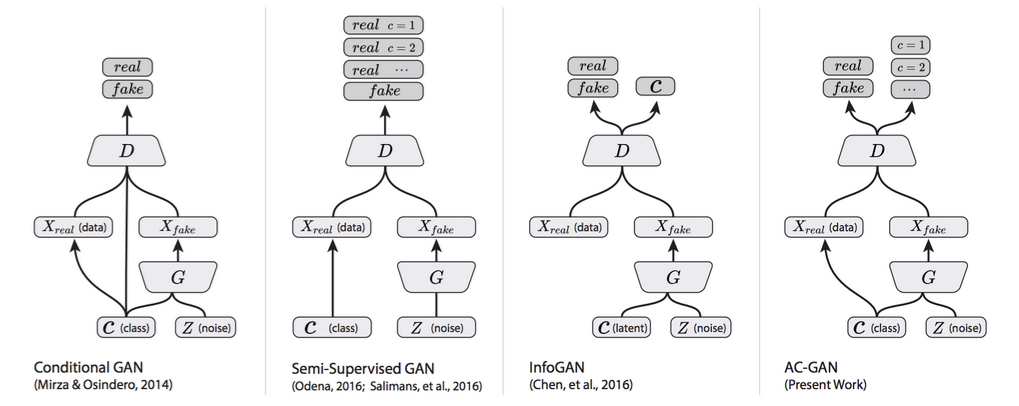

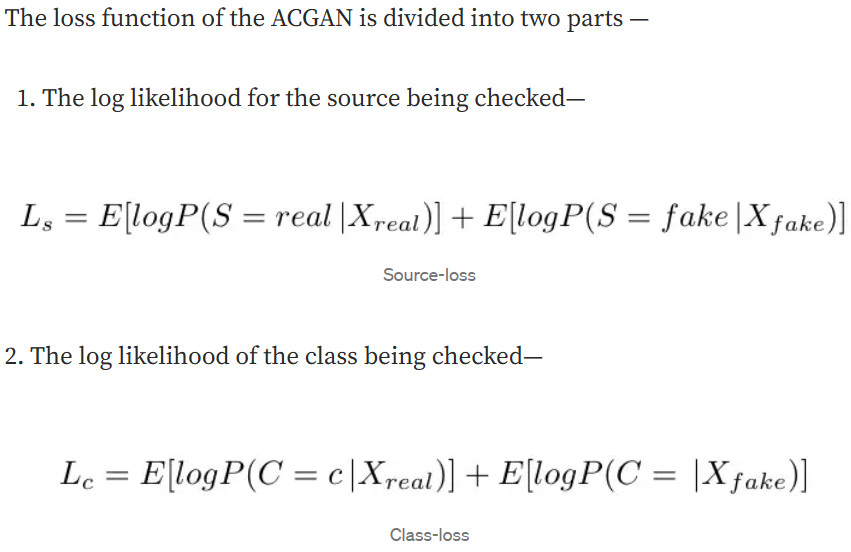

> The generator and the discriminator both try to maximize the class-loss. 
>
> The source-loss is however a min-max problem. The generator tries to minimize the source-loss and fool the discriminator. The discriminator on the other hand tries to maximize the source-loss and tries to prevent the generator from gaining an upper hand.
>
>

## **Implementation**

### **Import Library**

In [1]:
%%capture
! pip install torchsummary
! pip install keras_cv_attention_models 
! pip install torchviz
! pip install torchview

In [2]:
import cv2
import random
import logging
import numpy as np
import pandas as pd
#from PIL import Image
from time import time
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import keras
from keras.models import Sequential, Model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D, BatchNormalization
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.callbacks import EarlyStopping

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical 
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import logging
from sklearn.metrics import classification_report, confusion_matrix
from time import time
import seaborn as sns
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical #one-hot encode target column

import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.optim as optim
from torchview import draw_graph
from keras.utils import plot_model
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam

from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint

from matplotlib import pyplot


### **Get Data**

In [3]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Mounted at /content/MyDrive/


In [4]:
!ls "/content/MyDrive/MyDrive/Projects_Data/NN/"

FA-KES-Dataset.csv  Hand_Dataset


In [5]:
!ls "/content/MyDrive/MyDrive/Projects_Data/NN/Hand_Dataset"

'Class 1'  'Class 2'  'Class 3'  'Class 4'  'Class 5'


#### Pytorch Style

In [ ]:
def get_data_loader(data_dir, batch_size=32, train = True):
    """
    data_dir:   root directory where the either train or test dataset is
    batch_size: size of the batch
    train:      true if current phase is training, else false
    return:     augmented batch dataset
    """

    image_hight, image_width = 28, 28

    # define how we augment the data for composing the batch-dataset in train and test step
    transform = {
        'train': transforms.Compose([
            transforms.Resize([image_hight, image_width]), 
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ]),
        'test': transforms.Compose([
            transforms.Resize([image_hight, image_width]),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])
    }

    # ImageFloder with root directory and defined transformation methods for batch as well as data augmentation
    data = torchvision.datasets.ImageFolder(root=data_dir, transform=transform['train'] if train else 'test')
    data_loader = torch.utils.data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=2)

    return data_loader

In [ ]:
data_loader = get_data_loader("/content/MyDrive/MyDrive/Projects_Data/NN/Hand_Dataset")

In [ ]:
len(data_loader) # 32*32=1024 > 1005

32

In [ ]:
batch_x, batch_y = next(iter(data_loader))

print(np.shape(batch_x))
print(batch_y)

torch.Size([32, 3, 32, 32])
tensor([4, 2, 4, 2, 4, 1, 0, 2, 0, 0, 1, 1, 4, 4, 2, 0, 1, 2, 3, 2, 0, 3, 3, 2,
        1, 1, 0, 4, 2, 4, 3, 4])


#### Keras Style

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory  = "/content/MyDrive/MyDrive/Projects_Data/NN/Hand_Dataset",
    labels     = 'inferred',
    label_mode = 'categorical',
    color_mode = 'grayscale',
    batch_size = 32,
    image_size = (28, 28),
    seed       = 42)

Found 1005 files belonging to 5 classes.


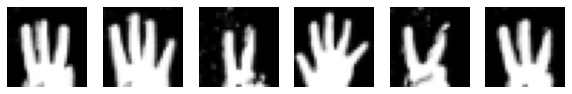

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(1, 6, i + 1)
        plt.imshow(images[i][:,:,0], cmap='gray')
        plt.axis("off")

In [ ]:
def process(image, label):
    image = tf.cast( (image-127.5)/127.5 ,tf.float32)
    return image, label

train_ds = train_ds.map(process)

In [ ]:
for images, labels in train_ds.take(1):
    print(images.shape)

(32, 28, 28, 1)


#### Manually

In [6]:
def load_images():
    images = []
    labels = []
    root_dir = "/content/MyDrive/MyDrive/Projects_Data/NN/Hand_Dataset"
    class_dirs = []
    for i in range(1,6):
        class_dirs.append('Class '+str(i))

    for i in range(1,6):
        img_dir = os.path.join(root_dir,class_dirs[i-1])
        imge_files = []
        for root, dirs, files in os.walk(img_dir):
            imge_files.extend(files)
        imge_files = sorted(imge_files)
        for img in imge_files:
            image_path = os.path.join(img_dir,img)
            image = Image.open(image_path)
            image = image.resize((28,28))
            images.append(np.array(image))
            labels.append(i-1)

    return np.array([images]), np.array([labels])

In [7]:
images, labels = load_images()

In [8]:
type(images)

numpy.ndarray

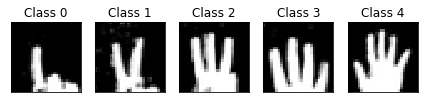

In [9]:
fig = plt.figure()
for i in range(5):
    plt.subplot(1, 5, i+1)
    x_y = images[labels == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [10]:
#pre-processing
images = images.reshape(images.shape[1], 28, 28, 1).astype('float32')
images = (images - 127.5) / 127.5

In [11]:
images.shape

(1005, 28, 28, 1)

In [12]:
labels = labels.reshape(labels.shape[1], 1).astype('float32')
labels.shape

(1005, 1)

### **ACGAN Code**

#### **Notes**

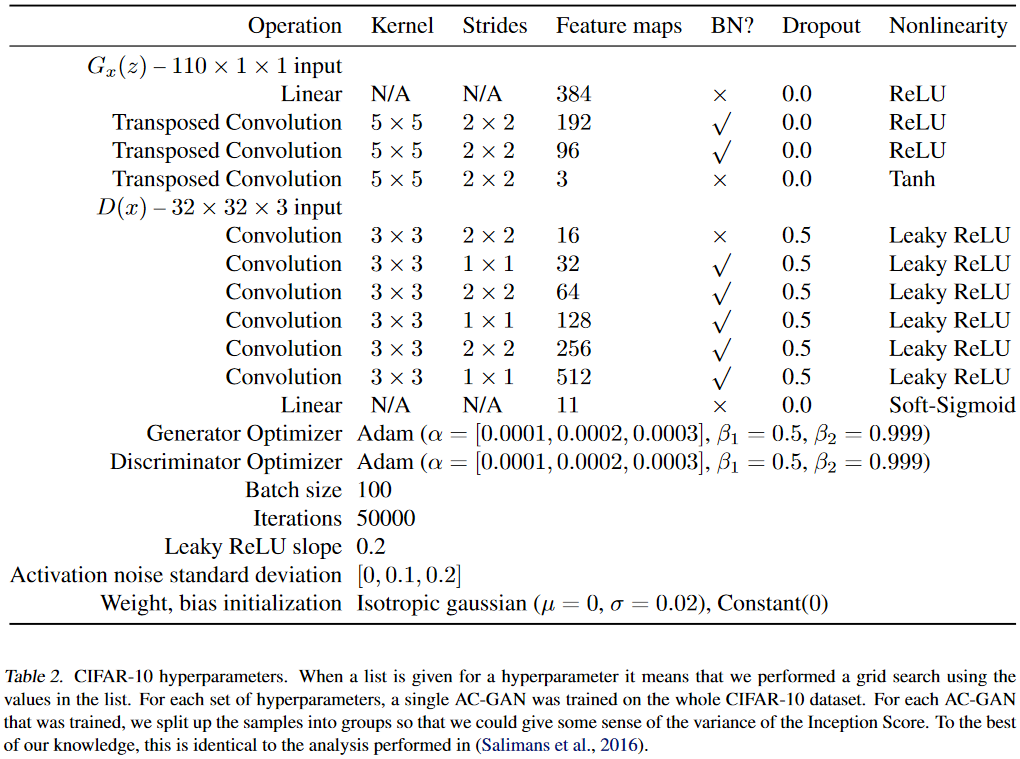

#### **Generator**

##### **Notes**

> The AC-GAN paper describes the AC-GAN generator model taking a vector input that is a concatenation of the point in latent space (100 dimensions) and the one hot encoded class label (10 dimensions) that is 110 dimensions.
>
> **But we have 5 class so vector input will be 105 dimensions.**

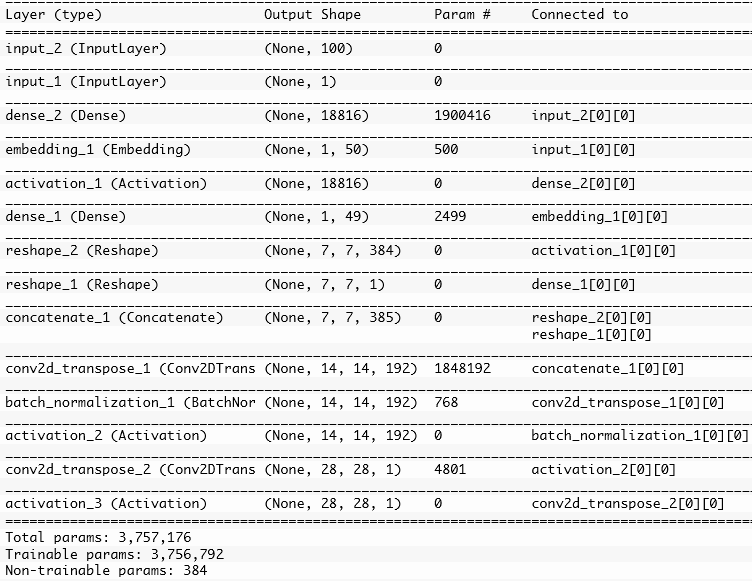

##### **Code**

In [13]:
def define_generator(latent_dim=100, n_classes=5):
    init = RandomNormal(stddev=0.02)

    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    n_nodes = 7 * 7
    li = Dense(n_nodes, kernel_initializer=init)(li)
    li = Reshape((7, 7, 1))(li)

    in_lat = Input(shape=(latent_dim,))
    n_nodes = 384 * 7 * 7
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 384))(gen)

    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = BatchNormalization()(gen)
    gen = Activation('relu')(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model


# define the generator model
generator_model = define_generator()
# summarize the model
generator_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 18816)        1900416     ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        250         ['input_1[0][0]']                
                                                                                              

#### **Discriminator**

##### **Notes**

> The discriminator model must take as input an image and predict both the probability of the ‘realness‘ of the image and the probability of the image belonging to each of the given classes.

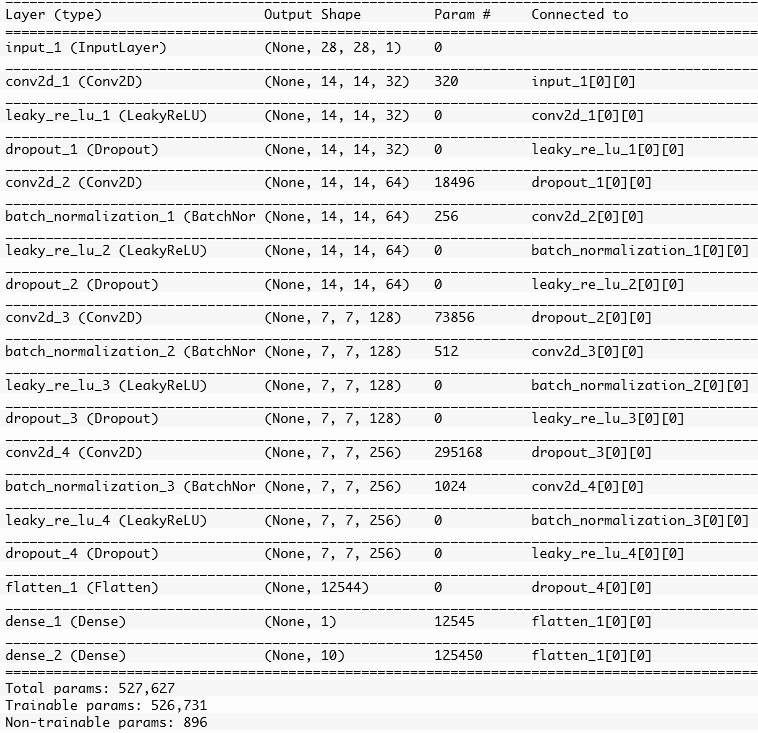

##### **Code**

In [14]:
def define_discriminator(in_shape=(28,28,1), n_classes=5):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=in_shape)

    # downsample to 14x14
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)

    # downsample to 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)
    # normal
    fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.5)(fe)

    # flatten feature maps
    fe = Flatten()(fe)

    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)

    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)

    # define model
    model = Model(in_image, [out1, out2])
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt, metrics=['accuracy'])
    return model
 
# define the discriminator model
discriminator_model = define_discriminator()
# summarize the model
discriminator_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 14, 14, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                            

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### **ACGAN**

##### **Notes**

> The generator model is not updated directly; instead, it is updated via the discriminator model.
>
> This can be achieved by creating a composite model that stacks the generator model on top of the discriminator model.
>
> The input to this composite model is the input to the generator model, namely a random point from the latent space and a class label. The generator model is connected directly to the discriminator model, which takes the generated image directly as input. Finally, the discriminator model predicts both the realness of the generated image and the class label. As such, the composite model is optimized using two loss functions, one for each output of the discriminator model.
>
> The discriminator model is updated in a standalone manner using real and fake examples, and we will review how to do this in the next section. Therefore, we do not want to update the discriminator model when updating (training) the composite model; we only want to use this composite model to update the weights of the generator model.

##### **Codes**

In [15]:
def define_acgan(g_model, d_model):
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False

    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)

    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

### **Training**

In [16]:
def generate_real_samples(images, labels, n_samples):
    ix             = randint(0, images.shape[0], n_samples)
    X, labels      = images[ix], labels[ix]
    y              = ones((n_samples, 1))
    return [X, labels], y

def generate_fake_samples(generator, latent_dim, n_samples, n_classes=5):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels  = randint(0, n_classes, n_samples)
    images  = generator.predict([z_input, labels])
    y       = zeros((n_samples, 1))
    return [images, labels], y

def generate_latent_points(latent_dim, n_samples, n_classes=5):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

In [17]:
def summarize_performance(g_model, latent_dim, n_samples=10):
    [X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)

    fig = plt.figure(figsize=(16, 6))

    for i in range(n_samples):
        plt.subplot(1, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow( X[i, :, :, 0] * 127.5 + 127.5, cmap='gray_r')

    plt.tight_layout()
    plt.show()

In [28]:
discriminator_on_real_samples_loss_history = []
discriminator_on_fake_samples_loss_history = []
generator_loss_history                     = [] 

discriminator_accuracy_history             = []
generator_accuracy_history                 = [] 

In [29]:
def train(g_model, d_model, gan_model, images, labels, latent_dim, n_epochs=200, n_batch=64):
    bat_per_epo = int(images.shape[0] / n_batch)                                                # calculate the number of batches per training epoch
    n_steps     = bat_per_epo * n_epochs                                                        # calculate the number of training iterations
    half_batch  = int(n_batch / 2)                                                              # calculate the size of half a batch of samples
    # print("bat_per_epo: ", bat_per_epo)

    for i in tqdm(range(n_steps)):                                                              # manually enumerate epochs
        [X_real, labels_real], y_real = generate_real_samples(images, labels, half_batch)       # get randomly selected 'real' samples
        d_r0, d_r1, d_r2, d_r3, d_r4 = d_model.train_on_batch(X_real, [y_real, labels_real])
        
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)  # generate 'fake' examples
        d_f0, d_f1, d_f2, d_f3, d_f4 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])                # update discriminator model weights
        
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)                       # prepare points in latent space as input for the generator
        y_gan = ones((n_batch, 1))                                                              # create inverted labels for the fake samples
        g_0, g_1, g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])        # update the generator via the discriminator's error

        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1, d_r2, d_f1,d_f2, g_1,g_2)) # summarize loss on this batch

        discriminator_on_real_samples_loss_history.append( [d_r0, d_r1, d_r2, d_r3, d_r4] )
        discriminator_on_fake_samples_loss_history.append( [d_f0, d_f1, d_f2, d_f3, d_f4] )
        generator_loss_history                    .append( [g_0 , g_1 , g_2 ] )

        # accuracy
        discriminator_accuracy_history.append( tf.keras.metrics.BinaryAccuracy()(tf.ones_like(X_real), X_real))
        generator_accuracy_history    .append( tf.keras.metrics.BinaryAccuracy()(tf.ones_like(X_fake), X_fake))

        if (i+1) % 100 == 0:                                                                     # evaluate the model performance every 'epoch'
            summarize_performance(g_model, latent_dim)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
  0%|          | 0/3000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 106ms/step


  0%|          | 1/3000 [00:02<2:05:30,  2.51s/it]

>1, dr[0.809,1.871], df[1.651,2.462], g[0.623,2.272]
1/1 [==============================] - 0s 17ms/step


  0%|          | 2/3000 [00:02<55:42,  1.11s/it]  

>2, dr[0.514,2.304], df[1.026,2.100], g[0.692,2.590]
1/1 [==============================] - 0s 13ms/step


  0%|          | 3/3000 [00:02<32:56,  1.52it/s]

>3, dr[0.568,1.793], df[1.036,1.993], g[0.794,2.208]
1/1 [==============================] - 0s 13ms/step


  0%|          | 4/3000 [00:02<22:21,  2.23it/s]

>4, dr[0.500,1.726], df[0.875,2.110], g[1.132,2.293]
1/1 [==============================] - 0s 14ms/step


  0%|          | 5/3000 [00:03<16:27,  3.03it/s]

>5, dr[0.545,1.740], df[0.675,1.895], g[1.154,2.096]
1/1 [==============================] - 0s 13ms/step


  0%|          | 6/3000 [00:03<13:02,  3.83it/s]

>6, dr[0.534,1.793], df[0.607,1.969], g[1.324,2.447]
1/1 [==============================] - 0s 15ms/step


  0%|          | 7/3000 [00:03<10:45,  4.63it/s]

>7, dr[0.359,1.864], df[0.610,2.170], g[1.596,2.195]
1/1 [==============================] - 0s 13ms/step


  0%|          | 8/3000 [00:03<09:16,  5.38it/s]

>8, dr[0.623,1.946], df[0.651,2.310], g[1.312,2.295]
1/1 [==============================] - 0s 18ms/step


  0%|          | 9/3000 [00:03<08:21,  5.96it/s]

>9, dr[0.326,1.690], df[0.452,2.196], g[1.718,2.401]
1/1 [==============================] - 0s 14ms/step


  0%|          | 10/3000 [00:03<07:38,  6.53it/s]

>10, dr[0.252,1.218], df[0.488,2.469], g[1.576,2.295]
1/1 [==============================] - 0s 13ms/step


  0%|          | 11/3000 [00:03<07:03,  7.06it/s]

>11, dr[0.423,1.623], df[0.416,1.754], g[1.257,1.933]
1/1 [==============================] - 0s 13ms/step


  0%|          | 12/3000 [00:03<06:56,  7.18it/s]

>12, dr[0.263,1.375], df[0.417,2.569], g[1.570,2.264]
1/1 [==============================] - 0s 13ms/step


  0%|          | 13/3000 [00:03<06:37,  7.51it/s]

>13, dr[0.445,1.280], df[0.306,2.224], g[1.395,2.359]
1/1 [==============================] - 0s 38ms/step
>14, dr[0.240,1.468], df[0.548,2.539], g[1.478,2.257]


  0%|          | 14/3000 [00:04<06:50,  7.27it/s]

1/1 [==============================] - 0s 13ms/step


  0%|          | 15/3000 [00:04<06:29,  7.67it/s]

>15, dr[0.339,1.345], df[0.526,2.258], g[1.383,2.145]
1/1 [==============================] - 0s 25ms/step


  1%|          | 16/3000 [00:04<07:02,  7.07it/s]

>16, dr[0.284,1.459], df[0.298,2.348], g[1.177,2.150]
1/1 [==============================] - 0s 19ms/step


  1%|          | 17/3000 [00:04<08:21,  5.95it/s]

>17, dr[0.213,1.145], df[0.345,2.419], g[1.347,2.415]
1/1 [==============================] - 0s 32ms/step


  1%|          | 18/3000 [00:04<08:30,  5.84it/s]

>18, dr[0.257,1.028], df[0.245,2.556], g[1.022,2.539]
1/1 [==============================] - 0s 24ms/step


  1%|          | 19/3000 [00:05<09:17,  5.35it/s]

>19, dr[0.251,0.943], df[0.418,2.116], g[1.050,2.257]
1/1 [==============================] - 0s 26ms/step


  1%|          | 20/3000 [00:05<09:30,  5.22it/s]

>20, dr[0.235,1.012], df[0.436,2.254], g[1.110,2.444]
1/1 [==============================] - 0s 25ms/step


  1%|          | 21/3000 [00:05<09:44,  5.10it/s]

>21, dr[0.228,0.724], df[0.237,2.455], g[0.871,2.230]
1/1 [==============================] - 0s 26ms/step


  1%|          | 22/3000 [00:05<09:54,  5.01it/s]

>22, dr[0.488,0.814], df[0.262,2.568], g[0.775,2.187]
1/1 [==============================] - 0s 25ms/step


  1%|          | 23/3000 [00:05<09:38,  5.15it/s]

>23, dr[0.242,0.771], df[0.348,2.760], g[0.630,2.477]
1/1 [==============================] - 0s 15ms/step


  1%|          | 24/3000 [00:06<09:21,  5.30it/s]

>24, dr[0.134,0.644], df[0.304,2.201], g[0.732,2.227]
1/1 [==============================] - 0s 16ms/step


  1%|          | 25/3000 [00:06<08:28,  5.85it/s]

>25, dr[0.109,0.915], df[0.200,2.532], g[0.846,2.247]
1/1 [==============================] - 0s 13ms/step
>26, dr[0.242,0.774], df[0.258,2.319], g[0.677,2.097]


  1%|          | 26/3000 [00:06<07:51,  6.31it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 27/3000 [00:06<07:32,  6.57it/s]

>27, dr[0.135,0.519], df[0.191,2.421], g[0.759,2.341]
1/1 [==============================] - 0s 14ms/step


  1%|          | 28/3000 [00:06<07:04,  7.01it/s]

>28, dr[0.216,0.605], df[0.146,2.105], g[0.763,2.370]
1/1 [==============================] - 0s 15ms/step


  1%|          | 29/3000 [00:06<06:50,  7.24it/s]

>29, dr[0.272,0.854], df[0.236,2.248], g[0.633,2.286]
1/1 [==============================] - 0s 14ms/step


  1%|          | 30/3000 [00:06<06:36,  7.49it/s]

>30, dr[0.108,0.711], df[0.332,2.470], g[0.568,2.098]
1/1 [==============================] - 0s 16ms/step


  1%|          | 31/3000 [00:06<06:24,  7.72it/s]

>31, dr[0.184,0.427], df[0.194,2.683], g[0.638,2.420]
1/1 [==============================] - 0s 14ms/step


  1%|          | 32/3000 [00:07<06:14,  7.93it/s]

>32, dr[0.211,0.700], df[0.206,2.236], g[0.451,2.240]
1/1 [==============================] - 0s 13ms/step


  1%|          | 33/3000 [00:07<06:11,  7.98it/s]

>33, dr[0.246,0.639], df[0.111,1.960], g[0.401,2.669]
1/1 [==============================] - 0s 13ms/step


  1%|          | 34/3000 [00:07<06:07,  8.08it/s]

>34, dr[0.091,0.721], df[0.134,2.418], g[0.431,2.609]
1/1 [==============================] - 0s 13ms/step
>35, dr[0.097,0.488], df[0.104,2.463], g[0.359,2.302]


  1%|          | 35/3000 [00:07<06:21,  7.78it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 36/3000 [00:07<06:12,  7.96it/s]

>36, dr[0.199,0.338], df[0.102,2.219], g[0.393,2.387]
1/1 [==============================] - 0s 14ms/step


  1%|          | 37/3000 [00:07<06:15,  7.89it/s]

>37, dr[0.065,0.364], df[0.119,2.430], g[0.322,2.191]
1/1 [==============================] - 0s 17ms/step
>38, dr[0.044,0.667], df[0.085,2.259], g[0.283,2.204]


  1%|▏         | 38/3000 [00:07<06:17,  7.84it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 39/3000 [00:07<06:11,  7.97it/s]

>39, dr[0.138,0.818], df[0.061,1.955], g[0.338,2.561]
1/1 [==============================] - 0s 14ms/step


  1%|▏         | 40/3000 [00:08<06:04,  8.12it/s]

>40, dr[0.025,0.202], df[0.090,2.276], g[0.251,2.524]
1/1 [==============================] - 0s 13ms/step


  1%|▏         | 41/3000 [00:08<06:03,  8.15it/s]

>41, dr[0.082,0.380], df[0.098,2.498], g[0.267,2.109]
1/1 [==============================] - 0s 14ms/step


  1%|▏         | 42/3000 [00:08<06:09,  8.00it/s]

>42, dr[0.081,0.484], df[0.110,2.081], g[0.277,2.357]
1/1 [==============================] - 0s 13ms/step


  1%|▏         | 43/3000 [00:08<06:10,  7.99it/s]

>43, dr[0.081,0.682], df[0.075,2.583], g[0.274,2.385]
1/1 [==============================] - 0s 13ms/step


  1%|▏         | 44/3000 [00:08<06:06,  8.06it/s]

>44, dr[0.097,0.309], df[0.151,2.562], g[0.305,2.670]
1/1 [==============================] - 0s 15ms/step


  2%|▏         | 45/3000 [00:08<06:03,  8.14it/s]

>45, dr[0.138,0.566], df[0.105,2.062], g[0.358,2.588]
1/1 [==============================] - 0s 14ms/step


  2%|▏         | 46/3000 [00:08<06:03,  8.12it/s]

>46, dr[0.092,0.363], df[0.126,1.881], g[0.262,2.613]
1/1 [==============================] - 0s 15ms/step


  2%|▏         | 47/3000 [00:08<06:00,  8.19it/s]

>47, dr[0.130,0.774], df[0.140,1.938], g[0.280,2.468]
1/1 [==============================] - 0s 19ms/step


  2%|▏         | 48/3000 [00:09<06:05,  8.07it/s]

>48, dr[0.083,0.489], df[0.110,2.506], g[0.285,2.166]
1/1 [==============================] - 0s 13ms/step
>49, dr[0.065,0.344], df[0.107,2.022], g[0.272,2.312]


  2%|▏         | 49/3000 [00:09<06:22,  7.71it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 50/3000 [00:09<06:17,  7.82it/s]

>50, dr[0.158,0.409], df[0.153,2.566], g[0.427,2.297]
1/1 [==============================] - 0s 15ms/step


  2%|▏         | 51/3000 [00:09<06:15,  7.85it/s]

>51, dr[0.116,0.384], df[0.075,2.012], g[0.316,2.378]
1/1 [==============================] - 0s 14ms/step


  2%|▏         | 52/3000 [00:09<06:16,  7.82it/s]

>52, dr[0.087,0.435], df[0.126,2.326], g[0.388,2.034]
1/1 [==============================] - 0s 17ms/step


  2%|▏         | 53/3000 [00:09<06:16,  7.83it/s]

>53, dr[0.037,0.234], df[0.067,2.204], g[0.472,2.378]
1/1 [==============================] - 0s 16ms/step
>54, dr[0.148,0.261], df[0.074,2.325], g[0.303,1.999]


  2%|▏         | 54/3000 [00:09<06:31,  7.52it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 55/3000 [00:09<06:38,  7.40it/s]

>55, dr[0.082,0.398], df[0.123,2.101], g[0.321,2.215]
1/1 [==============================] - 0s 16ms/step
>56, dr[0.202,0.293], df[0.107,2.371], g[0.270,2.524]


  2%|▏         | 56/3000 [00:10<06:28,  7.57it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 57/3000 [00:10<06:18,  7.77it/s]

>57, dr[0.088,0.191], df[0.066,2.230], g[0.202,2.193]
1/1 [==============================] - 0s 15ms/step


  2%|▏         | 58/3000 [00:10<06:15,  7.84it/s]

>58, dr[0.079,0.258], df[0.111,1.874], g[0.255,1.936]
1/1 [==============================] - 0s 16ms/step
>59, dr[0.148,0.579], df[0.126,2.140], g[0.237,2.406]


  2%|▏         | 59/3000 [00:10<06:19,  7.75it/s]

1/1 [==============================] - 0s 15ms/step
>60, dr[0.144,0.463], df[0.140,2.123], g[0.144,2.381]


  2%|▏         | 60/3000 [00:10<06:22,  7.69it/s]

1/1 [==============================] - 0s 28ms/step
>61, dr[0.146,0.251], df[0.207,2.573], g[0.291,2.260]


  2%|▏         | 61/3000 [00:10<06:27,  7.58it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 62/3000 [00:10<06:17,  7.79it/s]

>62, dr[0.053,0.201], df[0.074,2.065], g[0.369,2.131]
1/1 [==============================] - 0s 13ms/step


  2%|▏         | 63/3000 [00:10<06:12,  7.89it/s]

>63, dr[0.071,0.196], df[0.103,2.456], g[0.331,1.957]
1/1 [==============================] - 0s 14ms/step


  2%|▏         | 64/3000 [00:11<06:13,  7.85it/s]

>64, dr[0.146,0.249], df[0.081,1.877], g[0.251,2.186]
1/1 [==============================] - 0s 14ms/step
>65, dr[0.105,0.223], df[0.264,2.437], g[0.242,2.338]


  2%|▏         | 65/3000 [00:11<06:30,  7.51it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 66/3000 [00:11<06:27,  7.58it/s]

>66, dr[0.105,0.390], df[0.088,2.047], g[0.255,1.995]
1/1 [==============================] - 0s 15ms/step


  2%|▏         | 67/3000 [00:11<06:13,  7.85it/s]

>67, dr[0.146,0.173], df[0.228,1.758], g[0.394,2.439]
1/1 [==============================] - 0s 13ms/step


  2%|▏         | 68/3000 [00:11<06:07,  7.98it/s]

>68, dr[0.127,0.421], df[0.091,2.275], g[0.341,2.203]
1/1 [==============================] - 0s 17ms/step


  2%|▏         | 69/3000 [00:11<06:04,  8.05it/s]

>69, dr[0.188,0.395], df[0.185,2.076], g[0.366,2.402]
1/1 [==============================] - 0s 14ms/step


  2%|▏         | 70/3000 [00:11<06:03,  8.07it/s]

>70, dr[0.210,0.591], df[0.287,1.801], g[0.458,2.236]
1/1 [==============================] - 0s 15ms/step


  2%|▏         | 71/3000 [00:11<06:04,  8.03it/s]

>71, dr[0.223,0.400], df[0.097,2.542], g[0.345,2.273]
1/1 [==============================] - 0s 14ms/step


  2%|▏         | 72/3000 [00:12<06:04,  8.04it/s]

>72, dr[0.132,0.217], df[0.088,1.875], g[0.376,2.193]
1/1 [==============================] - 0s 13ms/step


  2%|▏         | 73/3000 [00:12<06:01,  8.10it/s]

>73, dr[0.208,0.358], df[0.172,1.609], g[0.235,2.257]
1/1 [==============================] - 0s 13ms/step


  2%|▏         | 74/3000 [00:12<06:06,  7.99it/s]

>74, dr[0.092,0.237], df[0.190,1.928], g[0.184,1.734]
1/1 [==============================] - 0s 17ms/step
>75, dr[0.345,0.492], df[0.252,2.051], g[0.421,1.947]


  2%|▎         | 75/3000 [00:12<06:09,  7.92it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 76/3000 [00:12<06:05,  8.00it/s]

>76, dr[0.175,0.504], df[0.277,2.017], g[0.462,2.496]
1/1 [==============================] - 0s 13ms/step


  3%|▎         | 77/3000 [00:12<06:05,  7.99it/s]

>77, dr[0.157,0.258], df[0.128,2.035], g[0.494,1.801]
1/1 [==============================] - 0s 14ms/step
>78, dr[0.238,0.208], df[0.166,1.718], g[0.348,2.112]


  3%|▎         | 78/3000 [00:12<06:12,  7.85it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 79/3000 [00:13<06:11,  7.87it/s]

>79, dr[0.185,0.260], df[0.245,1.775], g[0.358,1.787]
1/1 [==============================] - 0s 13ms/step


  3%|▎         | 80/3000 [00:13<06:03,  8.04it/s]

>80, dr[0.125,0.195], df[0.370,1.952], g[0.354,1.727]
1/1 [==============================] - 0s 13ms/step


  3%|▎         | 81/3000 [00:13<06:03,  8.03it/s]

>81, dr[0.192,0.136], df[0.258,1.634], g[0.417,1.563]
1/1 [==============================] - 0s 14ms/step


  3%|▎         | 82/3000 [00:13<06:00,  8.10it/s]

>82, dr[0.295,0.145], df[0.292,1.761], g[0.582,1.709]
1/1 [==============================] - 0s 14ms/step


  3%|▎         | 83/3000 [00:13<05:57,  8.17it/s]

>83, dr[0.355,0.052], df[0.309,1.736], g[0.342,1.948]
1/1 [==============================] - 0s 13ms/step


  3%|▎         | 84/3000 [00:13<05:56,  8.18it/s]

>84, dr[0.205,0.300], df[0.108,1.710], g[0.477,1.937]
1/1 [==============================] - 0s 13ms/step


  3%|▎         | 85/3000 [00:13<05:53,  8.25it/s]

>85, dr[0.157,0.112], df[0.088,1.582], g[0.205,2.186]
1/1 [==============================] - 0s 17ms/step


  3%|▎         | 86/3000 [00:13<05:56,  8.17it/s]

>86, dr[0.197,0.265], df[0.136,1.592], g[0.251,1.719]
1/1 [==============================] - 0s 13ms/step


  3%|▎         | 87/3000 [00:13<05:57,  8.15it/s]

>87, dr[0.199,0.273], df[0.413,1.860], g[0.158,1.502]
1/1 [==============================] - 0s 15ms/step


  3%|▎         | 88/3000 [00:14<05:56,  8.16it/s]

>88, dr[0.159,0.236], df[0.320,1.762], g[0.275,1.505]
1/1 [==============================] - 0s 13ms/step


  3%|▎         | 89/3000 [00:14<05:53,  8.25it/s]

>89, dr[0.206,0.188], df[0.396,1.839], g[0.708,1.737]
1/1 [==============================] - 0s 13ms/step


  3%|▎         | 90/3000 [00:14<05:56,  8.16it/s]

>90, dr[0.382,0.306], df[0.263,1.582], g[0.711,1.628]
1/1 [==============================] - 0s 13ms/step


  3%|▎         | 91/3000 [00:14<06:02,  8.02it/s]

>91, dr[0.375,0.205], df[0.316,1.715], g[0.479,1.404]
1/1 [==============================] - 0s 16ms/step


  3%|▎         | 92/3000 [00:14<06:00,  8.08it/s]

>92, dr[0.312,0.298], df[0.366,1.572], g[0.621,1.561]
1/1 [==============================] - 0s 13ms/step
>93, dr[0.376,0.162], df[0.154,1.701], g[0.360,1.404]


  3%|▎         | 93/3000 [00:14<06:17,  7.69it/s]

1/1 [==============================] - 0s 13ms/step


  3%|▎         | 94/3000 [00:14<06:19,  7.66it/s]

>94, dr[0.324,0.084], df[0.258,1.483], g[0.346,1.332]
1/1 [==============================] - 0s 15ms/step
>95, dr[0.102,0.053], df[0.134,1.466], g[0.396,1.454]


  3%|▎         | 95/3000 [00:14<06:16,  7.71it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 96/3000 [00:15<06:15,  7.73it/s]

>96, dr[0.330,0.330], df[0.203,1.821], g[0.252,1.456]
1/1 [==============================] - 0s 15ms/step
>97, dr[0.153,0.203], df[0.239,1.124], g[0.189,1.096]


  3%|▎         | 97/3000 [00:15<06:17,  7.68it/s]

1/1 [==============================] - 0s 15ms/step
>98, dr[0.142,0.129], df[0.175,1.433], g[0.121,1.203]


  3%|▎         | 98/3000 [00:15<06:21,  7.61it/s]

1/1 [==============================] - 0s 14ms/step


  3%|▎         | 99/3000 [00:15<06:12,  7.78it/s]

>99, dr[0.106,0.338], df[0.048,1.481], g[0.258,1.434]
1/1 [==============================] - 0s 16ms/step
>100, dr[0.089,0.139], df[0.174,1.580], g[0.183,1.462]
1/1 [==============================] - 0s 124ms/step


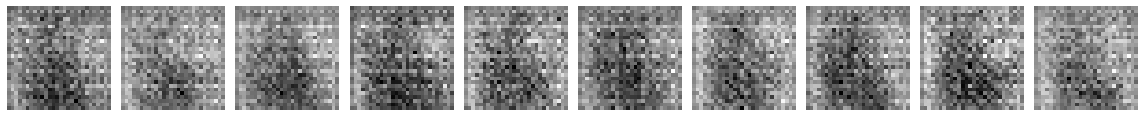

  3%|▎         | 100/3000 [00:16<13:10,  3.67it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 101/3000 [00:16<11:12,  4.31it/s]

>101, dr[0.285,0.236], df[0.122,1.609], g[0.077,0.910]
1/1 [==============================] - 0s 13ms/step
>102, dr[0.191,0.164], df[0.113,1.878], g[0.129,1.345]


  3%|▎         | 102/3000 [00:16<09:46,  4.94it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 103/3000 [00:16<08:38,  5.58it/s]

>103, dr[0.125,0.322], df[0.287,1.510], g[0.168,1.083]
1/1 [==============================] - 0s 15ms/step


  3%|▎         | 104/3000 [00:16<07:53,  6.11it/s]

>104, dr[0.105,0.275], df[0.193,1.165], g[0.200,1.134]
1/1 [==============================] - 0s 14ms/step
>105, dr[0.249,0.233], df[0.191,1.542], g[0.080,1.303]


  4%|▎         | 105/3000 [00:16<07:30,  6.43it/s]

1/1 [==============================] - 0s 13ms/step
>106, dr[0.095,0.221], df[0.150,1.200], g[0.162,0.893]


  4%|▎         | 106/3000 [00:16<07:10,  6.72it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▎         | 107/3000 [00:17<06:45,  7.13it/s]

>107, dr[0.131,0.163], df[0.077,1.153], g[0.112,0.696]
1/1 [==============================] - 0s 15ms/step


  4%|▎         | 108/3000 [00:17<06:36,  7.30it/s]

>108, dr[0.111,0.282], df[0.150,1.165], g[0.069,1.196]
1/1 [==============================] - 0s 21ms/step
>109, dr[0.075,0.105], df[0.166,1.124], g[0.093,0.894]


  4%|▎         | 109/3000 [00:17<06:37,  7.27it/s]

1/1 [==============================] - 0s 14ms/step
>110, dr[0.188,0.116], df[0.247,1.520], g[0.128,1.191]


  4%|▎         | 110/3000 [00:17<06:36,  7.30it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▎         | 111/3000 [00:17<06:21,  7.58it/s]

>111, dr[0.257,0.114], df[0.117,1.147], g[0.061,0.779]
1/1 [==============================] - 0s 16ms/step


  4%|▎         | 112/3000 [00:17<06:15,  7.69it/s]

>112, dr[0.054,0.166], df[0.065,1.484], g[0.074,0.908]
1/1 [==============================] - 0s 17ms/step


  4%|▍         | 113/3000 [00:17<06:13,  7.73it/s]

>113, dr[0.091,0.183], df[0.109,1.163], g[0.060,1.141]
1/1 [==============================] - 0s 14ms/step


  4%|▍         | 114/3000 [00:17<06:11,  7.77it/s]

>114, dr[0.154,0.112], df[0.121,0.693], g[0.093,1.152]
1/1 [==============================] - 0s 15ms/step
>115, dr[0.112,0.152], df[0.070,1.125], g[0.104,0.831]


  4%|▍         | 115/3000 [00:18<06:18,  7.62it/s]

1/1 [==============================] - 0s 14ms/step
>116, dr[0.067,0.196], df[0.073,1.137], g[0.080,0.885]


  4%|▍         | 116/3000 [00:18<06:16,  7.66it/s]

1/1 [==============================] - 0s 14ms/step
>117, dr[0.031,0.230], df[0.174,0.811], g[0.094,0.888]


  4%|▍         | 117/3000 [00:18<06:22,  7.53it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 118/3000 [00:18<06:21,  7.56it/s]

>118, dr[0.053,0.040], df[0.069,0.916], g[0.110,0.904]
1/1 [==============================] - 0s 21ms/step


  4%|▍         | 119/3000 [00:18<06:16,  7.64it/s]

>119, dr[0.043,0.184], df[0.028,0.995], g[0.107,0.822]
1/1 [==============================] - 0s 18ms/step


  4%|▍         | 120/3000 [00:18<06:16,  7.66it/s]

>120, dr[0.137,0.232], df[0.052,0.557], g[0.064,0.803]
1/1 [==============================] - 0s 15ms/step
>121, dr[0.056,0.253], df[0.145,0.759], g[0.091,0.579]


  4%|▍         | 121/3000 [00:18<06:19,  7.58it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 122/3000 [00:18<06:12,  7.73it/s]

>122, dr[0.104,0.112], df[0.072,0.608], g[0.152,0.659]
1/1 [==============================] - 0s 19ms/step
>123, dr[0.073,0.095], df[0.065,0.772], g[0.068,0.508]


  4%|▍         | 123/3000 [00:19<06:18,  7.61it/s]

1/1 [==============================] - 0s 13ms/step


  4%|▍         | 124/3000 [00:19<06:06,  7.84it/s]

>124, dr[0.082,0.155], df[0.089,0.513], g[0.075,0.774]
1/1 [==============================] - 0s 16ms/step


  4%|▍         | 125/3000 [00:19<06:10,  7.75it/s]

>125, dr[0.092,0.128], df[0.060,0.452], g[0.055,0.749]
1/1 [==============================] - 0s 14ms/step


  4%|▍         | 126/3000 [00:19<06:08,  7.79it/s]

>126, dr[0.074,0.108], df[0.089,1.035], g[0.077,0.489]
1/1 [==============================] - 0s 14ms/step


  4%|▍         | 127/3000 [00:19<06:06,  7.84it/s]

>127, dr[0.052,0.113], df[0.125,0.716], g[0.087,0.636]
1/1 [==============================] - 0s 15ms/step


  4%|▍         | 128/3000 [00:19<06:09,  7.77it/s]

>128, dr[0.065,0.044], df[0.056,1.058], g[0.177,0.553]
1/1 [==============================] - 0s 14ms/step
>129, dr[0.129,0.139], df[0.057,0.581], g[0.091,0.686]


  4%|▍         | 129/3000 [00:19<06:11,  7.73it/s]

1/1 [==============================] - 0s 13ms/step
>130, dr[0.179,0.091], df[0.057,0.793], g[0.057,0.579]


  4%|▍         | 130/3000 [00:20<06:08,  7.80it/s]

1/1 [==============================] - 0s 13ms/step
>131, dr[0.040,0.174], df[0.213,0.728], g[0.126,0.497]


  4%|▍         | 131/3000 [00:20<06:18,  7.58it/s]

1/1 [==============================] - 0s 14ms/step


  4%|▍         | 132/3000 [00:20<06:05,  7.84it/s]

>132, dr[0.129,0.294], df[0.100,0.743], g[0.191,0.338]
1/1 [==============================] - 0s 14ms/step


  4%|▍         | 133/3000 [00:20<06:03,  7.88it/s]

>133, dr[0.103,0.130], df[0.031,0.488], g[0.084,0.507]
1/1 [==============================] - 0s 28ms/step


  4%|▍         | 134/3000 [00:20<06:21,  7.51it/s]

>134, dr[0.102,0.076], df[0.123,0.556], g[0.089,0.748]
1/1 [==============================] - 0s 15ms/step
>135, dr[0.064,0.174], df[0.022,0.801], g[0.111,0.362]


  4%|▍         | 135/3000 [00:20<06:20,  7.52it/s]

1/1 [==============================] - 0s 14ms/step
>136, dr[0.052,0.087], df[0.045,0.443], g[0.095,0.375]


  5%|▍         | 136/3000 [00:20<06:29,  7.36it/s]

1/1 [==============================] - 0s 13ms/step
>137, dr[0.056,0.103], df[0.080,0.495], g[0.051,0.409]


  5%|▍         | 137/3000 [00:20<06:17,  7.59it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▍         | 138/3000 [00:21<06:07,  7.79it/s]

>138, dr[0.072,0.049], df[0.032,0.619], g[0.066,0.362]
1/1 [==============================] - 0s 13ms/step


  5%|▍         | 139/3000 [00:21<06:06,  7.80it/s]

>139, dr[0.029,0.055], df[0.033,0.524], g[0.087,0.285]
1/1 [==============================] - 0s 14ms/step


  5%|▍         | 140/3000 [00:21<06:01,  7.90it/s]

>140, dr[0.077,0.118], df[0.038,0.502], g[0.034,0.374]
1/1 [==============================] - 0s 14ms/step
>141, dr[0.033,0.029], df[0.085,0.596], g[0.056,0.267]


  5%|▍         | 141/3000 [00:21<06:17,  7.57it/s]

1/1 [==============================] - 0s 13ms/step
>142, dr[0.052,0.020], df[0.027,0.406], g[0.056,0.345]


  5%|▍         | 142/3000 [00:21<06:12,  7.67it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 143/3000 [00:21<06:06,  7.79it/s]

>143, dr[0.057,0.049], df[0.118,0.732], g[0.095,0.246]
1/1 [==============================] - 0s 16ms/step
>144, dr[0.062,0.074], df[0.104,0.404], g[0.077,0.544]


  5%|▍         | 144/3000 [00:21<06:14,  7.64it/s]

1/1 [==============================] - 0s 14ms/step


  5%|▍         | 145/3000 [00:21<06:05,  7.81it/s]

>145, dr[0.033,0.058], df[0.004,0.613], g[0.111,0.389]
1/1 [==============================] - 0s 13ms/step


  5%|▍         | 146/3000 [00:22<06:07,  7.76it/s]

>146, dr[0.059,0.174], df[0.029,0.854], g[0.075,0.278]
1/1 [==============================] - 0s 13ms/step


  5%|▍         | 147/3000 [00:22<06:04,  7.83it/s]

>147, dr[0.024,0.041], df[0.050,0.375], g[0.044,0.329]
1/1 [==============================] - 0s 16ms/step
>148, dr[0.032,0.104], df[0.047,0.529], g[0.071,0.327]


  5%|▍         | 148/3000 [00:22<06:15,  7.61it/s]

1/1 [==============================] - 0s 20ms/step
>149, dr[0.065,0.047], df[0.053,0.332], g[0.090,0.235]


  5%|▍         | 149/3000 [00:22<06:15,  7.59it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 150/3000 [00:22<06:11,  7.68it/s]

>150, dr[0.039,0.096], df[0.051,0.394], g[0.055,0.315]
1/1 [==============================] - 0s 15ms/step
>151, dr[0.093,0.111], df[0.035,0.342], g[0.074,0.237]


  5%|▌         | 151/3000 [00:22<06:15,  7.59it/s]

1/1 [==============================] - 0s 14ms/step
>152, dr[0.016,0.046], df[0.103,0.134], g[0.059,0.359]


  5%|▌         | 152/3000 [00:22<06:18,  7.53it/s]

1/1 [==============================] - 0s 14ms/step
>153, dr[0.030,0.043], df[0.020,0.345], g[0.128,0.208]


  5%|▌         | 153/3000 [00:23<06:17,  7.55it/s]

1/1 [==============================] - 0s 14ms/step
>154, dr[0.070,0.017], df[0.027,0.312], g[0.099,0.440]


  5%|▌         | 154/3000 [00:23<06:17,  7.54it/s]

1/1 [==============================] - 0s 16ms/step
>155, dr[0.042,0.062], df[0.024,0.437], g[0.049,0.193]


  5%|▌         | 155/3000 [00:23<06:16,  7.56it/s]

1/1 [==============================] - 0s 13ms/step
>156, dr[0.063,0.130], df[0.014,0.363], g[0.030,0.182]


  5%|▌         | 156/3000 [00:23<06:18,  7.51it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 157/3000 [00:23<06:22,  7.43it/s]

>157, dr[0.019,0.079], df[0.036,0.324], g[0.055,0.338]
1/1 [==============================] - 0s 25ms/step
>158, dr[0.010,0.162], df[0.062,0.357], g[0.075,0.114]


  5%|▌         | 158/3000 [00:23<06:26,  7.36it/s]

1/1 [==============================] - 0s 13ms/step
>159, dr[0.021,0.020], df[0.048,0.532], g[0.055,0.167]


  5%|▌         | 159/3000 [00:23<06:29,  7.30it/s]

1/1 [==============================] - 0s 14ms/step
>160, dr[0.038,0.086], df[0.084,0.224], g[0.087,0.121]


  5%|▌         | 160/3000 [00:23<06:20,  7.47it/s]

1/1 [==============================] - 0s 14ms/step
>161, dr[0.080,0.153], df[0.064,0.254], g[0.101,0.181]


  5%|▌         | 161/3000 [00:24<06:18,  7.50it/s]

1/1 [==============================] - 0s 17ms/step
>162, dr[0.118,0.094], df[0.019,0.215], g[0.043,0.100]


  5%|▌         | 162/3000 [00:24<06:17,  7.52it/s]

1/1 [==============================] - 0s 13ms/step
>163, dr[0.039,0.047], df[0.169,0.257], g[0.074,0.101]


  5%|▌         | 163/3000 [00:24<06:20,  7.46it/s]

1/1 [==============================] - 0s 13ms/step


  5%|▌         | 164/3000 [00:24<06:17,  7.51it/s]

>164, dr[0.032,0.104], df[0.052,0.232], g[0.173,0.207]
1/1 [==============================] - 0s 14ms/step
>165, dr[0.064,0.129], df[0.007,0.171], g[0.129,0.116]


  6%|▌         | 165/3000 [00:24<06:15,  7.56it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 166/3000 [00:24<06:09,  7.67it/s]

>166, dr[0.060,0.025], df[0.024,0.185], g[0.070,0.082]
1/1 [==============================] - 0s 16ms/step
>167, dr[0.078,0.033], df[0.049,0.148], g[0.062,0.133]


  6%|▌         | 167/3000 [00:24<06:14,  7.56it/s]

1/1 [==============================] - 0s 14ms/step
>168, dr[0.025,0.078], df[0.050,0.065], g[0.055,0.103]


  6%|▌         | 168/3000 [00:25<06:11,  7.62it/s]

1/1 [==============================] - 0s 14ms/step
>169, dr[0.068,0.087], df[0.017,0.133], g[0.050,0.084]


  6%|▌         | 169/3000 [00:25<06:14,  7.57it/s]

1/1 [==============================] - 0s 16ms/step
>170, dr[0.030,0.089], df[0.025,0.140], g[0.065,0.059]


  6%|▌         | 170/3000 [00:25<06:18,  7.48it/s]

1/1 [==============================] - 0s 15ms/step
>171, dr[0.026,0.010], df[0.049,0.127], g[0.046,0.153]


  6%|▌         | 171/3000 [00:25<06:12,  7.60it/s]

1/1 [==============================] - 0s 19ms/step
>172, dr[0.075,0.054], df[0.047,0.339], g[0.033,0.130]


  6%|▌         | 172/3000 [00:25<06:14,  7.55it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 173/3000 [00:25<06:07,  7.69it/s]

>173, dr[0.076,0.022], df[0.021,0.138], g[0.065,0.067]
1/1 [==============================] - 0s 15ms/step


  6%|▌         | 174/3000 [00:25<06:05,  7.73it/s]

>174, dr[0.020,0.031], df[0.020,0.153], g[0.045,0.052]
1/1 [==============================] - 0s 13ms/step
>175, dr[0.043,0.108], df[0.023,0.120], g[0.037,0.095]


  6%|▌         | 175/3000 [00:25<06:18,  7.46it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 176/3000 [00:26<06:15,  7.51it/s]

>176, dr[0.020,0.094], df[0.061,0.065], g[0.033,0.048]
1/1 [==============================] - 0s 13ms/step
>177, dr[0.015,0.027], df[0.095,0.158], g[0.071,0.063]


  6%|▌         | 177/3000 [00:26<06:11,  7.60it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 178/3000 [00:26<06:09,  7.64it/s]

>178, dr[0.030,0.029], df[0.006,0.234], g[0.056,0.109]
1/1 [==============================] - 0s 14ms/step
>179, dr[0.051,0.085], df[0.040,0.109], g[0.031,0.092]


  6%|▌         | 179/3000 [00:26<06:08,  7.66it/s]

1/1 [==============================] - 0s 16ms/step
>180, dr[0.025,0.289], df[0.033,0.087], g[0.031,0.133]


  6%|▌         | 180/3000 [00:26<06:16,  7.49it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 181/3000 [00:26<06:04,  7.73it/s]

>181, dr[0.020,0.057], df[0.034,0.064], g[0.050,0.061]
1/1 [==============================] - 0s 13ms/step


  6%|▌         | 182/3000 [00:26<06:02,  7.78it/s]

>182, dr[0.057,0.074], df[0.015,0.099], g[0.052,0.069]
1/1 [==============================] - 0s 13ms/step


  6%|▌         | 183/3000 [00:26<06:02,  7.76it/s]

>183, dr[0.022,0.015], df[0.013,0.046], g[0.058,0.071]
1/1 [==============================] - 0s 13ms/step


  6%|▌         | 184/3000 [00:27<05:55,  7.91it/s]

>184, dr[0.016,0.144], df[0.027,0.123], g[0.042,0.033]
1/1 [==============================] - 0s 13ms/step


  6%|▌         | 185/3000 [00:27<06:02,  7.77it/s]

>185, dr[0.039,0.014], df[0.024,0.064], g[0.040,0.094]
1/1 [==============================] - 0s 14ms/step


  6%|▌         | 186/3000 [00:27<06:03,  7.74it/s]

>186, dr[0.021,0.062], df[0.029,0.059], g[0.033,0.102]
1/1 [==============================] - 0s 15ms/step
>187, dr[0.049,0.063], df[0.055,0.133], g[0.033,0.115]


  6%|▌         | 187/3000 [00:27<06:03,  7.74it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▋         | 188/3000 [00:27<06:05,  7.69it/s]

>188, dr[0.035,0.025], df[0.011,0.069], g[0.040,0.049]
1/1 [==============================] - 0s 15ms/step


  6%|▋         | 189/3000 [00:27<06:04,  7.71it/s]

>189, dr[0.025,0.193], df[0.011,0.042], g[0.047,0.033]
1/1 [==============================] - 0s 15ms/step
>190, dr[0.028,0.040], df[0.031,0.017], g[0.033,0.041]


  6%|▋         | 190/3000 [00:27<06:12,  7.54it/s]

1/1 [==============================] - 0s 15ms/step
>191, dr[0.046,0.112], df[0.018,0.062], g[0.028,0.038]


  6%|▋         | 191/3000 [00:28<06:12,  7.54it/s]

1/1 [==============================] - 0s 15ms/step
>192, dr[0.024,0.053], df[0.055,0.036], g[0.070,0.037]


  6%|▋         | 192/3000 [00:28<06:16,  7.47it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▋         | 193/3000 [00:28<06:05,  7.67it/s]

>193, dr[0.017,0.018], df[0.027,0.071], g[0.068,0.058]
1/1 [==============================] - 0s 18ms/step


  6%|▋         | 194/3000 [00:28<06:03,  7.73it/s]

>194, dr[0.027,0.075], df[0.013,0.028], g[0.038,0.038]
1/1 [==============================] - 0s 15ms/step
>195, dr[0.070,0.036], df[0.058,0.099], g[0.052,0.047]


  6%|▋         | 195/3000 [00:28<06:10,  7.57it/s]

1/1 [==============================] - 0s 15ms/step
>196, dr[0.029,0.124], df[0.025,0.078], g[0.030,0.090]


  7%|▋         | 196/3000 [00:28<06:06,  7.66it/s]

1/1 [==============================] - 0s 14ms/step
>197, dr[0.033,0.260], df[0.034,0.099], g[0.054,0.028]


  7%|▋         | 197/3000 [00:28<06:04,  7.69it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 198/3000 [00:28<06:01,  7.76it/s]

>198, dr[0.040,0.014], df[0.035,0.032], g[0.032,0.031]
1/1 [==============================] - 0s 18ms/step


  7%|▋         | 199/3000 [00:29<06:00,  7.77it/s]

>199, dr[0.074,0.016], df[0.041,0.052], g[0.037,0.059]
1/1 [==============================] - 0s 14ms/step
>200, dr[0.040,0.108], df[0.038,0.043], g[0.024,0.049]
1/1 [==============================] - 0s 15ms/step


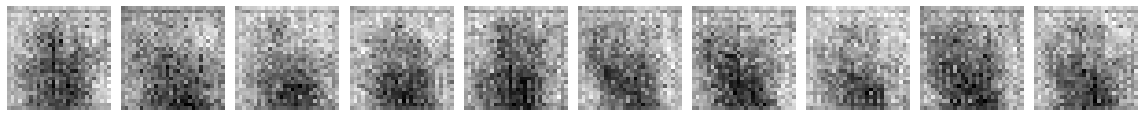

  7%|▋         | 200/3000 [00:29<11:36,  4.02it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 201/3000 [00:29<10:02,  4.65it/s]

>201, dr[0.019,0.040], df[0.070,0.056], g[0.064,0.036]
1/1 [==============================] - 0s 14ms/step
>202, dr[0.059,0.012], df[0.010,0.092], g[0.058,0.030]


  7%|▋         | 202/3000 [00:29<08:54,  5.24it/s]

1/1 [==============================] - 0s 14ms/step
>203, dr[0.049,0.082], df[0.054,0.053], g[0.069,0.035]


  7%|▋         | 203/3000 [00:30<08:06,  5.75it/s]

1/1 [==============================] - 0s 14ms/step
>204, dr[0.042,0.033], df[0.018,0.033], g[0.075,0.053]


  7%|▋         | 204/3000 [00:30<07:31,  6.20it/s]

1/1 [==============================] - 0s 14ms/step
>205, dr[0.069,0.014], df[0.099,0.111], g[0.063,0.049]


  7%|▋         | 205/3000 [00:30<07:04,  6.59it/s]

1/1 [==============================] - 0s 13ms/step
>206, dr[0.035,0.074], df[0.020,0.074], g[0.051,0.115]


  7%|▋         | 206/3000 [00:30<06:45,  6.90it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 207/3000 [00:30<06:25,  7.25it/s]

>207, dr[0.026,0.020], df[0.006,0.069], g[0.020,0.102]
1/1 [==============================] - 0s 26ms/step


  7%|▋         | 208/3000 [00:30<06:36,  7.03it/s]

>208, dr[0.019,0.020], df[0.032,0.091], g[0.036,0.058]
1/1 [==============================] - 0s 15ms/step
>209, dr[0.014,0.015], df[0.010,0.063], g[0.020,0.027]


  7%|▋         | 209/3000 [00:30<06:31,  7.12it/s]

1/1 [==============================] - 0s 14ms/step


  7%|▋         | 210/3000 [00:30<06:30,  7.14it/s]

>210, dr[0.031,0.042], df[0.020,0.051], g[0.029,0.033]
1/1 [==============================] - 0s 22ms/step


  7%|▋         | 211/3000 [00:31<06:33,  7.08it/s]

>211, dr[0.021,0.101], df[0.027,0.102], g[0.026,0.021]
1/1 [==============================] - 0s 21ms/step


  7%|▋         | 212/3000 [00:31<06:26,  7.22it/s]

>212, dr[0.007,0.012], df[0.087,0.036], g[0.033,0.018]
1/1 [==============================] - 0s 13ms/step
>213, dr[0.073,0.045], df[0.031,0.062], g[0.050,0.053]


  7%|▋         | 213/3000 [00:31<06:23,  7.26it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 214/3000 [00:31<06:07,  7.58it/s]

>214, dr[0.028,0.045], df[0.015,0.042], g[0.036,0.039]
1/1 [==============================] - 0s 14ms/step
>215, dr[0.034,0.039], df[0.004,0.056], g[0.033,0.019]


  7%|▋         | 215/3000 [00:31<06:15,  7.42it/s]

1/1 [==============================] - 0s 15ms/step
>216, dr[0.020,0.016], df[0.014,0.073], g[0.015,0.037]


  7%|▋         | 216/3000 [00:31<06:13,  7.44it/s]

1/1 [==============================] - 0s 13ms/step
>217, dr[0.007,0.036], df[0.102,0.050], g[0.044,0.061]


  7%|▋         | 217/3000 [00:31<06:04,  7.64it/s]

1/1 [==============================] - 0s 14ms/step
>218, dr[0.037,0.007], df[0.002,0.147], g[0.056,0.083]


  7%|▋         | 218/3000 [00:32<06:13,  7.45it/s]

1/1 [==============================] - 0s 15ms/step
>219, dr[0.021,0.098], df[0.014,0.061], g[0.041,0.024]


  7%|▋         | 219/3000 [00:32<06:08,  7.55it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 220/3000 [00:32<06:02,  7.67it/s]

>220, dr[0.033,0.032], df[0.017,0.075], g[0.020,0.030]
1/1 [==============================] - 0s 13ms/step
>221, dr[0.024,0.031], df[0.034,0.058], g[0.018,0.020]


  7%|▋         | 221/3000 [00:32<06:07,  7.56it/s]

1/1 [==============================] - 0s 13ms/step
>222, dr[0.030,0.109], df[0.021,0.054], g[0.034,0.019]


  7%|▋         | 222/3000 [00:32<06:06,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 223/3000 [00:32<06:14,  7.42it/s]

>223, dr[0.024,0.200], df[0.021,0.058], g[0.024,0.031]
1/1 [==============================] - 0s 20ms/step
>224, dr[0.019,0.008], df[0.028,0.031], g[0.030,0.029]


  7%|▋         | 224/3000 [00:32<06:19,  7.32it/s]

1/1 [==============================] - 0s 14ms/step
>225, dr[0.025,0.031], df[0.010,0.020], g[0.037,0.037]


  8%|▊         | 225/3000 [00:32<06:19,  7.31it/s]

1/1 [==============================] - 0s 14ms/step
>226, dr[0.027,0.017], df[0.016,0.029], g[0.027,0.017]


  8%|▊         | 226/3000 [00:33<06:14,  7.41it/s]

1/1 [==============================] - 0s 15ms/step
>227, dr[0.039,0.046], df[0.140,0.025], g[0.063,0.025]


  8%|▊         | 227/3000 [00:33<06:09,  7.51it/s]

1/1 [==============================] - 0s 14ms/step
>228, dr[0.126,0.044], df[0.011,0.059], g[0.036,0.017]


  8%|▊         | 228/3000 [00:33<06:04,  7.61it/s]

1/1 [==============================] - 0s 13ms/step


  8%|▊         | 229/3000 [00:33<06:00,  7.68it/s]

>229, dr[0.071,0.092], df[0.029,0.052], g[0.040,0.023]
1/1 [==============================] - 0s 14ms/step


  8%|▊         | 230/3000 [00:33<06:00,  7.69it/s]

>230, dr[0.007,0.030], df[0.024,0.025], g[0.038,0.067]
1/1 [==============================] - 0s 14ms/step
>231, dr[0.012,0.044], df[0.026,0.054], g[0.043,0.030]


  8%|▊         | 231/3000 [00:33<06:12,  7.43it/s]

1/1 [==============================] - 0s 14ms/step


  8%|▊         | 232/3000 [00:33<06:04,  7.60it/s]

>232, dr[0.029,0.005], df[0.019,0.043], g[0.065,0.062]
1/1 [==============================] - 0s 16ms/step


  8%|▊         | 233/3000 [00:33<06:00,  7.68it/s]

>233, dr[0.024,0.013], df[0.043,0.026], g[0.040,0.014]
1/1 [==============================] - 0s 13ms/step


  8%|▊         | 234/3000 [00:34<05:59,  7.69it/s]

>234, dr[0.036,0.014], df[0.005,0.025], g[0.035,0.141]
1/1 [==============================] - 0s 20ms/step
>235, dr[0.031,0.025], df[0.037,0.034], g[0.058,0.058]


  8%|▊         | 235/3000 [00:34<06:07,  7.53it/s]

1/1 [==============================] - 0s 15ms/step
>236, dr[0.018,0.083], df[0.008,0.029], g[0.056,0.034]


  8%|▊         | 236/3000 [00:34<06:06,  7.54it/s]

1/1 [==============================] - 0s 15ms/step
>237, dr[0.020,0.024], df[0.011,0.029], g[0.067,0.015]


  8%|▊         | 237/3000 [00:34<06:10,  7.46it/s]

1/1 [==============================] - 0s 14ms/step
>238, dr[0.013,0.065], df[0.010,0.022], g[0.040,0.063]


  8%|▊         | 238/3000 [00:34<06:11,  7.43it/s]

1/1 [==============================] - 0s 15ms/step
>239, dr[0.016,0.012], df[0.008,0.131], g[0.036,0.077]


  8%|▊         | 239/3000 [00:34<06:07,  7.51it/s]

1/1 [==============================] - 0s 13ms/step


  8%|▊         | 240/3000 [00:34<05:56,  7.73it/s]

>240, dr[0.015,0.016], df[0.009,0.019], g[0.024,0.017]
1/1 [==============================] - 0s 14ms/step
>241, dr[0.016,0.009], df[0.025,0.121], g[0.011,0.019]


  8%|▊         | 241/3000 [00:35<06:00,  7.66it/s]

1/1 [==============================] - 0s 14ms/step


  8%|▊         | 242/3000 [00:35<05:56,  7.74it/s]

>242, dr[0.006,0.038], df[0.016,0.022], g[0.017,0.014]
1/1 [==============================] - 0s 13ms/step
>243, dr[0.008,0.024], df[0.011,0.037], g[0.027,0.008]


  8%|▊         | 243/3000 [00:35<06:00,  7.65it/s]

1/1 [==============================] - 0s 14ms/step
>244, dr[0.114,0.007], df[0.021,0.023], g[0.013,0.018]


  8%|▊         | 244/3000 [00:35<05:59,  7.67it/s]

1/1 [==============================] - 0s 18ms/step
>245, dr[0.004,0.012], df[0.019,0.023], g[0.019,0.031]


  8%|▊         | 245/3000 [00:35<06:00,  7.65it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 246/3000 [00:35<06:13,  7.37it/s]

>246, dr[0.016,0.039], df[0.031,0.028], g[0.054,0.016]
1/1 [==============================] - 0s 14ms/step


  8%|▊         | 247/3000 [00:35<06:12,  7.39it/s]

>247, dr[0.018,0.090], df[0.011,0.008], g[0.063,0.021]
1/1 [==============================] - 0s 13ms/step


  8%|▊         | 248/3000 [00:35<06:04,  7.55it/s]

>248, dr[0.034,0.018], df[0.012,0.010], g[0.053,0.018]
1/1 [==============================] - 0s 14ms/step
>249, dr[0.034,0.047], df[0.086,0.022], g[0.194,0.043]


  8%|▊         | 249/3000 [00:36<06:11,  7.40it/s]

1/1 [==============================] - 0s 13ms/step
>250, dr[0.077,0.033], df[0.003,0.014], g[0.208,0.045]


  8%|▊         | 250/3000 [00:36<06:05,  7.52it/s]

1/1 [==============================] - 0s 14ms/step
>251, dr[0.055,0.081], df[0.024,0.022], g[0.068,0.034]


  8%|▊         | 251/3000 [00:36<06:06,  7.51it/s]

1/1 [==============================] - 0s 14ms/step


  8%|▊         | 252/3000 [00:36<05:55,  7.73it/s]

>252, dr[0.033,0.015], df[0.032,0.039], g[0.048,0.145]
1/1 [==============================] - 0s 14ms/step
>253, dr[0.016,0.005], df[0.030,0.077], g[0.042,0.054]


  8%|▊         | 253/3000 [00:36<05:58,  7.66it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 254/3000 [00:36<06:08,  7.45it/s]

>254, dr[0.033,0.068], df[0.007,0.011], g[0.048,0.179]
1/1 [==============================] - 0s 18ms/step
>255, dr[0.021,0.007], df[0.014,0.057], g[0.022,0.056]


  8%|▊         | 255/3000 [00:36<06:11,  7.40it/s]

1/1 [==============================] - 0s 14ms/step


  9%|▊         | 256/3000 [00:37<06:12,  7.37it/s]

>256, dr[0.007,0.023], df[0.018,0.064], g[0.034,0.096]
1/1 [==============================] - 0s 18ms/step


  9%|▊         | 257/3000 [00:37<06:17,  7.26it/s]

>257, dr[0.003,0.002], df[0.007,0.084], g[0.027,0.017]
1/1 [==============================] - 0s 19ms/step
>258, dr[0.013,0.034], df[0.008,0.059], g[0.017,0.024]


  9%|▊         | 258/3000 [00:37<06:13,  7.34it/s]

1/1 [==============================] - 0s 14ms/step
>259, dr[0.005,0.010], df[0.121,0.031], g[0.102,0.033]


  9%|▊         | 259/3000 [00:37<06:10,  7.39it/s]

1/1 [==============================] - 0s 14ms/step
>260, dr[0.023,0.050], df[0.000,0.064], g[0.165,0.014]


  9%|▊         | 260/3000 [00:37<06:11,  7.38it/s]

1/1 [==============================] - 0s 13ms/step


  9%|▊         | 261/3000 [00:37<06:07,  7.45it/s]

>261, dr[0.054,0.013], df[0.010,0.012], g[0.026,0.043]
1/1 [==============================] - 0s 21ms/step


  9%|▊         | 262/3000 [00:37<06:12,  7.36it/s]

>262, dr[0.017,0.027], df[0.097,0.023], g[0.249,0.031]
1/1 [==============================] - 0s 20ms/step
>263, dr[0.098,0.064], df[0.006,0.019], g[0.129,0.020]


  9%|▉         | 263/3000 [00:38<06:11,  7.37it/s]

1/1 [==============================] - 0s 14ms/step
>264, dr[0.044,0.020], df[0.046,0.012], g[0.072,0.034]


  9%|▉         | 264/3000 [00:38<06:04,  7.51it/s]

1/1 [==============================] - 0s 14ms/step
>265, dr[0.068,0.013], df[0.031,0.049], g[0.060,0.141]


  9%|▉         | 265/3000 [00:38<06:04,  7.51it/s]

1/1 [==============================] - 0s 13ms/step


  9%|▉         | 266/3000 [00:38<05:56,  7.68it/s]

>266, dr[0.026,0.028], df[0.012,0.014], g[0.134,0.073]
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 267/3000 [00:38<06:08,  7.43it/s]

>267, dr[0.016,0.118], df[0.019,0.072], g[0.066,0.039]
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 268/3000 [00:38<06:15,  7.28it/s]

>268, dr[0.024,0.026], df[0.036,0.032], g[0.061,0.056]
1/1 [==============================] - 0s 26ms/step


  9%|▉         | 269/3000 [00:38<06:24,  7.11it/s]

>269, dr[0.050,0.065], df[0.094,0.041], g[0.218,0.040]
1/1 [==============================] - 0s 15ms/step
>270, dr[0.139,0.031], df[0.007,0.022], g[0.029,0.075]


  9%|▉         | 270/3000 [00:38<06:29,  7.02it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 271/3000 [00:39<06:22,  7.14it/s]

>271, dr[0.006,0.029], df[0.102,0.013], g[0.305,0.038]
1/1 [==============================] - 0s 23ms/step


  9%|▉         | 272/3000 [00:39<06:26,  7.05it/s]

>272, dr[0.089,0.141], df[0.002,0.058], g[0.065,0.026]
1/1 [==============================] - 0s 20ms/step


  9%|▉         | 273/3000 [00:39<06:30,  6.99it/s]

>273, dr[0.022,0.012], df[0.089,0.080], g[0.103,0.111]
1/1 [==============================] - 0s 17ms/step
>274, dr[0.044,0.019], df[0.010,0.075], g[0.075,0.032]


  9%|▉         | 274/3000 [00:39<06:22,  7.12it/s]

1/1 [==============================] - 0s 15ms/step
>275, dr[0.061,0.023], df[0.042,0.032], g[0.039,0.053]


  9%|▉         | 275/3000 [00:39<06:13,  7.30it/s]

1/1 [==============================] - 0s 14ms/step
>276, dr[0.023,0.013], df[0.065,0.023], g[0.257,0.065]


  9%|▉         | 276/3000 [00:39<06:12,  7.31it/s]

1/1 [==============================] - 0s 15ms/step
>277, dr[0.230,0.009], df[0.104,0.051], g[0.252,0.023]


  9%|▉         | 277/3000 [00:39<06:09,  7.36it/s]

1/1 [==============================] - 0s 15ms/step
>278, dr[0.052,0.011], df[0.003,0.048], g[0.118,0.123]


  9%|▉         | 278/3000 [00:40<06:13,  7.28it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 279/3000 [00:40<06:13,  7.28it/s]

>279, dr[0.114,0.031], df[0.084,0.034], g[0.178,0.045]
1/1 [==============================] - 0s 19ms/step


  9%|▉         | 280/3000 [00:40<06:11,  7.32it/s]

>280, dr[0.080,0.014], df[0.019,0.033], g[0.089,0.078]
1/1 [==============================] - 0s 15ms/step
>281, dr[0.108,0.022], df[0.059,0.028], g[0.139,0.058]


  9%|▉         | 281/3000 [00:40<06:18,  7.19it/s]

1/1 [==============================] - 0s 14ms/step


  9%|▉         | 282/3000 [00:40<06:10,  7.34it/s]

>282, dr[0.047,0.046], df[0.038,0.075], g[0.113,0.043]
1/1 [==============================] - 0s 19ms/step
>283, dr[0.062,0.010], df[0.016,0.017], g[0.058,0.137]


  9%|▉         | 283/3000 [00:40<06:11,  7.30it/s]

1/1 [==============================] - 0s 16ms/step
>284, dr[0.016,0.039], df[0.044,0.080], g[0.067,0.147]


  9%|▉         | 284/3000 [00:40<06:14,  7.25it/s]

1/1 [==============================] - 0s 15ms/step
>285, dr[0.010,0.112], df[0.005,0.021], g[0.088,0.024]


 10%|▉         | 285/3000 [00:41<06:15,  7.23it/s]

1/1 [==============================] - 0s 14ms/step


 10%|▉         | 286/3000 [00:41<06:12,  7.29it/s]

>286, dr[0.019,0.004], df[0.016,0.023], g[0.040,0.077]
1/1 [==============================] - 0s 20ms/step
>287, dr[0.029,0.010], df[0.062,0.064], g[0.167,0.022]


 10%|▉         | 287/3000 [00:41<06:12,  7.29it/s]

1/1 [==============================] - 0s 14ms/step
>288, dr[0.083,0.056], df[0.006,0.015], g[0.009,0.046]


 10%|▉         | 288/3000 [00:41<06:10,  7.32it/s]

1/1 [==============================] - 0s 14ms/step
>289, dr[0.033,0.004], df[0.041,0.056], g[0.019,0.016]


 10%|▉         | 289/3000 [00:41<06:06,  7.40it/s]

1/1 [==============================] - 0s 14ms/step
>290, dr[0.010,0.010], df[0.014,0.012], g[0.041,0.022]


 10%|▉         | 290/3000 [00:41<06:04,  7.43it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 291/3000 [00:41<06:07,  7.38it/s]

>291, dr[0.006,0.021], df[0.006,0.044], g[0.059,0.018]
1/1 [==============================] - 0s 19ms/step
>292, dr[0.009,0.007], df[0.034,0.006], g[0.136,0.024]


 10%|▉         | 292/3000 [00:41<06:08,  7.35it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 293/3000 [00:42<06:30,  6.94it/s]

>293, dr[0.036,0.017], df[0.017,0.015], g[0.143,0.019]
1/1 [==============================] - 0s 15ms/step


 10%|▉         | 294/3000 [00:42<06:18,  7.15it/s]

>294, dr[0.012,0.028], df[0.012,0.048], g[0.120,0.034]
1/1 [==============================] - 0s 16ms/step
>295, dr[0.044,0.149], df[0.080,0.019], g[0.239,0.106]


 10%|▉         | 295/3000 [00:42<06:17,  7.17it/s]

1/1 [==============================] - 0s 14ms/step
>296, dr[0.069,0.031], df[0.047,0.014], g[0.654,0.062]


 10%|▉         | 296/3000 [00:42<06:14,  7.22it/s]

1/1 [==============================] - 0s 13ms/step
>297, dr[0.116,0.017], df[0.173,0.015], g[3.629,0.353]


 10%|▉         | 297/3000 [00:42<06:10,  7.30it/s]

1/1 [==============================] - 0s 16ms/step
>298, dr[0.856,0.039], df[2.952,0.012], g[10.691,0.199]


 10%|▉         | 298/3000 [00:42<06:08,  7.34it/s]

1/1 [==============================] - 0s 14ms/step
>299, dr[4.588,0.275], df[0.551,0.029], g[0.064,0.127]


 10%|▉         | 299/3000 [00:42<06:06,  7.36it/s]

1/1 [==============================] - 0s 13ms/step
>300, dr[0.046,0.020], df[0.397,0.043], g[0.640,0.111]
1/1 [==============================] - 0s 16ms/step


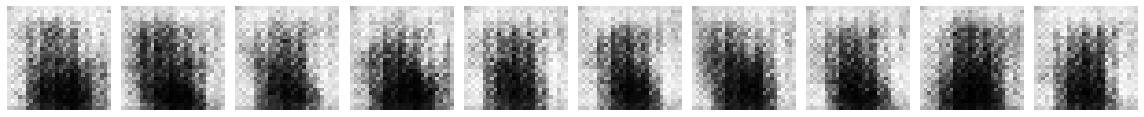

 10%|█         | 300/3000 [00:43<10:53,  4.13it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 301/3000 [00:43<09:23,  4.79it/s]

>301, dr[0.045,0.004], df[0.010,0.105], g[1.206,0.080]
1/1 [==============================] - 0s 13ms/step


 10%|█         | 302/3000 [00:43<08:15,  5.45it/s]

>302, dr[0.252,0.042], df[0.119,0.014], g[0.340,0.067]
1/1 [==============================] - 0s 17ms/step


 10%|█         | 303/3000 [00:43<07:45,  5.79it/s]

>303, dr[0.189,0.014], df[0.822,0.009], g[2.722,0.157]
1/1 [==============================] - 0s 16ms/step
>304, dr[0.710,0.008], df[0.096,0.066], g[1.372,0.050]


 10%|█         | 304/3000 [00:43<07:14,  6.20it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 305/3000 [00:44<06:53,  6.51it/s]

>305, dr[0.213,0.044], df[0.245,0.174], g[2.325,0.120]
1/1 [==============================] - 0s 19ms/step
>306, dr[0.148,0.043], df[0.053,0.089], g[1.601,0.157]


 10%|█         | 306/3000 [00:44<06:36,  6.80it/s]

1/1 [==============================] - 0s 14ms/step
>307, dr[0.221,0.134], df[0.501,0.098], g[3.504,0.100]


 10%|█         | 307/3000 [00:44<06:27,  6.95it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 308/3000 [00:44<06:14,  7.19it/s]

>308, dr[0.670,0.014], df[0.560,0.464], g[2.606,0.113]
1/1 [==============================] - 0s 13ms/step
>309, dr[0.423,0.021], df[0.437,0.080], g[2.940,0.069]


 10%|█         | 309/3000 [00:44<06:12,  7.22it/s]

1/1 [==============================] - 0s 15ms/step
>310, dr[0.481,0.048], df[0.317,0.062], g[2.364,0.035]


 10%|█         | 310/3000 [00:44<06:12,  7.23it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 311/3000 [00:44<06:09,  7.28it/s]

>311, dr[0.107,0.089], df[0.134,0.044], g[2.049,0.090]
1/1 [==============================] - 0s 17ms/step


 10%|█         | 312/3000 [00:45<06:05,  7.35it/s]

>312, dr[0.075,0.043], df[0.106,0.093], g[1.791,0.128]
1/1 [==============================] - 0s 20ms/step


 10%|█         | 313/3000 [00:45<06:11,  7.23it/s]

>313, dr[0.191,0.147], df[0.235,0.072], g[1.636,0.086]
1/1 [==============================] - 0s 19ms/step


 10%|█         | 314/3000 [00:45<06:10,  7.25it/s]

>314, dr[0.266,0.005], df[0.164,0.027], g[1.393,0.137]
1/1 [==============================] - 0s 13ms/step


 10%|█         | 315/3000 [00:45<06:09,  7.28it/s]

>315, dr[0.132,0.016], df[0.307,0.246], g[1.965,0.113]
1/1 [==============================] - 0s 16ms/step


 11%|█         | 316/3000 [00:45<06:22,  7.02it/s]

>316, dr[0.413,0.047], df[0.459,0.102], g[2.274,0.055]
1/1 [==============================] - 0s 14ms/step


 11%|█         | 317/3000 [00:45<06:19,  7.07it/s]

>317, dr[0.338,0.037], df[0.514,0.086], g[3.420,0.193]
1/1 [==============================] - 0s 18ms/step
>318, dr[1.291,0.033], df[0.575,0.030], g[1.850,0.102]


 11%|█         | 318/3000 [00:45<06:15,  7.14it/s]

1/1 [==============================] - 0s 14ms/step
>319, dr[0.181,0.030], df[0.164,0.147], g[2.838,0.163]


 11%|█         | 319/3000 [00:46<06:09,  7.26it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 320/3000 [00:46<06:07,  7.30it/s]

>320, dr[0.195,0.018], df[0.069,0.035], g[1.555,0.089]
1/1 [==============================] - 0s 21ms/step


 11%|█         | 321/3000 [00:46<06:14,  7.16it/s]

>321, dr[0.207,0.009], df[0.657,0.071], g[3.321,0.221]
1/1 [==============================] - 0s 19ms/step
>322, dr[0.623,0.117], df[0.199,0.047], g[2.048,0.093]


 11%|█         | 322/3000 [00:46<06:16,  7.10it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 323/3000 [00:46<06:11,  7.20it/s]

>323, dr[0.265,0.205], df[0.390,0.089], g[2.182,0.067]
1/1 [==============================] - 0s 13ms/step
>324, dr[0.264,0.004], df[0.282,0.074], g[2.861,0.134]


 11%|█         | 324/3000 [00:46<06:01,  7.40it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 325/3000 [00:46<06:03,  7.36it/s]

>325, dr[0.483,0.017], df[0.376,0.042], g[2.466,0.089]
1/1 [==============================] - 0s 18ms/step


 11%|█         | 326/3000 [00:47<06:08,  7.25it/s]

>326, dr[0.389,0.053], df[0.407,0.013], g[2.729,0.178]
1/1 [==============================] - 0s 17ms/step
>327, dr[0.311,0.004], df[0.073,0.055], g[2.632,0.045]


 11%|█         | 327/3000 [00:47<06:10,  7.22it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█         | 328/3000 [00:47<06:05,  7.31it/s]

>328, dr[0.319,0.050], df[0.525,0.076], g[2.815,0.054]
1/1 [==============================] - 0s 14ms/step
>329, dr[0.382,0.041], df[0.039,0.051], g[2.239,0.084]


 11%|█         | 329/3000 [00:47<06:07,  7.26it/s]

1/1 [==============================] - 0s 13ms/step
>330, dr[0.106,0.004], df[0.174,0.039], g[1.975,0.084]


 11%|█         | 330/3000 [00:47<06:04,  7.32it/s]

1/1 [==============================] - 0s 16ms/step
>331, dr[0.040,0.025], df[0.256,0.046], g[3.299,0.038]


 11%|█         | 331/3000 [00:47<06:03,  7.34it/s]

1/1 [==============================] - 0s 15ms/step
>332, dr[0.559,0.021], df[0.283,0.007], g[1.796,0.078]


 11%|█         | 332/3000 [00:47<06:09,  7.23it/s]

1/1 [==============================] - 0s 14ms/step


 11%|█         | 333/3000 [00:47<06:05,  7.29it/s]

>333, dr[0.110,0.025], df[0.154,0.060], g[2.333,0.096]
1/1 [==============================] - 0s 19ms/step
>334, dr[0.182,0.044], df[0.354,0.010], g[2.974,0.034]


 11%|█         | 334/3000 [00:48<06:09,  7.22it/s]

1/1 [==============================] - 0s 13ms/step
>335, dr[0.648,0.016], df[0.496,0.017], g[3.316,0.094]


 11%|█         | 335/3000 [00:48<06:00,  7.38it/s]

1/1 [==============================] - 0s 15ms/step
>336, dr[0.394,0.010], df[0.460,0.018], g[2.632,0.061]


 11%|█         | 336/3000 [00:48<05:52,  7.55it/s]

1/1 [==============================] - 0s 14ms/step
>337, dr[0.287,0.058], df[0.238,0.098], g[3.208,0.136]


 11%|█         | 337/3000 [00:48<05:49,  7.62it/s]

1/1 [==============================] - 0s 13ms/step


 11%|█▏        | 338/3000 [00:48<05:48,  7.64it/s]

>338, dr[0.570,0.017], df[0.269,0.055], g[1.668,0.240]
1/1 [==============================] - 0s 13ms/step
>339, dr[0.242,0.095], df[0.309,0.090], g[2.117,0.102]


 11%|█▏        | 339/3000 [00:48<06:01,  7.37it/s]

1/1 [==============================] - 0s 14ms/step
>340, dr[0.130,0.034], df[0.376,0.049], g[3.870,0.070]


 11%|█▏        | 340/3000 [00:48<05:58,  7.41it/s]

1/1 [==============================] - 0s 13ms/step
>341, dr[0.651,0.097], df[0.411,0.048], g[2.325,0.053]


 11%|█▏        | 341/3000 [00:49<06:02,  7.34it/s]

1/1 [==============================] - 0s 15ms/step
>342, dr[0.296,0.011], df[0.550,0.007], g[2.894,0.070]


 11%|█▏        | 342/3000 [00:49<05:59,  7.39it/s]

1/1 [==============================] - 0s 17ms/step
>343, dr[0.327,0.071], df[0.271,0.021], g[3.819,0.040]


 11%|█▏        | 343/3000 [00:49<05:57,  7.42it/s]

1/1 [==============================] - 0s 16ms/step
>344, dr[0.692,0.052], df[0.597,0.024], g[3.331,0.062]


 11%|█▏        | 344/3000 [00:49<06:02,  7.33it/s]

1/1 [==============================] - 0s 15ms/step
>345, dr[0.183,0.020], df[0.049,0.051], g[4.123,0.044]


 12%|█▏        | 345/3000 [00:49<05:59,  7.39it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 346/3000 [00:49<06:01,  7.34it/s]

>346, dr[0.388,0.034], df[0.512,0.016], g[5.228,0.087]
1/1 [==============================] - 0s 19ms/step
>347, dr[0.608,0.031], df[0.242,0.293], g[3.720,0.092]


 12%|█▏        | 347/3000 [00:49<06:01,  7.34it/s]

1/1 [==============================] - 0s 14ms/step


 12%|█▏        | 348/3000 [00:49<06:02,  7.33it/s]

>348, dr[0.643,0.218], df[0.742,0.029], g[2.654,0.121]
1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 349/3000 [00:50<06:02,  7.31it/s]

>349, dr[0.060,0.039], df[0.197,0.046], g[4.406,0.087]
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 350/3000 [00:50<06:03,  7.30it/s]

>350, dr[0.804,0.097], df[0.415,0.149], g[2.398,0.060]
1/1 [==============================] - 0s 20ms/step
>351, dr[0.199,0.061], df[0.526,0.145], g[3.521,0.070]


 12%|█▏        | 351/3000 [00:50<06:08,  7.19it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 352/3000 [00:50<06:08,  7.19it/s]

>352, dr[0.635,0.013], df[0.122,0.088], g[1.698,0.105]
1/1 [==============================] - 0s 18ms/step
>353, dr[0.096,0.088], df[0.365,0.010], g[2.154,0.071]


 12%|█▏        | 353/3000 [00:50<06:12,  7.11it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 354/3000 [00:50<06:10,  7.14it/s]

>354, dr[0.238,0.026], df[0.154,0.016], g[2.407,0.187]
1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 355/3000 [00:50<06:13,  7.08it/s]

>355, dr[0.161,0.135], df[0.142,0.060], g[2.290,0.045]
1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 356/3000 [00:51<06:06,  7.21it/s]

>356, dr[0.199,0.092], df[0.256,0.022], g[2.219,0.193]
1/1 [==============================] - 0s 15ms/step
>357, dr[0.502,0.017], df[0.599,0.026], g[2.654,0.106]


 12%|█▏        | 357/3000 [00:51<06:08,  7.17it/s]

1/1 [==============================] - 0s 14ms/step
>358, dr[0.302,0.046], df[0.151,0.014], g[3.164,0.080]


 12%|█▏        | 358/3000 [00:51<06:06,  7.21it/s]

1/1 [==============================] - 0s 13ms/step
>359, dr[0.417,0.286], df[0.416,0.180], g[3.106,0.069]


 12%|█▏        | 359/3000 [00:51<06:06,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 360/3000 [00:51<06:05,  7.23it/s]

>360, dr[0.589,0.031], df[0.535,0.138], g[3.883,0.068]
1/1 [==============================] - 0s 17ms/step
>361, dr[0.374,0.029], df[0.151,0.112], g[3.714,0.156]


 12%|█▏        | 361/3000 [00:51<06:05,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 362/3000 [00:51<06:07,  7.17it/s]

>362, dr[0.262,0.032], df[0.143,0.062], g[2.794,0.061]
1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 363/3000 [00:52<06:09,  7.13it/s]

>363, dr[0.327,0.097], df[0.589,0.052], g[3.808,0.117]
1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 364/3000 [00:52<06:11,  7.09it/s]

>364, dr[0.411,0.145], df[0.408,0.033], g[3.813,0.069]
1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 365/3000 [00:52<06:12,  7.08it/s]

>365, dr[0.350,0.024], df[0.121,0.027], g[2.635,0.111]
1/1 [==============================] - 0s 19ms/step
>366, dr[0.160,0.041], df[0.474,0.071], g[3.185,0.160]


 12%|█▏        | 366/3000 [00:52<06:11,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 367/3000 [00:52<06:07,  7.16it/s]

>367, dr[0.536,0.025], df[0.148,0.037], g[2.638,0.112]
1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 368/3000 [00:52<06:27,  6.79it/s]

>368, dr[0.260,0.089], df[0.666,0.059], g[3.836,0.053]
1/1 [==============================] - 0s 14ms/step


 12%|█▏        | 369/3000 [00:52<06:22,  6.87it/s]

>369, dr[1.018,0.395], df[0.264,0.037], g[2.625,0.081]
1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 370/3000 [00:53<06:21,  6.90it/s]

>370, dr[0.563,0.020], df[0.900,0.066], g[3.692,0.130]
1/1 [==============================] - 0s 19ms/step
>371, dr[0.403,0.036], df[0.185,0.064], g[3.374,0.077]


 12%|█▏        | 371/3000 [00:53<06:22,  6.87it/s]

1/1 [==============================] - 0s 15ms/step
>372, dr[0.632,0.020], df[0.292,0.026], g[2.365,0.121]


 12%|█▏        | 372/3000 [00:53<06:16,  6.99it/s]

1/1 [==============================] - 0s 13ms/step
>373, dr[0.279,0.050], df[0.603,0.145], g[3.031,0.105]


 12%|█▏        | 373/3000 [00:53<06:10,  7.09it/s]

1/1 [==============================] - 0s 15ms/step
>374, dr[0.444,0.023], df[0.341,0.097], g[3.269,0.129]


 12%|█▏        | 374/3000 [00:53<06:08,  7.12it/s]

1/1 [==============================] - 0s 16ms/step
>375, dr[0.473,0.036], df[0.488,0.069], g[3.110,0.146]


 12%|█▎        | 375/3000 [00:53<06:07,  7.14it/s]

1/1 [==============================] - 0s 16ms/step
>376, dr[0.734,0.028], df[0.903,0.050], g[2.300,0.171]


 13%|█▎        | 376/3000 [00:53<06:05,  7.17it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█▎        | 377/3000 [00:54<06:11,  7.07it/s]

>377, dr[0.417,0.100], df[0.480,0.044], g[2.696,0.145]
1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 378/3000 [00:54<06:03,  7.22it/s]

>378, dr[0.635,0.014], df[0.846,0.150], g[3.788,0.094]
1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 379/3000 [00:54<05:52,  7.43it/s]

>379, dr[0.889,0.039], df[0.536,0.113], g[2.491,0.130]
1/1 [==============================] - 0s 15ms/step
>380, dr[0.337,0.008], df[0.548,0.373], g[2.861,0.094]


 13%|█▎        | 380/3000 [00:54<05:59,  7.28it/s]

1/1 [==============================] - 0s 14ms/step
>381, dr[0.939,0.013], df[0.596,0.135], g[3.246,0.112]


 13%|█▎        | 381/3000 [00:54<05:58,  7.31it/s]

1/1 [==============================] - 0s 17ms/step
>382, dr[0.689,0.057], df[0.840,0.082], g[3.761,0.195]


 13%|█▎        | 382/3000 [00:54<05:57,  7.33it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█▎        | 383/3000 [00:54<05:57,  7.33it/s]

>383, dr[0.631,0.218], df[0.267,0.199], g[4.093,0.320]
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 384/3000 [00:55<06:01,  7.24it/s]

>384, dr[0.620,0.008], df[0.349,0.074], g[2.639,0.203]
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 385/3000 [00:55<06:02,  7.22it/s]

>385, dr[0.189,0.062], df[0.465,0.131], g[3.234,0.032]
1/1 [==============================] - 0s 20ms/step
>386, dr[0.580,0.013], df[0.287,0.071], g[3.252,0.256]


 13%|█▎        | 386/3000 [00:55<06:04,  7.18it/s]

1/1 [==============================] - 0s 14ms/step
>387, dr[0.211,0.020], df[0.572,0.071], g[3.220,0.171]


 13%|█▎        | 387/3000 [00:55<06:02,  7.20it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 388/3000 [00:55<06:00,  7.25it/s]

>388, dr[0.380,0.047], df[0.349,0.069], g[3.204,0.109]
1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 389/3000 [00:55<06:02,  7.19it/s]

>389, dr[1.057,0.018], df[1.758,0.265], g[2.851,0.170]
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 390/3000 [00:55<06:03,  7.18it/s]

>390, dr[0.824,0.047], df[0.518,0.219], g[3.302,0.136]
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 391/3000 [00:56<06:05,  7.14it/s]

>391, dr[0.568,0.021], df[0.719,0.130], g[3.174,0.461]
1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 392/3000 [00:56<06:12,  7.00it/s]

>392, dr[0.493,0.009], df[0.376,0.209], g[2.804,0.187]
1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 393/3000 [00:56<06:15,  6.95it/s]

>393, dr[0.681,0.006], df[0.666,0.042], g[2.254,0.133]
1/1 [==============================] - 0s 19ms/step
>394, dr[0.437,0.035], df[0.491,0.069], g[3.468,0.091]


 13%|█▎        | 394/3000 [00:56<06:13,  6.98it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█▎        | 395/3000 [00:56<06:05,  7.13it/s]

>395, dr[0.959,0.057], df[0.832,0.027], g[2.408,0.135]
1/1 [==============================] - 0s 17ms/step
>396, dr[0.432,0.016], df[0.521,0.066], g[2.626,0.024]

 13%|█▎        | 396/3000 [00:56<06:05,  7.13it/s]


1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 397/3000 [00:56<06:00,  7.23it/s]

>397, dr[0.503,0.034], df[0.953,0.050], g[3.094,0.098]
1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 398/3000 [00:57<06:06,  7.11it/s]

>398, dr[0.605,0.064], df[0.733,0.140], g[3.253,0.172]
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 399/3000 [00:57<06:11,  6.99it/s]

>399, dr[0.764,0.004], df[0.533,0.150], g[2.745,0.044]
1/1 [==============================] - 0s 18ms/step
>400, dr[0.525,0.006], df[0.613,0.021], g[2.221,0.118]
1/1 [==============================] - 0s 15ms/step


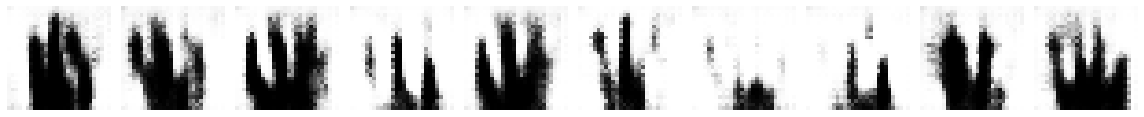

 13%|█▎        | 400/3000 [00:57<10:56,  3.96it/s]

1/1 [==============================] - 0s 14ms/step


 13%|█▎        | 401/3000 [00:57<09:29,  4.56it/s]

>401, dr[0.575,0.008], df[0.923,0.066], g[2.907,0.098]
1/1 [==============================] - 0s 14ms/step
>402, dr[0.656,0.049], df[0.603,0.039], g[3.091,0.132]


 13%|█▎        | 402/3000 [00:57<08:26,  5.13it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 403/3000 [00:58<07:39,  5.65it/s]

>403, dr[0.463,0.032], df[0.604,0.134], g[3.632,0.069]
1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 404/3000 [00:58<07:12,  6.01it/s]

>404, dr[0.817,0.065], df[0.591,0.150], g[2.348,0.090]
1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 405/3000 [00:58<06:52,  6.29it/s]

>405, dr[0.405,0.021], df[0.890,0.045], g[2.655,0.072]
1/1 [==============================] - 0s 16ms/step
>406, dr[1.151,0.092], df[1.007,0.083], g[2.866,0.126]


 14%|█▎        | 406/3000 [00:58<06:35,  6.56it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 407/3000 [00:58<06:22,  6.77it/s]

>407, dr[0.588,0.005], df[0.922,0.039], g[2.820,0.050]
1/1 [==============================] - 0s 17ms/step
>408, dr[1.036,0.095], df[0.654,0.028], g[1.770,0.047]


 14%|█▎        | 408/3000 [00:58<06:19,  6.82it/s]

1/1 [==============================] - 0s 14ms/step


 14%|█▎        | 409/3000 [00:58<06:12,  6.96it/s]

>409, dr[0.746,0.031], df[1.823,0.071], g[2.578,0.084]
1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 410/3000 [00:59<06:06,  7.07it/s]

>410, dr[0.596,0.047], df[0.368,0.054], g[2.676,0.075]
1/1 [==============================] - 0s 14ms/step


 14%|█▎        | 411/3000 [00:59<06:07,  7.05it/s]

>411, dr[1.091,0.007], df[0.883,0.064], g[2.655,0.116]
1/1 [==============================] - 0s 22ms/step


 14%|█▎        | 412/3000 [00:59<06:02,  7.13it/s]

>412, dr[0.405,0.054], df[0.358,0.216], g[3.049,0.045]
1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 413/3000 [00:59<06:03,  7.13it/s]

>413, dr[0.551,0.009], df[0.699,0.169], g[3.062,0.036]
1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 414/3000 [00:59<06:02,  7.13it/s]

>414, dr[0.963,0.067], df[0.580,0.035], g[2.646,0.037]
1/1 [==============================] - 0s 22ms/step
>415, dr[1.142,0.078], df[0.835,0.147], g[1.781,0.089]


 14%|█▍        | 415/3000 [00:59<06:03,  7.11it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 416/3000 [00:59<06:02,  7.13it/s]

>416, dr[0.329,0.009], df[0.443,0.118], g[3.047,0.034]
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 417/3000 [01:00<06:01,  7.14it/s]

>417, dr[0.622,0.042], df[0.613,0.089], g[2.199,0.038]
1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 418/3000 [01:00<06:07,  7.03it/s]

>418, dr[0.840,0.141], df[0.778,0.080], g[1.710,0.089]
1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 419/3000 [01:00<06:05,  7.06it/s]

>419, dr[0.632,0.018], df[0.875,0.094], g[2.643,0.272]
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 420/3000 [01:00<06:05,  7.06it/s]

>420, dr[0.958,0.019], df[0.786,0.086], g[2.747,0.159]
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 421/3000 [01:00<06:04,  7.07it/s]

>421, dr[0.903,0.022], df[0.822,0.047], g[2.697,0.065]
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 422/3000 [01:00<06:05,  7.05it/s]

>422, dr[0.705,0.040], df[0.571,0.060], g[2.308,0.115]
1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 423/3000 [01:00<05:59,  7.16it/s]

>423, dr[0.505,0.015], df[0.797,0.039], g[2.374,0.061]
1/1 [==============================] - 0s 18ms/step
>424, dr[0.822,0.031], df[0.541,0.108], g[2.357,0.079]


 14%|█▍        | 424/3000 [01:01<06:02,  7.12it/s]

1/1 [==============================] - 0s 14ms/step


 14%|█▍        | 425/3000 [01:01<05:58,  7.19it/s]

>425, dr[0.697,0.040], df[1.026,0.044], g[2.608,0.073]
1/1 [==============================] - 0s 13ms/step


 14%|█▍        | 426/3000 [01:01<06:02,  7.10it/s]

>426, dr[1.007,0.037], df[0.692,0.067], g[1.743,0.087]
1/1 [==============================] - 0s 17ms/step
>427, dr[0.377,0.054], df[0.828,0.217], g[2.908,0.169]


 14%|█▍        | 427/3000 [01:01<06:02,  7.11it/s]

1/1 [==============================] - 0s 13ms/step


 14%|█▍        | 428/3000 [01:01<05:57,  7.20it/s]

>428, dr[1.100,0.030], df[0.792,0.185], g[2.204,0.129]
1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 429/3000 [01:01<05:58,  7.16it/s]

>429, dr[0.779,0.025], df[0.980,0.142], g[2.359,0.140]
1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 430/3000 [01:01<05:58,  7.17it/s]

>430, dr[1.006,0.064], df[0.799,0.099], g[2.290,0.100]
1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 431/3000 [01:01<06:01,  7.11it/s]

>431, dr[0.671,0.063], df[0.773,0.036], g[2.346,0.100]
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 432/3000 [01:02<06:04,  7.04it/s]

>432, dr[1.242,0.101], df[1.063,0.347], g[1.824,0.020]
1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 433/3000 [01:02<06:08,  6.96it/s]

>433, dr[0.513,0.013], df[0.840,0.222], g[2.354,0.137]
1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 434/3000 [01:02<06:03,  7.07it/s]

>434, dr[0.942,0.174], df[0.713,0.087], g[1.764,0.110]
1/1 [==============================] - 0s 13ms/step
>435, dr[0.461,0.011], df[0.684,0.390], g[1.679,0.076]


 14%|█▍        | 435/3000 [01:02<05:59,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 436/3000 [01:02<06:01,  7.09it/s]

>436, dr[0.531,0.053], df[0.760,0.136], g[2.443,0.120]
1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 437/3000 [01:02<06:04,  7.04it/s]

>437, dr[0.697,0.090], df[0.876,0.195], g[2.100,0.174]
1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 438/3000 [01:02<06:02,  7.07it/s]

>438, dr[1.035,0.017], df[0.674,0.033], g[2.124,0.021]
1/1 [==============================] - 0s 21ms/step
>439, dr[1.248,0.121], df[1.288,0.100], g[1.472,0.121]


 15%|█▍        | 439/3000 [01:03<06:08,  6.96it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 440/3000 [01:03<06:03,  7.05it/s]

>440, dr[0.331,0.019], df[0.763,0.163], g[2.529,0.046]
1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 441/3000 [01:03<06:21,  6.71it/s]

>441, dr[1.355,0.064], df[0.962,0.076], g[2.055,0.169]
1/1 [==============================] - 0s 14ms/step


 15%|█▍        | 442/3000 [01:03<06:13,  6.84it/s]

>442, dr[0.675,0.007], df[1.095,0.039], g[2.176,0.184]
1/1 [==============================] - 0s 21ms/step
>443, dr[1.040,0.195], df[0.422,0.057], g[1.943,0.060]


 15%|█▍        | 443/3000 [01:03<06:08,  6.93it/s]

1/1 [==============================] - 0s 13ms/step
>444, dr[0.930,0.037], df[0.790,0.053], g[1.206,0.076]


 15%|█▍        | 444/3000 [01:03<06:02,  7.04it/s]

1/1 [==============================] - 0s 14ms/step
>445, dr[0.530,0.029], df[1.254,0.134], g[2.274,0.080]


 15%|█▍        | 445/3000 [01:03<05:58,  7.12it/s]

1/1 [==============================] - 0s 13ms/step


 15%|█▍        | 446/3000 [01:04<05:57,  7.13it/s]

>446, dr[0.906,0.015], df[0.619,0.207], g[2.100,0.112]
1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 447/3000 [01:04<06:10,  6.88it/s]

>447, dr[0.892,0.144], df[0.463,0.027], g[1.688,0.038]
1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 448/3000 [01:04<06:05,  6.99it/s]

>448, dr[0.655,0.048], df[1.072,0.043], g[1.349,0.056]
1/1 [==============================] - 0s 17ms/step
>449, dr[0.476,0.144], df[0.880,0.138], g[2.390,0.131]


 15%|█▍        | 449/3000 [01:04<06:03,  7.02it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▌        | 450/3000 [01:04<05:55,  7.17it/s]

>450, dr[0.774,0.074], df[0.814,0.185], g[2.371,0.090]
1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 451/3000 [01:04<05:54,  7.19it/s]

>451, dr[0.989,0.024], df[0.515,0.039], g[1.924,0.199]
1/1 [==============================] - 0s 17ms/step
>452, dr[0.875,0.047], df[1.003,0.147], g[1.486,0.199]


 15%|█▌        | 452/3000 [01:04<06:01,  7.05it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 453/3000 [01:05<05:57,  7.12it/s]

>453, dr[0.640,0.032], df[0.716,0.381], g[1.853,0.203]
1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 454/3000 [01:05<06:01,  7.04it/s]

>454, dr[0.651,0.004], df[0.735,0.178], g[1.623,0.098]
1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 455/3000 [01:05<06:00,  7.06it/s]

>455, dr[0.665,0.048], df[0.694,0.313], g[1.807,0.116]
1/1 [==============================] - 0s 18ms/step
>456, dr[0.870,0.032], df[0.832,0.062], g[1.837,0.110]


 15%|█▌        | 456/3000 [01:05<05:58,  7.09it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 457/3000 [01:05<05:54,  7.18it/s]

>457, dr[1.088,0.160], df[0.975,0.093], g[1.536,0.066]
1/1 [==============================] - 0s 18ms/step
>458, dr[0.522,0.019], df[0.724,0.070], g[1.924,0.077]


 15%|█▌        | 458/3000 [01:05<05:55,  7.16it/s]

1/1 [==============================] - 0s 15ms/step
>459, dr[0.868,0.047], df[0.780,0.201], g[2.240,0.127]


 15%|█▌        | 459/3000 [01:05<05:51,  7.22it/s]

1/1 [==============================] - 0s 13ms/step
>460, dr[0.917,0.037], df[0.660,0.116], g[2.175,0.057]


 15%|█▌        | 460/3000 [01:06<05:48,  7.29it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 461/3000 [01:06<05:49,  7.26it/s]

>461, dr[0.835,0.058], df[0.903,0.060], g[1.687,0.119]
1/1 [==============================] - 0s 14ms/step


 15%|█▌        | 462/3000 [01:06<05:55,  7.14it/s]

>462, dr[0.289,0.054], df[0.713,0.075], g[2.180,0.107]
1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 463/3000 [01:08<28:47,  1.47it/s]

>463, dr[1.242,0.020], df[0.832,0.275], g[2.253,0.107]
1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 464/3000 [01:08<21:52,  1.93it/s]

>464, dr[0.575,0.002], df[0.413,0.140], g[1.837,0.133]
1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 465/3000 [01:08<17:04,  2.47it/s]

>465, dr[1.131,0.048], df[0.765,0.147], g[1.592,0.060]
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 466/3000 [01:08<13:49,  3.05it/s]

>466, dr[0.445,0.030], df[0.554,0.042], g[1.649,0.100]
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 467/3000 [01:08<11:28,  3.68it/s]

>467, dr[0.617,0.012], df[0.567,0.159], g[1.714,0.074]
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 468/3000 [01:09<09:43,  4.34it/s]

>468, dr[0.686,0.007], df[0.796,0.103], g[1.853,0.106]
1/1 [==============================] - 0s 14ms/step
>469, dr[0.903,0.019], df[1.055,0.099], g[2.274,0.054]


 16%|█▌        | 469/3000 [01:09<08:31,  4.95it/s]

1/1 [==============================] - 0s 15ms/step
>470, dr[0.836,0.014], df[0.595,0.498], g[2.344,0.092]


 16%|█▌        | 470/3000 [01:09<07:45,  5.43it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 471/3000 [01:09<07:11,  5.86it/s]

>471, dr[0.866,0.044], df[1.033,0.282], g[2.384,0.069]
1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 472/3000 [01:09<06:48,  6.19it/s]

>472, dr[0.930,0.044], df[0.656,0.100], g[1.981,0.089]
1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 473/3000 [01:09<06:27,  6.53it/s]

>473, dr[0.775,0.045], df[0.885,0.351], g[1.811,0.108]
1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 474/3000 [01:09<06:09,  6.84it/s]

>474, dr[0.958,0.066], df[0.582,0.034], g[1.707,0.108]
1/1 [==============================] - 0s 13ms/step


 16%|█▌        | 475/3000 [01:09<06:02,  6.96it/s]

>475, dr[0.527,0.009], df[0.664,0.139], g[1.855,0.067]
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 476/3000 [01:10<06:00,  7.00it/s]

>476, dr[1.054,0.039], df[0.831,0.178], g[1.671,0.104]
1/1 [==============================] - 0s 19ms/step
>477, dr[0.847,0.090], df[0.882,0.236], g[1.533,0.272]


 16%|█▌        | 477/3000 [01:10<05:59,  7.01it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 478/3000 [01:10<06:13,  6.75it/s]

>478, dr[0.508,0.030], df[0.563,0.109], g[1.507,0.142]
1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 479/3000 [01:10<06:27,  6.50it/s]

>479, dr[0.945,0.029], df[0.975,0.229], g[1.572,0.139]
1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 480/3000 [01:10<06:16,  6.69it/s]

>480, dr[0.769,0.027], df[0.594,0.040], g[1.678,0.129]
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 481/3000 [01:10<06:13,  6.74it/s]

>481, dr[0.633,0.095], df[0.883,0.301], g[2.036,0.130]
1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 482/3000 [01:11<06:06,  6.87it/s]

>482, dr[0.908,0.284], df[0.594,0.133], g[1.745,0.141]
1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 483/3000 [01:11<06:02,  6.94it/s]

>483, dr[0.483,0.046], df[0.862,0.334], g[1.828,0.104]
1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 484/3000 [01:11<06:02,  6.95it/s]

>484, dr[0.589,0.069], df[0.537,0.077], g[1.534,0.150]
1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 485/3000 [01:11<06:06,  6.86it/s]

>485, dr[0.744,0.008], df[0.647,0.249], g[1.381,0.096]
1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 486/3000 [01:11<06:11,  6.76it/s]

>486, dr[0.501,0.033], df[0.575,0.133], g[1.837,0.140]
1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 487/3000 [01:11<06:08,  6.82it/s]

>487, dr[0.673,0.038], df[0.633,0.005], g[1.476,0.054]
1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 488/3000 [01:11<06:06,  6.85it/s]

>488, dr[0.487,0.021], df[0.611,0.184], g[1.733,0.210]
1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 489/3000 [01:12<05:58,  7.00it/s]

>489, dr[0.715,0.015], df[0.374,0.268], g[1.500,0.079]
1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 490/3000 [01:12<06:00,  6.96it/s]

>490, dr[0.357,0.048], df[0.950,0.185], g[1.807,0.139]
1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 491/3000 [01:12<05:57,  7.03it/s]

>491, dr[0.586,0.027], df[0.574,0.062], g[2.271,0.202]
1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 492/3000 [01:12<06:03,  6.91it/s]

>492, dr[0.733,0.050], df[0.525,0.084], g[1.472,0.120]
1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 493/3000 [01:12<05:57,  7.02it/s]

>493, dr[0.712,0.051], df[0.951,0.334], g[1.456,0.044]
1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 494/3000 [01:12<05:54,  7.06it/s]

>494, dr[0.684,0.049], df[0.844,0.080], g[1.847,0.172]
1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 495/3000 [01:12<05:52,  7.11it/s]

>495, dr[1.079,0.170], df[1.064,0.152], g[1.857,0.064]
1/1 [==============================] - 0s 16ms/step
>496, dr[1.024,0.099], df[0.804,0.041], g[1.790,0.130]


 17%|█▋        | 496/3000 [01:13<05:53,  7.09it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 497/3000 [01:13<05:45,  7.24it/s]

>497, dr[0.816,0.038], df[0.812,0.049], g[1.792,0.155]
1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 498/3000 [01:13<05:47,  7.19it/s]

>498, dr[0.692,0.020], df[0.581,0.119], g[1.822,0.180]
1/1 [==============================] - 0s 20ms/step
>499, dr[0.712,0.103], df[0.504,0.026], g[1.495,0.088]


 17%|█▋        | 499/3000 [01:13<05:51,  7.12it/s]

1/1 [==============================] - 0s 15ms/step
>500, dr[0.605,0.019], df[0.824,0.012], g[1.636,0.145]
1/1 [==============================] - 0s 15ms/step


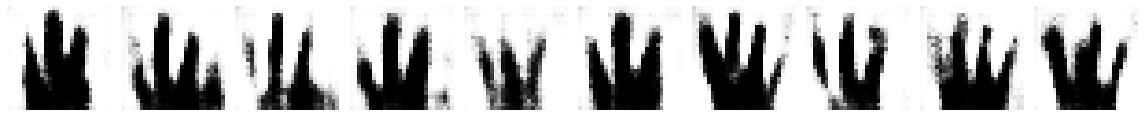

 17%|█▋        | 500/3000 [01:13<10:11,  4.09it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 501/3000 [01:14<08:54,  4.68it/s]

>501, dr[0.619,0.067], df[0.672,0.110], g[1.868,0.034]
1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 502/3000 [01:14<08:07,  5.12it/s]

>502, dr[0.847,0.035], df[1.199,0.034], g[1.879,0.110]
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 503/3000 [01:14<07:28,  5.57it/s]

>503, dr[0.682,0.038], df[0.380,0.055], g[2.016,0.096]
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 504/3000 [01:14<07:04,  5.88it/s]

>504, dr[0.687,0.040], df[0.386,0.127], g[1.449,0.108]
1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 505/3000 [01:14<06:43,  6.18it/s]

>505, dr[0.894,0.015], df[0.982,0.076], g[1.106,0.046]
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 506/3000 [01:14<06:28,  6.42it/s]

>506, dr[0.641,0.018], df[0.739,0.033], g[1.627,0.019]
1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 507/3000 [01:14<06:15,  6.64it/s]

>507, dr[0.579,0.016], df[0.378,0.053], g[1.541,0.021]
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 508/3000 [01:15<06:06,  6.80it/s]

>508, dr[0.773,0.003], df[0.793,0.069], g[1.525,0.007]
1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 509/3000 [01:15<06:05,  6.82it/s]

>509, dr[0.532,0.004], df[0.657,0.035], g[1.403,0.090]
1/1 [==============================] - 0s 22ms/step
>510, dr[0.530,0.043], df[0.478,0.093], g[1.205,0.089]


 17%|█▋        | 510/3000 [01:15<06:02,  6.86it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 511/3000 [01:15<06:08,  6.76it/s]

>511, dr[0.705,0.172], df[0.595,0.052], g[1.182,0.078]
1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 512/3000 [01:15<06:04,  6.82it/s]

>512, dr[0.426,0.013], df[0.888,0.234], g[1.568,0.041]
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 513/3000 [01:15<06:02,  6.86it/s]

>513, dr[0.555,0.045], df[0.462,0.107], g[1.912,0.055]
1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 514/3000 [01:15<05:57,  6.96it/s]

>514, dr[1.032,0.014], df[0.626,0.066], g[1.315,0.074]
1/1 [==============================] - 0s 19ms/step
>515, dr[0.606,0.046], df[1.108,0.111], g[1.620,0.095]


 17%|█▋        | 515/3000 [01:16<05:55,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 516/3000 [01:16<05:57,  6.94it/s]

>516, dr[0.876,0.143], df[0.913,0.059], g[1.659,0.052]
1/1 [==============================] - 0s 16ms/step
>517, dr[1.017,0.016], df[1.092,0.041], g[1.588,0.097]


 17%|█▋        | 517/3000 [01:16<05:56,  6.96it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 518/3000 [01:16<05:49,  7.11it/s]

>518, dr[0.673,0.032], df[0.991,0.058], g[2.032,0.053]
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 519/3000 [01:16<05:46,  7.16it/s]

>519, dr[0.924,0.022], df[0.634,0.038], g[1.725,0.097]
1/1 [==============================] - 0s 15ms/step
>520, dr[0.755,0.108], df[0.746,0.082], g[1.937,0.276]


 17%|█▋        | 520/3000 [01:16<05:48,  7.12it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 521/3000 [01:16<05:48,  7.12it/s]

>521, dr[0.643,0.091], df[0.589,0.276], g[1.873,0.139]
1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 522/3000 [01:17<05:49,  7.10it/s]

>522, dr[0.880,0.123], df[0.660,0.024], g[1.779,0.138]
1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 523/3000 [01:17<05:51,  7.05it/s]

>523, dr[0.896,0.053], df[0.963,0.134], g[1.518,0.153]
1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 524/3000 [01:17<05:57,  6.92it/s]

>524, dr[0.634,0.049], df[0.875,0.069], g[1.916,0.167]
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 525/3000 [01:17<05:56,  6.94it/s]

>525, dr[0.729,0.112], df[0.532,0.050], g[1.646,0.076]
1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 526/3000 [01:17<05:54,  6.98it/s]

>526, dr[0.975,0.051], df[0.786,0.061], g[1.247,0.084]
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 527/3000 [01:17<05:53,  7.00it/s]

>527, dr[0.595,0.036], df[0.808,0.169], g[1.733,0.079]
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 528/3000 [01:17<05:51,  7.03it/s]

>528, dr[1.065,0.090], df[0.621,0.043], g[1.670,0.163]
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 529/3000 [01:18<05:48,  7.09it/s]

>529, dr[0.328,0.011], df[0.639,0.062], g[1.790,0.094]
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 530/3000 [01:18<05:45,  7.16it/s]

>530, dr[0.668,0.003], df[0.540,0.210], g[1.786,0.081]
1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 531/3000 [01:18<05:45,  7.15it/s]

>531, dr[0.730,0.025], df[0.864,0.040], g[1.536,0.057]
1/1 [==============================] - 0s 17ms/step
>532, dr[0.685,0.005], df[0.604,0.157], g[2.004,0.152]


 18%|█▊        | 532/3000 [01:18<05:44,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 533/3000 [01:18<05:48,  7.08it/s]

>533, dr[0.625,0.005], df[0.763,0.096], g[1.508,0.068]
1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 534/3000 [01:18<05:45,  7.13it/s]

>534, dr[0.775,0.057], df[0.436,0.059], g[1.480,0.019]
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 535/3000 [01:18<05:45,  7.14it/s]

>535, dr[0.876,0.023], df[1.252,0.094], g[1.624,0.039]
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 536/3000 [01:19<05:41,  7.22it/s]

>536, dr[0.634,0.004], df[0.671,0.147], g[1.718,0.206]
1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 537/3000 [01:19<05:43,  7.17it/s]

>537, dr[0.731,0.024], df[0.804,0.018], g[1.910,0.116]
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 538/3000 [01:19<05:45,  7.12it/s]

>538, dr[0.779,0.009], df[0.619,0.064], g[1.516,0.177]
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 539/3000 [01:19<05:44,  7.14it/s]

>539, dr[0.715,0.041], df[0.851,0.049], g[1.331,0.066]
1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 540/3000 [01:19<05:52,  6.99it/s]

>540, dr[0.520,0.006], df[0.741,0.100], g[1.830,0.037]
1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 541/3000 [01:19<05:46,  7.09it/s]

>541, dr[0.948,0.079], df[0.854,0.107], g[1.827,0.057]
1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 542/3000 [01:19<05:43,  7.16it/s]

>542, dr[0.598,0.072], df[0.851,0.068], g[2.182,0.175]
1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 543/3000 [01:20<05:42,  7.18it/s]

>543, dr[0.993,0.027], df[0.757,0.115], g[1.844,0.026]
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 544/3000 [01:20<05:41,  7.19it/s]

>544, dr[0.622,0.011], df[0.588,0.085], g[1.847,0.109]
1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 545/3000 [01:20<06:14,  6.56it/s]

>545, dr[0.811,0.051], df[0.945,0.036], g[1.777,0.016]
1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 546/3000 [01:20<06:10,  6.62it/s]

>546, dr[0.799,0.007], df[0.782,0.100], g[1.612,0.028]
1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 547/3000 [01:20<06:16,  6.51it/s]

>547, dr[0.613,0.024], df[0.601,0.063], g[2.166,0.043]
1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 548/3000 [01:20<06:08,  6.65it/s]

>548, dr[0.748,0.046], df[0.427,0.141], g[1.687,0.205]
1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 549/3000 [01:20<06:01,  6.78it/s]

>549, dr[0.761,0.082], df[1.069,0.212], g[1.851,0.070]
1/1 [==============================] - 0s 18ms/step
>550, dr[0.816,0.029], df[0.616,0.192], g[1.530,0.154]


 18%|█▊        | 550/3000 [01:21<06:05,  6.70it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 551/3000 [01:21<05:52,  6.95it/s]

>551, dr[0.647,0.010], df[0.873,0.171], g[2.089,0.079]
1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 552/3000 [01:21<05:49,  7.00it/s]

>552, dr[0.503,0.025], df[0.467,0.069], g[1.815,0.086]
1/1 [==============================] - 0s 20ms/step
>553, dr[0.837,0.033], df[0.743,0.015], g[1.552,0.153]


 18%|█▊        | 553/3000 [01:21<05:49,  7.00it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 554/3000 [01:21<05:55,  6.89it/s]

>554, dr[0.596,0.028], df[0.824,0.203], g[1.538,0.034]
1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 555/3000 [01:21<05:55,  6.89it/s]

>555, dr[0.646,0.023], df[0.656,0.165], g[1.770,0.100]
1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 556/3000 [01:21<05:50,  6.97it/s]

>556, dr[0.644,0.036], df[0.736,0.041], g[1.798,0.050]
1/1 [==============================] - 0s 17ms/step
>557, dr[0.624,0.014], df[0.639,0.019], g[2.021,0.109]


 19%|█▊        | 557/3000 [01:22<05:46,  7.04it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 558/3000 [01:22<05:39,  7.19it/s]

>558, dr[0.871,0.018], df[0.496,0.090], g[1.417,0.047]
1/1 [==============================] - 0s 15ms/step
>559, dr[1.004,0.010], df[1.001,0.067], g[1.469,0.068]


 19%|█▊        | 559/3000 [01:22<05:37,  7.24it/s]

1/1 [==============================] - 0s 14ms/step
>560, dr[0.777,0.141], df[0.602,0.114], g[1.659,0.020]


 19%|█▊        | 560/3000 [01:22<05:33,  7.31it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▊        | 561/3000 [01:22<05:40,  7.16it/s]

>561, dr[0.340,0.028], df[0.533,0.071], g[2.192,0.058]
1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 562/3000 [01:22<05:46,  7.03it/s]

>562, dr[1.089,0.007], df[0.511,0.139], g[1.270,0.161]
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 563/3000 [01:22<05:46,  7.03it/s]

>563, dr[0.469,0.011], df[0.907,0.061], g[1.443,0.050]
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 564/3000 [01:23<05:55,  6.85it/s]

>564, dr[0.400,0.034], df[0.771,0.167], g[2.280,0.115]
1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 565/3000 [01:23<05:49,  6.96it/s]

>565, dr[0.967,0.020], df[0.501,0.124], g[1.908,0.061]
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 566/3000 [01:23<05:44,  7.06it/s]

>566, dr[0.822,0.049], df[0.997,0.086], g[1.583,0.053]
1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 567/3000 [01:23<05:44,  7.07it/s]

>567, dr[0.641,0.075], df[1.020,0.108], g[1.869,0.139]
1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 568/3000 [01:23<05:45,  7.03it/s]

>568, dr[0.598,0.027], df[0.710,0.070], g[1.977,0.071]
1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 569/3000 [01:23<05:53,  6.89it/s]

>569, dr[0.949,0.057], df[0.652,0.040], g[1.679,0.095]
1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 570/3000 [01:23<05:48,  6.97it/s]

>570, dr[0.714,0.161], df[0.775,0.058], g[1.274,0.074]
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 571/3000 [01:24<05:46,  7.01it/s]

>571, dr[0.608,0.015], df[0.752,0.091], g[1.184,0.024]
1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 572/3000 [01:24<05:44,  7.05it/s]

>572, dr[0.827,0.023], df[0.758,0.030], g[1.499,0.104]
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 573/3000 [01:24<05:39,  7.14it/s]

>573, dr[0.570,0.037], df[0.614,0.050], g[1.648,0.109]
1/1 [==============================] - 0s 14ms/step
>574, dr[0.830,0.035], df[0.800,0.154], g[1.586,0.037]


 19%|█▉        | 574/3000 [01:24<05:36,  7.21it/s]

1/1 [==============================] - 0s 15ms/step
>575, dr[0.640,0.005], df[0.629,0.044], g[1.827,0.172]


 19%|█▉        | 575/3000 [01:24<05:35,  7.23it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 576/3000 [01:24<05:34,  7.25it/s]

>576, dr[0.913,0.006], df[0.575,0.095], g[1.159,0.120]
1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 577/3000 [01:24<05:39,  7.13it/s]

>577, dr[0.557,0.007], df[0.876,0.021], g[1.468,0.051]
1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 578/3000 [01:25<05:44,  7.03it/s]

>578, dr[0.821,0.087], df[0.613,0.007], g[1.221,0.062]
1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 579/3000 [01:25<05:55,  6.81it/s]

>579, dr[0.585,0.006], df[0.581,0.192], g[1.275,0.104]
1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 580/3000 [01:25<05:54,  6.83it/s]

>580, dr[0.535,0.009], df[0.691,0.062], g[1.321,0.044]
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 581/3000 [01:25<05:50,  6.91it/s]

>581, dr[0.779,0.011], df[0.489,0.019], g[1.449,0.067]
1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 582/3000 [01:25<05:46,  6.97it/s]

>582, dr[0.619,0.023], df[0.816,0.042], g[1.442,0.132]
1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 583/3000 [01:25<05:48,  6.94it/s]

>583, dr[0.421,0.006], df[0.725,0.065], g[1.674,0.027]
1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 584/3000 [01:25<05:47,  6.95it/s]

>584, dr[0.581,0.026], df[0.729,0.009], g[1.948,0.023]
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 585/3000 [01:26<05:46,  6.96it/s]

>585, dr[1.017,0.013], df[0.687,0.063], g[1.585,0.099]
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 586/3000 [01:26<05:49,  6.91it/s]

>586, dr[0.677,0.009], df[0.801,0.072], g[1.432,0.114]
1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 587/3000 [01:26<05:48,  6.93it/s]

>587, dr[0.955,0.065], df[0.661,0.060], g[1.409,0.126]
1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 588/3000 [01:26<05:42,  7.03it/s]

>588, dr[0.640,0.019], df[1.023,0.129], g[1.820,0.056]
1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 589/3000 [01:26<05:42,  7.03it/s]

>589, dr[0.778,0.189], df[0.712,0.016], g[1.917,0.026]
1/1 [==============================] - 0s 21ms/step
>590, dr[0.836,0.009], df[0.459,0.026], g[1.904,0.027]


 20%|█▉        | 590/3000 [01:26<05:42,  7.04it/s]

1/1 [==============================] - 0s 15ms/step
>591, dr[0.586,0.004], df[0.651,0.008], g[1.666,0.178]


 20%|█▉        | 591/3000 [01:26<05:41,  7.06it/s]

1/1 [==============================] - 0s 14ms/step


 20%|█▉        | 592/3000 [01:27<05:38,  7.12it/s]

>592, dr[0.531,0.042], df[0.914,0.165], g[1.930,0.119]
1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 593/3000 [01:27<05:36,  7.14it/s]

>593, dr[0.724,0.014], df[0.484,0.023], g[1.843,0.022]
1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 594/3000 [01:27<05:39,  7.09it/s]

>594, dr[0.590,0.005], df[0.528,0.035], g[2.208,0.021]
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 595/3000 [01:27<05:41,  7.04it/s]

>595, dr[0.912,0.056], df[0.505,0.022], g[1.333,0.043]
1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 596/3000 [01:27<05:49,  6.89it/s]

>596, dr[0.760,0.027], df[0.822,0.017], g[1.503,0.075]
1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 597/3000 [01:27<05:45,  6.95it/s]

>597, dr[0.351,0.022], df[0.980,0.032], g[1.858,0.077]
1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 598/3000 [01:27<05:48,  6.89it/s]

>598, dr[0.792,0.031], df[0.546,0.020], g[1.992,0.032]
1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 599/3000 [01:28<05:56,  6.74it/s]

>599, dr[0.881,0.057], df[0.741,0.048], g[2.066,0.022]
1/1 [==============================] - 0s 14ms/step
>600, dr[0.662,0.010], df[0.460,0.009], g[1.466,0.089]
1/1 [==============================] - 0s 15ms/step


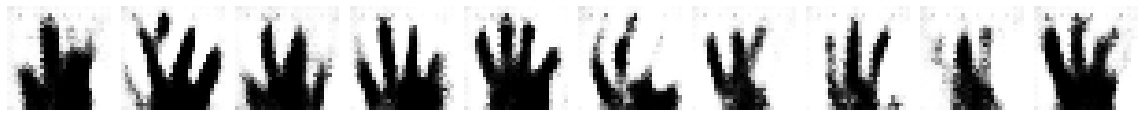

 20%|██        | 600/3000 [01:28<10:12,  3.92it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 601/3000 [01:28<08:57,  4.47it/s]

>601, dr[0.475,0.041], df[0.634,0.020], g[1.593,0.035]
1/1 [==============================] - 0s 15ms/step


 20%|██        | 602/3000 [01:28<08:02,  4.97it/s]

>602, dr[0.543,0.049], df[0.637,0.056], g[1.915,0.024]
1/1 [==============================] - 0s 19ms/step


 20%|██        | 603/3000 [01:29<07:20,  5.44it/s]

>603, dr[0.893,0.028], df[0.666,0.037], g[1.385,0.051]
1/1 [==============================] - 0s 20ms/step


 20%|██        | 604/3000 [01:29<06:50,  5.84it/s]

>604, dr[0.782,0.050], df[0.773,0.199], g[1.073,0.024]
1/1 [==============================] - 0s 19ms/step


 20%|██        | 605/3000 [01:29<06:28,  6.16it/s]

>605, dr[0.574,0.014], df[0.871,0.057], g[1.572,0.032]
1/1 [==============================] - 0s 20ms/step


 20%|██        | 606/3000 [01:29<06:09,  6.48it/s]

>606, dr[0.599,0.025], df[0.645,0.045], g[1.718,0.023]
1/1 [==============================] - 0s 15ms/step


 20%|██        | 607/3000 [01:29<05:59,  6.65it/s]

>607, dr[0.378,0.021], df[0.645,0.021], g[2.084,0.119]
1/1 [==============================] - 0s 23ms/step


 20%|██        | 608/3000 [01:29<06:01,  6.62it/s]

>608, dr[1.022,0.052], df[0.607,0.038], g[2.012,0.094]
1/1 [==============================] - 0s 24ms/step


 20%|██        | 609/3000 [01:29<05:57,  6.69it/s]

>609, dr[0.929,0.055], df[0.656,0.036], g[1.394,0.066]
1/1 [==============================] - 0s 19ms/step


 20%|██        | 610/3000 [01:30<05:52,  6.78it/s]

>610, dr[0.712,0.010], df[0.641,0.083], g[1.222,0.072]
1/1 [==============================] - 0s 18ms/step


 20%|██        | 611/3000 [01:30<05:47,  6.88it/s]

>611, dr[0.542,0.050], df[0.916,0.009], g[1.559,0.120]
1/1 [==============================] - 0s 29ms/step


 20%|██        | 612/3000 [01:30<05:52,  6.78it/s]

>612, dr[0.587,0.010], df[0.484,0.044], g[1.707,0.041]
1/1 [==============================] - 0s 16ms/step


 20%|██        | 613/3000 [01:30<05:55,  6.71it/s]

>613, dr[0.818,0.011], df[0.532,0.015], g[1.369,0.035]
1/1 [==============================] - 0s 22ms/step


 20%|██        | 614/3000 [01:30<05:58,  6.65it/s]

>614, dr[0.574,0.046], df[0.822,0.034], g[1.407,0.034]
1/1 [==============================] - 0s 16ms/step


 20%|██        | 615/3000 [01:30<05:55,  6.71it/s]

>615, dr[0.756,0.089], df[0.818,0.035], g[2.263,0.027]
1/1 [==============================] - 0s 25ms/step


 21%|██        | 616/3000 [01:30<05:55,  6.71it/s]

>616, dr[1.043,0.054], df[0.704,0.080], g[1.173,0.065]
1/1 [==============================] - 0s 20ms/step


 21%|██        | 617/3000 [01:31<05:48,  6.84it/s]

>617, dr[0.438,0.011], df[0.786,0.127], g[1.407,0.011]
1/1 [==============================] - 0s 19ms/step


 21%|██        | 618/3000 [01:31<05:47,  6.86it/s]

>618, dr[0.518,0.030], df[0.493,0.073], g[1.534,0.099]
1/1 [==============================] - 0s 23ms/step


 21%|██        | 619/3000 [01:31<05:42,  6.95it/s]

>619, dr[0.982,0.034], df[0.820,0.006], g[1.383,0.072]
1/1 [==============================] - 0s 22ms/step


 21%|██        | 620/3000 [01:31<05:43,  6.92it/s]

>620, dr[0.542,0.053], df[0.967,0.027], g[2.192,0.120]
1/1 [==============================] - 0s 17ms/step


 21%|██        | 621/3000 [01:31<05:50,  6.79it/s]

>621, dr[1.050,0.006], df[0.454,0.057], g[1.642,0.105]
1/1 [==============================] - 0s 15ms/step


 21%|██        | 622/3000 [01:31<05:56,  6.66it/s]

>622, dr[0.843,0.007], df[0.683,0.022], g[1.302,0.099]
1/1 [==============================] - 0s 19ms/step


 21%|██        | 623/3000 [01:31<05:53,  6.72it/s]

>623, dr[0.567,0.007], df[1.000,0.015], g[1.728,0.114]
1/1 [==============================] - 0s 16ms/step


 21%|██        | 624/3000 [01:32<05:50,  6.77it/s]

>624, dr[0.560,0.008], df[0.667,0.110], g[1.938,0.116]
1/1 [==============================] - 0s 21ms/step


 21%|██        | 625/3000 [01:32<05:47,  6.84it/s]

>625, dr[0.879,0.009], df[0.584,0.020], g[1.634,0.109]
1/1 [==============================] - 0s 24ms/step


 21%|██        | 626/3000 [01:32<05:43,  6.90it/s]

>626, dr[0.773,0.042], df[0.870,0.030], g[1.534,0.056]
1/1 [==============================] - 0s 20ms/step


 21%|██        | 627/3000 [01:32<05:43,  6.90it/s]

>627, dr[0.708,0.019], df[0.734,0.075], g[1.746,0.057]
1/1 [==============================] - 0s 21ms/step


 21%|██        | 628/3000 [01:32<05:44,  6.89it/s]

>628, dr[0.824,0.067], df[0.509,0.012], g[1.700,0.011]
1/1 [==============================] - 0s 20ms/step


 21%|██        | 629/3000 [01:32<05:40,  6.97it/s]

>629, dr[0.787,0.024], df[0.699,0.098], g[1.464,0.049]
1/1 [==============================] - 0s 19ms/step


 21%|██        | 630/3000 [01:32<05:43,  6.90it/s]

>630, dr[0.720,0.006], df[0.851,0.129], g[1.559,0.056]
1/1 [==============================] - 0s 17ms/step


 21%|██        | 631/3000 [01:33<05:47,  6.82it/s]

>631, dr[0.798,0.007], df[0.560,0.064], g[1.270,0.033]
1/1 [==============================] - 0s 17ms/step


 21%|██        | 632/3000 [01:33<05:45,  6.85it/s]

>632, dr[0.958,0.110], df[1.044,0.135], g[1.058,0.039]
1/1 [==============================] - 0s 20ms/step


 21%|██        | 633/3000 [01:33<05:44,  6.88it/s]

>633, dr[0.656,0.027], df[0.936,0.029], g[1.554,0.209]
1/1 [==============================] - 0s 19ms/step


 21%|██        | 634/3000 [01:33<05:42,  6.90it/s]

>634, dr[0.649,0.074], df[0.711,0.251], g[1.905,0.077]
1/1 [==============================] - 0s 19ms/step


 21%|██        | 635/3000 [01:33<05:36,  7.03it/s]

>635, dr[0.964,0.013], df[0.652,0.165], g[1.482,0.086]
1/1 [==============================] - 0s 21ms/step


 21%|██        | 636/3000 [01:33<05:37,  7.00it/s]

>636, dr[0.565,0.002], df[0.669,0.038], g[1.569,0.140]
1/1 [==============================] - 0s 20ms/step


 21%|██        | 637/3000 [01:33<05:47,  6.80it/s]

>637, dr[0.585,0.022], df[0.621,0.034], g[1.615,0.061]
1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 638/3000 [01:34<05:45,  6.83it/s]

>638, dr[0.607,0.029], df[0.405,0.004], g[1.677,0.119]
1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 639/3000 [01:34<05:49,  6.75it/s]

>639, dr[0.492,0.002], df[0.670,0.116], g[1.538,0.019]
1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 640/3000 [01:34<05:51,  6.72it/s]

>640, dr[0.649,0.012], df[0.659,0.061], g[2.031,0.063]
1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 641/3000 [01:34<05:47,  6.80it/s]

>641, dr[0.794,0.021], df[0.894,0.009], g[2.049,0.082]
1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 642/3000 [01:34<05:39,  6.95it/s]

>642, dr[0.617,0.051], df[0.640,0.070], g[1.682,0.032]
1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 643/3000 [01:34<05:45,  6.82it/s]

>643, dr[0.709,0.135], df[0.414,0.126], g[1.529,0.024]
1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 644/3000 [01:35<05:47,  6.77it/s]

>644, dr[0.692,0.094], df[0.908,0.194], g[1.513,0.006]
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 645/3000 [01:35<05:50,  6.71it/s]

>645, dr[0.540,0.023], df[0.572,0.076], g[1.461,0.026]
1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 646/3000 [01:35<05:48,  6.76it/s]

>646, dr[0.611,0.023], df[0.723,0.019], g[1.360,0.103]
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 647/3000 [01:35<05:46,  6.80it/s]

>647, dr[0.766,0.073], df[0.592,0.038], g[1.783,0.145]
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 648/3000 [01:35<05:46,  6.78it/s]

>648, dr[0.640,0.002], df[0.685,0.063], g[1.618,0.035]
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 649/3000 [01:35<05:55,  6.61it/s]

>649, dr[0.527,0.006], df[0.700,0.025], g[1.527,0.125]
1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 650/3000 [01:35<05:53,  6.65it/s]

>650, dr[0.791,0.033], df[0.592,0.124], g[1.489,0.019]
1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 651/3000 [01:36<05:52,  6.66it/s]

>651, dr[0.877,0.041], df[0.716,0.007], g[1.463,0.057]
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 652/3000 [01:36<05:42,  6.85it/s]

>652, dr[0.388,0.106], df[0.805,0.074], g[1.660,0.061]
1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 653/3000 [01:36<05:40,  6.90it/s]

>653, dr[0.702,0.043], df[0.831,0.018], g[1.762,0.015]
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 654/3000 [01:36<05:40,  6.88it/s]

>654, dr[0.796,0.079], df[0.508,0.076], g[1.539,0.014]
1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 655/3000 [01:36<05:43,  6.83it/s]

>655, dr[0.634,0.009], df[0.794,0.008], g[1.762,0.024]
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 656/3000 [01:36<05:43,  6.82it/s]

>656, dr[0.836,0.006], df[0.500,0.055], g[1.387,0.011]
1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 657/3000 [01:36<05:40,  6.88it/s]

>657, dr[0.591,0.012], df[0.734,0.055], g[1.575,0.053]
1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 658/3000 [01:37<05:50,  6.68it/s]

>658, dr[0.658,0.041], df[0.601,0.025], g[1.525,0.112]
1/1 [==============================] - 0s 13ms/step


 22%|██▏       | 659/3000 [01:37<05:44,  6.79it/s]

>659, dr[0.593,0.011], df[0.700,0.094], g[1.560,0.070]
1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 660/3000 [01:37<05:44,  6.79it/s]

>660, dr[0.640,0.044], df[0.485,0.013], g[1.597,0.036]
1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 661/3000 [01:37<05:39,  6.89it/s]

>661, dr[0.748,0.029], df[0.798,0.022], g[1.388,0.043]
1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 662/3000 [01:37<05:44,  6.79it/s]

>662, dr[0.544,0.005], df[0.666,0.022], g[1.730,0.030]
1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 663/3000 [01:37<05:50,  6.67it/s]

>663, dr[0.671,0.033], df[0.702,0.237], g[1.763,0.026]
1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 664/3000 [01:37<05:44,  6.77it/s]

>664, dr[0.616,0.102], df[0.629,0.140], g[1.495,0.045]
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 665/3000 [01:38<05:42,  6.83it/s]

>665, dr[0.608,0.003], df[0.740,0.048], g[1.677,0.058]
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 666/3000 [01:38<05:38,  6.89it/s]

>666, dr[0.720,0.084], df[0.741,0.012], g[1.567,0.038]
1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 667/3000 [01:38<05:37,  6.92it/s]

>667, dr[0.634,0.009], df[0.852,0.005], g[1.607,0.111]
1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 668/3000 [01:38<05:35,  6.95it/s]

>668, dr[0.583,0.019], df[0.544,0.032], g[1.628,0.047]
1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 669/3000 [01:38<05:32,  7.00it/s]

>669, dr[1.062,0.008], df[0.901,0.074], g[1.312,0.043]
1/1 [==============================] - 0s 21ms/step
>670, dr[0.511,0.019], df[0.769,0.134], g[1.832,0.022]


 22%|██▏       | 670/3000 [01:38<05:28,  7.09it/s]

1/1 [==============================] - 0s 14ms/step
>671, dr[0.929,0.021], df[0.663,0.084], g[1.495,0.130]


 22%|██▏       | 671/3000 [01:38<05:29,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 672/3000 [01:39<05:31,  7.03it/s]

>672, dr[0.712,0.021], df[0.753,0.003], g[1.445,0.101]
1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 673/3000 [01:39<05:31,  7.01it/s]

>673, dr[0.643,0.032], df[0.603,0.006], g[1.755,0.015]
1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 674/3000 [01:39<05:35,  6.93it/s]

>674, dr[0.459,0.027], df[0.750,0.023], g[1.985,0.055]
1/1 [==============================] - 0s 20ms/step


 22%|██▎       | 675/3000 [01:39<05:33,  6.97it/s]

>675, dr[0.813,0.009], df[0.698,0.032], g[1.812,0.033]
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 676/3000 [01:39<05:32,  7.00it/s]

>676, dr[0.756,0.012], df[0.705,0.060], g[1.540,0.070]
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 677/3000 [01:39<05:35,  6.91it/s]

>677, dr[0.563,0.012], df[0.746,0.041], g[1.448,0.059]
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 678/3000 [01:39<05:35,  6.92it/s]

>678, dr[0.714,0.077], df[0.466,0.016], g[1.655,0.042]
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 679/3000 [01:40<05:37,  6.87it/s]

>679, dr[0.645,0.006], df[0.696,0.221], g[1.631,0.036]
1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 680/3000 [01:40<05:38,  6.84it/s]

>680, dr[0.492,0.008], df[0.582,0.050], g[1.574,0.026]
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 681/3000 [01:40<05:34,  6.93it/s]

>681, dr[0.493,0.007], df[0.467,0.013], g[1.805,0.138]
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 682/3000 [01:40<05:34,  6.93it/s]

>682, dr[0.786,0.075], df[0.531,0.216], g[1.334,0.031]
1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 683/3000 [01:40<05:33,  6.95it/s]

>683, dr[0.369,0.028], df[0.770,0.019], g[1.809,0.027]
1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 684/3000 [01:40<05:43,  6.75it/s]

>684, dr[0.738,0.075], df[0.790,0.042], g[1.723,0.020]
1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 685/3000 [01:40<05:48,  6.65it/s]

>685, dr[0.724,0.003], df[0.496,0.067], g[1.547,0.046]
1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 686/3000 [01:41<05:56,  6.49it/s]

>686, dr[0.698,0.016], df[0.550,0.032], g[1.410,0.078]
1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 687/3000 [01:41<05:51,  6.57it/s]

>687, dr[0.746,0.005], df[0.629,0.116], g[1.354,0.047]
1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 688/3000 [01:41<05:48,  6.63it/s]

>688, dr[0.485,0.004], df[0.820,0.028], g[1.528,0.071]
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 689/3000 [01:41<05:42,  6.75it/s]

>689, dr[0.746,0.039], df[0.618,0.030], g[1.530,0.084]
1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 690/3000 [01:41<05:37,  6.84it/s]

>690, dr[0.751,0.040], df[0.813,0.183], g[1.686,0.027]
1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 691/3000 [01:41<05:43,  6.72it/s]

>691, dr[0.800,0.031], df[0.567,0.105], g[1.617,0.021]
1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 692/3000 [01:42<05:44,  6.71it/s]

>692, dr[0.682,0.008], df[0.592,0.034], g[1.608,0.067]
1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 693/3000 [01:42<05:45,  6.69it/s]

>693, dr[0.574,0.007], df[0.515,0.047], g[1.084,0.132]
1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 694/3000 [01:42<05:42,  6.74it/s]

>694, dr[0.547,0.002], df[0.649,0.137], g[1.542,0.086]
1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 695/3000 [01:42<05:38,  6.81it/s]

>695, dr[0.584,0.023], df[0.790,0.060], g[1.733,0.084]
1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 696/3000 [01:42<05:42,  6.73it/s]

>696, dr[0.664,0.101], df[0.751,0.018], g[1.598,0.014]
1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 697/3000 [01:42<05:39,  6.79it/s]

>697, dr[0.580,0.015], df[0.554,0.011], g[1.668,0.038]
1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 698/3000 [01:42<05:36,  6.85it/s]

>698, dr[0.614,0.037], df[0.484,0.051], g[1.311,0.141]
1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 699/3000 [01:43<05:41,  6.74it/s]

>699, dr[0.550,0.004], df[0.598,0.011], g[1.260,0.081]
1/1 [==============================] - 0s 14ms/step
>700, dr[0.698,0.026], df[0.647,0.199], g[1.369,0.145]
1/1 [==============================] - 0s 18ms/step


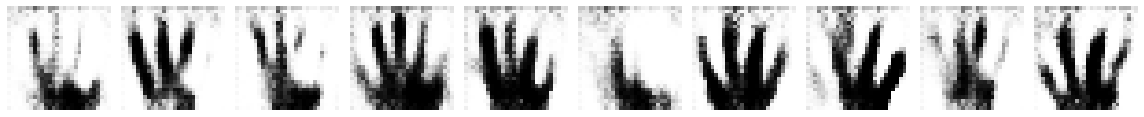

 23%|██▎       | 700/3000 [01:43<09:54,  3.87it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 701/3000 [01:43<08:37,  4.44it/s]

>701, dr[0.581,0.010], df[0.604,0.030], g[1.287,0.041]
1/1 [==============================] - 0s 13ms/step


 23%|██▎       | 702/3000 [01:43<07:36,  5.04it/s]

>702, dr[0.722,0.017], df[0.805,0.115], g[1.877,0.037]
1/1 [==============================] - 0s 13ms/step
>703, dr[0.589,0.105], df[0.701,0.091], g[1.834,0.113]


 23%|██▎       | 703/3000 [01:44<06:50,  5.59it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 704/3000 [01:44<06:21,  6.02it/s]

>704, dr[0.595,0.014], df[0.629,0.025], g[2.140,0.036]
1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 705/3000 [01:44<06:03,  6.32it/s]

>705, dr[0.781,0.063], df[0.385,0.039], g[1.319,0.216]
1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 706/3000 [01:44<05:52,  6.50it/s]

>706, dr[0.661,0.012], df[0.840,0.172], g[1.486,0.090]
1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 707/3000 [01:44<05:41,  6.72it/s]

>707, dr[0.449,0.027], df[0.844,0.018], g[1.809,0.047]
1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 708/3000 [01:44<05:42,  6.68it/s]

>708, dr[0.922,0.007], df[0.510,0.065], g[1.631,0.021]
1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 709/3000 [01:44<05:40,  6.73it/s]

>709, dr[0.642,0.005], df[0.746,0.281], g[1.477,0.111]
1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 710/3000 [01:45<05:35,  6.82it/s]

>710, dr[0.409,0.011], df[0.464,0.043], g[1.534,0.171]
1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 711/3000 [01:45<05:32,  6.88it/s]

>711, dr[0.998,0.002], df[0.613,0.003], g[1.226,0.097]
1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 712/3000 [01:45<05:26,  7.01it/s]

>712, dr[0.596,0.038], df[0.687,0.010], g[1.353,0.014]
1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 713/3000 [01:45<05:32,  6.89it/s]

>713, dr[0.535,0.026], df[0.683,0.101], g[1.605,0.175]
1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 714/3000 [01:45<05:38,  6.75it/s]

>714, dr[0.738,0.131], df[0.661,0.005], g[1.642,0.049]
1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 715/3000 [01:45<05:44,  6.63it/s]

>715, dr[0.569,0.008], df[0.727,0.008], g[1.789,0.029]
1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 716/3000 [01:45<05:40,  6.70it/s]

>716, dr[0.659,0.156], df[0.409,0.017], g[1.381,0.025]
1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 717/3000 [01:46<05:38,  6.75it/s]

>717, dr[0.613,0.034], df[0.827,0.022], g[1.683,0.140]
1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 718/3000 [01:46<05:39,  6.72it/s]

>718, dr[0.480,0.020], df[0.517,0.032], g[1.400,0.073]
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 719/3000 [01:46<05:44,  6.63it/s]

>719, dr[0.698,0.111], df[0.691,0.031], g[1.597,0.070]
1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 720/3000 [01:46<05:45,  6.61it/s]

>720, dr[0.762,0.124], df[0.603,0.010], g[1.539,0.052]
1/1 [==============================] - 0s 14ms/step


 24%|██▍       | 721/3000 [01:46<05:42,  6.66it/s]

>721, dr[0.585,0.020], df[0.509,0.051], g[1.103,0.039]
1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 722/3000 [01:46<05:39,  6.71it/s]

>722, dr[0.576,0.086], df[0.883,0.039], g[1.433,0.010]
1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 723/3000 [01:46<05:40,  6.69it/s]

>723, dr[0.601,0.043], df[0.627,0.081], g[1.589,0.174]
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 724/3000 [01:47<05:39,  6.71it/s]

>724, dr[0.714,0.003], df[0.663,0.070], g[1.671,0.033]
1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 725/3000 [01:47<05:46,  6.56it/s]

>725, dr[0.696,0.056], df[0.707,0.075], g[1.738,0.057]
1/1 [==============================] - 0s 14ms/step


 24%|██▍       | 726/3000 [01:47<05:44,  6.60it/s]

>726, dr[0.755,0.009], df[0.732,0.033], g[1.265,0.045]
1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 727/3000 [01:47<05:43,  6.61it/s]

>727, dr[0.730,0.008], df[0.583,0.098], g[0.977,0.016]
1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 728/3000 [01:47<05:46,  6.56it/s]

>728, dr[0.558,0.012], df[0.646,0.060], g[1.564,0.045]
1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 729/3000 [01:47<05:43,  6.61it/s]

>729, dr[0.510,0.066], df[0.762,0.031], g[1.696,0.170]
1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 730/3000 [01:48<05:42,  6.64it/s]

>730, dr[0.759,0.012], df[0.580,0.058], g[1.427,0.037]
1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 731/3000 [01:48<05:46,  6.55it/s]

>731, dr[0.637,0.012], df[0.460,0.009], g[1.347,0.065]
1/1 [==============================] - 0s 14ms/step


 24%|██▍       | 732/3000 [01:48<05:48,  6.51it/s]

>732, dr[0.539,0.010], df[0.705,0.080], g[1.382,0.142]
1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 733/3000 [01:48<05:39,  6.68it/s]

>733, dr[0.603,0.043], df[0.462,0.018], g[1.738,0.017]
1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 734/3000 [01:48<05:36,  6.74it/s]

>734, dr[0.599,0.017], df[0.508,0.104], g[1.559,0.043]
1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 735/3000 [01:48<05:33,  6.79it/s]

>735, dr[0.649,0.020], df[0.699,0.046], g[1.343,0.128]
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 736/3000 [01:48<05:31,  6.84it/s]

>736, dr[0.502,0.054], df[0.521,0.068], g[1.623,0.075]
1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 737/3000 [01:49<05:33,  6.79it/s]

>737, dr[0.540,0.257], df[0.593,0.009], g[2.027,0.039]
1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 738/3000 [01:49<05:28,  6.89it/s]

>738, dr[0.856,0.006], df[0.768,0.153], g[1.549,0.044]
1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 739/3000 [01:49<05:38,  6.67it/s]

>739, dr[0.557,0.008], df[0.948,0.089], g[1.634,0.038]
1/1 [==============================] - 0s 14ms/step


 25%|██▍       | 740/3000 [01:49<05:37,  6.69it/s]

>740, dr[0.941,0.003], df[0.327,0.205], g[1.321,0.067]
1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 741/3000 [01:49<05:36,  6.71it/s]

>741, dr[0.571,0.011], df[0.834,0.117], g[1.329,0.015]
1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 742/3000 [01:49<05:36,  6.71it/s]

>742, dr[0.510,0.003], df[0.694,0.029], g[1.878,0.030]
1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 743/3000 [01:49<05:45,  6.53it/s]

>743, dr[0.842,0.004], df[0.499,0.133], g[1.626,0.128]
1/1 [==============================] - 0s 14ms/step


 25%|██▍       | 744/3000 [01:50<05:38,  6.66it/s]

>744, dr[0.452,0.030], df[0.837,0.157], g[1.912,0.039]
1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 745/3000 [01:50<05:46,  6.51it/s]

>745, dr[0.879,0.004], df[0.651,0.049], g[1.832,0.023]
1/1 [==============================] - 0s 14ms/step


 25%|██▍       | 746/3000 [01:50<05:43,  6.56it/s]

>746, dr[0.918,0.090], df[0.600,0.029], g[1.248,0.114]
1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 747/3000 [01:50<05:46,  6.50it/s]

>747, dr[0.513,0.106], df[0.513,0.002], g[1.196,0.088]
1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 748/3000 [01:50<05:46,  6.51it/s]

>748, dr[0.640,0.019], df[0.735,0.007], g[1.241,0.027]
1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 749/3000 [01:50<05:39,  6.63it/s]

>749, dr[0.577,0.077], df[0.807,0.004], g[1.679,0.065]
1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 750/3000 [01:51<05:37,  6.66it/s]

>750, dr[0.805,0.003], df[0.752,0.006], g[1.762,0.024]
1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 751/3000 [01:51<05:49,  6.44it/s]

>751, dr[0.757,0.008], df[0.604,0.017], g[1.420,0.050]
1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 752/3000 [01:51<05:59,  6.25it/s]

>752, dr[0.411,0.012], df[0.514,0.032], g[1.668,0.006]
1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 753/3000 [01:51<05:55,  6.32it/s]

>753, dr[0.595,0.015], df[0.716,0.023], g[1.358,0.083]
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 754/3000 [01:51<06:01,  6.21it/s]

>754, dr[0.657,0.007], df[0.540,0.003], g[1.149,0.086]
1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 755/3000 [01:51<06:00,  6.23it/s]

>755, dr[0.528,0.009], df[0.512,0.077], g[1.234,0.063]
1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 756/3000 [01:51<05:52,  6.36it/s]

>756, dr[0.434,0.001], df[0.727,0.049], g[1.427,0.034]
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 757/3000 [01:52<05:43,  6.54it/s]

>757, dr[0.673,0.002], df[0.517,0.038], g[1.649,0.058]
1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 758/3000 [01:52<05:42,  6.54it/s]

>758, dr[0.610,0.005], df[0.604,0.056], g[1.554,0.032]
1/1 [==============================] - 0s 14ms/step


 25%|██▌       | 759/3000 [01:52<05:39,  6.60it/s]

>759, dr[0.703,0.014], df[0.544,0.027], g[1.209,0.046]
1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 760/3000 [01:52<05:38,  6.62it/s]

>760, dr[0.436,0.012], df[0.818,0.057], g[1.810,0.058]
1/1 [==============================] - 0s 14ms/step


 25%|██▌       | 761/3000 [01:52<05:40,  6.57it/s]

>761, dr[0.857,0.009], df[0.440,0.018], g[1.813,0.065]
1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 762/3000 [01:52<05:40,  6.58it/s]

>762, dr[0.373,0.008], df[0.544,0.037], g[1.727,0.052]
1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 763/3000 [01:53<05:40,  6.58it/s]

>763, dr[0.572,0.013], df[0.561,0.030], g[1.709,0.065]
1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 764/3000 [01:53<05:36,  6.65it/s]

>764, dr[0.846,0.004], df[0.757,0.100], g[1.143,0.072]
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 765/3000 [01:53<05:39,  6.59it/s]

>765, dr[0.363,0.006], df[0.532,0.005], g[1.397,0.021]
1/1 [==============================] - 0s 14ms/step


 26%|██▌       | 766/3000 [01:53<05:38,  6.61it/s]

>766, dr[0.439,0.022], df[0.558,0.061], g[1.403,0.013]
1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 767/3000 [01:53<05:32,  6.72it/s]

>767, dr[0.583,0.004], df[0.384,0.001], g[1.824,0.059]
1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 768/3000 [01:53<05:32,  6.71it/s]

>768, dr[0.426,0.011], df[0.660,0.025], g[1.485,0.035]
1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 769/3000 [01:53<05:30,  6.76it/s]

>769, dr[0.511,0.032], df[0.648,0.005], g[1.698,0.139]
1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 770/3000 [01:54<05:33,  6.69it/s]

>770, dr[0.546,0.003], df[0.394,0.034], g[1.306,0.027]
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 771/3000 [01:54<05:31,  6.72it/s]

>771, dr[0.533,0.143], df[0.684,0.008], g[1.780,0.035]
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 772/3000 [01:54<05:27,  6.80it/s]

>772, dr[0.476,0.012], df[0.628,0.077], g[1.859,0.019]
1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 773/3000 [01:54<05:25,  6.84it/s]

>773, dr[0.705,0.002], df[0.514,0.007], g[2.048,0.033]
1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 774/3000 [01:54<05:24,  6.86it/s]

>774, dr[0.580,0.073], df[0.532,0.024], g[1.629,0.044]
1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 775/3000 [01:54<05:24,  6.85it/s]

>775, dr[0.610,0.002], df[1.037,0.046], g[1.511,0.186]
1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 776/3000 [01:54<05:23,  6.88it/s]

>776, dr[0.722,0.001], df[0.425,0.112], g[1.950,0.081]
1/1 [==============================] - 0s 14ms/step


 26%|██▌       | 777/3000 [01:55<05:40,  6.53it/s]

>777, dr[0.513,0.010], df[0.652,0.006], g[1.817,0.235]
1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 778/3000 [01:55<05:31,  6.71it/s]

>778, dr[0.525,0.032], df[0.711,0.017], g[1.745,0.193]
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 779/3000 [01:55<05:38,  6.57it/s]

>779, dr[0.609,0.025], df[0.832,0.159], g[1.686,0.018]
1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 780/3000 [01:55<05:51,  6.31it/s]

>780, dr[0.646,0.013], df[0.461,0.014], g[1.950,0.086]
1/1 [==============================] - 0s 14ms/step


 26%|██▌       | 781/3000 [01:55<05:44,  6.44it/s]

>781, dr[0.532,0.004], df[0.634,0.012], g[1.935,0.133]
1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 782/3000 [01:55<05:35,  6.61it/s]

>782, dr[0.727,0.014], df[0.487,0.068], g[1.686,0.142]
1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 783/3000 [01:56<05:35,  6.60it/s]

>783, dr[0.515,0.101], df[0.540,0.003], g[1.436,0.075]
1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 784/3000 [01:56<05:35,  6.61it/s]

>784, dr[0.648,0.013], df[0.566,0.013], g[1.497,0.183]
1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 785/3000 [01:56<05:34,  6.63it/s]

>785, dr[0.493,0.013], df[0.794,0.089], g[1.770,0.065]
1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 786/3000 [01:56<05:35,  6.61it/s]

>786, dr[0.619,0.003], df[0.680,0.101], g[1.930,0.113]
1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 787/3000 [01:56<05:30,  6.70it/s]

>787, dr[0.523,0.003], df[0.296,0.051], g[1.669,0.017]
1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 788/3000 [01:56<05:27,  6.75it/s]

>788, dr[0.488,0.046], df[0.500,0.005], g[1.911,0.041]
1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 789/3000 [01:56<05:43,  6.44it/s]

>789, dr[0.540,0.003], df[0.512,0.003], g[1.694,0.069]
1/1 [==============================] - 0s 14ms/step


 26%|██▋       | 790/3000 [01:57<05:40,  6.49it/s]

>790, dr[0.471,0.010], df[0.624,0.033], g[2.105,0.026]
1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 791/3000 [01:57<05:45,  6.39it/s]

>791, dr[0.723,0.014], df[0.643,0.063], g[2.067,0.072]
1/1 [==============================] - 0s 15ms/step


 26%|██▋       | 792/3000 [01:57<05:38,  6.53it/s]

>792, dr[0.527,0.081], df[0.544,0.012], g[1.919,0.047]
1/1 [==============================] - 0s 14ms/step


 26%|██▋       | 793/3000 [01:57<05:39,  6.50it/s]

>793, dr[0.744,0.003], df[0.524,0.061], g[1.880,0.111]
1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 794/3000 [01:57<05:34,  6.60it/s]

>794, dr[0.617,0.003], df[0.495,0.010], g[1.729,0.155]
1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 795/3000 [01:57<05:34,  6.59it/s]

>795, dr[0.501,0.004], df[0.651,0.149], g[1.623,0.107]
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 796/3000 [01:58<05:32,  6.63it/s]

>796, dr[0.483,0.012], df[0.640,0.032], g[1.908,0.128]
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 797/3000 [01:58<05:31,  6.65it/s]

>797, dr[0.764,0.003], df[0.401,0.052], g[1.648,0.042]
1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 798/3000 [01:58<05:26,  6.75it/s]

>798, dr[0.676,0.027], df[0.852,0.085], g[1.458,0.007]
1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 799/3000 [01:58<05:30,  6.67it/s]

>799, dr[0.393,0.007], df[0.529,0.028], g[2.014,0.026]
1/1 [==============================] - 0s 15ms/step
>800, dr[0.673,0.012], df[0.611,0.120], g[1.691,0.008]
1/1 [==============================] - 0s 20ms/step


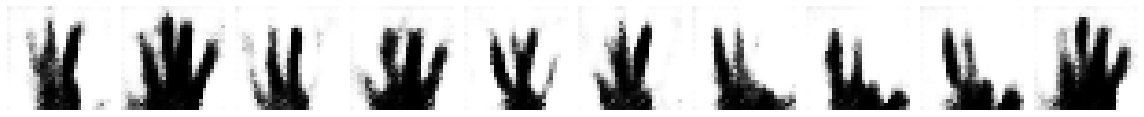

 27%|██▋       | 800/3000 [01:58<09:33,  3.84it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 801/3000 [01:59<08:17,  4.42it/s]

>801, dr[0.570,0.024], df[0.476,0.013], g[1.712,0.100]
1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 802/3000 [01:59<07:19,  5.00it/s]

>802, dr[0.658,0.008], df[0.541,0.130], g[1.723,0.057]
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 803/3000 [01:59<06:43,  5.44it/s]

>803, dr[0.693,0.024], df[0.591,0.130], g[1.777,0.047]
1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 804/3000 [01:59<06:31,  5.61it/s]

>804, dr[0.484,0.001], df[0.709,0.011], g[2.003,0.057]
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 805/3000 [01:59<06:15,  5.85it/s]

>805, dr[0.400,0.004], df[0.323,0.090], g[2.300,0.011]
1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 806/3000 [01:59<06:00,  6.09it/s]

>806, dr[0.447,0.045], df[0.494,0.079], g[2.205,0.038]
1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 807/3000 [02:00<05:53,  6.20it/s]

>807, dr[0.814,0.050], df[0.623,0.058], g[1.524,0.137]
1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 808/3000 [02:00<05:53,  6.20it/s]

>808, dr[0.497,0.004], df[0.643,0.044], g[1.606,0.008]
1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 809/3000 [02:00<06:11,  5.90it/s]

>809, dr[0.553,0.009], df[0.535,0.194], g[1.609,0.041]
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 810/3000 [02:00<06:07,  5.95it/s]

>810, dr[0.507,0.018], df[0.667,0.027], g[1.735,0.099]
1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 811/3000 [02:00<05:50,  6.24it/s]

>811, dr[0.563,0.004], df[0.493,0.006], g[1.791,0.052]
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 812/3000 [02:00<05:42,  6.39it/s]

>812, dr[0.626,0.002], df[0.618,0.057], g[1.665,0.068]
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 813/3000 [02:00<05:39,  6.45it/s]

>813, dr[0.554,0.095], df[0.387,0.034], g[1.585,0.024]
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 814/3000 [02:01<05:35,  6.52it/s]

>814, dr[0.434,0.002], df[0.542,0.030], g[1.660,0.025]
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 815/3000 [02:01<05:29,  6.64it/s]

>815, dr[0.369,0.002], df[0.347,0.072], g[2.102,0.078]
1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 816/3000 [02:01<09:35,  3.79it/s]

>816, dr[0.610,0.132], df[0.479,0.011], g[1.483,0.063]
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 817/3000 [02:01<08:13,  4.43it/s]

>817, dr[0.477,0.049], df[0.614,0.042], g[1.389,0.030]
1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 818/3000 [02:02<07:19,  4.97it/s]

>818, dr[0.301,0.026], df[0.560,0.111], g[1.874,0.031]
1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 819/3000 [02:02<06:48,  5.34it/s]

>819, dr[0.671,0.136], df[0.493,0.027], g[1.891,0.050]
1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 820/3000 [02:02<06:22,  5.70it/s]

>820, dr[0.490,0.004], df[0.579,0.031], g[1.798,0.086]
1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 821/3000 [02:02<06:09,  5.90it/s]

>821, dr[0.670,0.009], df[0.601,0.123], g[1.396,0.045]
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 822/3000 [02:02<06:00,  6.05it/s]

>822, dr[0.670,0.008], df[0.631,0.012], g[1.534,0.006]
1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 823/3000 [02:02<05:51,  6.20it/s]

>823, dr[0.625,0.030], df[0.616,0.048], g[1.875,0.030]
1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 824/3000 [02:02<05:39,  6.41it/s]

>824, dr[0.513,0.045], df[0.461,0.060], g[1.541,0.036]
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 825/3000 [02:03<05:30,  6.58it/s]

>825, dr[0.614,0.025], df[0.577,0.044], g[1.426,0.072]
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 826/3000 [02:03<05:29,  6.60it/s]

>826, dr[0.498,0.012], df[0.725,0.027], g[1.536,0.013]
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 827/3000 [02:03<05:27,  6.64it/s]

>827, dr[0.504,0.114], df[0.893,0.042], g[2.192,0.012]
1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 828/3000 [02:03<05:31,  6.56it/s]

>828, dr[0.775,0.053], df[0.381,0.008], g[1.705,0.013]
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 829/3000 [02:03<05:35,  6.48it/s]

>829, dr[0.687,0.002], df[0.372,0.001], g[1.208,0.019]
1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 830/3000 [02:03<05:34,  6.48it/s]

>830, dr[0.338,0.004], df[0.788,0.013], g[1.437,0.033]
1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 831/3000 [02:04<05:34,  6.49it/s]

>831, dr[0.310,0.004], df[0.514,0.129], g[2.017,0.080]
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 832/3000 [02:04<05:36,  6.44it/s]

>832, dr[0.595,0.018], df[0.494,0.106], g[1.700,0.016]
1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 833/3000 [02:04<05:33,  6.50it/s]

>833, dr[0.575,0.047], df[0.473,0.100], g[1.363,0.015]
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 834/3000 [02:04<05:31,  6.54it/s]

>834, dr[0.409,0.029], df[0.427,0.014], g[1.531,0.078]
1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 835/3000 [02:04<05:39,  6.38it/s]

>835, dr[0.338,0.008], df[0.499,0.012], g[1.800,0.012]
1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 836/3000 [02:04<05:35,  6.46it/s]

>836, dr[0.768,0.003], df[0.774,0.083], g[1.664,0.186]
1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 837/3000 [02:04<05:26,  6.62it/s]

>837, dr[0.411,0.000], df[0.282,0.064], g[1.765,0.049]
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 838/3000 [02:05<05:25,  6.65it/s]

>838, dr[0.529,0.037], df[0.624,0.011], g[1.580,0.048]
1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 839/3000 [02:05<05:26,  6.62it/s]

>839, dr[0.430,0.003], df[0.559,0.079], g[1.707,0.124]
1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 840/3000 [02:05<05:29,  6.55it/s]

>840, dr[0.476,0.006], df[0.504,0.090], g[1.717,0.056]
1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 841/3000 [02:05<05:26,  6.62it/s]

>841, dr[0.419,0.211], df[0.364,0.015], g[1.585,0.105]
1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 842/3000 [02:05<05:28,  6.58it/s]

>842, dr[0.400,0.151], df[0.415,0.088], g[1.356,0.128]
1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 843/3000 [02:05<05:30,  6.52it/s]

>843, dr[0.392,0.022], df[0.666,0.082], g[1.474,0.117]
1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 844/3000 [02:06<05:26,  6.61it/s]

>844, dr[0.599,0.020], df[0.406,0.028], g[1.631,0.066]
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 845/3000 [02:06<05:19,  6.74it/s]

>845, dr[0.403,0.036], df[0.699,0.019], g[1.320,0.084]
1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 846/3000 [02:06<05:19,  6.73it/s]

>846, dr[0.414,0.054], df[0.745,0.009], g[1.881,0.072]
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 847/3000 [02:06<05:18,  6.76it/s]

>847, dr[0.583,0.011], df[0.356,0.076], g[1.632,0.102]
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 848/3000 [02:06<05:21,  6.70it/s]

>848, dr[0.523,0.028], df[0.634,0.009], g[1.879,0.102]
1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 849/3000 [02:06<05:23,  6.64it/s]

>849, dr[0.570,0.005], df[0.413,0.022], g[1.984,0.153]
1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 850/3000 [02:06<05:23,  6.64it/s]

>850, dr[0.404,0.004], df[0.449,0.035], g[1.882,0.036]
1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 851/3000 [02:07<05:21,  6.68it/s]

>851, dr[0.393,0.003], df[0.457,0.010], g[1.787,0.025]
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 852/3000 [02:07<05:17,  6.77it/s]

>852, dr[0.354,0.003], df[0.255,0.006], g[1.677,0.057]
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 853/3000 [02:07<05:15,  6.80it/s]

>853, dr[0.346,0.034], df[0.423,0.019], g[1.787,0.025]
1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 854/3000 [02:07<05:13,  6.86it/s]

>854, dr[0.515,0.005], df[0.333,0.067], g[1.923,0.156]
1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 855/3000 [02:07<05:25,  6.58it/s]

>855, dr[0.387,0.006], df[0.744,0.049], g[1.702,0.007]
1/1 [==============================] - 0s 14ms/step


 29%|██▊       | 856/3000 [02:07<05:23,  6.62it/s]

>856, dr[0.406,0.069], df[0.601,0.014], g[2.092,0.035]
1/1 [==============================] - 0s 23ms/step


 29%|██▊       | 857/3000 [02:07<05:38,  6.34it/s]

>857, dr[0.690,0.017], df[0.417,0.073], g[1.703,0.077]
1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 858/3000 [02:08<05:33,  6.42it/s]

>858, dr[0.423,0.015], df[0.419,0.005], g[1.582,0.017]
1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 859/3000 [02:08<05:29,  6.50it/s]

>859, dr[0.522,0.015], df[0.635,0.132], g[1.889,0.041]
1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 860/3000 [02:08<05:27,  6.53it/s]

>860, dr[0.575,0.012], df[0.642,0.198], g[1.558,0.082]
1/1 [==============================] - 0s 14ms/step


 29%|██▊       | 861/3000 [02:08<05:25,  6.57it/s]

>861, dr[0.493,0.004], df[0.429,0.015], g[1.857,0.115]
1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 862/3000 [02:08<05:27,  6.53it/s]

>862, dr[0.675,0.037], df[0.512,0.002], g[1.465,0.006]
1/1 [==============================] - 0s 14ms/step


 29%|██▉       | 863/3000 [02:08<05:27,  6.52it/s]

>863, dr[0.444,0.017], df[0.490,0.050], g[1.602,0.066]
1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 864/3000 [02:09<05:23,  6.60it/s]

>864, dr[0.418,0.004], df[0.498,0.065], g[1.799,0.029]
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 865/3000 [02:09<05:17,  6.73it/s]

>865, dr[0.662,0.032], df[0.497,0.055], g[1.976,0.022]
1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 866/3000 [02:09<05:17,  6.72it/s]

>866, dr[0.594,0.006], df[0.374,0.016], g[1.613,0.051]
1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 867/3000 [02:09<05:12,  6.82it/s]

>867, dr[0.261,0.004], df[0.391,0.025], g[1.797,0.171]
1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 868/3000 [02:09<05:13,  6.79it/s]

>868, dr[0.359,0.029], df[0.407,0.011], g[1.660,0.031]
1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 869/3000 [02:09<05:20,  6.66it/s]

>869, dr[0.391,0.016], df[0.588,0.009], g[1.836,0.066]
1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 870/3000 [02:09<05:14,  6.78it/s]

>870, dr[0.382,0.005], df[0.489,0.027], g[1.793,0.106]
1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 871/3000 [02:10<05:10,  6.86it/s]

>871, dr[0.555,0.006], df[0.534,0.007], g[1.704,0.079]
1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 872/3000 [02:10<05:17,  6.71it/s]

>872, dr[0.624,0.006], df[0.555,0.054], g[1.774,0.021]
1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 873/3000 [02:10<05:17,  6.69it/s]

>873, dr[0.292,0.001], df[0.599,0.033], g[2.011,0.105]
1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 874/3000 [02:10<05:17,  6.69it/s]

>874, dr[0.496,0.029], df[0.610,0.013], g[1.908,0.111]
1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 875/3000 [02:10<05:17,  6.70it/s]

>875, dr[0.810,0.001], df[0.505,0.003], g[1.781,0.027]
1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 876/3000 [02:10<05:28,  6.46it/s]

>876, dr[0.463,0.021], df[0.585,0.003], g[1.918,0.114]
1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 877/3000 [02:11<05:28,  6.46it/s]

>877, dr[0.560,0.002], df[0.444,0.014], g[1.534,0.045]
1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 878/3000 [02:11<05:26,  6.49it/s]

>878, dr[0.315,0.055], df[0.374,0.005], g[1.648,0.013]
1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 879/3000 [02:11<05:31,  6.40it/s]

>879, dr[0.639,0.005], df[0.768,0.013], g[1.961,0.058]
1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 880/3000 [02:11<05:30,  6.41it/s]

>880, dr[0.473,0.005], df[0.418,0.012], g[2.068,0.118]
1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 881/3000 [02:11<05:32,  6.37it/s]

>881, dr[0.603,0.119], df[0.601,0.028], g[1.638,0.056]
1/1 [==============================] - 0s 14ms/step


 29%|██▉       | 882/3000 [02:11<05:30,  6.41it/s]

>882, dr[0.416,0.057], df[0.355,0.018], g[1.904,0.053]
1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 883/3000 [02:11<05:21,  6.58it/s]

>883, dr[0.657,0.022], df[0.406,0.054], g[1.647,0.098]
1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 884/3000 [02:12<05:29,  6.42it/s]

>884, dr[0.407,0.008], df[0.519,0.045], g[1.408,0.060]
1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 885/3000 [02:12<05:23,  6.53it/s]

>885, dr[0.363,0.017], df[0.517,0.025], g[1.573,0.039]
1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 886/3000 [02:12<05:26,  6.48it/s]

>886, dr[0.412,0.001], df[0.706,0.123], g[2.201,0.053]
1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 887/3000 [02:12<05:21,  6.56it/s]

>887, dr[0.590,0.034], df[0.410,0.004], g[2.035,0.127]
1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 888/3000 [02:12<05:21,  6.57it/s]

>888, dr[0.399,0.013], df[0.475,0.084], g[1.769,0.104]
1/1 [==============================] - 0s 15ms/step


 30%|██▉       | 889/3000 [02:12<05:23,  6.52it/s]

>889, dr[0.470,0.073], df[0.552,0.007], g[1.921,0.021]
1/1 [==============================] - 0s 14ms/step


 30%|██▉       | 890/3000 [02:13<05:22,  6.55it/s]

>890, dr[0.401,0.015], df[0.318,0.019], g[2.045,0.023]
1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 891/3000 [02:13<05:21,  6.57it/s]

>891, dr[0.511,0.006], df[0.399,0.014], g[2.011,0.018]
1/1 [==============================] - 0s 13ms/step


 30%|██▉       | 892/3000 [02:13<05:22,  6.54it/s]

>892, dr[0.480,0.001], df[0.632,0.085], g[1.599,0.054]
1/1 [==============================] - 0s 14ms/step


 30%|██▉       | 893/3000 [02:13<05:18,  6.61it/s]

>893, dr[0.353,0.007], df[0.415,0.013], g[1.719,0.076]
1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 894/3000 [02:13<05:13,  6.73it/s]

>894, dr[0.419,0.015], df[0.402,0.118], g[1.701,0.035]
1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 895/3000 [02:13<05:10,  6.77it/s]

>895, dr[0.587,0.005], df[0.696,0.056], g[1.516,0.035]
1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 896/3000 [02:13<05:20,  6.56it/s]

>896, dr[0.600,0.012], df[0.345,0.031], g[1.533,0.024]
1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 897/3000 [02:14<05:19,  6.57it/s]

>897, dr[0.277,0.019], df[0.706,0.040], g[1.738,0.046]
1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 898/3000 [02:14<05:14,  6.69it/s]

>898, dr[0.433,0.009], df[0.421,0.020], g[1.825,0.085]
1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 899/3000 [02:14<05:16,  6.63it/s]

>899, dr[0.598,0.003], df[0.611,0.113], g[1.910,0.081]
1/1 [==============================] - 0s 15ms/step
>900, dr[0.521,0.022], df[0.372,0.004], g[1.850,0.010]
1/1 [==============================] - 0s 16ms/step


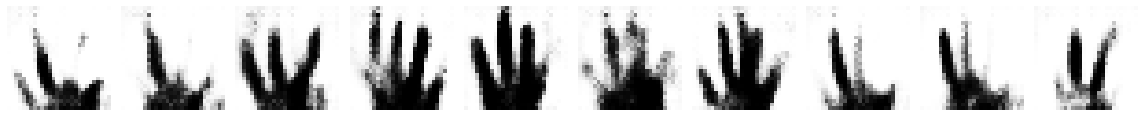

 30%|███       | 900/3000 [02:14<09:06,  3.85it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 901/3000 [02:15<07:56,  4.41it/s]

>901, dr[0.277,0.005], df[0.547,0.194], g[1.938,0.111]
1/1 [==============================] - 0s 15ms/step


 30%|███       | 902/3000 [02:15<07:04,  4.94it/s]

>902, dr[0.621,0.005], df[0.406,0.011], g[1.503,0.067]
1/1 [==============================] - 0s 20ms/step


 30%|███       | 903/3000 [02:15<06:35,  5.31it/s]

>903, dr[0.411,0.003], df[0.532,0.014], g[1.839,0.056]
1/1 [==============================] - 0s 19ms/step


 30%|███       | 904/3000 [02:15<06:17,  5.56it/s]

>904, dr[0.567,0.041], df[0.487,0.014], g[1.913,0.037]
1/1 [==============================] - 0s 17ms/step


 30%|███       | 905/3000 [02:15<06:02,  5.77it/s]

>905, dr[0.409,0.001], df[0.804,0.031], g[1.936,0.049]
1/1 [==============================] - 0s 19ms/step


 30%|███       | 906/3000 [02:15<05:51,  5.96it/s]

>906, dr[0.538,0.041], df[0.271,0.011], g[1.604,0.087]
1/1 [==============================] - 0s 21ms/step


 30%|███       | 907/3000 [02:15<05:48,  6.00it/s]

>907, dr[0.543,0.009], df[0.497,0.051], g[1.377,0.012]
1/1 [==============================] - 0s 16ms/step


 30%|███       | 908/3000 [02:16<05:45,  6.05it/s]

>908, dr[0.473,0.015], df[0.575,0.007], g[1.834,0.025]
1/1 [==============================] - 0s 15ms/step


 30%|███       | 909/3000 [02:16<05:34,  6.26it/s]

>909, dr[0.296,0.012], df[0.724,0.030], g[1.983,0.022]
1/1 [==============================] - 0s 25ms/step


 30%|███       | 910/3000 [02:16<05:24,  6.44it/s]

>910, dr[0.492,0.012], df[0.341,0.007], g[2.183,0.030]
1/1 [==============================] - 0s 21ms/step


 30%|███       | 911/3000 [02:16<05:17,  6.58it/s]

>911, dr[0.645,0.009], df[0.412,0.034], g[1.523,0.015]
1/1 [==============================] - 0s 27ms/step


 30%|███       | 912/3000 [02:16<05:20,  6.52it/s]

>912, dr[0.491,0.003], df[0.770,0.032], g[1.532,0.090]
1/1 [==============================] - 0s 27ms/step
>913, dr[0.736,0.007], df[0.544,0.003], g[1.750,0.008]


 30%|███       | 913/3000 [02:16<05:44,  6.05it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 914/3000 [02:17<06:07,  5.67it/s]

>914, dr[0.412,0.020], df[0.481,0.032], g[1.839,0.010]
1/1 [==============================] - 0s 30ms/step
>915, dr[0.410,0.003], df[0.368,0.009], g[2.111,0.125]


 30%|███       | 915/3000 [02:17<06:26,  5.39it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 916/3000 [02:17<06:46,  5.13it/s]

>916, dr[0.441,0.018], df[0.492,0.113], g[1.491,0.052]
1/1 [==============================] - 0s 42ms/step


 31%|███       | 917/3000 [02:17<06:58,  4.98it/s]

>917, dr[0.674,0.008], df[0.420,0.031], g[1.651,0.091]
1/1 [==============================] - 0s 34ms/step


 31%|███       | 918/3000 [02:17<07:01,  4.93it/s]

>918, dr[0.437,0.104], df[0.540,0.030], g[1.649,0.040]
1/1 [==============================] - 0s 32ms/step
>919, dr[0.338,0.002], df[0.400,0.073], g[1.738,0.092]


 31%|███       | 919/3000 [02:18<06:58,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 920/3000 [02:18<06:27,  5.37it/s]

>920, dr[0.383,0.005], df[0.479,0.042], g[1.665,0.015]
1/1 [==============================] - 0s 33ms/step
>921, dr[0.644,0.017], df[0.540,0.045], g[2.006,0.035]


 31%|███       | 921/3000 [02:18<06:37,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 922/3000 [02:18<06:17,  5.51it/s]

>922, dr[0.407,0.180], df[0.460,0.038], g[1.700,0.014]
1/1 [==============================] - 0s 20ms/step


 31%|███       | 923/3000 [02:18<06:01,  5.74it/s]

>923, dr[0.459,0.008], df[0.794,0.057], g[2.032,0.124]
1/1 [==============================] - 0s 33ms/step


 31%|███       | 924/3000 [02:19<06:19,  5.48it/s]

>924, dr[0.589,0.004], df[0.383,0.011], g[1.577,0.008]
1/1 [==============================] - 0s 45ms/step


 31%|███       | 925/3000 [02:19<06:44,  5.13it/s]

>925, dr[0.417,0.012], df[0.777,0.071], g[2.002,0.014]
1/1 [==============================] - 0s 33ms/step


 31%|███       | 926/3000 [02:19<06:56,  4.98it/s]

>926, dr[0.558,0.017], df[0.493,0.135], g[2.110,0.031]
1/1 [==============================] - 0s 30ms/step


 31%|███       | 927/3000 [02:19<07:09,  4.82it/s]

>927, dr[0.591,0.010], df[0.322,0.040], g[1.824,0.095]
1/1 [==============================] - 0s 35ms/step


 31%|███       | 928/3000 [02:19<07:10,  4.82it/s]

>928, dr[0.709,0.009], df[0.707,0.091], g[1.244,0.051]
1/1 [==============================] - 0s 35ms/step


 31%|███       | 929/3000 [02:20<07:12,  4.79it/s]

>929, dr[0.170,0.008], df[0.534,0.037], g[2.238,0.111]
1/1 [==============================] - 0s 27ms/step


 31%|███       | 930/3000 [02:20<07:11,  4.80it/s]

>930, dr[0.575,0.007], df[0.515,0.050], g[1.713,0.012]
1/1 [==============================] - 0s 34ms/step


 31%|███       | 931/3000 [02:20<07:19,  4.70it/s]

>931, dr[0.292,0.004], df[0.403,0.072], g[2.052,0.062]
1/1 [==============================] - 0s 32ms/step


 31%|███       | 932/3000 [02:20<07:25,  4.64it/s]

>932, dr[0.388,0.003], df[0.289,0.022], g[1.810,0.090]
1/1 [==============================] - 0s 27ms/step
>933, dr[0.526,0.022], df[0.573,0.015], g[1.732,0.042]


 31%|███       | 933/3000 [02:20<07:11,  4.79it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 934/3000 [02:21<07:08,  4.82it/s]

>934, dr[0.473,0.028], df[0.384,0.050], g[2.008,0.021]
1/1 [==============================] - 0s 24ms/step
>935, dr[0.365,0.007], df[0.580,0.185], g[1.879,0.059]


 31%|███       | 935/3000 [02:21<06:56,  4.95it/s]

1/1 [==============================] - 0s 26ms/step
>936, dr[0.441,0.022], df[0.531,0.046], g[2.099,0.036]


 31%|███       | 936/3000 [02:21<06:56,  4.96it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 937/3000 [02:21<07:11,  4.78it/s]

>937, dr[0.739,0.005], df[0.513,0.008], g[1.857,0.073]
1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 938/3000 [02:21<07:13,  4.76it/s]

>938, dr[0.384,0.021], df[0.535,0.045], g[1.838,0.052]
1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 939/3000 [02:22<07:10,  4.79it/s]

>939, dr[0.480,0.005], df[0.506,0.024], g[1.891,0.038]
1/1 [==============================] - 0s 57ms/step


 31%|███▏      | 940/3000 [02:22<07:36,  4.51it/s]

>940, dr[0.532,0.005], df[0.476,0.252], g[1.623,0.033]
1/1 [==============================] - 0s 51ms/step


 31%|███▏      | 941/3000 [02:22<07:45,  4.43it/s]

>941, dr[0.378,0.012], df[0.649,0.112], g[1.961,0.015]
1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 942/3000 [02:22<07:33,  4.53it/s]

>942, dr[0.449,0.023], df[0.511,0.005], g[2.204,0.030]
1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 943/3000 [02:23<07:27,  4.60it/s]

>943, dr[0.739,0.014], df[0.294,0.220], g[1.775,0.021]
1/1 [==============================] - 0s 33ms/step
>944, dr[0.428,0.004], df[0.668,0.031], g[1.533,0.210]


 31%|███▏      | 944/3000 [02:23<07:17,  4.70it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 945/3000 [02:23<07:11,  4.77it/s]

>945, dr[0.377,0.088], df[0.465,0.003], g[2.044,0.088]
1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 946/3000 [02:23<07:20,  4.67it/s]

>946, dr[0.520,0.002], df[0.373,0.152], g[2.048,0.022]
1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 947/3000 [02:23<07:28,  4.57it/s]

>947, dr[0.318,0.014], df[0.338,0.149], g[1.587,0.037]
1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 948/3000 [02:24<07:29,  4.56it/s]

>948, dr[0.316,0.020], df[0.502,0.008], g[2.174,0.002]
1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 949/3000 [02:24<07:48,  4.38it/s]

>949, dr[0.467,0.011], df[0.308,0.034], g[1.579,0.099]
1/1 [==============================] - 0s 23ms/step
>950, dr[0.401,0.018], df[0.387,0.016], g[1.861,0.045]


 32%|███▏      | 950/3000 [02:24<07:29,  4.56it/s]

1/1 [==============================] - 0s 13ms/step


 32%|███▏      | 951/3000 [02:24<06:41,  5.10it/s]

>951, dr[0.400,0.009], df[0.289,0.068], g[1.744,0.039]
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 952/3000 [02:24<06:14,  5.47it/s]

>952, dr[0.402,0.276], df[0.638,0.152], g[1.597,0.043]
1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 953/3000 [02:25<05:52,  5.81it/s]

>953, dr[0.309,0.010], df[0.396,0.007], g[2.066,0.014]
1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 954/3000 [02:25<05:42,  5.97it/s]

>954, dr[0.477,0.020], df[0.505,0.004], g[1.900,0.021]
1/1 [==============================] - 0s 14ms/step


 32%|███▏      | 955/3000 [02:25<05:35,  6.09it/s]

>955, dr[0.410,0.002], df[0.328,0.014], g[2.369,0.061]
1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 956/3000 [02:25<05:30,  6.18it/s]

>956, dr[0.371,0.001], df[0.486,0.032], g[2.221,0.006]
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 957/3000 [02:25<05:20,  6.37it/s]

>957, dr[0.447,0.019], df[0.391,0.089], g[1.947,0.031]
1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 958/3000 [02:25<05:15,  6.48it/s]

>958, dr[0.404,0.033], df[0.314,0.005], g[1.957,0.017]
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 959/3000 [02:25<05:11,  6.54it/s]

>959, dr[0.365,0.001], df[0.400,0.178], g[1.940,0.159]
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 960/3000 [02:26<05:14,  6.49it/s]

>960, dr[0.750,0.003], df[0.459,0.018], g[1.968,0.008]
1/1 [==============================] - 0s 14ms/step


 32%|███▏      | 961/3000 [02:26<05:13,  6.50it/s]

>961, dr[0.347,0.012], df[0.556,0.029], g[2.072,0.013]
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 962/3000 [02:26<05:08,  6.61it/s]

>962, dr[0.491,0.005], df[0.720,0.350], g[1.809,0.017]
1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 963/3000 [02:26<05:02,  6.72it/s]

>963, dr[0.534,0.004], df[0.581,0.029], g[2.106,0.067]
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 964/3000 [02:26<05:06,  6.65it/s]

>964, dr[0.462,0.005], df[0.362,0.031], g[2.099,0.112]
1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 965/3000 [02:26<05:02,  6.73it/s]

>965, dr[0.551,0.064], df[0.590,0.021], g[1.791,0.005]
1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 966/3000 [02:27<05:03,  6.71it/s]

>966, dr[0.394,0.001], df[0.354,0.061], g[1.616,0.129]
1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 967/3000 [02:27<04:58,  6.80it/s]

>967, dr[0.471,0.022], df[0.391,0.020], g[1.336,0.007]
1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 968/3000 [02:27<04:57,  6.83it/s]

>968, dr[0.307,0.004], df[0.719,0.011], g[2.156,0.070]
1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 969/3000 [02:27<05:04,  6.66it/s]

>969, dr[0.375,0.008], df[0.492,0.105], g[2.115,0.049]
1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 970/3000 [02:27<05:03,  6.68it/s]

>970, dr[0.704,0.048], df[0.452,0.084], g[2.039,0.052]
1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 971/3000 [02:27<05:02,  6.71it/s]

>971, dr[0.215,0.001], df[0.425,0.075], g[2.085,0.029]
1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 972/3000 [02:27<04:59,  6.77it/s]

>972, dr[0.487,0.011], df[0.327,0.002], g[2.117,0.083]
1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 973/3000 [02:28<04:57,  6.80it/s]

>973, dr[0.430,0.074], df[0.377,0.020], g[1.719,0.057]
1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 974/3000 [02:28<05:00,  6.73it/s]

>974, dr[0.325,0.002], df[0.394,0.105], g[1.944,0.111]
1/1 [==============================] - 0s 15ms/step


 32%|███▎      | 975/3000 [02:28<05:06,  6.60it/s]

>975, dr[0.389,0.008], df[0.530,0.090], g[1.983,0.086]
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 976/3000 [02:28<05:07,  6.59it/s]

>976, dr[0.650,0.020], df[0.579,0.032], g[1.700,0.068]
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 977/3000 [02:28<05:07,  6.59it/s]

>977, dr[0.374,0.044], df[0.416,0.056], g[1.641,0.041]
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 978/3000 [02:28<05:09,  6.54it/s]

>978, dr[0.459,0.071], df[0.470,0.102], g[2.008,0.070]
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 979/3000 [02:28<05:06,  6.60it/s]

>979, dr[0.457,0.003], df[0.557,0.257], g[1.836,0.033]
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 980/3000 [02:29<05:07,  6.57it/s]

>980, dr[0.548,0.013], df[0.607,0.002], g[1.646,0.034]
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 981/3000 [02:29<05:07,  6.57it/s]

>981, dr[0.331,0.002], df[0.350,0.008], g[2.196,0.031]
1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 982/3000 [02:29<05:10,  6.51it/s]

>982, dr[0.343,0.009], df[0.291,0.060], g[1.742,0.023]
1/1 [==============================] - 0s 14ms/step


 33%|███▎      | 983/3000 [02:29<05:13,  6.43it/s]

>983, dr[0.385,0.011], df[0.513,0.047], g[1.971,0.081]
1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 984/3000 [02:29<05:24,  6.21it/s]

>984, dr[0.253,0.004], df[0.625,0.018], g[2.109,0.045]
1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 985/3000 [02:29<05:15,  6.39it/s]

>985, dr[0.426,0.073], df[0.316,0.003], g[1.987,0.013]
1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 986/3000 [02:30<05:17,  6.34it/s]

>986, dr[0.842,0.002], df[0.530,0.161], g[1.415,0.039]
1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 987/3000 [02:30<05:11,  6.46it/s]

>987, dr[0.284,0.001], df[0.562,0.140], g[1.857,0.040]
1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 988/3000 [02:30<05:09,  6.50it/s]

>988, dr[0.463,0.005], df[0.402,0.048], g[1.475,0.028]
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 989/3000 [02:30<05:08,  6.52it/s]

>989, dr[0.391,0.003], df[0.426,0.129], g[1.705,0.011]
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 990/3000 [02:30<05:06,  6.55it/s]

>990, dr[0.333,0.012], df[0.513,0.083], g[1.714,0.032]
1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 991/3000 [02:30<05:09,  6.49it/s]

>991, dr[0.440,0.037], df[0.471,0.023], g[2.010,0.015]
1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 992/3000 [02:30<05:12,  6.42it/s]

>992, dr[0.402,0.002], df[0.453,0.065], g[1.996,0.017]
1/1 [==============================] - 0s 14ms/step


 33%|███▎      | 993/3000 [02:31<05:07,  6.53it/s]

>993, dr[0.338,0.046], df[0.432,0.002], g[2.305,0.152]
1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 994/3000 [02:31<05:09,  6.48it/s]

>994, dr[0.654,0.002], df[0.564,0.024], g[2.371,0.076]
1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 995/3000 [02:31<05:10,  6.45it/s]

>995, dr[0.461,0.003], df[0.483,0.008], g[2.123,0.079]
1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 996/3000 [02:31<05:14,  6.38it/s]

>996, dr[0.422,0.020], df[0.362,0.023], g[1.659,0.031]
1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 997/3000 [02:31<05:11,  6.43it/s]

>997, dr[0.526,0.016], df[0.491,0.120], g[1.657,0.055]
1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 998/3000 [02:31<05:09,  6.46it/s]

>998, dr[0.412,0.001], df[0.477,0.018], g[1.958,0.072]
1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 999/3000 [02:32<05:13,  6.38it/s]

>999, dr[0.522,0.003], df[0.621,0.112], g[2.148,0.032]
1/1 [==============================] - 0s 15ms/step
>1000, dr[0.463,0.001], df[0.374,0.012], g[1.917,0.043]
1/1 [==============================] - 0s 24ms/step


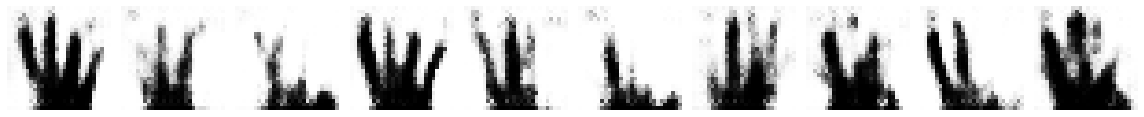

 33%|███▎      | 1000/3000 [02:32<09:03,  3.68it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 1001/3000 [02:32<07:54,  4.21it/s]

>1001, dr[0.354,0.055], df[0.418,0.013], g[2.268,0.070]
1/1 [==============================] - 0s 14ms/step


 33%|███▎      | 1002/3000 [02:32<06:57,  4.79it/s]

>1002, dr[0.507,0.012], df[0.512,0.035], g[2.237,0.060]
1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 1003/3000 [02:33<06:19,  5.26it/s]

>1003, dr[0.645,0.017], df[0.420,0.115], g[1.685,0.086]
1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 1004/3000 [02:33<05:57,  5.58it/s]

>1004, dr[0.396,0.023], df[0.454,0.048], g[1.932,0.034]
1/1 [==============================] - 0s 15ms/step


 34%|███▎      | 1005/3000 [02:33<05:39,  5.87it/s]

>1005, dr[0.387,0.086], df[0.292,0.010], g[1.793,0.093]
1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 1006/3000 [02:33<05:27,  6.09it/s]

>1006, dr[0.402,0.042], df[0.632,0.018], g[1.859,0.095]
1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 1007/3000 [02:33<05:14,  6.34it/s]

>1007, dr[0.540,0.004], df[0.297,0.102], g[1.602,0.085]
1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 1008/3000 [02:33<05:11,  6.40it/s]

>1008, dr[0.393,0.008], df[0.565,0.152], g[1.967,0.042]
1/1 [==============================] - 0s 15ms/step


 34%|███▎      | 1009/3000 [02:33<05:09,  6.44it/s]

>1009, dr[0.762,0.044], df[0.645,0.081], g[1.439,0.016]
1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 1010/3000 [02:34<05:11,  6.39it/s]

>1010, dr[0.346,0.013], df[0.771,0.012], g[1.782,0.099]
1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 1011/3000 [02:34<05:12,  6.37it/s]

>1011, dr[0.496,0.007], df[0.433,0.094], g[2.100,0.061]
1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 1012/3000 [02:34<05:13,  6.35it/s]

>1012, dr[0.624,0.013], df[0.432,0.024], g[2.001,0.111]
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1013/3000 [02:34<05:07,  6.46it/s]

>1013, dr[0.450,0.006], df[0.660,0.228], g[2.067,0.256]
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1014/3000 [02:34<05:06,  6.47it/s]

>1014, dr[0.393,0.010], df[0.320,0.018], g[1.905,0.060]
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1015/3000 [02:34<05:08,  6.43it/s]

>1015, dr[0.520,0.005], df[0.324,0.009], g[2.005,0.065]
1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 1016/3000 [02:35<05:03,  6.53it/s]

>1016, dr[0.351,0.002], df[0.382,0.038], g[1.720,0.049]
1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 1017/3000 [02:35<05:03,  6.52it/s]

>1017, dr[0.320,0.010], df[0.418,0.012], g[1.839,0.050]
1/1 [==============================] - 0s 14ms/step


 34%|███▍      | 1018/3000 [02:35<05:05,  6.49it/s]

>1018, dr[0.431,0.128], df[0.440,0.046], g[2.063,0.144]
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1019/3000 [02:35<05:09,  6.41it/s]

>1019, dr[0.405,0.007], df[0.565,0.013], g[2.210,0.021]
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1020/3000 [02:35<05:06,  6.46it/s]

>1020, dr[0.432,0.022], df[0.537,0.062], g[2.578,0.140]
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1021/3000 [02:35<05:09,  6.40it/s]

>1021, dr[0.514,0.002], df[0.238,0.103], g[2.196,0.020]
1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 1022/3000 [02:35<05:04,  6.50it/s]

>1022, dr[0.415,0.004], df[0.557,0.037], g[1.915,0.046]
1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 1023/3000 [02:36<05:10,  6.38it/s]

>1023, dr[0.503,0.003], df[0.295,0.021], g[1.840,0.132]
1/1 [==============================] - 0s 14ms/step


 34%|███▍      | 1024/3000 [02:36<05:08,  6.40it/s]

>1024, dr[0.392,0.006], df[0.394,0.113], g[1.934,0.031]
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1025/3000 [02:36<05:04,  6.49it/s]

>1025, dr[0.398,0.009], df[0.464,0.210], g[2.469,0.028]
1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 1026/3000 [02:36<05:07,  6.43it/s]

>1026, dr[0.590,0.015], df[0.312,0.008], g[1.547,0.066]
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1027/3000 [02:36<05:08,  6.39it/s]

>1027, dr[0.240,0.022], df[0.503,0.081], g[2.004,0.079]
1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 1028/3000 [02:36<05:06,  6.43it/s]

>1028, dr[0.413,0.002], df[0.486,0.038], g[2.604,0.058]
1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 1029/3000 [02:37<05:03,  6.49it/s]

>1029, dr[0.578,0.017], df[0.329,0.093], g[2.066,0.040]
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1030/3000 [02:37<05:06,  6.42it/s]

>1030, dr[0.263,0.003], df[0.485,0.006], g[2.603,0.019]
1/1 [==============================] - 0s 14ms/step


 34%|███▍      | 1031/3000 [02:37<05:14,  6.27it/s]

>1031, dr[0.394,0.006], df[0.307,0.019], g[2.509,0.053]
1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 1032/3000 [02:37<05:16,  6.22it/s]

>1032, dr[0.490,0.025], df[0.469,0.002], g[1.981,0.182]
1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 1033/3000 [02:37<05:12,  6.30it/s]

>1033, dr[0.370,0.025], df[0.386,0.134], g[1.788,0.035]
1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 1034/3000 [02:37<05:06,  6.41it/s]

>1034, dr[0.299,0.022], df[0.458,0.004], g[2.234,0.048]
1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 1035/3000 [02:38<05:01,  6.52it/s]

>1035, dr[0.592,0.008], df[0.416,0.009], g[1.873,0.012]
1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1036/3000 [02:38<05:00,  6.54it/s]

>1036, dr[0.258,0.048], df[0.430,0.040], g[2.414,0.013]
1/1 [==============================] - 0s 14ms/step


 35%|███▍      | 1037/3000 [02:38<05:05,  6.42it/s]

>1037, dr[0.418,0.007], df[0.416,0.009], g[2.151,0.067]
1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1038/3000 [02:38<05:05,  6.42it/s]

>1038, dr[0.402,0.021], df[0.269,0.067], g[2.226,0.036]
1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 1039/3000 [02:38<05:07,  6.37it/s]

>1039, dr[0.466,0.027], df[0.258,0.049], g[1.814,0.026]
1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 1040/3000 [02:38<05:07,  6.38it/s]

>1040, dr[0.527,0.002], df[0.672,0.012], g[1.475,0.040]
1/1 [==============================] - 0s 14ms/step


 35%|███▍      | 1041/3000 [02:38<05:09,  6.34it/s]

>1041, dr[0.351,0.009], df[0.671,0.094], g[1.817,0.009]
1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1042/3000 [02:39<05:07,  6.37it/s]

>1042, dr[0.536,0.003], df[0.498,0.015], g[2.019,0.028]
1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 1043/3000 [02:39<05:05,  6.40it/s]

>1043, dr[0.537,0.029], df[0.377,0.003], g[2.463,0.063]
1/1 [==============================] - 0s 14ms/step


 35%|███▍      | 1044/3000 [02:39<05:07,  6.35it/s]

>1044, dr[0.497,0.003], df[0.473,0.052], g[1.750,0.104]
1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 1045/3000 [02:39<05:03,  6.45it/s]

>1045, dr[0.344,0.003], df[0.180,0.001], g[2.018,0.032]
1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 1046/3000 [02:39<05:05,  6.40it/s]

>1046, dr[0.251,0.008], df[0.512,0.147], g[2.010,0.073]
1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 1047/3000 [02:39<05:07,  6.35it/s]

>1047, dr[0.270,0.007], df[0.437,0.028], g[2.402,0.026]
1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 1048/3000 [02:40<05:03,  6.43it/s]

>1048, dr[0.725,0.027], df[0.399,0.035], g[1.653,0.076]
1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 1049/3000 [02:40<04:58,  6.54it/s]

>1049, dr[0.413,0.011], df[0.384,0.034], g[2.067,0.072]
1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 1050/3000 [02:40<05:00,  6.48it/s]

>1050, dr[0.540,0.031], df[0.661,0.004], g[1.920,0.072]
1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 1051/3000 [02:40<05:00,  6.48it/s]

>1051, dr[0.311,0.024], df[0.499,0.025], g[2.446,0.061]
1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1052/3000 [02:40<05:03,  6.43it/s]

>1052, dr[0.374,0.003], df[0.458,0.055], g[2.216,0.024]
1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 1053/3000 [02:40<04:58,  6.52it/s]

>1053, dr[0.563,0.020], df[0.270,0.014], g[1.918,0.006]
1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 1054/3000 [02:40<05:06,  6.35it/s]

>1054, dr[0.335,0.007], df[0.316,0.107], g[2.189,0.037]
1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 1055/3000 [02:41<05:06,  6.34it/s]

>1055, dr[0.332,0.004], df[0.654,0.019], g[2.249,0.022]
1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 1056/3000 [02:41<05:03,  6.41it/s]

>1056, dr[0.461,0.005], df[0.388,0.007], g[2.372,0.040]
1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 1057/3000 [02:41<05:01,  6.44it/s]

>1057, dr[0.432,0.008], df[0.468,0.019], g[2.180,0.029]
1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 1058/3000 [02:41<05:07,  6.32it/s]

>1058, dr[0.483,0.064], df[0.471,0.042], g[2.440,0.019]
1/1 [==============================] - 0s 14ms/step


 35%|███▌      | 1059/3000 [02:41<05:00,  6.47it/s]

>1059, dr[0.393,0.045], df[0.437,0.007], g[2.245,0.124]
1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 1060/3000 [02:41<05:01,  6.44it/s]

>1060, dr[0.578,0.022], df[0.380,0.161], g[1.894,0.007]
1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 1061/3000 [02:42<05:03,  6.39it/s]

>1061, dr[0.446,0.003], df[0.556,0.041], g[1.931,0.043]
1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 1062/3000 [02:42<05:11,  6.22it/s]

>1062, dr[0.206,0.003], df[0.264,0.012], g[1.970,0.040]
1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 1063/3000 [02:42<05:07,  6.29it/s]

>1063, dr[0.597,0.009], df[0.483,0.017], g[1.938,0.025]
1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 1064/3000 [02:42<04:57,  6.51it/s]

>1064, dr[0.287,0.021], df[0.582,0.101], g[2.290,0.023]
1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1065/3000 [02:42<04:55,  6.55it/s]

>1065, dr[0.487,0.003], df[0.279,0.051], g[1.943,0.149]
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1066/3000 [02:42<04:50,  6.65it/s]

>1066, dr[0.435,0.028], df[0.546,0.063], g[2.256,0.060]
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1067/3000 [02:42<04:50,  6.66it/s]

>1067, dr[0.543,0.007], df[0.380,0.068], g[1.973,0.045]
1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1068/3000 [02:43<04:44,  6.79it/s]

>1068, dr[0.324,0.003], df[0.330,0.113], g[1.868,0.036]
1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 1069/3000 [02:43<04:46,  6.74it/s]

>1069, dr[0.303,0.008], df[0.484,0.049], g[2.555,0.025]
1/1 [==============================] - 0s 14ms/step


 36%|███▌      | 1070/3000 [02:43<04:50,  6.65it/s]

>1070, dr[0.414,0.009], df[0.555,0.059], g[2.181,0.026]
1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1071/3000 [02:43<04:48,  6.69it/s]

>1071, dr[0.514,0.015], df[0.379,0.135], g[2.010,0.025]
1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 1072/3000 [02:43<04:50,  6.63it/s]

>1072, dr[0.274,0.010], df[0.381,0.010], g[2.037,0.068]
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1073/3000 [02:43<04:50,  6.64it/s]

>1073, dr[0.380,0.003], df[0.548,0.061], g[2.191,0.059]
1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 1074/3000 [02:44<04:57,  6.48it/s]

>1074, dr[0.391,0.003], df[0.282,0.028], g[2.332,0.146]
1/1 [==============================] - 0s 13ms/step


 36%|███▌      | 1075/3000 [02:44<04:53,  6.55it/s]

>1075, dr[0.539,0.011], df[0.453,0.048], g[1.872,0.042]
1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 1076/3000 [02:44<04:53,  6.55it/s]

>1076, dr[0.400,0.003], df[0.363,0.017], g[1.868,0.026]
1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1077/3000 [02:44<04:52,  6.57it/s]

>1077, dr[0.351,0.003], df[0.395,0.019], g[1.558,0.080]
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1078/3000 [02:44<04:52,  6.56it/s]

>1078, dr[0.324,0.005], df[0.443,0.147], g[1.786,0.024]
1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 1079/3000 [02:44<04:59,  6.42it/s]

>1079, dr[0.455,0.021], df[0.400,0.049], g[1.982,0.097]
1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 1080/3000 [02:44<04:58,  6.42it/s]

>1080, dr[0.467,0.005], df[0.558,0.045], g[2.366,0.034]
1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 1081/3000 [02:45<04:56,  6.48it/s]

>1081, dr[0.398,0.007], df[0.570,0.003], g[2.122,0.053]
1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 1082/3000 [02:45<04:54,  6.52it/s]

>1082, dr[0.360,0.007], df[0.579,0.010], g[2.003,0.024]
1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1083/3000 [02:45<05:03,  6.33it/s]

>1083, dr[0.685,0.018], df[0.528,0.009], g[2.166,0.033]
1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1084/3000 [02:45<04:59,  6.39it/s]

>1084, dr[0.347,0.023], df[0.482,0.023], g[2.372,0.033]
1/1 [==============================] - 0s 15ms/step


 36%|███▌      | 1085/3000 [02:45<05:08,  6.20it/s]

>1085, dr[0.349,0.115], df[0.236,0.033], g[2.251,0.031]
1/1 [==============================] - 0s 14ms/step


 36%|███▌      | 1086/3000 [02:45<05:07,  6.23it/s]

>1086, dr[0.494,0.075], df[0.354,0.015], g[1.857,0.022]
1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 1087/3000 [02:46<05:05,  6.27it/s]

>1087, dr[0.488,0.011], df[0.533,0.016], g[1.693,0.020]
1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 1088/3000 [02:46<05:04,  6.27it/s]

>1088, dr[0.204,0.049], df[0.523,0.045], g[2.365,0.014]
1/1 [==============================] - 0s 15ms/step


 36%|███▋      | 1089/3000 [02:46<05:03,  6.29it/s]

>1089, dr[0.298,0.009], df[0.391,0.004], g[2.386,0.017]
1/1 [==============================] - 0s 14ms/step


 36%|███▋      | 1090/3000 [02:46<05:01,  6.33it/s]

>1090, dr[0.569,0.023], df[0.349,0.042], g[2.382,0.068]
1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 1091/3000 [02:46<04:56,  6.45it/s]

>1091, dr[0.493,0.017], df[0.394,0.075], g[1.933,0.006]
1/1 [==============================] - 0s 14ms/step


 36%|███▋      | 1092/3000 [02:46<05:01,  6.34it/s]

>1092, dr[0.215,0.029], df[0.555,0.038], g[2.429,0.031]
1/1 [==============================] - 0s 15ms/step


 36%|███▋      | 1093/3000 [02:47<04:59,  6.37it/s]

>1093, dr[0.527,0.011], df[0.325,0.008], g[2.288,0.062]
1/1 [==============================] - 0s 15ms/step


 36%|███▋      | 1094/3000 [02:47<05:02,  6.31it/s]

>1094, dr[0.332,0.014], df[0.426,0.028], g[1.940,0.019]
1/1 [==============================] - 0s 14ms/step


 36%|███▋      | 1095/3000 [02:47<05:02,  6.29it/s]

>1095, dr[0.397,0.017], df[0.407,0.007], g[2.164,0.099]
1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1096/3000 [02:47<04:56,  6.41it/s]

>1096, dr[0.378,0.004], df[0.610,0.195], g[2.743,0.097]
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1097/3000 [02:47<04:54,  6.46it/s]

>1097, dr[0.442,0.020], df[0.601,0.201], g[2.403,0.011]
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1098/3000 [02:47<04:57,  6.39it/s]

>1098, dr[0.658,0.016], df[0.244,0.003], g[2.276,0.015]
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1099/3000 [02:47<04:55,  6.43it/s]

>1099, dr[0.374,0.036], df[0.381,0.181], g[1.728,0.015]
1/1 [==============================] - 0s 15ms/step
>1100, dr[0.332,0.003], df[0.351,0.032], g[1.758,0.012]
1/1 [==============================] - 0s 20ms/step


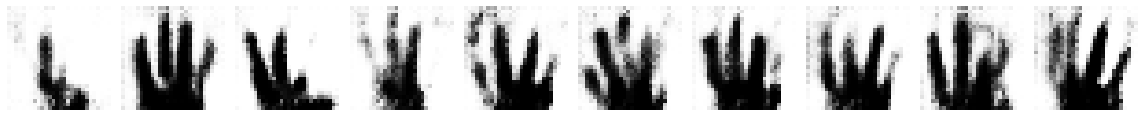

 37%|███▋      | 1100/3000 [02:48<08:36,  3.68it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1101/3000 [02:48<07:22,  4.29it/s]

>1101, dr[0.318,0.013], df[0.503,0.066], g[1.768,0.037]
1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 1102/3000 [02:48<06:33,  4.83it/s]

>1102, dr[0.462,0.014], df[0.353,0.046], g[1.750,0.018]
1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 1103/3000 [02:48<06:02,  5.23it/s]

>1103, dr[0.338,0.016], df[0.377,0.015], g[1.694,0.036]
1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 1104/3000 [02:49<05:42,  5.54it/s]

>1104, dr[0.304,0.003], df[0.603,0.005], g[2.269,0.027]
1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1105/3000 [02:49<05:20,  5.92it/s]

>1105, dr[0.364,0.003], df[0.208,0.101], g[2.272,0.082]
1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 1106/3000 [02:49<05:14,  6.01it/s]

>1106, dr[0.378,0.024], df[0.512,0.103], g[1.825,0.045]
1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1107/3000 [02:49<05:11,  6.08it/s]

>1107, dr[0.382,0.072], df[0.477,0.127], g[2.426,0.052]
1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 1108/3000 [02:49<05:04,  6.21it/s]

>1108, dr[0.608,0.080], df[0.360,0.080], g[1.802,0.070]
1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 1109/3000 [02:49<05:07,  6.14it/s]

>1109, dr[0.341,0.001], df[0.590,0.054], g[1.744,0.038]
1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1110/3000 [02:50<05:00,  6.28it/s]

>1110, dr[0.557,0.003], df[0.701,0.057], g[1.897,0.152]
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1111/3000 [02:50<04:57,  6.35it/s]

>1111, dr[0.405,0.015], df[0.297,0.135], g[1.871,0.030]
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1112/3000 [02:50<04:56,  6.36it/s]

>1112, dr[0.313,0.013], df[0.365,0.160], g[2.472,0.084]
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1113/3000 [02:50<04:58,  6.32it/s]

>1113, dr[0.228,0.006], df[0.441,0.006], g[2.591,0.060]
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1114/3000 [02:50<04:57,  6.34it/s]

>1114, dr[0.452,0.013], df[0.296,0.011], g[2.353,0.098]
1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 1115/3000 [02:50<04:56,  6.37it/s]

>1115, dr[0.478,0.004], df[0.471,0.120], g[1.981,0.021]
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1116/3000 [02:50<04:51,  6.46it/s]

>1116, dr[0.284,0.003], df[0.290,0.024], g[1.699,0.010]
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1117/3000 [02:51<04:49,  6.51it/s]

>1117, dr[0.588,0.003], df[0.560,0.116], g[1.888,0.060]
1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 1118/3000 [02:51<04:51,  6.46it/s]

>1118, dr[0.369,0.010], df[0.407,0.070], g[1.799,0.032]
1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 1119/3000 [02:51<04:51,  6.44it/s]

>1119, dr[0.375,0.006], df[0.317,0.128], g[2.012,0.026]
1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1120/3000 [02:51<04:57,  6.33it/s]

>1120, dr[0.426,0.010], df[0.528,0.004], g[1.993,0.038]
1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1121/3000 [02:51<05:02,  6.21it/s]

>1121, dr[0.303,0.009], df[0.369,0.106], g[2.094,0.025]
1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 1122/3000 [02:51<05:02,  6.21it/s]

>1122, dr[0.314,0.022], df[0.366,0.002], g[2.197,0.107]
1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 1123/3000 [02:52<05:02,  6.21it/s]

>1123, dr[0.287,0.003], df[0.290,0.030], g[2.160,0.088]
1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 1124/3000 [02:52<05:06,  6.12it/s]

>1124, dr[0.424,0.004], df[0.411,0.036], g[2.181,0.033]
1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1125/3000 [02:52<04:57,  6.30it/s]

>1125, dr[0.238,0.008], df[0.286,0.007], g[2.148,0.037]
1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 1126/3000 [02:52<04:54,  6.37it/s]

>1126, dr[0.400,0.010], df[0.303,0.055], g[1.947,0.104]
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1127/3000 [02:52<04:51,  6.43it/s]

>1127, dr[0.436,0.020], df[0.541,0.034], g[2.124,0.109]
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1128/3000 [02:52<04:53,  6.39it/s]

>1128, dr[0.613,0.010], df[0.310,0.037], g[1.924,0.085]
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1129/3000 [02:53<04:50,  6.44it/s]

>1129, dr[0.293,0.007], df[0.327,0.094], g[1.940,0.163]
1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1130/3000 [02:53<04:51,  6.42it/s]

>1130, dr[0.316,0.035], df[0.613,0.120], g[1.900,0.044]
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1131/3000 [02:53<05:00,  6.22it/s]

>1131, dr[0.403,0.002], df[0.453,0.027], g[2.484,0.009]
1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1132/3000 [02:53<04:57,  6.28it/s]

>1132, dr[0.567,0.010], df[0.326,0.044], g[1.815,0.177]
1/1 [==============================] - 0s 14ms/step


 38%|███▊      | 1133/3000 [02:53<04:56,  6.29it/s]

>1133, dr[0.316,0.004], df[0.438,0.067], g[2.001,0.023]
1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1134/3000 [02:53<05:04,  6.13it/s]

>1134, dr[0.333,0.045], df[0.410,0.046], g[2.137,0.009]
1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1135/3000 [02:54<05:05,  6.11it/s]

>1135, dr[0.413,0.076], df[0.420,0.095], g[2.169,0.108]
1/1 [==============================] - 0s 13ms/step


 38%|███▊      | 1136/3000 [02:54<05:00,  6.20it/s]

>1136, dr[0.382,0.009], df[0.430,0.106], g[2.222,0.051]
1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1137/3000 [02:54<04:57,  6.26it/s]

>1137, dr[0.435,0.002], df[0.290,0.012], g[2.424,0.049]
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1138/3000 [02:54<04:49,  6.43it/s]

>1138, dr[0.444,0.003], df[0.461,0.053], g[1.821,0.062]
1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 1139/3000 [02:54<04:54,  6.31it/s]

>1139, dr[0.384,0.018], df[0.357,0.008], g[1.764,0.094]
1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1140/3000 [02:54<04:55,  6.29it/s]

>1140, dr[0.308,0.008], df[0.223,0.025], g[2.128,0.015]
1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1141/3000 [02:54<04:59,  6.21it/s]

>1141, dr[0.298,0.011], df[0.401,0.013], g[2.080,0.011]
1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1142/3000 [02:55<04:53,  6.33it/s]

>1142, dr[0.214,0.009], df[0.400,0.005], g[2.522,0.045]
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1143/3000 [02:55<04:47,  6.45it/s]

>1143, dr[0.349,0.013], df[0.322,0.152], g[2.187,0.035]
1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 1144/3000 [02:55<04:50,  6.38it/s]

>1144, dr[0.296,0.001], df[0.600,0.133], g[2.341,0.133]
1/1 [==============================] - 0s 14ms/step


 38%|███▊      | 1145/3000 [02:55<04:50,  6.39it/s]

>1145, dr[0.412,0.020], df[0.349,0.156], g[2.581,0.015]
1/1 [==============================] - 0s 14ms/step


 38%|███▊      | 1146/3000 [02:55<04:45,  6.49it/s]

>1146, dr[0.550,0.069], df[0.349,0.065], g[2.511,0.096]
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1147/3000 [02:55<04:47,  6.45it/s]

>1147, dr[0.416,0.104], df[0.647,0.012], g[1.636,0.016]
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1148/3000 [02:56<04:53,  6.32it/s]

>1148, dr[0.265,0.004], df[0.252,0.077], g[1.875,0.033]
1/1 [==============================] - 0s 14ms/step


 38%|███▊      | 1149/3000 [02:56<04:52,  6.33it/s]

>1149, dr[0.186,0.007], df[0.516,0.064], g[2.273,0.144]
1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 1150/3000 [02:56<04:47,  6.43it/s]

>1150, dr[0.333,0.011], df[0.310,0.046], g[2.676,0.030]
1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 1151/3000 [02:56<04:43,  6.53it/s]

>1151, dr[0.549,0.003], df[0.252,0.066], g[2.095,0.006]
1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 1152/3000 [02:56<04:42,  6.54it/s]

>1152, dr[0.256,0.004], df[0.278,0.005], g[1.878,0.061]
1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 1153/3000 [02:56<04:42,  6.53it/s]

>1153, dr[0.335,0.013], df[0.416,0.074], g[2.088,0.013]
1/1 [==============================] - 0s 13ms/step


 38%|███▊      | 1154/3000 [02:56<04:47,  6.43it/s]

>1154, dr[0.421,0.005], df[0.384,0.030], g[2.174,0.073]
1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 1155/3000 [02:57<04:44,  6.49it/s]

>1155, dr[0.301,0.004], df[0.525,0.006], g[2.620,0.040]
1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 1156/3000 [02:57<04:56,  6.22it/s]

>1156, dr[0.661,0.022], df[0.505,0.005], g[1.891,0.018]
1/1 [==============================] - 0s 14ms/step


 39%|███▊      | 1157/3000 [02:57<04:57,  6.20it/s]

>1157, dr[0.338,0.071], df[0.498,0.049], g[2.136,0.015]
1/1 [==============================] - 0s 15ms/step


 39%|███▊      | 1158/3000 [02:57<04:57,  6.20it/s]

>1158, dr[0.205,0.040], df[0.329,0.002], g[1.868,0.011]
1/1 [==============================] - 0s 14ms/step


 39%|███▊      | 1159/3000 [02:57<04:54,  6.25it/s]

>1159, dr[0.474,0.049], df[0.308,0.075], g[2.180,0.059]
1/1 [==============================] - 0s 15ms/step


 39%|███▊      | 1160/3000 [02:57<04:54,  6.24it/s]

>1160, dr[0.362,0.008], df[0.329,0.004], g[2.296,0.055]
1/1 [==============================] - 0s 15ms/step


 39%|███▊      | 1161/3000 [02:58<04:54,  6.25it/s]

>1161, dr[0.406,0.003], df[0.446,0.080], g[1.956,0.057]
1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 1162/3000 [02:58<04:54,  6.23it/s]

>1162, dr[0.160,0.001], df[0.280,0.039], g[2.271,0.016]
1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1163/3000 [02:58<04:53,  6.27it/s]

>1163, dr[0.346,0.013], df[0.257,0.098], g[2.115,0.016]
1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1164/3000 [02:58<04:45,  6.43it/s]

>1164, dr[0.285,0.002], df[0.518,0.003], g[2.031,0.065]
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1165/3000 [02:58<04:45,  6.43it/s]

>1165, dr[0.343,0.014], df[0.374,0.132], g[2.358,0.013]
1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 1166/3000 [02:58<04:48,  6.36it/s]

>1166, dr[0.477,0.016], df[0.340,0.092], g[2.808,0.037]
1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1167/3000 [02:59<04:52,  6.27it/s]

>1167, dr[0.498,0.028], df[0.499,0.028], g[2.417,0.116]
1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 1168/3000 [02:59<04:45,  6.42it/s]

>1168, dr[0.482,0.004], df[0.269,0.003], g[1.907,0.051]
1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1169/3000 [02:59<04:51,  6.29it/s]

>1169, dr[0.258,0.021], df[0.312,0.101], g[1.809,0.121]
1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 1170/3000 [02:59<04:44,  6.44it/s]

>1170, dr[0.337,0.003], df[0.406,0.010], g[2.038,0.049]
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 1171/3000 [02:59<04:43,  6.46it/s]

>1171, dr[0.270,0.004], df[0.365,0.063], g[2.049,0.094]
1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 1172/3000 [02:59<04:47,  6.36it/s]

>1172, dr[0.350,0.018], df[0.299,0.017], g[2.362,0.073]
1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 1173/3000 [02:59<04:44,  6.42it/s]

>1173, dr[0.403,0.106], df[0.258,0.005], g[1.705,0.101]
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1174/3000 [03:00<04:43,  6.45it/s]

>1174, dr[0.335,0.018], df[0.846,0.144], g[1.846,0.061]
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1175/3000 [03:00<04:51,  6.26it/s]

>1175, dr[0.402,0.028], df[0.647,0.078], g[2.336,0.038]
1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 1176/3000 [03:00<04:48,  6.32it/s]

>1176, dr[0.528,0.005], df[0.276,0.045], g[2.707,0.020]
1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 1177/3000 [03:00<04:46,  6.36it/s]

>1177, dr[0.368,0.008], df[0.191,0.479], g[1.808,0.092]
1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 1178/3000 [03:00<04:45,  6.37it/s]

>1178, dr[0.464,0.005], df[0.636,0.255], g[1.806,0.017]
1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 1179/3000 [03:00<04:46,  6.35it/s]

>1179, dr[0.314,0.048], df[0.411,0.005], g[1.730,0.074]
1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 1180/3000 [03:01<04:45,  6.38it/s]

>1180, dr[0.504,0.004], df[0.394,0.005], g[1.931,0.024]
1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 1181/3000 [03:01<04:46,  6.34it/s]

>1181, dr[0.219,0.005], df[0.612,0.043], g[2.413,0.056]
1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 1182/3000 [03:01<04:44,  6.39it/s]

>1182, dr[0.403,0.015], df[0.508,0.039], g[2.532,0.033]
1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 1183/3000 [03:01<04:47,  6.33it/s]

>1183, dr[0.690,0.028], df[0.193,0.105], g[1.778,0.022]
1/1 [==============================] - 0s 14ms/step


 39%|███▉      | 1184/3000 [03:01<04:46,  6.34it/s]

>1184, dr[0.355,0.005], df[0.473,0.006], g[1.919,0.058]
1/1 [==============================] - 0s 392ms/step


 40%|███▉      | 1185/3000 [03:02<08:11,  3.69it/s]

>1185, dr[0.305,0.020], df[0.305,0.023], g[1.799,0.061]
1/1 [==============================] - 0s 14ms/step


 40%|███▉      | 1186/3000 [03:02<07:17,  4.14it/s]

>1186, dr[0.270,0.006], df[0.530,0.039], g[1.800,0.021]
1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 1187/3000 [03:02<06:28,  4.67it/s]

>1187, dr[0.579,0.035], df[0.323,0.010], g[1.312,0.054]
1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 1188/3000 [03:02<05:53,  5.13it/s]

>1188, dr[0.214,0.016], df[0.538,0.041], g[1.915,0.075]
1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 1189/3000 [03:02<05:31,  5.46it/s]

>1189, dr[0.349,0.022], df[0.445,0.009], g[2.056,0.079]
1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 1190/3000 [03:03<05:16,  5.71it/s]

>1190, dr[0.319,0.002], df[0.443,0.016], g[2.462,0.027]
1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1191/3000 [03:03<05:08,  5.86it/s]

>1191, dr[0.506,0.009], df[0.325,0.004], g[2.102,0.151]
1/1 [==============================] - 0s 14ms/step


 40%|███▉      | 1192/3000 [03:03<05:01,  5.99it/s]

>1192, dr[0.587,0.009], df[0.519,0.085], g[1.850,0.220]
1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 1193/3000 [03:03<04:54,  6.13it/s]

>1193, dr[0.385,0.020], df[0.411,0.016], g[1.976,0.038]
1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 1194/3000 [03:03<04:54,  6.14it/s]

>1194, dr[0.567,0.016], df[0.754,0.068], g[2.214,0.060]
1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1195/3000 [03:03<04:48,  6.25it/s]

>1195, dr[0.397,0.006], df[0.326,0.093], g[2.452,0.046]
1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 1196/3000 [03:03<04:45,  6.33it/s]

>1196, dr[0.399,0.004], df[0.328,0.050], g[1.783,0.087]
1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 1197/3000 [03:04<04:44,  6.33it/s]

>1197, dr[0.255,0.002], df[0.292,0.008], g[2.164,0.052]
1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 1198/3000 [03:04<04:43,  6.35it/s]

>1198, dr[0.362,0.009], df[0.527,0.035], g[2.153,0.123]
1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 1199/3000 [03:04<04:45,  6.30it/s]

>1199, dr[0.261,0.112], df[0.324,0.119], g[2.315,0.115]
1/1 [==============================] - 0s 18ms/step
>1200, dr[0.269,0.007], df[0.250,0.066], g[2.367,0.015]
1/1 [==============================] - 0s 26ms/step


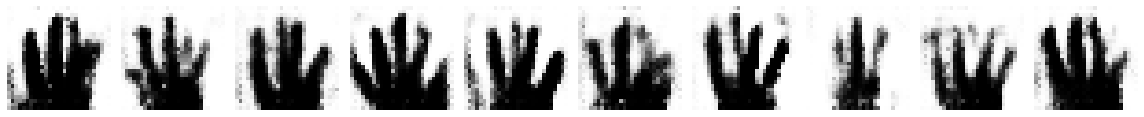

 40%|████      | 1200/3000 [03:04<08:11,  3.66it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 1201/3000 [03:05<07:10,  4.18it/s]

>1201, dr[0.320,0.082], df[0.406,0.010], g[2.071,0.050]
1/1 [==============================] - 0s 14ms/step


 40%|████      | 1202/3000 [03:05<06:19,  4.74it/s]

>1202, dr[0.314,0.061], df[0.174,0.062], g[2.146,0.080]
1/1 [==============================] - 0s 18ms/step


 40%|████      | 1203/3000 [03:05<05:51,  5.11it/s]

>1203, dr[0.439,0.008], df[0.499,0.022], g[1.877,0.024]
1/1 [==============================] - 0s 21ms/step


 40%|████      | 1204/3000 [03:05<05:34,  5.37it/s]

>1204, dr[0.269,0.041], df[0.439,0.122], g[1.955,0.085]
1/1 [==============================] - 0s 15ms/step


 40%|████      | 1205/3000 [03:05<05:17,  5.65it/s]

>1205, dr[0.386,0.005], df[0.405,0.061], g[2.355,0.165]
1/1 [==============================] - 0s 18ms/step


 40%|████      | 1206/3000 [03:05<05:08,  5.82it/s]

>1206, dr[0.347,0.013], df[0.194,0.015], g[2.129,0.117]
1/1 [==============================] - 0s 17ms/step


 40%|████      | 1207/3000 [03:06<04:56,  6.04it/s]

>1207, dr[0.326,0.009], df[0.415,0.074], g[1.956,0.124]
1/1 [==============================] - 0s 33ms/step


 40%|████      | 1208/3000 [03:06<05:02,  5.93it/s]

>1208, dr[0.574,0.028], df[0.461,0.025], g[1.879,0.089]
1/1 [==============================] - 0s 14ms/step


 40%|████      | 1209/3000 [03:06<05:00,  5.96it/s]

>1209, dr[0.315,0.007], df[0.454,0.045], g[2.567,0.042]
1/1 [==============================] - 0s 17ms/step


 40%|████      | 1210/3000 [03:06<04:54,  6.08it/s]

>1210, dr[0.460,0.008], df[0.346,0.002], g[2.097,0.256]
1/1 [==============================] - 0s 16ms/step


 40%|████      | 1211/3000 [03:06<04:50,  6.15it/s]

>1211, dr[0.314,0.005], df[0.414,0.125], g[2.084,0.058]
1/1 [==============================] - 0s 14ms/step


 40%|████      | 1212/3000 [03:06<04:44,  6.28it/s]

>1212, dr[0.332,0.011], df[0.309,0.018], g[2.205,0.090]
1/1 [==============================] - 0s 17ms/step


 40%|████      | 1213/3000 [03:07<04:40,  6.36it/s]

>1213, dr[0.182,0.002], df[0.369,0.071], g[2.111,0.033]
1/1 [==============================] - 0s 19ms/step


 40%|████      | 1214/3000 [03:07<04:54,  6.06it/s]

>1214, dr[0.311,0.014], df[0.593,0.068], g[2.406,0.069]
1/1 [==============================] - 0s 15ms/step


 40%|████      | 1215/3000 [03:07<04:59,  5.96it/s]

>1215, dr[0.662,0.004], df[0.370,0.028], g[1.968,0.170]
1/1 [==============================] - 0s 14ms/step


 41%|████      | 1216/3000 [03:07<04:53,  6.08it/s]

>1216, dr[0.276,0.024], df[0.208,0.011], g[1.925,0.066]
1/1 [==============================] - 0s 15ms/step


 41%|████      | 1217/3000 [03:07<04:47,  6.20it/s]

>1217, dr[0.174,0.014], df[0.605,0.159], g[2.778,0.044]
1/1 [==============================] - 0s 18ms/step


 41%|████      | 1218/3000 [03:07<04:40,  6.36it/s]

>1218, dr[0.462,0.109], df[0.308,0.104], g[2.706,0.050]
1/1 [==============================] - 0s 23ms/step


 41%|████      | 1219/3000 [03:08<04:37,  6.43it/s]

>1219, dr[0.447,0.016], df[0.264,0.002], g[1.773,0.049]
1/1 [==============================] - 0s 16ms/step


 41%|████      | 1220/3000 [03:08<04:39,  6.36it/s]

>1220, dr[0.277,0.020], df[0.523,0.009], g[2.677,0.022]
1/1 [==============================] - 0s 15ms/step


 41%|████      | 1221/3000 [03:08<04:40,  6.34it/s]

>1221, dr[0.302,0.003], df[0.393,0.056], g[3.232,0.072]
1/1 [==============================] - 0s 16ms/step


 41%|████      | 1222/3000 [03:08<04:44,  6.24it/s]

>1222, dr[0.740,0.003], df[0.371,0.008], g[1.945,0.067]
1/1 [==============================] - 0s 14ms/step


 41%|████      | 1223/3000 [03:08<04:50,  6.13it/s]

>1223, dr[0.410,0.006], df[0.637,0.009], g[1.955,0.057]
1/1 [==============================] - 0s 17ms/step


 41%|████      | 1224/3000 [03:08<04:46,  6.20it/s]

>1224, dr[0.251,0.006], df[0.379,0.054], g[1.676,0.118]
1/1 [==============================] - 0s 17ms/step


 41%|████      | 1225/3000 [03:08<04:43,  6.25it/s]

>1225, dr[0.509,0.002], df[0.398,0.013], g[2.522,0.061]
1/1 [==============================] - 0s 19ms/step


 41%|████      | 1226/3000 [03:09<04:42,  6.28it/s]

>1226, dr[0.442,0.012], df[0.362,0.034], g[1.938,0.029]
1/1 [==============================] - 0s 18ms/step


 41%|████      | 1227/3000 [03:09<04:47,  6.17it/s]

>1227, dr[0.258,0.052], df[0.334,0.011], g[2.004,0.035]
1/1 [==============================] - 0s 14ms/step


 41%|████      | 1228/3000 [03:09<04:46,  6.18it/s]

>1228, dr[0.287,0.011], df[0.623,0.035], g[2.097,0.086]
1/1 [==============================] - 0s 15ms/step


 41%|████      | 1229/3000 [03:09<04:42,  6.26it/s]

>1229, dr[0.670,0.007], df[0.621,0.025], g[2.513,0.035]
1/1 [==============================] - 0s 18ms/step


 41%|████      | 1230/3000 [03:09<04:45,  6.20it/s]

>1230, dr[0.482,0.020], df[0.300,0.060], g[2.113,0.096]
1/1 [==============================] - 0s 14ms/step


 41%|████      | 1231/3000 [03:09<04:38,  6.36it/s]

>1231, dr[0.352,0.007], df[0.434,0.055], g[2.573,0.119]
1/1 [==============================] - 0s 18ms/step


 41%|████      | 1232/3000 [03:10<04:36,  6.40it/s]

>1232, dr[0.547,0.003], df[0.326,0.017], g[1.874,0.032]
1/1 [==============================] - 0s 17ms/step


 41%|████      | 1233/3000 [03:10<04:38,  6.35it/s]

>1233, dr[0.356,0.021], df[0.513,0.137], g[1.935,0.023]
1/1 [==============================] - 0s 18ms/step


 41%|████      | 1234/3000 [03:10<04:41,  6.27it/s]

>1234, dr[0.285,0.001], df[0.267,0.048], g[2.388,0.050]
1/1 [==============================] - 0s 16ms/step


 41%|████      | 1235/3000 [03:10<04:35,  6.41it/s]

>1235, dr[0.320,0.120], df[0.313,0.055], g[2.241,0.015]
1/1 [==============================] - 0s 19ms/step


 41%|████      | 1236/3000 [03:10<04:32,  6.48it/s]

>1236, dr[0.350,0.003], df[0.230,0.167], g[2.119,0.113]
1/1 [==============================] - 0s 20ms/step


 41%|████      | 1237/3000 [03:10<04:35,  6.40it/s]

>1237, dr[0.213,0.002], df[0.447,0.079], g[2.797,0.071]
1/1 [==============================] - 0s 13ms/step


 41%|████▏     | 1238/3000 [03:11<04:36,  6.37it/s]

>1238, dr[0.440,0.023], df[0.317,0.058], g[2.296,0.070]
1/1 [==============================] - 0s 15ms/step


 41%|████▏     | 1239/3000 [03:11<04:38,  6.32it/s]

>1239, dr[0.258,0.024], df[0.310,0.019], g[2.068,0.054]
1/1 [==============================] - 0s 14ms/step


 41%|████▏     | 1240/3000 [03:11<04:47,  6.13it/s]

>1240, dr[0.598,0.012], df[0.257,0.028], g[2.119,0.041]
1/1 [==============================] - 0s 14ms/step


 41%|████▏     | 1241/3000 [03:11<04:43,  6.20it/s]

>1241, dr[0.371,0.003], df[0.472,0.055], g[2.054,0.017]
1/1 [==============================] - 0s 14ms/step


 41%|████▏     | 1242/3000 [03:11<04:38,  6.30it/s]

>1242, dr[0.193,0.005], df[0.486,0.013], g[2.511,0.035]
1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 1243/3000 [03:11<04:39,  6.29it/s]

>1243, dr[0.381,0.054], df[0.403,0.035], g[2.528,0.012]
1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 1244/3000 [03:11<04:34,  6.39it/s]

>1244, dr[0.648,0.037], df[0.369,0.055], g[2.217,0.032]
1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1245/3000 [03:12<04:41,  6.24it/s]

>1245, dr[0.227,0.028], df[0.365,0.062], g[2.037,0.162]
1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1246/3000 [03:12<04:51,  6.01it/s]

>1246, dr[0.341,0.027], df[0.268,0.024], g[2.544,0.021]
1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1247/3000 [03:12<04:50,  6.04it/s]

>1247, dr[0.397,0.262], df[0.372,0.129], g[2.202,0.087]
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1248/3000 [03:12<04:53,  5.98it/s]

>1248, dr[0.321,0.003], df[0.475,0.119], g[2.188,0.009]
1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1249/3000 [03:12<04:53,  5.97it/s]

>1249, dr[0.319,0.004], df[0.208,0.191], g[2.155,0.032]
1/1 [==============================] - 0s 14ms/step


 42%|████▏     | 1250/3000 [03:12<04:48,  6.06it/s]

>1250, dr[0.410,0.049], df[0.299,0.067], g[1.895,0.162]
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1251/3000 [03:13<04:40,  6.23it/s]

>1251, dr[0.353,0.012], df[0.633,0.275], g[2.335,0.037]
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1252/3000 [03:13<04:37,  6.29it/s]

>1252, dr[0.315,0.009], df[0.369,0.015], g[2.206,0.015]
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1253/3000 [03:13<04:47,  6.08it/s]

>1253, dr[0.261,0.008], df[0.295,0.138], g[2.813,0.065]
1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1254/3000 [03:13<04:41,  6.20it/s]

>1254, dr[0.503,0.017], df[0.454,0.014], g[2.440,0.012]
1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 1255/3000 [03:13<04:36,  6.30it/s]

>1255, dr[0.387,0.014], df[0.472,0.107], g[2.142,0.111]
1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 1256/3000 [03:13<04:43,  6.15it/s]

>1256, dr[0.412,0.005], df[0.557,0.002], g[2.630,0.079]
1/1 [==============================] - 0s 14ms/step


 42%|████▏     | 1257/3000 [03:14<04:40,  6.21it/s]

>1257, dr[0.340,0.002], df[0.285,0.043], g[2.353,0.023]
1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 1258/3000 [03:14<04:44,  6.13it/s]

>1258, dr[0.287,0.004], df[0.428,0.017], g[3.144,0.015]
1/1 [==============================] - 0s 14ms/step


 42%|████▏     | 1259/3000 [03:14<04:45,  6.10it/s]

>1259, dr[0.388,0.022], df[0.380,0.006], g[2.305,0.102]
1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1260/3000 [03:14<04:41,  6.19it/s]

>1260, dr[0.426,0.003], df[0.413,0.019], g[1.990,0.017]
1/1 [==============================] - 0s 14ms/step


 42%|████▏     | 1261/3000 [03:14<04:40,  6.20it/s]

>1261, dr[0.203,0.002], df[0.318,0.062], g[2.109,0.068]
1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1262/3000 [03:14<04:35,  6.30it/s]

>1262, dr[0.329,0.007], df[0.154,0.076], g[1.480,0.046]
1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1263/3000 [03:15<04:38,  6.23it/s]

>1263, dr[0.328,0.020], df[0.505,0.160], g[1.874,0.078]
1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1264/3000 [03:15<04:32,  6.36it/s]

>1264, dr[0.243,0.036], df[0.348,0.030], g[2.580,0.015]
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1265/3000 [03:15<04:34,  6.31it/s]

>1265, dr[0.416,0.095], df[0.687,0.041], g[2.391,0.058]
1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1266/3000 [03:15<04:38,  6.22it/s]

>1266, dr[0.552,0.044], df[0.236,0.047], g[2.013,0.059]
1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1267/3000 [03:15<04:39,  6.19it/s]

>1267, dr[0.182,0.002], df[0.237,0.026], g[2.246,0.083]
1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1268/3000 [03:15<04:42,  6.13it/s]

>1268, dr[0.303,0.001], df[0.352,0.011], g[2.057,0.050]
1/1 [==============================] - 0s 14ms/step


 42%|████▏     | 1269/3000 [03:16<04:42,  6.13it/s]

>1269, dr[0.333,0.023], df[0.274,0.025], g[1.808,0.022]
1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 1270/3000 [03:16<04:43,  6.10it/s]

>1270, dr[0.304,0.002], df[0.516,0.068], g[2.307,0.045]
1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 1271/3000 [03:16<04:45,  6.05it/s]

>1271, dr[0.486,0.014], df[0.464,0.081], g[2.098,0.021]
1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 1272/3000 [03:16<04:48,  6.00it/s]

>1272, dr[0.175,0.003], df[0.365,0.026], g[2.057,0.136]
1/1 [==============================] - 0s 14ms/step


 42%|████▏     | 1273/3000 [03:16<04:36,  6.24it/s]

>1273, dr[0.416,0.045], df[0.324,0.032], g[2.206,0.142]
1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 1274/3000 [03:16<04:38,  6.19it/s]

>1274, dr[0.465,0.075], df[0.182,0.071], g[1.484,0.028]
1/1 [==============================] - 0s 14ms/step


 42%|████▎     | 1275/3000 [03:17<04:37,  6.22it/s]

>1275, dr[0.353,0.006], df[0.318,0.085], g[1.476,0.005]
1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 1276/3000 [03:17<04:37,  6.22it/s]

>1276, dr[0.248,0.010], df[0.702,0.085], g[2.261,0.082]
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1277/3000 [03:17<04:36,  6.23it/s]

>1277, dr[0.397,0.002], df[0.269,0.181], g[2.498,0.030]
1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 1278/3000 [03:17<04:37,  6.20it/s]

>1278, dr[0.456,0.003], df[0.295,0.081], g[1.703,0.066]
1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1279/3000 [03:17<04:40,  6.13it/s]

>1279, dr[0.252,0.006], df[0.362,0.079], g[2.598,0.084]
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1280/3000 [03:17<04:38,  6.18it/s]

>1280, dr[0.336,0.003], df[0.248,0.100], g[2.273,0.040]
1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 1281/3000 [03:17<04:37,  6.19it/s]

>1281, dr[0.308,0.011], df[0.295,0.075], g[2.121,0.022]
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1282/3000 [03:18<04:33,  6.28it/s]

>1282, dr[0.242,0.012], df[0.368,0.017], g[2.694,0.033]
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1283/3000 [03:18<04:35,  6.23it/s]

>1283, dr[0.354,0.003], df[0.241,0.013], g[2.218,0.072]
1/1 [==============================] - 0s 14ms/step


 43%|████▎     | 1284/3000 [03:18<04:40,  6.11it/s]

>1284, dr[0.371,0.017], df[0.359,0.001], g[1.926,0.095]
1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 1285/3000 [03:18<04:35,  6.23it/s]

>1285, dr[0.386,0.003], df[0.437,0.020], g[2.218,0.049]
1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1286/3000 [03:18<04:34,  6.23it/s]

>1286, dr[0.530,0.003], df[0.352,0.086], g[1.783,0.071]
1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1287/3000 [03:18<04:30,  6.34it/s]

>1287, dr[0.199,0.014], df[0.657,0.030], g[2.163,0.072]
1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 1288/3000 [03:19<04:30,  6.32it/s]

>1288, dr[0.305,0.003], df[0.328,0.113], g[3.703,0.028]
1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 1289/3000 [03:19<04:23,  6.49it/s]

>1289, dr[0.638,0.006], df[0.311,0.041], g[1.969,0.019]
1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1290/3000 [03:19<04:17,  6.63it/s]

>1290, dr[0.394,0.007], df[0.334,0.054], g[2.021,0.092]
1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1291/3000 [03:19<04:22,  6.50it/s]

>1291, dr[0.322,0.003], df[0.334,0.097], g[1.960,0.028]
1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 1292/3000 [03:19<04:24,  6.45it/s]

>1292, dr[0.336,0.012], df[0.667,0.080], g[2.248,0.019]
1/1 [==============================] - 0s 14ms/step


 43%|████▎     | 1293/3000 [03:19<04:24,  6.46it/s]

>1293, dr[0.366,0.023], df[0.338,0.007], g[2.553,0.032]
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1294/3000 [03:20<04:27,  6.38it/s]

>1294, dr[0.354,0.015], df[0.235,0.009], g[2.798,0.022]
1/1 [==============================] - 0s 14ms/step


 43%|████▎     | 1295/3000 [03:20<04:23,  6.48it/s]

>1295, dr[0.392,0.060], df[0.162,0.044], g[1.848,0.050]
1/1 [==============================] - 0s 14ms/step


 43%|████▎     | 1296/3000 [03:20<04:29,  6.33it/s]

>1296, dr[0.325,0.024], df[0.405,0.028], g[1.835,0.033]
1/1 [==============================] - 0s 15ms/step


 43%|████▎     | 1297/3000 [03:20<04:34,  6.21it/s]

>1297, dr[0.178,0.036], df[0.326,0.050], g[2.512,0.047]
1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 1298/3000 [03:20<04:44,  5.98it/s]

>1298, dr[0.399,0.012], df[0.291,0.075], g[1.725,0.175]
1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 1299/3000 [03:20<04:50,  5.86it/s]

>1299, dr[0.358,0.036], df[0.407,0.131], g[1.664,0.012]
1/1 [==============================] - 0s 17ms/step
>1300, dr[0.260,0.012], df[0.622,0.027], g[2.563,0.070]
1/1 [==============================] - 0s 23ms/step


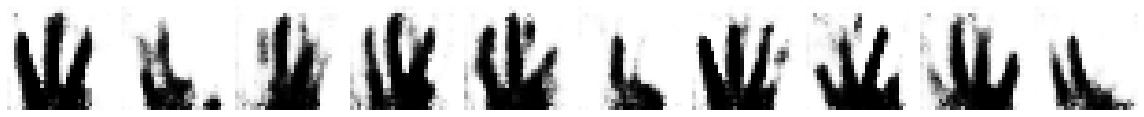

 43%|████▎     | 1300/3000 [03:21<08:18,  3.41it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 1301/3000 [03:21<07:12,  3.93it/s]

>1301, dr[0.490,0.016], df[0.287,0.011], g[2.746,0.083]
1/1 [==============================] - 0s 14ms/step


 43%|████▎     | 1302/3000 [03:21<06:14,  4.54it/s]

>1302, dr[0.663,0.038], df[0.540,0.354], g[2.681,0.041]
1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 1303/3000 [03:21<05:40,  4.99it/s]

>1303, dr[0.274,0.002], df[0.388,0.015], g[2.246,0.036]
1/1 [==============================] - 0s 14ms/step


 43%|████▎     | 1304/3000 [03:22<05:23,  5.24it/s]

>1304, dr[0.497,0.089], df[0.615,0.065], g[2.287,0.097]
1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 1305/3000 [03:22<05:07,  5.52it/s]

>1305, dr[0.330,0.033], df[0.359,0.173], g[2.848,0.050]
1/1 [==============================] - 0s 14ms/step


 44%|████▎     | 1306/3000 [03:22<04:54,  5.75it/s]

>1306, dr[0.483,0.032], df[0.318,0.114], g[2.241,0.037]
1/1 [==============================] - 0s 14ms/step


 44%|████▎     | 1307/3000 [03:22<04:46,  5.90it/s]

>1307, dr[0.328,0.007], df[0.493,0.076], g[2.414,0.025]
1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 1308/3000 [03:22<04:51,  5.80it/s]

>1308, dr[0.393,0.040], df[0.449,0.048], g[2.738,0.100]
1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 1309/3000 [03:22<04:44,  5.95it/s]

>1309, dr[0.356,0.010], df[0.400,0.144], g[2.021,0.142]
1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 1310/3000 [03:23<04:42,  5.97it/s]

>1310, dr[0.387,0.024], df[0.496,0.051], g[2.122,0.100]
1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 1311/3000 [03:23<04:32,  6.19it/s]

>1311, dr[0.163,0.011], df[0.237,0.084], g[2.515,0.033]
1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 1312/3000 [03:23<04:35,  6.13it/s]

>1312, dr[0.507,0.003], df[0.257,0.058], g[2.511,0.064]
1/1 [==============================] - 0s 16ms/step
>1313, dr[0.270,0.002], df[0.548,0.084], g[2.058,0.021]


 44%|████▍     | 1313/3000 [03:23<04:55,  5.70it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 1314/3000 [03:23<04:50,  5.80it/s]

>1314, dr[0.263,0.004], df[0.274,0.096], g[2.248,0.070]
1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1315/3000 [03:23<04:42,  5.97it/s]

>1315, dr[0.321,0.001], df[0.413,0.061], g[3.096,0.140]
1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 1316/3000 [03:24<04:37,  6.06it/s]

>1316, dr[0.414,0.021], df[0.370,0.141], g[2.626,0.161]
1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1317/3000 [03:24<04:34,  6.13it/s]

>1317, dr[0.560,0.010], df[0.416,0.106], g[1.809,0.087]
1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1318/3000 [03:24<04:31,  6.20it/s]

>1318, dr[0.241,0.003], df[0.442,0.039], g[2.321,0.046]
1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1319/3000 [03:24<04:30,  6.22it/s]

>1319, dr[0.515,0.010], df[0.486,0.037], g[2.100,0.203]
1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 1320/3000 [03:24<04:25,  6.32it/s]

>1320, dr[0.210,0.000], df[0.236,0.006], g[2.275,0.019]
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 1321/3000 [03:24<04:27,  6.27it/s]

>1321, dr[0.466,0.011], df[0.265,0.009], g[2.434,0.047]
1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1322/3000 [03:24<04:22,  6.40it/s]

>1322, dr[0.212,0.005], df[0.298,0.093], g[2.370,0.087]
1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 1323/3000 [03:25<04:23,  6.36it/s]

>1323, dr[0.405,0.006], df[0.497,0.287], g[2.879,0.045]
1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1324/3000 [03:25<04:25,  6.31it/s]

>1324, dr[0.310,0.013], df[0.262,0.046], g[2.431,0.151]
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1325/3000 [03:25<04:24,  6.33it/s]

>1325, dr[0.266,0.036], df[0.313,0.153], g[2.264,0.046]
1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1326/3000 [03:25<04:24,  6.32it/s]

>1326, dr[0.361,0.012], df[0.346,0.015], g[2.213,0.100]
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1327/3000 [03:25<04:35,  6.08it/s]

>1327, dr[0.438,0.047], df[0.342,0.014], g[1.782,0.047]
1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 1328/3000 [03:25<04:35,  6.06it/s]

>1328, dr[0.275,0.047], df[0.532,0.059], g[2.604,0.125]
1/1 [==============================] - 0s 14ms/step


 44%|████▍     | 1329/3000 [03:26<04:33,  6.12it/s]

>1329, dr[0.378,0.005], df[0.159,0.113], g[2.498,0.034]
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1330/3000 [03:26<04:29,  6.19it/s]

>1330, dr[0.404,0.037], df[0.305,0.132], g[1.785,0.052]
1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 1331/3000 [03:26<04:31,  6.14it/s]

>1331, dr[0.302,0.006], df[0.566,0.037], g[1.986,0.192]
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1332/3000 [03:26<04:29,  6.19it/s]

>1332, dr[0.451,0.003], df[0.283,0.134], g[2.009,0.127]
1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 1333/3000 [03:26<04:27,  6.22it/s]

>1333, dr[0.252,0.013], df[0.372,0.012], g[2.125,0.028]
1/1 [==============================] - 0s 14ms/step


 44%|████▍     | 1334/3000 [03:26<04:33,  6.09it/s]

>1334, dr[0.395,0.006], df[0.560,0.140], g[2.835,0.021]
1/1 [==============================] - 0s 14ms/step


 44%|████▍     | 1335/3000 [03:27<04:38,  5.98it/s]

>1335, dr[0.383,0.035], df[0.299,0.059], g[2.689,0.084]
1/1 [==============================] - 0s 14ms/step


 45%|████▍     | 1336/3000 [03:27<04:31,  6.14it/s]

>1336, dr[0.328,0.003], df[0.248,0.311], g[2.682,0.053]
1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 1337/3000 [03:27<04:32,  6.09it/s]

>1337, dr[0.326,0.001], df[0.245,0.037], g[2.251,0.118]
1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 1338/3000 [03:27<04:30,  6.14it/s]

>1338, dr[0.215,0.008], df[0.321,0.050], g[2.539,0.048]
1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 1339/3000 [03:27<04:35,  6.02it/s]

>1339, dr[0.317,0.008], df[0.473,0.056], g[2.342,0.029]
1/1 [==============================] - 0s 14ms/step


 45%|████▍     | 1340/3000 [03:27<04:28,  6.18it/s]

>1340, dr[0.227,0.004], df[0.311,0.243], g[2.616,0.125]
1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 1341/3000 [03:28<04:32,  6.10it/s]

>1341, dr[0.703,0.036], df[0.547,0.052], g[2.415,0.098]
1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 1342/3000 [03:28<04:28,  6.19it/s]

>1342, dr[0.476,0.001], df[0.412,0.011], g[2.140,0.060]
1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 1343/3000 [03:28<04:23,  6.28it/s]

>1343, dr[0.390,0.006], df[0.337,0.091], g[2.087,0.079]
1/1 [==============================] - 0s 14ms/step


 45%|████▍     | 1344/3000 [03:28<04:28,  6.17it/s]

>1344, dr[0.320,0.005], df[0.292,0.031], g[2.155,0.042]
1/1 [==============================] - 0s 14ms/step


 45%|████▍     | 1345/3000 [03:28<04:26,  6.21it/s]

>1345, dr[0.298,0.017], df[0.339,0.005], g[2.300,0.079]
1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 1346/3000 [03:28<04:34,  6.03it/s]

>1346, dr[0.240,0.025], df[0.337,0.040], g[2.189,0.108]
1/1 [==============================] - 0s 14ms/step


 45%|████▍     | 1347/3000 [03:29<04:29,  6.14it/s]

>1347, dr[0.350,0.011], df[0.348,0.012], g[2.694,0.091]
1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 1348/3000 [03:29<04:24,  6.24it/s]

>1348, dr[0.344,0.004], df[0.485,0.024], g[2.246,0.148]
1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 1349/3000 [03:29<04:20,  6.35it/s]

>1349, dr[0.281,0.055], df[0.196,0.056], g[2.759,0.039]
1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1350/3000 [03:29<04:18,  6.38it/s]

>1350, dr[0.406,0.016], df[0.350,0.048], g[2.357,0.022]
1/1 [==============================] - 0s 14ms/step


 45%|████▌     | 1351/3000 [03:29<04:20,  6.32it/s]

>1351, dr[0.447,0.005], df[0.457,0.175], g[2.089,0.137]
1/1 [==============================] - 0s 15ms/step


 45%|████▌     | 1352/3000 [03:29<04:27,  6.16it/s]

>1352, dr[0.206,0.051], df[0.374,0.069], g[2.246,0.017]
1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1353/3000 [03:30<04:20,  6.32it/s]

>1353, dr[0.499,0.041], df[0.309,0.031], g[2.146,0.159]
1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 1354/3000 [03:30<04:29,  6.12it/s]

>1354, dr[0.445,0.017], df[0.326,0.047], g[2.037,0.102]
1/1 [==============================] - 0s 14ms/step


 45%|████▌     | 1355/3000 [03:30<04:27,  6.15it/s]

>1355, dr[0.354,0.119], df[0.449,0.117], g[2.062,0.053]
1/1 [==============================] - 0s 15ms/step


 45%|████▌     | 1356/3000 [03:30<04:28,  6.12it/s]

>1356, dr[0.215,0.006], df[0.483,0.018], g[2.846,0.130]
1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1357/3000 [03:30<04:31,  6.05it/s]

>1357, dr[0.553,0.009], df[0.179,0.030], g[2.398,0.142]
1/1 [==============================] - 0s 14ms/step


 45%|████▌     | 1358/3000 [03:30<04:28,  6.12it/s]

>1358, dr[0.166,0.004], df[0.431,0.065], g[2.516,0.032]
1/1 [==============================] - 0s 14ms/step


 45%|████▌     | 1359/3000 [03:31<04:28,  6.11it/s]

>1359, dr[0.293,0.014], df[0.305,0.017], g[2.165,0.025]
1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1360/3000 [03:31<04:23,  6.23it/s]

>1360, dr[0.449,0.008], df[0.252,0.185], g[2.285,0.014]
1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 1361/3000 [03:31<04:21,  6.26it/s]

>1361, dr[0.392,0.048], df[0.570,0.010], g[2.447,0.052]
1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1362/3000 [03:31<04:23,  6.22it/s]

>1362, dr[0.422,0.004], df[0.481,0.095], g[3.039,0.034]
1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 1363/3000 [03:31<04:22,  6.23it/s]

>1363, dr[0.423,0.002], df[0.174,0.034], g[2.450,0.095]
1/1 [==============================] - 0s 15ms/step


 45%|████▌     | 1364/3000 [03:31<04:21,  6.26it/s]

>1364, dr[0.636,0.002], df[0.564,0.055], g[2.181,0.043]
1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 1365/3000 [03:31<04:26,  6.13it/s]

>1365, dr[0.247,0.006], df[0.269,0.029], g[1.992,0.087]
1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1366/3000 [03:32<04:22,  6.22it/s]

>1366, dr[0.353,0.004], df[0.494,0.004], g[1.809,0.050]
1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 1367/3000 [03:32<04:26,  6.13it/s]

>1367, dr[0.294,0.013], df[0.343,0.181], g[2.077,0.053]
1/1 [==============================] - 0s 14ms/step


 46%|████▌     | 1368/3000 [03:32<04:23,  6.19it/s]

>1368, dr[0.278,0.018], df[0.283,0.084], g[2.048,0.029]
1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1369/3000 [03:32<04:26,  6.12it/s]

>1369, dr[0.384,0.052], df[0.332,0.010], g[2.355,0.045]
1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1370/3000 [03:32<04:26,  6.11it/s]

>1370, dr[0.163,0.003], df[0.372,0.021], g[2.785,0.058]
1/1 [==============================] - 0s 14ms/step


 46%|████▌     | 1371/3000 [03:32<04:32,  5.97it/s]

>1371, dr[0.446,0.005], df[0.418,0.010], g[2.139,0.023]
1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1372/3000 [03:33<04:31,  6.00it/s]

>1372, dr[0.438,0.009], df[0.368,0.012], g[2.863,0.117]
1/1 [==============================] - 0s 14ms/step


 46%|████▌     | 1373/3000 [03:33<04:34,  5.92it/s]

>1373, dr[0.472,0.005], df[0.290,0.130], g[2.285,0.077]
1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1374/3000 [03:33<04:25,  6.12it/s]

>1374, dr[0.189,0.023], df[0.246,0.038], g[2.389,0.017]
1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1375/3000 [03:33<04:28,  6.05it/s]

>1375, dr[0.287,0.001], df[0.471,0.197], g[2.273,0.028]
1/1 [==============================] - 0s 14ms/step


 46%|████▌     | 1376/3000 [03:33<04:26,  6.10it/s]

>1376, dr[0.327,0.004], df[0.401,0.061], g[2.716,0.009]
1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1377/3000 [03:33<04:28,  6.05it/s]

>1377, dr[0.336,0.006], df[0.209,0.233], g[2.772,0.071]
1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1378/3000 [03:34<04:25,  6.10it/s]

>1378, dr[0.339,0.011], df[0.321,0.048], g[2.044,0.040]
1/1 [==============================] - 0s 14ms/step


 46%|████▌     | 1379/3000 [03:34<04:23,  6.14it/s]

>1379, dr[0.275,0.002], df[0.334,0.138], g[2.365,0.014]
1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1380/3000 [03:34<04:20,  6.21it/s]

>1380, dr[0.219,0.033], df[0.231,0.078], g[2.032,0.017]
1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1381/3000 [03:34<04:19,  6.23it/s]

>1381, dr[0.303,0.016], df[0.368,0.128], g[2.075,0.050]
1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1382/3000 [03:34<04:18,  6.26it/s]

>1382, dr[0.504,0.036], df[0.308,0.006], g[1.783,0.018]
1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 1383/3000 [03:34<04:18,  6.26it/s]

>1383, dr[0.227,0.032], df[0.523,0.006], g[2.465,0.081]
1/1 [==============================] - 0s 14ms/step


 46%|████▌     | 1384/3000 [03:35<04:31,  5.96it/s]

>1384, dr[0.247,0.037], df[0.194,0.034], g[2.343,0.095]
1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1385/3000 [03:35<04:27,  6.03it/s]

>1385, dr[0.379,0.004], df[0.408,0.031], g[1.975,0.016]
1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 1386/3000 [03:35<04:26,  6.05it/s]

>1386, dr[0.228,0.064], df[0.298,0.027], g[2.160,0.048]
1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 1387/3000 [03:35<04:25,  6.08it/s]

>1387, dr[0.277,0.003], df[0.262,0.030], g[2.599,0.016]
1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 1388/3000 [03:35<04:26,  6.04it/s]

>1388, dr[0.363,0.028], df[0.459,0.353], g[2.467,0.014]
1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 1389/3000 [03:35<04:28,  6.00it/s]

>1389, dr[0.510,0.073], df[0.249,0.026], g[2.238,0.025]
1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 1390/3000 [03:36<04:40,  5.75it/s]

>1390, dr[0.478,0.002], df[0.523,0.029], g[2.500,0.061]
1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 1391/3000 [03:36<04:38,  5.77it/s]

>1391, dr[0.304,0.008], df[0.308,0.135], g[1.819,0.069]
1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 1392/3000 [03:36<04:44,  5.65it/s]

>1392, dr[0.220,0.011], df[0.347,0.012], g[1.993,0.085]
1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 1393/3000 [03:36<04:36,  5.81it/s]

>1393, dr[0.303,0.008], df[0.292,0.212], g[2.458,0.018]
1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 1394/3000 [03:36<04:28,  5.98it/s]

>1394, dr[0.197,0.041], df[0.256,0.180], g[2.479,0.020]
1/1 [==============================] - 0s 15ms/step


 46%|████▋     | 1395/3000 [03:36<04:27,  6.00it/s]

>1395, dr[0.383,0.014], df[0.363,0.033], g[2.425,0.048]
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1396/3000 [03:37<04:23,  6.08it/s]

>1396, dr[0.364,0.021], df[0.114,0.222], g[1.399,0.066]
1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1397/3000 [03:37<04:21,  6.12it/s]

>1397, dr[0.152,0.013], df[0.715,0.010], g[2.274,0.163]
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1398/3000 [03:37<04:17,  6.22it/s]

>1398, dr[0.399,0.004], df[0.340,0.159], g[2.621,0.019]
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1399/3000 [03:37<04:19,  6.16it/s]

>1399, dr[0.435,0.035], df[0.163,0.040], g[1.883,0.024]
1/1 [==============================] - 0s 17ms/step
>1400, dr[0.109,0.015], df[0.551,0.004], g[2.653,0.086]
1/1 [==============================] - 0s 27ms/step


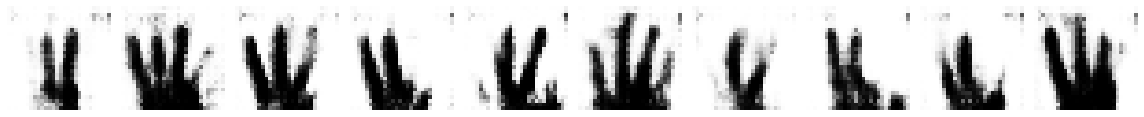

 47%|████▋     | 1400/3000 [03:38<07:32,  3.54it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1401/3000 [03:38<06:31,  4.08it/s]

>1401, dr[0.394,0.232], df[0.162,0.038], g[2.278,0.050]
1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 1402/3000 [03:38<05:44,  4.63it/s]

>1402, dr[0.396,0.032], df[0.405,0.061], g[1.886,0.019]
1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 1403/3000 [03:38<05:21,  4.97it/s]

>1403, dr[0.403,0.012], df[0.569,0.034], g[2.108,0.040]
1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 1404/3000 [03:38<05:09,  5.16it/s]

>1404, dr[0.310,0.024], df[0.334,0.210], g[2.165,0.071]
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1405/3000 [03:38<04:51,  5.47it/s]

>1405, dr[0.181,0.008], df[0.135,0.199], g[2.139,0.011]
1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 1406/3000 [03:39<04:47,  5.54it/s]

>1406, dr[0.479,0.015], df[0.376,0.003], g[1.631,0.041]
1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 1407/3000 [03:39<04:39,  5.69it/s]

>1407, dr[0.203,0.003], df[0.541,0.086], g[2.416,0.094]
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1408/3000 [03:39<04:32,  5.83it/s]

>1408, dr[0.275,0.033], df[0.126,0.099], g[2.320,0.080]
1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1409/3000 [03:39<04:30,  5.89it/s]

>1409, dr[0.277,0.007], df[0.272,0.134], g[1.594,0.061]
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1410/3000 [03:39<04:24,  6.01it/s]

>1410, dr[0.149,0.005], df[0.381,0.013], g[1.931,0.079]
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1411/3000 [03:39<04:19,  6.13it/s]

>1411, dr[0.323,0.006], df[0.316,0.054], g[2.695,0.168]
1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 1412/3000 [03:40<04:16,  6.20it/s]

>1412, dr[0.539,0.002], df[0.281,0.028], g[2.330,0.043]
1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 1413/3000 [03:40<04:11,  6.30it/s]

>1413, dr[0.258,0.022], df[0.484,0.081], g[2.512,0.066]
1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1414/3000 [03:40<04:13,  6.26it/s]

>1414, dr[0.690,0.044], df[0.516,0.008], g[2.145,0.229]
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1415/3000 [03:40<04:13,  6.24it/s]

>1415, dr[0.163,0.008], df[0.345,0.080], g[2.529,0.050]
1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 1416/3000 [03:40<04:17,  6.14it/s]

>1416, dr[0.402,0.016], df[0.527,0.076], g[2.052,0.012]
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1417/3000 [03:40<04:17,  6.15it/s]

>1417, dr[0.280,0.007], df[0.307,0.018], g[2.280,0.039]
1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 1418/3000 [03:41<04:20,  6.08it/s]

>1418, dr[0.339,0.015], df[0.265,0.004], g[2.226,0.061]
1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 1419/3000 [03:41<04:26,  5.93it/s]

>1419, dr[0.601,0.005], df[0.468,0.107], g[1.975,0.020]
1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 1420/3000 [03:41<04:25,  5.95it/s]

>1420, dr[0.244,0.001], df[0.503,0.050], g[1.962,0.172]
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1421/3000 [03:41<04:27,  5.91it/s]

>1421, dr[0.430,0.003], df[0.461,0.179], g[2.465,0.036]
1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 1422/3000 [03:41<04:21,  6.04it/s]

>1422, dr[0.371,0.004], df[0.266,0.030], g[2.437,0.018]
1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 1423/3000 [03:41<04:22,  6.01it/s]

>1423, dr[0.239,0.011], df[0.370,0.135], g[2.891,0.068]
1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 1424/3000 [03:42<04:21,  6.03it/s]

>1424, dr[0.549,0.075], df[0.609,0.063], g[2.587,0.024]
1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 1425/3000 [03:42<04:16,  6.14it/s]

>1425, dr[0.404,0.004], df[0.469,0.037], g[2.435,0.025]
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1426/3000 [03:42<04:14,  6.19it/s]

>1426, dr[0.273,0.018], df[0.198,0.013], g[2.410,0.033]
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1427/3000 [03:42<04:15,  6.16it/s]

>1427, dr[0.418,0.017], df[0.549,0.064], g[2.656,0.183]
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1428/3000 [03:42<04:18,  6.08it/s]

>1428, dr[0.406,0.018], df[0.289,0.105], g[1.859,0.037]
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1429/3000 [03:42<04:16,  6.11it/s]

>1429, dr[0.303,0.026], df[0.543,0.033], g[2.067,0.045]
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1430/3000 [03:43<04:16,  6.11it/s]

>1430, dr[0.613,0.003], df[0.371,0.015], g[1.939,0.220]
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1431/3000 [03:43<04:19,  6.05it/s]

>1431, dr[0.104,0.033], df[0.448,0.319], g[3.158,0.030]
1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 1432/3000 [03:43<04:22,  5.97it/s]

>1432, dr[0.468,0.007], df[0.487,0.076], g[3.032,0.024]
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1433/3000 [03:43<04:22,  5.96it/s]

>1433, dr[0.465,0.005], df[0.474,0.021], g[2.728,0.076]
1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 1434/3000 [03:43<04:22,  5.97it/s]

>1434, dr[0.503,0.030], df[0.323,0.029], g[2.071,0.143]
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1435/3000 [03:43<04:12,  6.19it/s]

>1435, dr[0.517,0.041], df[0.245,0.057], g[1.625,0.024]
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1436/3000 [03:44<04:11,  6.22it/s]

>1436, dr[0.171,0.003], df[0.458,0.205], g[2.290,0.070]
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1437/3000 [03:44<04:12,  6.19it/s]

>1437, dr[0.189,0.052], df[0.262,0.007], g[2.899,0.014]
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1438/3000 [03:44<04:10,  6.24it/s]

>1438, dr[0.292,0.001], df[0.305,0.045], g[2.468,0.024]
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1439/3000 [03:44<04:16,  6.08it/s]

>1439, dr[0.298,0.001], df[0.242,0.108], g[2.535,0.144]
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1440/3000 [03:44<04:15,  6.11it/s]

>1440, dr[0.444,0.021], df[0.286,0.083], g[1.612,0.039]
1/1 [==============================] - 0s 15ms/step


 48%|████▊     | 1441/3000 [03:44<04:13,  6.14it/s]

>1441, dr[0.258,0.014], df[0.464,0.181], g[2.148,0.062]
1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1442/3000 [03:45<04:08,  6.27it/s]

>1442, dr[0.475,0.069], df[0.459,0.059], g[1.822,0.009]
1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 1443/3000 [03:45<04:07,  6.30it/s]

>1443, dr[0.304,0.145], df[0.251,0.297], g[2.238,0.030]
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1444/3000 [03:45<04:09,  6.23it/s]

>1444, dr[0.203,0.007], df[0.344,0.029], g[2.112,0.057]
1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 1445/3000 [03:45<04:10,  6.21it/s]

>1445, dr[0.281,0.001], df[0.547,0.027], g[2.479,0.009]
1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1446/3000 [03:45<04:15,  6.07it/s]

>1446, dr[0.448,0.129], df[0.196,0.132], g[2.397,0.152]
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1447/3000 [03:45<04:15,  6.08it/s]

>1447, dr[0.437,0.006], df[0.335,0.014], g[2.108,0.100]
1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 1448/3000 [03:45<04:17,  6.02it/s]

>1448, dr[0.268,0.012], df[0.423,0.018], g[2.829,0.020]
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1449/3000 [03:46<04:16,  6.04it/s]

>1449, dr[0.355,0.014], df[0.406,0.142], g[2.408,0.063]
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1450/3000 [03:46<04:12,  6.14it/s]

>1450, dr[0.546,0.014], df[0.323,0.030], g[1.778,0.060]
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1451/3000 [03:46<04:06,  6.28it/s]

>1451, dr[0.206,0.018], df[0.467,0.086], g[2.294,0.034]
1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 1452/3000 [03:46<04:07,  6.25it/s]

>1452, dr[0.210,0.006], df[0.360,0.074], g[2.541,0.017]
1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 1453/3000 [03:46<04:06,  6.28it/s]

>1453, dr[0.448,0.093], df[0.283,0.004], g[2.519,0.028]
1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 1454/3000 [03:46<04:12,  6.13it/s]

>1454, dr[0.570,0.005], df[0.383,0.035], g[2.179,0.023]
1/1 [==============================] - 0s 14ms/step


 48%|████▊     | 1455/3000 [03:47<04:04,  6.32it/s]

>1455, dr[0.278,0.005], df[0.591,0.020], g[2.212,0.020]
1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 1456/3000 [03:47<04:07,  6.23it/s]

>1456, dr[0.327,0.012], df[0.380,0.011], g[2.298,0.033]
1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 1457/3000 [03:47<04:10,  6.15it/s]

>1457, dr[0.302,0.002], df[0.258,0.026], g[2.548,0.011]
1/1 [==============================] - 0s 14ms/step


 49%|████▊     | 1458/3000 [03:47<04:12,  6.11it/s]

>1458, dr[0.310,0.009], df[0.589,0.036], g[2.258,0.007]
1/1 [==============================] - 0s 15ms/step


 49%|████▊     | 1459/3000 [03:47<04:15,  6.04it/s]

>1459, dr[0.451,0.011], df[0.179,0.017], g[2.090,0.016]
1/1 [==============================] - 0s 15ms/step


 49%|████▊     | 1460/3000 [03:47<04:14,  6.06it/s]

>1460, dr[0.324,0.016], df[0.532,0.029], g[2.637,0.019]
1/1 [==============================] - 0s 14ms/step


 49%|████▊     | 1461/3000 [03:48<04:09,  6.16it/s]

>1461, dr[0.171,0.002], df[0.383,0.112], g[2.658,0.086]
1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 1462/3000 [03:48<04:16,  6.00it/s]

>1462, dr[0.577,0.037], df[0.315,0.061], g[2.023,0.016]
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1463/3000 [03:48<04:10,  6.14it/s]

>1463, dr[0.447,0.009], df[0.399,0.108], g[1.953,0.099]
1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 1464/3000 [03:48<04:05,  6.25it/s]

>1464, dr[0.279,0.010], df[0.321,0.127], g[2.011,0.067]
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1465/3000 [03:48<04:04,  6.27it/s]

>1465, dr[0.414,0.028], df[0.488,0.011], g[2.051,0.032]
1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 1466/3000 [03:48<04:07,  6.21it/s]

>1466, dr[0.349,0.007], df[0.260,0.132], g[1.780,0.011]
1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 1467/3000 [03:49<04:04,  6.27it/s]

>1467, dr[0.291,0.003], df[0.391,0.026], g[2.409,0.046]
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1468/3000 [03:49<04:07,  6.19it/s]

>1468, dr[0.227,0.016], df[0.388,0.007], g[2.505,0.067]
1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1469/3000 [03:49<04:10,  6.11it/s]

>1469, dr[0.513,0.053], df[0.248,0.030], g[2.122,0.061]
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1470/3000 [03:49<04:12,  6.05it/s]

>1470, dr[0.391,0.028], df[0.362,0.053], g[2.051,0.119]
1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 1471/3000 [03:49<04:10,  6.09it/s]

>1471, dr[0.366,0.005], df[0.380,0.106], g[1.881,0.075]
1/1 [==============================] - 0s 14ms/step


 49%|████▉     | 1472/3000 [03:49<04:08,  6.15it/s]

>1472, dr[0.300,0.081], df[0.263,0.060], g[1.873,0.026]
1/1 [==============================] - 0s 14ms/step


 49%|████▉     | 1473/3000 [03:50<04:04,  6.25it/s]

>1473, dr[0.249,0.012], df[0.390,0.073], g[2.420,0.054]
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1474/3000 [03:50<04:09,  6.12it/s]

>1474, dr[0.275,0.070], df[0.308,0.002], g[1.929,0.055]
1/1 [==============================] - 0s 14ms/step


 49%|████▉     | 1475/3000 [03:50<04:02,  6.28it/s]

>1475, dr[0.421,0.013], df[0.567,0.115], g[2.220,0.045]
1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 1476/3000 [03:50<04:04,  6.24it/s]

>1476, dr[0.226,0.028], df[0.306,0.007], g[2.047,0.091]
1/1 [==============================] - 0s 14ms/step


 49%|████▉     | 1477/3000 [03:50<04:03,  6.25it/s]

>1477, dr[0.498,0.009], df[0.338,0.017], g[1.785,0.049]
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1478/3000 [03:50<04:01,  6.29it/s]

>1478, dr[0.354,0.079], df[0.303,0.016], g[2.075,0.030]
1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 1479/3000 [03:50<04:02,  6.26it/s]

>1479, dr[0.391,0.006], df[0.367,0.041], g[1.992,0.020]
1/1 [==============================] - 0s 14ms/step


 49%|████▉     | 1480/3000 [03:51<04:04,  6.21it/s]

>1480, dr[0.185,0.005], df[0.400,0.022], g[2.460,0.041]
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1481/3000 [03:51<04:11,  6.04it/s]

>1481, dr[0.665,0.005], df[0.579,0.050], g[2.232,0.037]
1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 1482/3000 [03:51<04:10,  6.06it/s]

>1482, dr[0.370,0.006], df[0.423,0.116], g[2.233,0.078]
1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 1483/3000 [03:51<04:08,  6.10it/s]

>1483, dr[0.214,0.007], df[0.213,0.022], g[2.078,0.055]
1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 1484/3000 [03:51<04:04,  6.19it/s]

>1484, dr[0.264,0.006], df[0.601,0.027], g[2.780,0.041]
1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1485/3000 [03:51<04:06,  6.15it/s]

>1485, dr[0.360,0.006], df[0.209,0.055], g[2.119,0.083]
1/1 [==============================] - 0s 14ms/step


 50%|████▉     | 1486/3000 [03:52<04:04,  6.20it/s]

>1486, dr[0.301,0.003], df[0.422,0.100], g[2.763,0.051]
1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 1487/3000 [03:52<04:00,  6.29it/s]

>1487, dr[0.419,0.009], df[0.117,0.074], g[2.316,0.082]
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1488/3000 [03:52<03:57,  6.36it/s]

>1488, dr[0.336,0.009], df[0.400,0.026], g[2.105,0.051]
1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 1489/3000 [03:52<04:01,  6.25it/s]

>1489, dr[0.253,0.010], df[0.356,0.079], g[1.868,0.058]
1/1 [==============================] - 0s 14ms/step


 50%|████▉     | 1490/3000 [03:52<04:04,  6.18it/s]

>1490, dr[0.349,0.012], df[0.268,0.087], g[1.689,0.058]
1/1 [==============================] - 0s 15ms/step


 50%|████▉     | 1491/3000 [03:52<04:01,  6.26it/s]

>1491, dr[0.357,0.004], df[0.388,0.021], g[1.988,0.040]
1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 1492/3000 [03:53<04:03,  6.20it/s]

>1492, dr[0.266,0.006], df[0.261,0.121], g[2.518,0.017]
1/1 [==============================] - 0s 14ms/step


 50%|████▉     | 1493/3000 [03:53<04:07,  6.10it/s]

>1493, dr[0.215,0.011], df[0.176,0.005], g[2.115,0.008]
1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 1494/3000 [03:53<04:07,  6.10it/s]

>1494, dr[0.357,0.002], df[0.318,0.010], g[1.896,0.023]
1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1495/3000 [03:53<04:11,  5.97it/s]

>1495, dr[0.349,0.004], df[0.510,0.029], g[2.301,0.020]
1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 1496/3000 [03:53<04:10,  6.00it/s]

>1496, dr[0.416,0.004], df[0.259,0.009], g[1.495,0.039]
1/1 [==============================] - 0s 14ms/step


 50%|████▉     | 1497/3000 [03:53<04:07,  6.08it/s]

>1497, dr[0.255,0.002], df[0.355,0.039], g[2.130,0.032]
1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 1498/3000 [03:54<04:04,  6.15it/s]

>1498, dr[0.276,0.020], df[0.526,0.201], g[2.473,0.128]
1/1 [==============================] - 0s 14ms/step


 50%|████▉     | 1499/3000 [03:54<04:04,  6.14it/s]

>1499, dr[0.492,0.006], df[0.453,0.058], g[2.868,0.169]
1/1 [==============================] - 0s 14ms/step
>1500, dr[0.473,0.039], df[0.277,0.041], g[2.620,0.080]
1/1 [==============================] - 0s 24ms/step


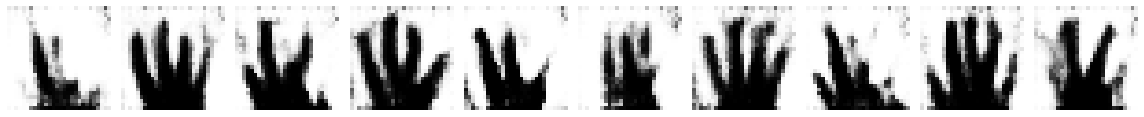

 50%|█████     | 1500/3000 [03:54<06:57,  3.59it/s]

1/1 [==============================] - 0s 14ms/step


 50%|█████     | 1501/3000 [03:54<06:01,  4.14it/s]

>1501, dr[0.282,0.005], df[0.431,0.040], g[2.618,0.113]
1/1 [==============================] - 0s 13ms/step


 50%|█████     | 1502/3000 [03:55<05:21,  4.67it/s]

>1502, dr[0.383,0.003], df[0.506,0.010], g[2.366,0.067]
1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1503/3000 [03:55<05:02,  4.95it/s]

>1503, dr[0.270,0.019], df[0.136,0.138], g[2.704,0.034]
1/1 [==============================] - 0s 15ms/step


 50%|█████     | 1504/3000 [03:55<04:47,  5.20it/s]

>1504, dr[0.310,0.006], df[0.237,0.160], g[1.809,0.113]
1/1 [==============================] - 0s 19ms/step


 50%|█████     | 1505/3000 [03:55<04:32,  5.49it/s]

>1505, dr[0.158,0.028], df[0.219,0.004], g[2.167,0.076]
1/1 [==============================] - 0s 18ms/step


 50%|█████     | 1506/3000 [03:55<04:24,  5.65it/s]

>1506, dr[0.226,0.115], df[0.233,0.035], g[2.018,0.063]
1/1 [==============================] - 0s 15ms/step


 50%|█████     | 1507/3000 [03:55<04:13,  5.88it/s]

>1507, dr[0.325,0.017], df[0.385,0.002], g[2.163,0.028]
1/1 [==============================] - 0s 14ms/step


 50%|█████     | 1508/3000 [03:56<04:11,  5.94it/s]

>1508, dr[0.148,0.012], df[0.241,0.033], g[2.948,0.085]
1/1 [==============================] - 0s 14ms/step


 50%|█████     | 1509/3000 [03:56<04:07,  6.02it/s]

>1509, dr[0.429,0.006], df[0.392,0.067], g[2.151,0.032]
1/1 [==============================] - 0s 21ms/step


 50%|█████     | 1510/3000 [03:56<04:07,  6.02it/s]

>1510, dr[0.400,0.013], df[0.425,0.127], g[1.946,0.079]
1/1 [==============================] - 0s 14ms/step


 50%|█████     | 1511/3000 [03:56<04:07,  6.01it/s]

>1511, dr[0.420,0.008], df[0.255,0.013], g[1.956,0.123]
1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1512/3000 [03:56<04:05,  6.05it/s]

>1512, dr[0.267,0.002], df[0.478,0.042], g[2.326,0.114]
1/1 [==============================] - 0s 17ms/step


 50%|█████     | 1513/3000 [03:56<04:00,  6.18it/s]

>1513, dr[0.281,0.005], df[0.219,0.115], g[2.328,0.084]
1/1 [==============================] - 0s 16ms/step


 50%|█████     | 1514/3000 [03:57<04:00,  6.17it/s]

>1514, dr[0.321,0.009], df[0.208,0.084], g[2.016,0.024]
1/1 [==============================] - 0s 15ms/step


 50%|█████     | 1515/3000 [03:57<04:00,  6.17it/s]

>1515, dr[0.334,0.003], df[0.418,0.022], g[2.323,0.036]
1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1516/3000 [03:57<04:09,  5.95it/s]

>1516, dr[0.230,0.007], df[0.400,0.036], g[2.533,0.068]
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1517/3000 [03:57<04:12,  5.87it/s]

>1517, dr[0.236,0.076], df[0.368,0.007], g[2.703,0.099]
1/1 [==============================] - 0s 16ms/step


 51%|█████     | 1518/3000 [03:57<04:03,  6.07it/s]

>1518, dr[0.464,0.002], df[0.216,0.007], g[2.614,0.157]
1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1519/3000 [03:57<04:02,  6.11it/s]

>1519, dr[0.323,0.004], df[0.219,0.062], g[2.664,0.172]
1/1 [==============================] - 0s 15ms/step


 51%|█████     | 1520/3000 [03:58<04:02,  6.09it/s]

>1520, dr[0.190,0.035], df[0.496,0.016], g[3.234,0.062]
1/1 [==============================] - 0s 15ms/step


 51%|█████     | 1521/3000 [03:58<03:56,  6.26it/s]

>1521, dr[0.328,0.019], df[0.217,0.011], g[2.553,0.070]
1/1 [==============================] - 0s 20ms/step


 51%|█████     | 1522/3000 [03:58<03:57,  6.23it/s]

>1522, dr[0.365,0.001], df[0.176,0.022], g[2.527,0.031]
1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1523/3000 [03:58<03:58,  6.20it/s]

>1523, dr[0.124,0.004], df[0.305,0.003], g[2.000,0.015]
1/1 [==============================] - 0s 19ms/step


 51%|█████     | 1524/3000 [03:58<04:00,  6.13it/s]

>1524, dr[0.248,0.002], df[0.290,0.006], g[1.920,0.088]
1/1 [==============================] - 0s 15ms/step


 51%|█████     | 1525/3000 [03:58<04:00,  6.12it/s]

>1525, dr[0.375,0.111], df[0.231,0.007], g[2.173,0.023]
1/1 [==============================] - 0s 14ms/step


 51%|█████     | 1526/3000 [03:59<04:00,  6.14it/s]

>1526, dr[0.162,0.012], df[0.331,0.195], g[2.683,0.041]
1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1527/3000 [03:59<03:58,  6.16it/s]

>1527, dr[0.388,0.024], df[0.563,0.090], g[2.249,0.023]
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1528/3000 [03:59<04:06,  5.97it/s]

>1528, dr[0.203,0.015], df[0.401,0.134], g[2.679,0.134]
1/1 [==============================] - 0s 14ms/step


 51%|█████     | 1529/3000 [03:59<04:01,  6.08it/s]

>1529, dr[0.390,0.006], df[0.285,0.007], g[2.543,0.092]
1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1530/3000 [03:59<03:59,  6.13it/s]

>1530, dr[0.470,0.006], df[0.227,0.024], g[1.997,0.042]
1/1 [==============================] - 0s 14ms/step


 51%|█████     | 1531/3000 [03:59<03:59,  6.13it/s]

>1531, dr[0.307,0.116], df[0.444,0.003], g[2.349,0.035]
1/1 [==============================] - 0s 17ms/step


 51%|█████     | 1532/3000 [03:59<03:52,  6.30it/s]

>1532, dr[0.217,0.032], df[0.392,0.047], g[2.614,0.158]
1/1 [==============================] - 0s 18ms/step


 51%|█████     | 1533/3000 [04:00<03:51,  6.35it/s]

>1533, dr[0.529,0.012], df[0.363,0.043], g[2.485,0.071]
1/1 [==============================] - 0s 15ms/step


 51%|█████     | 1534/3000 [04:00<03:49,  6.40it/s]

>1534, dr[0.482,0.053], df[0.406,0.009], g[1.868,0.057]
1/1 [==============================] - 0s 21ms/step


 51%|█████     | 1535/3000 [04:00<03:47,  6.43it/s]

>1535, dr[0.198,0.005], df[0.434,0.020], g[2.269,0.040]
1/1 [==============================] - 0s 14ms/step


 51%|█████     | 1536/3000 [04:00<03:50,  6.35it/s]

>1536, dr[0.291,0.019], df[0.301,0.021], g[2.975,0.054]
1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1537/3000 [04:00<03:49,  6.38it/s]

>1537, dr[0.503,0.010], df[0.506,0.068], g[2.311,0.088]
1/1 [==============================] - 0s 15ms/step


 51%|█████▏    | 1538/3000 [04:00<03:50,  6.35it/s]

>1538, dr[0.329,0.006], df[0.174,0.018], g[2.441,0.071]
1/1 [==============================] - 0s 14ms/step


 51%|█████▏    | 1539/3000 [04:01<03:50,  6.33it/s]

>1539, dr[0.249,0.008], df[0.204,0.006], g[1.796,0.027]
1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 1540/3000 [04:01<03:49,  6.37it/s]

>1540, dr[0.269,0.003], df[0.414,0.043], g[2.519,0.053]
1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 1541/3000 [04:01<03:49,  6.35it/s]

>1541, dr[0.376,0.027], df[0.251,0.017], g[2.675,0.042]
1/1 [==============================] - 0s 14ms/step


 51%|█████▏    | 1542/3000 [04:01<03:48,  6.37it/s]

>1542, dr[0.170,0.006], df[0.270,0.031], g[2.943,0.007]
1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 1543/3000 [04:01<03:53,  6.23it/s]

>1543, dr[0.382,0.008], df[0.330,0.100], g[2.321,0.041]
1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 1544/3000 [04:01<03:52,  6.26it/s]

>1544, dr[0.290,0.006], df[0.286,0.049], g[2.336,0.111]
1/1 [==============================] - 0s 13ms/step


 52%|█████▏    | 1545/3000 [04:02<03:53,  6.24it/s]

>1545, dr[0.399,0.012], df[0.329,0.022], g[2.480,0.017]
1/1 [==============================] - 0s 14ms/step


 52%|█████▏    | 1546/3000 [04:02<03:55,  6.18it/s]

>1546, dr[0.380,0.007], df[0.440,0.073], g[2.373,0.277]
1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1547/3000 [04:02<07:04,  3.42it/s]

>1547, dr[0.260,0.013], df[0.281,0.009], g[2.377,0.063]
1/1 [==============================] - 0s 14ms/step


 52%|█████▏    | 1548/3000 [04:02<06:01,  4.02it/s]

>1548, dr[0.198,0.042], df[0.360,0.101], g[2.659,0.069]
1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1549/3000 [04:03<05:20,  4.53it/s]

>1549, dr[0.296,0.004], df[0.173,0.012], g[2.739,0.036]
1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 1550/3000 [04:03<04:53,  4.93it/s]

>1550, dr[0.383,0.020], df[0.465,0.024], g[2.457,0.039]
1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1551/3000 [04:03<04:34,  5.27it/s]

>1551, dr[0.172,0.003], df[0.235,0.035], g[2.358,0.075]
1/1 [==============================] - 0s 14ms/step


 52%|█████▏    | 1552/3000 [04:03<04:19,  5.57it/s]

>1552, dr[0.430,0.016], df[0.249,0.189], g[2.034,0.180]
1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 1553/3000 [04:03<04:11,  5.75it/s]

>1553, dr[0.262,0.016], df[0.207,0.132], g[1.719,0.042]
1/1 [==============================] - 0s 14ms/step


 52%|█████▏    | 1554/3000 [04:03<04:01,  5.99it/s]

>1554, dr[0.242,0.003], df[0.364,0.116], g[1.869,0.047]
1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1555/3000 [04:04<03:57,  6.08it/s]

>1555, dr[0.308,0.002], df[0.364,0.140], g[1.957,0.061]
1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1556/3000 [04:04<03:54,  6.16it/s]

>1556, dr[0.246,0.059], df[0.285,0.021], g[2.039,0.057]
1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1557/3000 [04:04<03:52,  6.21it/s]

>1557, dr[0.313,0.005], df[0.568,0.019], g[2.250,0.114]
1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1558/3000 [04:04<03:52,  6.20it/s]

>1558, dr[0.357,0.022], df[0.184,0.005], g[2.270,0.050]
1/1 [==============================] - 0s 14ms/step


 52%|█████▏    | 1559/3000 [04:04<03:54,  6.14it/s]

>1559, dr[0.468,0.013], df[0.331,0.029], g[2.048,0.093]
1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1560/3000 [04:04<03:59,  6.02it/s]

>1560, dr[0.271,0.002], df[0.505,0.015], g[1.955,0.089]
1/1 [==============================] - 0s 14ms/step


 52%|█████▏    | 1561/3000 [04:05<03:59,  6.01it/s]

>1561, dr[0.312,0.010], df[0.249,0.111], g[2.098,0.072]
1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 1562/3000 [04:05<03:56,  6.08it/s]

>1562, dr[0.234,0.009], df[0.325,0.018], g[2.108,0.107]
1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 1563/3000 [04:05<03:50,  6.23it/s]

>1563, dr[0.206,0.006], df[0.507,0.153], g[2.799,0.062]
1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1564/3000 [04:05<03:51,  6.20it/s]

>1564, dr[0.420,0.012], df[0.326,0.043], g[2.767,0.111]
1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1565/3000 [04:05<03:47,  6.32it/s]

>1565, dr[0.388,0.011], df[0.237,0.014], g[2.286,0.048]
1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1566/3000 [04:05<03:51,  6.19it/s]

>1566, dr[0.356,0.085], df[0.487,0.020], g[1.880,0.076]
1/1 [==============================] - 0s 14ms/step


 52%|█████▏    | 1567/3000 [04:05<03:48,  6.27it/s]

>1567, dr[0.408,0.009], df[0.436,0.015], g[2.238,0.072]
1/1 [==============================] - 0s 14ms/step


 52%|█████▏    | 1568/3000 [04:06<03:47,  6.28it/s]

>1568, dr[0.299,0.004], df[0.374,0.013], g[1.819,0.042]
1/1 [==============================] - 0s 14ms/step


 52%|█████▏    | 1569/3000 [04:06<03:49,  6.23it/s]

>1569, dr[0.294,0.028], df[0.278,0.028], g[2.332,0.014]
1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1570/3000 [04:06<03:47,  6.27it/s]

>1570, dr[0.505,0.011], df[0.389,0.006], g[2.038,0.128]
1/1 [==============================] - 0s 14ms/step


 52%|█████▏    | 1571/3000 [04:06<03:51,  6.18it/s]

>1571, dr[0.220,0.005], df[0.332,0.035], g[1.977,0.087]
1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1572/3000 [04:06<03:46,  6.31it/s]

>1572, dr[0.207,0.056], df[0.353,0.004], g[2.555,0.066]
1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 1573/3000 [04:06<03:49,  6.21it/s]

>1573, dr[0.276,0.033], df[0.206,0.125], g[2.215,0.045]
1/1 [==============================] - 0s 14ms/step


 52%|█████▏    | 1574/3000 [04:07<03:48,  6.23it/s]

>1574, dr[0.317,0.016], df[0.211,0.069], g[1.894,0.114]
1/1 [==============================] - 0s 16ms/step


 52%|█████▎    | 1575/3000 [04:07<03:48,  6.24it/s]

>1575, dr[0.249,0.010], df[0.570,0.066], g[2.473,0.144]
1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1576/3000 [04:07<03:52,  6.14it/s]

>1576, dr[0.479,0.053], df[0.377,0.011], g[1.725,0.099]
1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1577/3000 [04:07<03:52,  6.13it/s]

>1577, dr[0.253,0.016], df[0.474,0.029], g[2.298,0.012]
1/1 [==============================] - 0s 14ms/step


 53%|█████▎    | 1578/3000 [04:07<03:54,  6.06it/s]

>1578, dr[0.319,0.007], df[0.378,0.008], g[2.408,0.014]
1/1 [==============================] - 0s 14ms/step


 53%|█████▎    | 1579/3000 [04:07<03:54,  6.07it/s]

>1579, dr[0.486,0.031], df[0.548,0.018], g[1.767,0.010]
1/1 [==============================] - 0s 14ms/step


 53%|█████▎    | 1580/3000 [04:08<03:50,  6.17it/s]

>1580, dr[0.502,0.042], df[0.248,0.007], g[1.722,0.027]
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1581/3000 [04:08<03:45,  6.30it/s]

>1581, dr[0.147,0.026], df[0.345,0.006], g[1.901,0.028]
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1582/3000 [04:08<03:45,  6.28it/s]

>1582, dr[0.463,0.015], df[0.420,0.016], g[2.046,0.046]
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1583/3000 [04:08<03:46,  6.25it/s]

>1583, dr[0.341,0.018], df[0.410,0.005], g[1.994,0.044]
1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 1584/3000 [04:08<03:51,  6.13it/s]

>1584, dr[0.326,0.008], df[0.339,0.024], g[2.187,0.211]
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 1585/3000 [04:08<03:53,  6.06it/s]

>1585, dr[0.598,0.006], df[0.257,0.003], g[1.905,0.115]
1/1 [==============================] - 0s 14ms/step


 53%|█████▎    | 1586/3000 [04:09<03:49,  6.17it/s]

>1586, dr[0.196,0.001], df[0.382,0.158], g[2.214,0.034]
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1587/3000 [04:09<03:43,  6.31it/s]

>1587, dr[0.360,0.008], df[0.515,0.060], g[2.168,0.117]
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1588/3000 [04:09<03:43,  6.31it/s]

>1588, dr[0.298,0.005], df[0.457,0.037], g[2.710,0.018]
1/1 [==============================] - 0s 19ms/step
>1589, dr[0.432,0.052], df[0.468,0.032], g[3.103,0.012]


 53%|█████▎    | 1589/3000 [04:09<03:58,  5.92it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 1590/3000 [04:09<03:57,  5.94it/s]

>1590, dr[0.537,0.066], df[0.326,0.006], g[2.091,0.089]
1/1 [==============================] - 0s 13ms/step


 53%|█████▎    | 1591/3000 [04:09<03:57,  5.94it/s]

>1591, dr[0.350,0.012], df[0.362,0.002], g[2.429,0.051]
1/1 [==============================] - 0s 14ms/step


 53%|█████▎    | 1592/3000 [04:10<03:53,  6.03it/s]

>1592, dr[0.262,0.100], df[0.394,0.014], g[2.337,0.036]
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 1593/3000 [04:10<03:54,  6.01it/s]

>1593, dr[0.414,0.004], df[0.399,0.024], g[1.984,0.112]
1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1594/3000 [04:10<03:55,  5.98it/s]

>1594, dr[0.231,0.099], df[0.376,0.021], g[2.749,0.027]
1/1 [==============================] - 0s 14ms/step


 53%|█████▎    | 1595/3000 [04:10<03:48,  6.14it/s]

>1595, dr[0.454,0.001], df[0.505,0.022], g[2.181,0.008]
1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 1596/3000 [04:10<03:45,  6.22it/s]

>1596, dr[0.273,0.005], df[0.221,0.018], g[2.527,0.093]
1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 1597/3000 [04:10<03:44,  6.25it/s]

>1597, dr[0.434,0.004], df[0.417,0.009], g[2.128,0.017]
1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1598/3000 [04:11<03:41,  6.32it/s]

>1598, dr[0.163,0.005], df[0.335,0.047], g[2.260,0.128]
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1599/3000 [04:11<03:55,  5.95it/s]

>1599, dr[0.328,0.005], df[0.265,0.031], g[2.234,0.004]
1/1 [==============================] - 0s 16ms/step
>1600, dr[0.189,0.016], df[0.250,0.015], g[2.190,0.030]
1/1 [==============================] - 0s 21ms/step


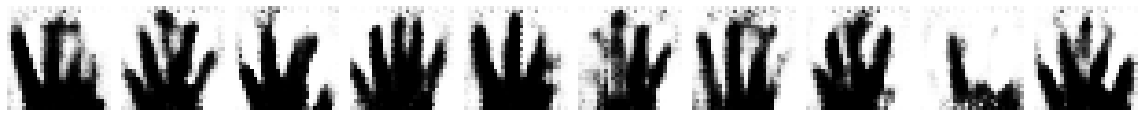

 53%|█████▎    | 1600/3000 [04:11<06:32,  3.56it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 1601/3000 [04:11<05:41,  4.10it/s]

>1601, dr[0.468,0.006], df[0.436,0.043], g[1.665,0.046]
1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 1602/3000 [04:12<05:04,  4.60it/s]

>1602, dr[0.204,0.008], df[0.321,0.014], g[2.427,0.099]
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1603/3000 [04:12<04:38,  5.02it/s]

>1603, dr[0.348,0.001], df[0.472,0.052], g[2.440,0.055]
1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 1604/3000 [04:12<04:19,  5.37it/s]

>1604, dr[0.429,0.052], df[0.340,0.004], g[2.248,0.017]
1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 1605/3000 [04:12<04:04,  5.71it/s]

>1605, dr[0.250,0.006], df[0.165,0.077], g[2.004,0.086]
1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 1606/3000 [04:12<04:00,  5.80it/s]

>1606, dr[0.215,0.111], df[0.543,0.015], g[2.738,0.063]
1/1 [==============================] - 0s 13ms/step


 54%|█████▎    | 1607/3000 [04:12<03:52,  6.00it/s]

>1607, dr[0.287,0.058], df[0.209,0.008], g[2.091,0.054]
1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 1608/3000 [04:13<03:55,  5.90it/s]

>1608, dr[0.360,0.003], df[0.395,0.029], g[2.239,0.024]
1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 1609/3000 [04:13<03:55,  5.91it/s]

>1609, dr[0.517,0.004], df[0.317,0.009], g[1.734,0.065]
1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 1610/3000 [04:13<03:56,  5.87it/s]

>1610, dr[0.349,0.019], df[0.336,0.017], g[1.731,0.039]
1/1 [==============================] - 0s 15ms/step


 54%|█████▎    | 1611/3000 [04:13<03:54,  5.92it/s]

>1611, dr[0.136,0.014], df[0.365,0.072], g[2.368,0.025]
1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 1612/3000 [04:13<03:54,  5.91it/s]

>1612, dr[0.370,0.008], df[0.338,0.091], g[2.211,0.040]
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1613/3000 [04:13<03:49,  6.04it/s]

>1613, dr[0.262,0.011], df[0.556,0.011], g[2.131,0.018]
1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1614/3000 [04:14<03:47,  6.08it/s]

>1614, dr[0.314,0.009], df[0.372,0.026], g[3.072,0.074]
1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 1615/3000 [04:14<03:47,  6.10it/s]

>1615, dr[0.814,0.096], df[0.355,0.086], g[2.211,0.062]
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1616/3000 [04:14<03:45,  6.14it/s]

>1616, dr[0.435,0.001], df[0.572,0.015], g[2.906,0.059]
1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1617/3000 [04:14<03:42,  6.23it/s]

>1617, dr[0.597,0.008], df[0.500,0.036], g[2.228,0.072]
1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 1618/3000 [04:14<03:41,  6.23it/s]

>1618, dr[0.199,0.003], df[0.546,0.058], g[2.733,0.084]
1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 1619/3000 [04:14<03:45,  6.14it/s]

>1619, dr[0.359,0.025], df[0.217,0.008], g[2.652,0.042]
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1620/3000 [04:14<03:42,  6.19it/s]

>1620, dr[0.286,0.007], df[0.395,0.002], g[2.652,0.028]
1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1621/3000 [04:15<03:48,  6.04it/s]

>1621, dr[0.298,0.006], df[0.163,0.020], g[2.847,0.057]
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1622/3000 [04:15<03:45,  6.12it/s]

>1622, dr[0.415,0.011], df[0.245,0.016], g[1.628,0.087]
1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 1623/3000 [04:15<03:50,  5.98it/s]

>1623, dr[0.171,0.073], df[0.295,0.007], g[1.825,0.040]
1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1624/3000 [04:15<03:51,  5.94it/s]

>1624, dr[0.176,0.007], df[0.470,0.065], g[2.072,0.124]
1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1625/3000 [04:15<03:49,  5.98it/s]

>1625, dr[0.595,0.014], df[0.398,0.025], g[2.570,0.026]
1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 1626/3000 [04:16<03:47,  6.03it/s]

>1626, dr[0.331,0.005], df[0.218,0.003], g[2.306,0.098]
1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1627/3000 [04:16<03:46,  6.07it/s]

>1627, dr[0.288,0.005], df[0.553,0.035], g[2.525,0.069]
1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 1628/3000 [04:16<03:42,  6.18it/s]

>1628, dr[0.280,0.044], df[0.313,0.061], g[2.736,0.129]
1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1629/3000 [04:16<03:41,  6.19it/s]

>1629, dr[0.455,0.018], df[0.246,0.010], g[2.420,0.079]
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1630/3000 [04:16<03:37,  6.29it/s]

>1630, dr[0.452,0.006], df[0.370,0.004], g[2.378,0.080]
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1631/3000 [04:16<03:39,  6.23it/s]

>1631, dr[0.375,0.011], df[0.408,0.004], g[1.980,0.042]
1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 1632/3000 [04:16<03:39,  6.24it/s]

>1632, dr[0.334,0.001], df[0.397,0.152], g[2.596,0.019]
1/1 [==============================] - 0s 15ms/step


 54%|█████▍    | 1633/3000 [04:17<03:41,  6.17it/s]

>1633, dr[0.312,0.006], df[0.462,0.004], g[2.334,0.205]
1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 1634/3000 [04:17<03:46,  6.04it/s]

>1634, dr[0.332,0.015], df[0.343,0.070], g[2.450,0.022]
1/1 [==============================] - 0s 14ms/step


 55%|█████▍    | 1635/3000 [04:17<03:40,  6.19it/s]

>1635, dr[0.305,0.048], df[0.187,0.010], g[2.129,0.194]
1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1636/3000 [04:17<03:40,  6.18it/s]

>1636, dr[0.287,0.007], df[0.418,0.021], g[1.998,0.090]
1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1637/3000 [04:17<03:39,  6.21it/s]

>1637, dr[0.223,0.006], df[0.321,0.095], g[2.870,0.055]
1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 1638/3000 [04:17<03:37,  6.25it/s]

>1638, dr[0.259,0.013], df[0.217,0.037], g[2.621,0.064]
1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1639/3000 [04:18<03:42,  6.12it/s]

>1639, dr[0.669,0.006], df[0.404,0.007], g[2.930,0.053]
1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1640/3000 [04:18<03:41,  6.13it/s]

>1640, dr[0.249,0.061], df[0.267,0.087], g[2.063,0.010]
1/1 [==============================] - 0s 14ms/step


 55%|█████▍    | 1641/3000 [04:18<03:37,  6.25it/s]

>1641, dr[0.261,0.005], df[0.498,0.078], g[2.104,0.033]
1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1642/3000 [04:18<03:41,  6.12it/s]

>1642, dr[0.279,0.004], df[0.399,0.034], g[2.580,0.030]
1/1 [==============================] - 0s 14ms/step


 55%|█████▍    | 1643/3000 [04:18<03:42,  6.09it/s]

>1643, dr[0.322,0.042], df[0.217,0.006], g[3.214,0.037]
1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1644/3000 [04:18<03:42,  6.09it/s]

>1644, dr[0.652,0.006], df[0.274,0.005], g[2.202,0.183]
1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 1645/3000 [04:19<03:39,  6.18it/s]

>1645, dr[0.224,0.016], df[0.402,0.010], g[2.077,0.127]
1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 1646/3000 [04:19<03:36,  6.25it/s]

>1646, dr[0.268,0.004], df[0.633,0.009], g[2.837,0.018]
1/1 [==============================] - 0s 14ms/step


 55%|█████▍    | 1647/3000 [04:19<03:36,  6.25it/s]

>1647, dr[0.217,0.001], df[0.133,0.012], g[2.368,0.070]
1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 1648/3000 [04:19<03:38,  6.19it/s]

>1648, dr[0.367,0.005], df[0.450,0.059], g[2.945,0.070]
1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 1649/3000 [04:19<03:39,  6.15it/s]

>1649, dr[0.489,0.030], df[0.370,0.022], g[2.632,0.007]
1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1650/3000 [04:19<03:40,  6.13it/s]

>1650, dr[0.335,0.007], df[0.503,0.013], g[2.397,0.033]
1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1651/3000 [04:20<03:40,  6.12it/s]

>1651, dr[0.192,0.012], df[0.244,0.004], g[1.852,0.142]
1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1652/3000 [04:20<03:48,  5.91it/s]

>1652, dr[0.193,0.003], df[0.371,0.030], g[2.523,0.090]
1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 1653/3000 [04:20<03:40,  6.10it/s]

>1653, dr[0.213,0.001], df[0.368,0.090], g[3.197,0.068]
1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1654/3000 [04:20<03:39,  6.13it/s]

>1654, dr[0.409,0.003], df[0.205,0.009], g[2.623,0.025]
1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 1655/3000 [04:20<03:37,  6.20it/s]

>1655, dr[0.415,0.020], df[0.450,0.018], g[2.117,0.030]
1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 1656/3000 [04:20<03:38,  6.16it/s]

>1656, dr[0.401,0.007], df[0.322,0.053], g[2.047,0.029]
1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 1657/3000 [04:21<03:38,  6.15it/s]

>1657, dr[0.278,0.034], df[0.399,0.022], g[2.156,0.014]
1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 1658/3000 [04:21<03:40,  6.09it/s]

>1658, dr[0.489,0.005], df[0.383,0.011], g[2.251,0.028]
1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 1659/3000 [04:21<03:36,  6.19it/s]

>1659, dr[0.217,0.033], df[0.361,0.059], g[2.726,0.080]
1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1660/3000 [04:21<03:36,  6.18it/s]

>1660, dr[0.368,0.006], df[0.402,0.006], g[2.414,0.050]
1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1661/3000 [04:21<03:38,  6.12it/s]

>1661, dr[0.236,0.055], df[0.335,0.002], g[2.575,0.071]
1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 1662/3000 [04:21<03:37,  6.15it/s]

>1662, dr[0.375,0.111], df[0.364,0.008], g[2.582,0.155]
1/1 [==============================] - 0s 14ms/step


 55%|█████▌    | 1663/3000 [04:21<03:34,  6.24it/s]

>1663, dr[0.356,0.006], df[0.232,0.035], g[2.613,0.015]
1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 1664/3000 [04:22<03:35,  6.19it/s]

>1664, dr[0.437,0.021], df[0.436,0.050], g[2.214,0.053]
1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 1665/3000 [04:22<03:36,  6.17it/s]

>1665, dr[0.308,0.005], df[0.547,0.074], g[2.374,0.028]
1/1 [==============================] - 0s 14ms/step


 56%|█████▌    | 1666/3000 [04:22<03:33,  6.26it/s]

>1666, dr[0.287,0.014], df[0.243,0.212], g[2.706,0.005]
1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 1667/3000 [04:22<03:36,  6.16it/s]

>1667, dr[0.369,0.009], df[0.339,0.010], g[2.686,0.009]
1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 1668/3000 [04:22<03:32,  6.27it/s]

>1668, dr[0.229,0.006], df[0.360,0.064], g[2.785,0.054]
1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 1669/3000 [04:22<03:30,  6.32it/s]

>1669, dr[0.391,0.007], df[0.312,0.011], g[2.605,0.009]
1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 1670/3000 [04:23<03:31,  6.29it/s]

>1670, dr[0.332,0.005], df[0.212,0.112], g[2.059,0.017]
1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 1671/3000 [04:23<03:35,  6.18it/s]

>1671, dr[0.184,0.010], df[0.277,0.013], g[2.371,0.047]
1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 1672/3000 [04:23<03:34,  6.20it/s]

>1672, dr[0.472,0.012], df[0.400,0.063], g[2.280,0.049]
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 1673/3000 [04:23<03:36,  6.13it/s]

>1673, dr[0.341,0.005], df[0.451,0.037], g[2.381,0.113]
1/1 [==============================] - 0s 14ms/step


 56%|█████▌    | 1674/3000 [04:23<03:41,  5.99it/s]

>1674, dr[0.396,0.003], df[0.271,0.041], g[2.711,0.027]
1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1675/3000 [04:23<03:37,  6.09it/s]

>1675, dr[0.415,0.026], df[0.411,0.090], g[2.036,0.006]
1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 1676/3000 [04:24<03:36,  6.13it/s]

>1676, dr[0.181,0.032], df[0.217,0.013], g[2.196,0.068]
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1677/3000 [04:24<03:39,  6.03it/s]

>1677, dr[0.264,0.004], df[0.354,0.045], g[2.547,0.052]
1/1 [==============================] - 0s 14ms/step


 56%|█████▌    | 1678/3000 [04:24<03:33,  6.20it/s]

>1678, dr[0.612,0.028], df[0.483,0.023], g[2.255,0.027]
1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1679/3000 [04:24<03:33,  6.19it/s]

>1679, dr[0.457,0.028], df[0.362,0.012], g[2.030,0.068]
1/1 [==============================] - 0s 14ms/step


 56%|█████▌    | 1680/3000 [04:24<03:28,  6.32it/s]

>1680, dr[0.175,0.018], df[0.373,0.107], g[2.617,0.118]
1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 1681/3000 [04:24<03:33,  6.17it/s]

>1681, dr[0.308,0.008], df[0.399,0.067], g[2.512,0.055]
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 1682/3000 [04:25<03:34,  6.15it/s]

>1682, dr[0.384,0.003], df[0.214,0.034], g[2.328,0.033]
1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 1683/3000 [04:25<03:32,  6.20it/s]

>1683, dr[0.273,0.042], df[0.273,0.052], g[2.247,0.011]
1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1684/3000 [04:25<03:38,  6.03it/s]

>1684, dr[0.287,0.007], df[0.387,0.112], g[2.546,0.039]
1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1685/3000 [04:25<03:37,  6.05it/s]

>1685, dr[0.308,0.037], df[0.534,0.018], g[2.581,0.184]
1/1 [==============================] - 0s 14ms/step


 56%|█████▌    | 1686/3000 [04:25<03:33,  6.14it/s]

>1686, dr[0.344,0.028], df[0.183,0.052], g[2.686,0.083]
1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1687/3000 [04:25<03:35,  6.09it/s]

>1687, dr[0.647,0.006], df[0.716,0.106], g[2.468,0.023]
1/1 [==============================] - 0s 14ms/step


 56%|█████▋    | 1688/3000 [04:26<03:31,  6.19it/s]

>1688, dr[0.278,0.012], df[0.252,0.030], g[2.385,0.036]
1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 1689/3000 [04:26<03:31,  6.19it/s]

>1689, dr[0.369,0.080], df[0.238,0.013], g[2.645,0.032]
1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 1690/3000 [04:26<03:33,  6.12it/s]

>1690, dr[0.241,0.008], df[0.491,0.072], g[2.237,0.044]
1/1 [==============================] - 0s 14ms/step


 56%|█████▋    | 1691/3000 [04:26<03:34,  6.09it/s]

>1691, dr[0.219,0.021], df[0.225,0.017], g[3.063,0.052]
1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 1692/3000 [04:26<03:35,  6.07it/s]

>1692, dr[0.288,0.020], df[0.367,0.178], g[2.833,0.151]
1/1 [==============================] - 0s 14ms/step


 56%|█████▋    | 1693/3000 [04:26<03:37,  6.01it/s]

>1693, dr[0.592,0.001], df[0.305,0.076], g[2.022,0.073]
1/1 [==============================] - 0s 15ms/step


 56%|█████▋    | 1694/3000 [04:27<03:33,  6.13it/s]

>1694, dr[0.152,0.003], df[0.312,0.006], g[2.469,0.148]
1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 1695/3000 [04:27<03:32,  6.14it/s]

>1695, dr[0.374,0.012], df[0.355,0.079], g[1.967,0.028]
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1696/3000 [04:27<03:32,  6.14it/s]

>1696, dr[0.291,0.011], df[0.389,0.021], g[2.347,0.077]
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1697/3000 [04:27<03:27,  6.27it/s]

>1697, dr[0.169,0.026], df[0.271,0.004], g[2.750,0.072]
1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1698/3000 [04:27<03:31,  6.17it/s]

>1698, dr[0.395,0.030], df[0.213,0.009], g[2.554,0.056]
1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 1699/3000 [04:27<03:34,  6.08it/s]

>1699, dr[0.402,0.056], df[0.551,0.081], g[1.931,0.036]
1/1 [==============================] - 0s 16ms/step
>1700, dr[0.241,0.029], df[0.396,0.006], g[2.976,0.117]
1/1 [==============================] - 0s 20ms/step


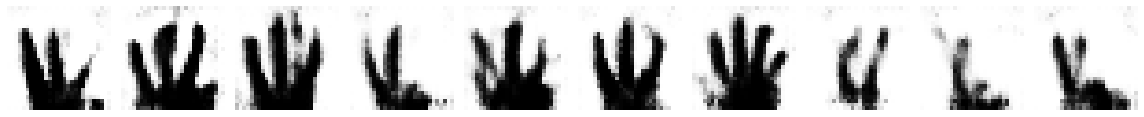

 57%|█████▋    | 1700/3000 [04:28<06:12,  3.49it/s]

1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 1701/3000 [04:28<05:22,  4.02it/s]

>1701, dr[0.689,0.010], df[0.308,0.090], g[2.753,0.059]
1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 1702/3000 [04:28<04:41,  4.61it/s]

>1702, dr[0.435,0.006], df[0.390,0.061], g[1.879,0.066]
1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1703/3000 [04:28<04:15,  5.08it/s]

>1703, dr[0.244,0.022], df[0.778,0.093], g[2.949,0.015]
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1704/3000 [04:29<03:58,  5.44it/s]

>1704, dr[0.440,0.048], df[0.236,0.016], g[2.792,0.025]
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1705/3000 [04:29<03:45,  5.75it/s]

>1705, dr[0.196,0.025], df[0.227,0.078], g[2.977,0.020]
1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 1706/3000 [04:29<03:43,  5.79it/s]

>1706, dr[0.329,0.014], df[0.224,0.151], g[2.921,0.011]
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 1707/3000 [04:29<03:36,  5.97it/s]

>1707, dr[0.383,0.007], df[0.172,0.011], g[1.729,0.014]
1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1708/3000 [04:29<03:35,  6.00it/s]

>1708, dr[0.221,0.054], df[0.344,0.020], g[2.189,0.072]
1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1709/3000 [04:29<03:34,  6.02it/s]

>1709, dr[0.284,0.016], df[0.458,0.068], g[2.553,0.024]
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1710/3000 [04:29<03:30,  6.14it/s]

>1710, dr[0.592,0.030], df[0.424,0.033], g[1.985,0.126]
1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 1711/3000 [04:30<03:30,  6.11it/s]

>1711, dr[0.282,0.004], df[0.476,0.061], g[2.376,0.042]
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 1712/3000 [04:30<03:27,  6.20it/s]

>1712, dr[0.416,0.005], df[0.366,0.006], g[2.427,0.016]
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 1713/3000 [04:30<03:36,  5.94it/s]

>1713, dr[0.639,0.005], df[0.231,0.105], g[1.785,0.073]
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1714/3000 [04:30<03:36,  5.93it/s]

>1714, dr[0.296,0.036], df[0.548,0.008], g[1.877,0.027]
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1715/3000 [04:30<03:34,  5.99it/s]

>1715, dr[0.241,0.012], df[0.303,0.180], g[2.228,0.007]
1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 1716/3000 [04:30<03:32,  6.04it/s]

>1716, dr[0.533,0.015], df[0.596,0.029], g[2.096,0.028]
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1717/3000 [04:31<03:29,  6.13it/s]

>1717, dr[0.242,0.025], df[0.347,0.006], g[2.099,0.014]
1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 1718/3000 [04:31<03:26,  6.21it/s]

>1718, dr[0.357,0.002], df[0.199,0.099], g[2.249,0.047]
1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1719/3000 [04:31<03:29,  6.10it/s]

>1719, dr[0.322,0.020], df[0.395,0.047], g[1.916,0.099]
1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 1720/3000 [04:31<03:33,  6.00it/s]

>1720, dr[0.246,0.017], df[0.385,0.007], g[2.060,0.018]
1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 1721/3000 [04:31<03:30,  6.08it/s]

>1721, dr[0.260,0.038], df[0.255,0.118], g[2.702,0.076]
1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 1722/3000 [04:31<03:32,  6.03it/s]

>1722, dr[0.490,0.004], df[0.702,0.015], g[2.855,0.025]
1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 1723/3000 [04:32<03:33,  5.98it/s]

>1723, dr[0.652,0.014], df[0.179,0.012], g[2.297,0.014]
1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 1724/3000 [04:32<03:30,  6.05it/s]

>1724, dr[0.357,0.021], df[0.357,0.008], g[1.904,0.057]
1/1 [==============================] - 0s 17ms/step


 57%|█████▊    | 1725/3000 [04:32<03:40,  5.79it/s]

>1725, dr[0.278,0.017], df[0.404,0.027], g[1.619,0.029]
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 1726/3000 [04:32<03:38,  5.84it/s]

>1726, dr[0.290,0.005], df[0.402,0.004], g[2.255,0.023]
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1727/3000 [04:32<03:35,  5.91it/s]

>1727, dr[0.217,0.016], df[0.201,0.054], g[2.554,0.028]
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1728/3000 [04:32<03:31,  6.01it/s]

>1728, dr[0.411,0.012], df[0.333,0.035], g[2.118,0.065]
1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 1729/3000 [04:33<03:27,  6.12it/s]

>1729, dr[0.164,0.003], df[0.410,0.015], g[2.746,0.084]
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1730/3000 [04:33<03:22,  6.26it/s]

>1730, dr[0.517,0.004], df[0.256,0.040], g[2.403,0.070]
1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 1731/3000 [04:33<03:23,  6.23it/s]

>1731, dr[0.246,0.004], df[0.567,0.006], g[2.712,0.024]
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1732/3000 [04:33<03:23,  6.23it/s]

>1732, dr[0.449,0.020], df[0.243,0.037], g[2.784,0.069]
1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1733/3000 [04:33<03:24,  6.20it/s]

>1733, dr[0.406,0.005], df[0.367,0.073], g[2.523,0.095]
1/1 [==============================] - 0s 14ms/step


 58%|█████▊    | 1734/3000 [04:33<03:28,  6.08it/s]

>1734, dr[0.269,0.006], df[0.524,0.014], g[2.397,0.011]
1/1 [==============================] - 0s 19ms/step
>1735, dr[0.452,0.003], df[0.221,0.016], g[2.154,0.023]


 58%|█████▊    | 1735/3000 [04:34<03:41,  5.71it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1736/3000 [04:34<03:31,  5.97it/s]

>1736, dr[0.306,0.005], df[0.381,0.138], g[1.944,0.041]
1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 1737/3000 [04:34<03:28,  6.06it/s]

>1737, dr[0.222,0.017], df[0.153,0.002], g[1.950,0.022]
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1738/3000 [04:34<03:27,  6.08it/s]

>1738, dr[0.294,0.009], df[0.331,0.014], g[1.703,0.074]
1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 1739/3000 [04:34<03:27,  6.08it/s]

>1739, dr[0.173,0.030], df[0.317,0.037], g[2.026,0.069]
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1740/3000 [04:34<03:24,  6.15it/s]

>1740, dr[0.201,0.024], df[0.266,0.058], g[2.343,0.041]
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1741/3000 [04:35<03:26,  6.08it/s]

>1741, dr[0.710,0.008], df[0.754,0.028], g[1.795,0.061]
1/1 [==============================] - 0s 14ms/step


 58%|█████▊    | 1742/3000 [04:35<03:24,  6.15it/s]

>1742, dr[0.297,0.027], df[0.338,0.006], g[2.298,0.065]
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1743/3000 [04:35<03:21,  6.24it/s]

>1743, dr[0.168,0.019], df[0.247,0.016], g[2.411,0.085]
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1744/3000 [04:35<03:25,  6.12it/s]

>1744, dr[0.335,0.004], df[0.256,0.041], g[2.154,0.076]
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1745/3000 [04:35<03:24,  6.13it/s]

>1745, dr[0.395,0.029], df[0.420,0.107], g[2.242,0.021]
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 1746/3000 [04:35<03:26,  6.08it/s]

>1746, dr[0.175,0.016], df[0.337,0.036], g[2.809,0.073]
1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 1747/3000 [04:36<03:25,  6.09it/s]

>1747, dr[0.502,0.007], df[0.350,0.113], g[2.152,0.077]
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 1748/3000 [04:36<03:27,  6.02it/s]

>1748, dr[0.379,0.032], df[0.200,0.074], g[1.997,0.118]
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 1749/3000 [04:36<03:30,  5.94it/s]

>1749, dr[0.308,0.012], df[0.677,0.035], g[2.358,0.029]
1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 1750/3000 [04:36<03:29,  5.95it/s]

>1750, dr[0.469,0.034], df[0.322,0.054], g[1.966,0.032]
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 1751/3000 [04:36<03:29,  5.95it/s]

>1751, dr[0.268,0.013], df[0.375,0.008], g[2.562,0.076]
1/1 [==============================] - 0s 14ms/step


 58%|█████▊    | 1752/3000 [04:36<03:27,  6.01it/s]

>1752, dr[0.478,0.065], df[0.429,0.068], g[2.374,0.047]
1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 1753/3000 [04:37<03:28,  5.98it/s]

>1753, dr[0.374,0.018], df[0.525,0.006], g[1.599,0.078]
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1754/3000 [04:37<03:27,  6.01it/s]

>1754, dr[0.138,0.019], df[0.414,0.104], g[2.752,0.089]
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 1755/3000 [04:37<03:26,  6.04it/s]

>1755, dr[0.437,0.019], df[0.218,0.063], g[2.430,0.004]
1/1 [==============================] - 0s 14ms/step


 59%|█████▊    | 1756/3000 [04:37<03:25,  6.05it/s]

>1756, dr[0.197,0.032], df[0.247,0.012], g[1.985,0.022]
1/1 [==============================] - 0s 15ms/step


 59%|█████▊    | 1757/3000 [04:37<03:21,  6.18it/s]

>1757, dr[0.389,0.003], df[0.470,0.021], g[2.008,0.116]
1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1758/3000 [04:37<03:25,  6.05it/s]

>1758, dr[0.481,0.008], df[0.247,0.030], g[1.768,0.067]
1/1 [==============================] - 0s 15ms/step


 59%|█████▊    | 1759/3000 [04:38<03:26,  6.02it/s]

>1759, dr[0.245,0.011], df[0.580,0.035], g[2.347,0.066]
1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 1760/3000 [04:38<03:20,  6.19it/s]

>1760, dr[0.198,0.003], df[0.352,0.085], g[2.919,0.115]
1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 1761/3000 [04:38<03:25,  6.02it/s]

>1761, dr[0.517,0.005], df[0.214,0.028], g[3.278,0.051]
1/1 [==============================] - 0s 14ms/step


 59%|█████▊    | 1762/3000 [04:38<03:26,  5.99it/s]

>1762, dr[0.389,0.013], df[0.232,0.021], g[2.583,0.101]
1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1763/3000 [04:38<03:25,  6.02it/s]

>1763, dr[0.385,0.060], df[0.674,0.064], g[1.785,0.004]
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1764/3000 [04:38<03:26,  5.98it/s]

>1764, dr[0.168,0.019], df[0.382,0.033], g[2.568,0.108]
1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 1765/3000 [04:39<03:26,  5.98it/s]

>1765, dr[0.347,0.097], df[0.379,0.022], g[2.594,0.064]
1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 1766/3000 [04:39<03:26,  5.98it/s]

>1766, dr[0.273,0.014], df[0.250,0.019], g[2.752,0.013]
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1767/3000 [04:39<03:19,  6.19it/s]

>1767, dr[0.296,0.004], df[0.540,0.095], g[2.960,0.065]
1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 1768/3000 [04:39<03:18,  6.21it/s]

>1768, dr[0.376,0.032], df[0.281,0.031], g[2.403,0.054]
1/1 [==============================] - 0s 14ms/step


 59%|█████▉    | 1769/3000 [04:39<03:19,  6.16it/s]

>1769, dr[0.459,0.002], df[0.147,0.027], g[2.016,0.018]
1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1770/3000 [04:39<03:16,  6.25it/s]

>1770, dr[0.137,0.004], df[0.185,0.020], g[1.797,0.025]
1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 1771/3000 [04:40<03:15,  6.28it/s]

>1771, dr[0.229,0.009], df[0.460,0.026], g[1.931,0.028]
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1772/3000 [04:40<03:17,  6.22it/s]

>1772, dr[0.293,0.005], df[0.364,0.012], g[2.047,0.023]
1/1 [==============================] - 0s 14ms/step


 59%|█████▉    | 1773/3000 [04:40<03:15,  6.27it/s]

>1773, dr[0.636,0.021], df[0.427,0.009], g[2.091,0.050]
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1774/3000 [04:40<03:17,  6.21it/s]

>1774, dr[0.313,0.011], df[0.589,0.037], g[2.732,0.081]
1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 1775/3000 [04:40<03:16,  6.23it/s]

>1775, dr[0.424,0.040], df[0.127,0.013], g[1.891,0.020]
1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1776/3000 [04:40<03:17,  6.19it/s]

>1776, dr[0.265,0.022], df[0.491,0.015], g[2.505,0.019]
1/1 [==============================] - 0s 13ms/step


 59%|█████▉    | 1777/3000 [04:41<03:22,  6.04it/s]

>1777, dr[0.168,0.010], df[0.269,0.072], g[2.330,0.074]
1/1 [==============================] - 0s 14ms/step


 59%|█████▉    | 1778/3000 [04:41<03:24,  5.98it/s]

>1778, dr[0.262,0.008], df[0.246,0.006], g[2.599,0.040]
1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 1779/3000 [04:41<03:23,  5.99it/s]

>1779, dr[0.385,0.007], df[0.094,0.035], g[2.190,0.039]
1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 1780/3000 [04:41<03:24,  5.96it/s]

>1780, dr[0.167,0.005], df[0.313,0.008], g[2.065,0.019]
1/1 [==============================] - 0s 14ms/step


 59%|█████▉    | 1781/3000 [04:41<03:25,  5.94it/s]

>1781, dr[0.302,0.087], df[0.427,0.010], g[2.028,0.095]
1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 1782/3000 [04:41<03:28,  5.84it/s]

>1782, dr[0.371,0.013], df[0.363,0.037], g[2.316,0.031]
1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 1783/3000 [04:42<03:24,  5.97it/s]

>1783, dr[0.556,0.008], df[0.436,0.025], g[2.047,0.015]
1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 1784/3000 [04:42<03:22,  6.01it/s]

>1784, dr[0.227,0.003], df[0.338,0.028], g[2.088,0.080]
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1785/3000 [04:42<03:20,  6.05it/s]

>1785, dr[0.511,0.015], df[0.599,0.042], g[2.214,0.044]
1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1786/3000 [04:42<03:22,  6.00it/s]

>1786, dr[0.371,0.008], df[0.422,0.019], g[2.203,0.030]
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1787/3000 [04:42<03:23,  5.96it/s]

>1787, dr[0.425,0.033], df[0.272,0.005], g[2.143,0.032]
1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 1788/3000 [04:42<03:18,  6.10it/s]

>1788, dr[0.290,0.005], df[0.299,0.111], g[2.100,0.070]
1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1789/3000 [04:43<03:13,  6.26it/s]

>1789, dr[0.176,0.018], df[0.548,0.059], g[2.148,0.036]
1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 1790/3000 [04:43<03:13,  6.27it/s]

>1790, dr[0.284,0.011], df[0.225,0.028], g[2.538,0.028]
1/1 [==============================] - 0s 15ms/step


 60%|█████▉    | 1791/3000 [04:43<03:16,  6.14it/s]

>1791, dr[0.332,0.027], df[0.247,0.003], g[2.432,0.078]
1/1 [==============================] - 0s 14ms/step


 60%|█████▉    | 1792/3000 [04:43<03:18,  6.08it/s]

>1792, dr[0.239,0.059], df[0.308,0.003], g[2.237,0.014]
1/1 [==============================] - 0s 14ms/step


 60%|█████▉    | 1793/3000 [04:43<03:21,  5.99it/s]

>1793, dr[0.356,0.012], df[0.343,0.119], g[1.808,0.054]
1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 1794/3000 [04:43<03:21,  5.98it/s]

>1794, dr[0.340,0.007], df[0.257,0.044], g[2.105,0.037]
1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 1795/3000 [04:44<03:23,  5.93it/s]

>1795, dr[0.278,0.007], df[0.441,0.119], g[1.699,0.020]
1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1796/3000 [04:44<03:24,  5.89it/s]

>1796, dr[0.339,0.010], df[0.398,0.022], g[2.435,0.098]
1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1797/3000 [04:44<03:19,  6.04it/s]

>1797, dr[0.190,0.011], df[0.361,0.006], g[2.633,0.050]
1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 1798/3000 [04:44<03:19,  6.03it/s]

>1798, dr[0.334,0.007], df[0.406,0.024], g[2.887,0.100]
1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 1799/3000 [04:44<03:19,  6.03it/s]

>1799, dr[0.397,0.013], df[0.181,0.040], g[2.709,0.022]
1/1 [==============================] - 0s 20ms/step
>1800, dr[0.290,0.008], df[0.294,0.009], g[2.122,0.153]
1/1 [==============================] - 0s 28ms/step


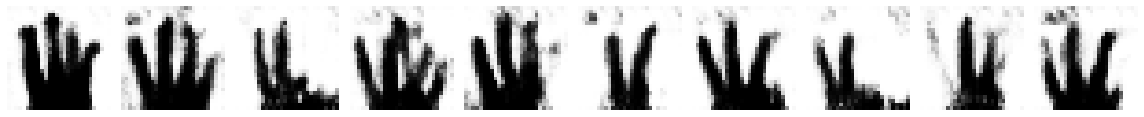

 60%|██████    | 1800/3000 [04:45<05:43,  3.50it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 1801/3000 [04:45<04:57,  4.03it/s]

>1801, dr[0.377,0.011], df[0.544,0.143], g[2.839,0.038]
1/1 [==============================] - 0s 14ms/step


 60%|██████    | 1802/3000 [04:45<04:26,  4.50it/s]

>1802, dr[0.458,0.007], df[0.145,0.017], g[1.569,0.118]
1/1 [==============================] - 0s 15ms/step


 60%|██████    | 1803/3000 [04:45<04:03,  4.92it/s]

>1803, dr[0.316,0.024], df[0.590,0.009], g[2.403,0.036]
1/1 [==============================] - 0s 20ms/step


 60%|██████    | 1804/3000 [04:45<03:51,  5.16it/s]

>1804, dr[0.259,0.002], df[0.343,0.003], g[2.530,0.008]
1/1 [==============================] - 0s 15ms/step


 60%|██████    | 1805/3000 [04:46<03:43,  5.35it/s]

>1805, dr[0.245,0.015], df[0.270,0.033], g[2.350,0.024]
1/1 [==============================] - 0s 16ms/step


 60%|██████    | 1806/3000 [04:46<03:36,  5.52it/s]

>1806, dr[0.345,0.011], df[0.229,0.003], g[2.260,0.021]
1/1 [==============================] - 0s 14ms/step


 60%|██████    | 1807/3000 [04:46<03:31,  5.65it/s]

>1807, dr[0.265,0.010], df[0.382,0.029], g[2.507,0.110]
1/1 [==============================] - 0s 14ms/step


 60%|██████    | 1808/3000 [04:46<03:29,  5.69it/s]

>1808, dr[0.305,0.005], df[0.151,0.031], g[2.471,0.020]
1/1 [==============================] - 0s 15ms/step


 60%|██████    | 1809/3000 [04:46<03:21,  5.90it/s]

>1809, dr[0.321,0.018], df[0.376,0.023], g[2.571,0.006]
1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1810/3000 [04:46<03:21,  5.91it/s]

>1810, dr[0.233,0.010], df[0.152,0.013], g[2.160,0.016]
1/1 [==============================] - 0s 15ms/step


 60%|██████    | 1811/3000 [04:47<03:16,  6.05it/s]

>1811, dr[0.171,0.014], df[0.236,0.089], g[2.292,0.039]
1/1 [==============================] - 0s 18ms/step


 60%|██████    | 1812/3000 [04:47<03:18,  5.98it/s]

>1812, dr[0.149,0.003], df[0.451,0.034], g[2.605,0.029]
1/1 [==============================] - 0s 19ms/step


 60%|██████    | 1813/3000 [04:47<03:14,  6.09it/s]

>1813, dr[0.491,0.014], df[0.259,0.024], g[2.061,0.036]
1/1 [==============================] - 0s 14ms/step


 60%|██████    | 1814/3000 [04:47<03:11,  6.18it/s]

>1814, dr[0.326,0.003], df[0.261,0.050], g[2.198,0.048]
1/1 [==============================] - 0s 17ms/step


 60%|██████    | 1815/3000 [04:47<03:10,  6.22it/s]

>1815, dr[0.267,0.022], df[0.559,0.057], g[2.213,0.069]
1/1 [==============================] - 0s 22ms/step


 61%|██████    | 1816/3000 [04:47<03:18,  5.96it/s]

>1816, dr[0.412,0.007], df[0.271,0.023], g[2.409,0.022]
1/1 [==============================] - 0s 14ms/step


 61%|██████    | 1817/3000 [04:48<03:20,  5.91it/s]

>1817, dr[0.691,0.012], df[0.460,0.042], g[2.023,0.049]
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 1818/3000 [04:48<03:17,  5.98it/s]

>1818, dr[0.160,0.076], df[0.380,0.036], g[2.608,0.057]
1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1819/3000 [04:48<03:15,  6.03it/s]

>1819, dr[0.359,0.037], df[0.538,0.069], g[2.476,0.030]
1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1820/3000 [04:48<03:17,  5.97it/s]

>1820, dr[0.467,0.009], df[0.269,0.150], g[2.200,0.036]
1/1 [==============================] - 0s 13ms/step


 61%|██████    | 1821/3000 [04:48<03:15,  6.02it/s]

>1821, dr[0.529,0.011], df[0.414,0.038], g[2.231,0.059]
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1822/3000 [04:48<03:14,  6.05it/s]

>1822, dr[0.219,0.014], df[0.392,0.008], g[2.292,0.016]
1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1823/3000 [04:49<03:20,  5.88it/s]

>1823, dr[0.247,0.005], df[0.213,0.027], g[2.234,0.037]
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1824/3000 [04:49<03:12,  6.10it/s]

>1824, dr[0.352,0.007], df[0.409,0.044], g[2.369,0.046]
1/1 [==============================] - 0s 23ms/step


 61%|██████    | 1825/3000 [04:49<03:13,  6.08it/s]

>1825, dr[0.334,0.006], df[0.398,0.003], g[2.533,0.120]
1/1 [==============================] - 0s 14ms/step


 61%|██████    | 1826/3000 [04:49<03:15,  5.99it/s]

>1826, dr[0.550,0.048], df[0.433,0.009], g[2.471,0.103]
1/1 [==============================] - 0s 15ms/step


 61%|██████    | 1827/3000 [04:49<03:12,  6.09it/s]

>1827, dr[0.456,0.005], df[0.273,0.059], g[2.046,0.139]
1/1 [==============================] - 0s 18ms/step


 61%|██████    | 1828/3000 [04:49<03:16,  5.97it/s]

>1828, dr[0.257,0.025], df[0.353,0.025], g[2.378,0.023]
1/1 [==============================] - 0s 14ms/step


 61%|██████    | 1829/3000 [04:50<03:14,  6.02it/s]

>1829, dr[0.245,0.011], df[0.305,0.010], g[2.033,0.032]
1/1 [==============================] - 0s 19ms/step


 61%|██████    | 1830/3000 [04:50<03:15,  5.99it/s]

>1830, dr[0.170,0.014], df[0.395,0.057], g[2.505,0.039]
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 1831/3000 [04:50<03:14,  6.02it/s]

>1831, dr[0.501,0.074], df[0.272,0.003], g[2.474,0.041]
1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1832/3000 [04:50<03:14,  6.00it/s]

>1832, dr[0.272,0.017], df[0.424,0.059], g[2.481,0.024]
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 1833/3000 [04:50<03:16,  5.94it/s]

>1833, dr[0.287,0.004], df[0.294,0.021], g[2.889,0.067]
1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1834/3000 [04:50<03:15,  5.97it/s]

>1834, dr[0.251,0.011], df[0.244,0.112], g[2.535,0.026]
1/1 [==============================] - 0s 15ms/step


 61%|██████    | 1835/3000 [04:51<03:10,  6.13it/s]

>1835, dr[0.386,0.011], df[0.267,0.027], g[2.473,0.069]
1/1 [==============================] - 0s 16ms/step


 61%|██████    | 1836/3000 [04:51<03:07,  6.19it/s]

>1836, dr[0.351,0.003], df[0.343,0.072], g[1.893,0.044]
1/1 [==============================] - 0s 17ms/step


 61%|██████    | 1837/3000 [04:51<03:11,  6.08it/s]

>1837, dr[0.356,0.011], df[0.257,0.030], g[1.888,0.045]
1/1 [==============================] - 0s 15ms/step


 61%|██████▏   | 1838/3000 [04:51<03:09,  6.12it/s]

>1838, dr[0.458,0.053], df[0.597,0.015], g[2.097,0.085]
1/1 [==============================] - 0s 16ms/step


 61%|██████▏   | 1839/3000 [04:51<03:15,  5.93it/s]

>1839, dr[0.195,0.016], df[0.256,0.014], g[2.160,0.016]
1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 1840/3000 [04:51<03:13,  6.00it/s]

>1840, dr[0.372,0.007], df[0.332,0.011], g[2.236,0.043]
1/1 [==============================] - 0s 16ms/step


 61%|██████▏   | 1841/3000 [04:52<03:13,  5.98it/s]

>1841, dr[0.308,0.054], df[0.366,0.045], g[2.276,0.026]
1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 1842/3000 [04:52<03:13,  5.99it/s]

>1842, dr[0.246,0.012], df[0.405,0.010], g[2.479,0.010]
1/1 [==============================] - 0s 14ms/step


 61%|██████▏   | 1843/3000 [04:52<03:09,  6.10it/s]

>1843, dr[0.222,0.026], df[0.210,0.036], g[2.571,0.043]
1/1 [==============================] - 0s 14ms/step


 61%|██████▏   | 1844/3000 [04:52<03:08,  6.14it/s]

>1844, dr[0.472,0.007], df[0.235,0.004], g[2.082,0.040]
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1845/3000 [04:52<03:07,  6.16it/s]

>1845, dr[0.323,0.005], df[0.838,0.045], g[2.650,0.048]
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1846/3000 [04:52<03:05,  6.21it/s]

>1846, dr[0.389,0.029], df[0.244,0.005], g[1.994,0.076]
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1847/3000 [04:53<03:15,  5.89it/s]

>1847, dr[0.339,0.008], df[0.268,0.010], g[2.489,0.038]
1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 1848/3000 [04:53<03:16,  5.86it/s]

>1848, dr[0.322,0.014], df[0.404,0.040], g[2.026,0.050]
1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 1849/3000 [04:53<03:11,  6.00it/s]

>1849, dr[0.401,0.006], df[0.537,0.063], g[2.517,0.065]
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1850/3000 [04:53<03:09,  6.07it/s]

>1850, dr[0.492,0.083], df[0.295,0.065], g[2.266,0.068]
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1851/3000 [04:53<03:05,  6.20it/s]

>1851, dr[0.288,0.006], df[0.273,0.008], g[2.007,0.045]
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 1852/3000 [04:53<03:11,  5.99it/s]

>1852, dr[0.198,0.021], df[0.359,0.028], g[2.334,0.036]
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1853/3000 [04:54<03:07,  6.11it/s]

>1853, dr[0.373,0.002], df[0.441,0.005], g[2.375,0.051]
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1854/3000 [04:54<03:09,  6.06it/s]

>1854, dr[0.452,0.018], df[0.528,0.033], g[2.784,0.013]
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1855/3000 [04:54<03:08,  6.09it/s]

>1855, dr[0.611,0.017], df[0.150,0.057], g[2.018,0.051]
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1856/3000 [04:54<03:04,  6.20it/s]

>1856, dr[0.303,0.008], df[0.378,0.006], g[2.101,0.025]
1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1857/3000 [04:54<03:00,  6.33it/s]

>1857, dr[0.314,0.011], df[0.575,0.049], g[2.130,0.017]
1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1858/3000 [04:54<03:00,  6.33it/s]

>1858, dr[0.317,0.002], df[0.264,0.017], g[2.307,0.003]
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1859/3000 [04:54<03:01,  6.30it/s]

>1859, dr[0.477,0.022], df[0.539,0.010], g[2.603,0.011]
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1860/3000 [04:55<03:06,  6.12it/s]

>1860, dr[0.502,0.011], df[0.341,0.007], g[2.214,0.053]
1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 1861/3000 [04:55<03:05,  6.13it/s]

>1861, dr[0.239,0.012], df[0.329,0.015], g[2.452,0.040]
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1862/3000 [04:55<03:09,  6.01it/s]

>1862, dr[0.214,0.063], df[0.246,0.010], g[2.079,0.042]
1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1863/3000 [04:55<03:09,  6.00it/s]

>1863, dr[0.208,0.001], df[0.212,0.073], g[2.381,0.006]
1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 1864/3000 [04:55<03:07,  6.05it/s]

>1864, dr[0.243,0.005], df[0.320,0.020], g[2.183,0.035]
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 1865/3000 [04:55<03:05,  6.12it/s]

>1865, dr[0.370,0.158], df[0.208,0.010], g[2.084,0.020]
1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1866/3000 [04:56<03:09,  6.00it/s]

>1866, dr[0.251,0.040], df[0.313,0.037], g[1.878,0.041]
1/1 [==============================] - 0s 15ms/step


 62%|██████▏   | 1867/3000 [04:56<03:07,  6.03it/s]

>1867, dr[0.230,0.015], df[0.286,0.018], g[1.954,0.120]
1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 1868/3000 [04:56<03:08,  6.02it/s]

>1868, dr[0.246,0.048], df[0.336,0.031], g[2.346,0.039]
1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 1869/3000 [04:56<03:12,  5.89it/s]

>1869, dr[0.319,0.004], df[0.397,0.102], g[2.502,0.016]
1/1 [==============================] - 0s 14ms/step


 62%|██████▏   | 1870/3000 [04:56<03:13,  5.83it/s]

>1870, dr[0.301,0.003], df[0.363,0.024], g[2.526,0.013]
1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 1871/3000 [04:56<03:09,  5.94it/s]

>1871, dr[0.339,0.030], df[0.345,0.012], g[2.680,0.023]
1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1872/3000 [04:57<03:09,  5.96it/s]

>1872, dr[0.222,0.021], df[0.440,0.025], g[3.130,0.022]
1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 1873/3000 [04:57<03:12,  5.86it/s]

>1873, dr[0.565,0.005], df[0.279,0.027], g[2.367,0.016]
1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 1874/3000 [04:57<03:16,  5.73it/s]

>1874, dr[0.227,0.027], df[0.389,0.088], g[2.604,0.036]
1/1 [==============================] - 0s 20ms/step


 62%|██████▎   | 1875/3000 [04:57<03:11,  5.87it/s]

>1875, dr[0.411,0.005], df[0.417,0.006], g[2.156,0.041]
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1876/3000 [04:57<03:08,  5.97it/s]

>1876, dr[0.498,0.003], df[0.439,0.068], g[2.683,0.039]
1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 1877/3000 [04:58<03:10,  5.89it/s]

>1877, dr[0.249,0.004], df[0.332,0.023], g[2.312,0.073]
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 1878/3000 [04:58<03:08,  5.95it/s]

>1878, dr[0.328,0.007], df[0.270,0.024], g[2.470,0.075]
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1879/3000 [04:58<03:09,  5.91it/s]

>1879, dr[0.466,0.015], df[0.360,0.030], g[2.301,0.024]
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1880/3000 [04:58<03:09,  5.91it/s]

>1880, dr[0.352,0.059], df[0.504,0.006], g[1.744,0.017]
1/1 [==============================] - 0s 19ms/step
>1881, dr[0.285,0.017], df[0.248,0.017], g[1.884,0.015]


 63%|██████▎   | 1881/3000 [04:58<03:21,  5.56it/s]

1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 1882/3000 [04:58<03:15,  5.73it/s]

>1882, dr[0.332,0.003], df[0.322,0.095], g[2.221,0.076]
1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 1883/3000 [04:59<03:12,  5.80it/s]

>1883, dr[0.207,0.041], df[0.242,0.028], g[2.311,0.055]
1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 1884/3000 [04:59<03:12,  5.79it/s]

>1884, dr[0.450,0.014], df[0.602,0.053], g[2.388,0.020]
1/1 [==============================] - 0s 15ms/step


 63%|██████▎   | 1885/3000 [04:59<03:08,  5.91it/s]

>1885, dr[0.445,0.046], df[0.502,0.047], g[2.003,0.023]
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1886/3000 [04:59<03:03,  6.06it/s]

>1886, dr[0.369,0.007], df[0.255,0.002], g[2.483,0.045]
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1887/3000 [04:59<03:00,  6.18it/s]

>1887, dr[0.369,0.003], df[0.534,0.018], g[2.344,0.008]
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1888/3000 [04:59<03:02,  6.10it/s]

>1888, dr[0.391,0.003], df[0.541,0.019], g[2.465,0.074]
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1889/3000 [05:00<03:03,  6.05it/s]

>1889, dr[0.574,0.006], df[0.345,0.142], g[2.054,0.019]
1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 1890/3000 [05:00<03:05,  5.99it/s]

>1890, dr[0.209,0.006], df[0.256,0.079], g[2.034,0.080]
1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 1891/3000 [05:00<03:03,  6.03it/s]

>1891, dr[0.292,0.005], df[0.210,0.004], g[2.553,0.058]
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 1892/3000 [05:00<03:03,  6.04it/s]

>1892, dr[0.353,0.021], df[0.331,0.029], g[2.330,0.111]
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1893/3000 [05:00<03:01,  6.10it/s]

>1893, dr[0.352,0.016], df[0.522,0.040], g[1.960,0.016]
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1894/3000 [05:00<03:03,  6.03it/s]

>1894, dr[0.266,0.007], df[0.549,0.023], g[2.941,0.032]
1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 1895/3000 [05:01<03:00,  6.12it/s]

>1895, dr[0.464,0.004], df[0.280,0.043], g[3.141,0.035]
1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1896/3000 [05:01<03:01,  6.07it/s]

>1896, dr[0.338,0.003], df[0.250,0.043], g[2.200,0.036]
1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1897/3000 [05:01<03:01,  6.09it/s]

>1897, dr[0.218,0.025], df[0.369,0.089], g[2.682,0.033]
1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 1898/3000 [05:01<03:01,  6.08it/s]

>1898, dr[0.377,0.021], df[0.253,0.009], g[2.104,0.020]
1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 1899/3000 [05:01<03:00,  6.08it/s]

>1899, dr[0.224,0.004], df[0.431,0.010], g[2.862,0.016]
1/1 [==============================] - 0s 15ms/step
>1900, dr[0.540,0.005], df[0.356,0.003], g[2.694,0.072]
1/1 [==============================] - 0s 23ms/step


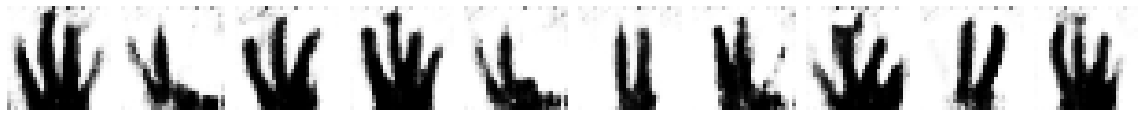

 63%|██████▎   | 1900/3000 [05:02<05:19,  3.44it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1901/3000 [05:02<04:34,  4.00it/s]

>1901, dr[0.368,0.021], df[0.462,0.020], g[1.967,0.016]
1/1 [==============================] - 0s 14ms/step


 63%|██████▎   | 1902/3000 [05:02<04:01,  4.54it/s]

>1902, dr[0.260,0.007], df[0.337,0.031], g[2.334,0.024]
1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 1903/3000 [05:02<03:42,  4.94it/s]

>1903, dr[0.385,0.005], df[0.547,0.020], g[2.376,0.085]
1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1904/3000 [05:02<03:28,  5.26it/s]

>1904, dr[0.379,0.011], df[0.209,0.049], g[2.524,0.041]
1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 1905/3000 [05:03<03:20,  5.47it/s]

>1905, dr[0.285,0.005], df[0.367,0.010], g[2.351,0.108]
1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 1906/3000 [05:03<03:19,  5.48it/s]

>1906, dr[0.249,0.006], df[0.151,0.020], g[2.057,0.007]
1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 1907/3000 [05:03<03:11,  5.72it/s]

>1907, dr[0.299,0.028], df[0.330,0.003], g[1.924,0.028]
1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 1908/3000 [05:03<03:12,  5.69it/s]

>1908, dr[0.339,0.005], df[0.298,0.012], g[2.014,0.032]
1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 1909/3000 [05:03<03:05,  5.87it/s]

>1909, dr[0.275,0.007], df[0.458,0.040], g[2.101,0.004]
1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 1910/3000 [05:03<03:06,  5.86it/s]

>1910, dr[0.211,0.002], df[0.461,0.005], g[3.065,0.053]
1/1 [==============================] - 0s 14ms/step


 64%|██████▎   | 1911/3000 [05:04<03:04,  5.90it/s]

>1911, dr[0.551,0.020], df[0.285,0.019], g[2.558,0.014]
1/1 [==============================] - 0s 14ms/step


 64%|██████▎   | 1912/3000 [05:04<03:05,  5.87it/s]

>1912, dr[0.264,0.019], df[0.604,0.093], g[2.830,0.012]
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 1913/3000 [05:04<03:01,  6.00it/s]

>1913, dr[0.522,0.005], df[0.337,0.054], g[2.708,0.052]
1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 1914/3000 [05:04<03:03,  5.93it/s]

>1914, dr[0.561,0.026], df[0.379,0.027], g[2.094,0.009]
1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 1915/3000 [05:04<03:01,  5.97it/s]

>1915, dr[0.373,0.048], df[0.354,0.045], g[1.750,0.021]
1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 1916/3000 [05:04<03:02,  5.94it/s]

>1916, dr[0.230,0.016], df[0.417,0.087], g[2.609,0.059]
1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 1917/3000 [05:05<02:57,  6.10it/s]

>1917, dr[0.562,0.076], df[0.468,0.133], g[2.499,0.023]
1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 1918/3000 [05:05<02:59,  6.02it/s]

>1918, dr[0.293,0.008], df[0.259,0.023], g[2.240,0.034]
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 1919/3000 [05:05<02:59,  6.02it/s]

>1919, dr[0.344,0.014], df[0.296,0.010], g[2.183,0.017]
1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 1920/3000 [05:05<03:04,  5.86it/s]

>1920, dr[0.303,0.021], df[0.430,0.026], g[2.166,0.087]
1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 1921/3000 [05:05<03:04,  5.84it/s]

>1921, dr[0.332,0.004], df[0.361,0.012], g[2.395,0.005]
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 1922/3000 [05:05<03:01,  5.93it/s]

>1922, dr[0.230,0.037], df[0.280,0.002], g[2.468,0.062]
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 1923/3000 [05:06<02:58,  6.04it/s]

>1923, dr[0.298,0.003], df[0.330,0.013], g[2.326,0.053]
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1924/3000 [05:06<02:57,  6.05it/s]

>1924, dr[0.397,0.073], df[0.341,0.011], g[2.627,0.023]
1/1 [==============================] - 0s 15ms/step
>1925, dr[0.220,0.006], df[0.209,0.022], g[2.430,0.024]


 64%|██████▍   | 1925/3000 [05:06<03:10,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1926/3000 [05:06<03:04,  5.81it/s]

>1926, dr[0.463,0.070], df[0.384,0.106], g[2.062,0.092]
1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 1927/3000 [05:06<03:03,  5.84it/s]

>1927, dr[0.281,0.006], df[0.214,0.086], g[1.898,0.014]
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1928/3000 [05:06<03:02,  5.88it/s]

>1928, dr[0.196,0.008], df[0.311,0.161], g[1.814,0.097]
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 1929/3000 [05:07<02:58,  5.99it/s]

>1929, dr[0.188,0.003], df[0.296,0.028], g[2.209,0.015]
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1930/3000 [05:07<02:54,  6.12it/s]

>1930, dr[0.397,0.007], df[0.256,0.101], g[2.178,0.041]
1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 1931/3000 [05:07<02:59,  5.94it/s]

>1931, dr[0.249,0.015], df[0.555,0.008], g[1.916,0.071]
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 1932/3000 [05:07<02:58,  5.98it/s]

>1932, dr[0.217,0.080], df[0.241,0.019], g[2.968,0.057]
1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 1933/3000 [05:07<02:57,  6.00it/s]

>1933, dr[0.347,0.005], df[0.231,0.025], g[2.189,0.019]
1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 1934/3000 [05:07<02:56,  6.05it/s]

>1934, dr[0.453,0.072], df[0.475,0.044], g[2.180,0.091]
1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 1935/3000 [05:08<02:55,  6.07it/s]

>1935, dr[0.305,0.004], df[0.438,0.148], g[2.400,0.100]
1/1 [==============================] - 0s 14ms/step


 65%|██████▍   | 1936/3000 [05:08<02:54,  6.09it/s]

>1936, dr[0.289,0.002], df[0.272,0.031], g[1.855,0.019]
1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 1937/3000 [05:08<02:58,  5.97it/s]

>1937, dr[0.334,0.005], df[0.514,0.014], g[2.195,0.114]
1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 1938/3000 [05:08<03:00,  5.88it/s]

>1938, dr[0.599,0.031], df[0.331,0.137], g[2.321,0.096]
1/1 [==============================] - 0s 14ms/step


 65%|██████▍   | 1939/3000 [05:08<03:00,  5.89it/s]

>1939, dr[0.218,0.005], df[0.355,0.039], g[2.034,0.046]
1/1 [==============================] - 0s 15ms/step


 65%|██████▍   | 1940/3000 [05:08<03:01,  5.85it/s]

>1940, dr[0.237,0.007], df[0.185,0.016], g[2.055,0.078]
1/1 [==============================] - 0s 13ms/step


 65%|██████▍   | 1941/3000 [05:09<02:59,  5.91it/s]

>1941, dr[0.307,0.005], df[0.511,0.043], g[2.478,0.026]
1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 1942/3000 [05:09<02:59,  5.88it/s]

>1942, dr[0.288,0.065], df[0.382,0.076], g[2.211,0.105]
1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 1943/3000 [05:09<03:03,  5.77it/s]

>1943, dr[0.284,0.052], df[0.376,0.002], g[2.674,0.031]
1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 1944/3000 [05:09<03:00,  5.86it/s]

>1944, dr[0.561,0.004], df[0.286,0.044], g[2.147,0.020]
1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 1945/3000 [05:09<02:57,  5.93it/s]

>1945, dr[0.401,0.040], df[0.498,0.064], g[2.283,0.069]
1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 1946/3000 [05:09<02:52,  6.10it/s]

>1946, dr[0.467,0.005], df[0.293,0.062], g[2.052,0.081]
1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 1947/3000 [05:10<02:55,  5.99it/s]

>1947, dr[0.313,0.004], df[0.485,0.040], g[1.819,0.017]
1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 1948/3000 [05:10<02:51,  6.15it/s]

>1948, dr[0.319,0.004], df[0.200,0.009], g[2.413,0.012]
1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 1949/3000 [05:10<02:52,  6.09it/s]

>1949, dr[0.207,0.002], df[0.322,0.004], g[2.861,0.071]
1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 1950/3000 [05:10<02:50,  6.14it/s]

>1950, dr[0.351,0.027], df[0.248,0.016], g[2.552,0.039]
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 1951/3000 [05:10<02:52,  6.07it/s]

>1951, dr[0.355,0.042], df[0.303,0.068], g[1.990,0.012]
1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 1952/3000 [05:10<02:50,  6.13it/s]

>1952, dr[0.426,0.022], df[0.427,0.019], g[2.161,0.043]
1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 1953/3000 [05:11<02:51,  6.10it/s]

>1953, dr[0.427,0.025], df[0.471,0.006], g[2.212,0.014]
1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 1954/3000 [05:11<02:53,  6.04it/s]

>1954, dr[0.272,0.011], df[0.387,0.038], g[2.981,0.042]
1/1 [==============================] - 0s 14ms/step


 65%|██████▌   | 1955/3000 [05:11<02:55,  5.94it/s]

>1955, dr[0.308,0.019], df[0.266,0.024], g[2.113,0.036]
1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 1956/3000 [05:11<02:54,  5.98it/s]

>1956, dr[0.353,0.014], df[0.190,0.009], g[1.967,0.019]
1/1 [==============================] - 0s 14ms/step


 65%|██████▌   | 1957/3000 [05:11<02:54,  5.96it/s]

>1957, dr[0.234,0.004], df[0.486,0.058], g[2.611,0.017]
1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 1958/3000 [05:11<02:58,  5.82it/s]

>1958, dr[0.276,0.013], df[0.300,0.110], g[2.597,0.136]
1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 1959/3000 [05:12<02:57,  5.87it/s]

>1959, dr[0.432,0.006], df[0.395,0.101], g[2.518,0.095]
1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 1960/3000 [05:12<02:56,  5.90it/s]

>1960, dr[0.394,0.015], df[0.426,0.019], g[2.312,0.030]
1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 1961/3000 [05:12<02:56,  5.89it/s]

>1961, dr[0.402,0.006], df[0.292,0.007], g[2.310,0.033]
1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1962/3000 [05:12<02:54,  5.96it/s]

>1962, dr[0.292,0.021], df[0.414,0.094], g[2.993,0.029]
1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 1963/3000 [05:12<02:55,  5.91it/s]

>1963, dr[0.351,0.010], df[0.434,0.022], g[2.464,0.034]
1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 1964/3000 [05:12<02:57,  5.82it/s]

>1964, dr[0.388,0.012], df[0.217,0.188], g[2.306,0.013]
1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 1965/3000 [05:13<02:52,  5.99it/s]

>1965, dr[0.328,0.035], df[0.371,0.008], g[2.335,0.025]
1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 1966/3000 [05:13<02:53,  5.96it/s]

>1966, dr[0.257,0.004], df[0.370,0.103], g[2.944,0.028]
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 1967/3000 [05:13<02:52,  5.98it/s]

>1967, dr[0.332,0.006], df[0.423,0.009], g[2.340,0.044]
1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 1968/3000 [05:13<02:57,  5.81it/s]

>1968, dr[0.414,0.003], df[0.152,0.025], g[2.018,0.015]
1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 1969/3000 [05:13<02:54,  5.90it/s]

>1969, dr[0.243,0.027], df[0.312,0.007], g[2.011,0.015]
1/1 [==============================] - 0s 19ms/step
>1970, dr[0.237,0.005], df[0.398,0.048], g[2.396,0.086]


 66%|██████▌   | 1970/3000 [05:14<05:26,  3.16it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 1971/3000 [05:14<04:38,  3.69it/s]

>1971, dr[0.326,0.009], df[0.420,0.133], g[2.264,0.029]
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 1972/3000 [05:14<04:04,  4.20it/s]

>1972, dr[0.331,0.007], df[0.311,0.041], g[2.040,0.019]
1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 1973/3000 [05:14<03:42,  4.61it/s]

>1973, dr[0.476,0.017], df[0.525,0.006], g[1.792,0.023]
1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1974/3000 [05:15<03:23,  5.05it/s]

>1974, dr[0.524,0.028], df[0.486,0.049], g[1.734,0.020]
1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 1975/3000 [05:15<03:14,  5.28it/s]

>1975, dr[0.255,0.006], df[0.344,0.074], g[2.191,0.065]
1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 1976/3000 [05:15<03:06,  5.49it/s]

>1976, dr[0.253,0.014], df[0.528,0.036], g[2.007,0.032]
1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1977/3000 [05:15<03:03,  5.57it/s]

>1977, dr[0.291,0.009], df[0.250,0.023], g[2.786,0.036]
1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 1978/3000 [05:15<03:02,  5.59it/s]

>1978, dr[0.371,0.004], df[0.206,0.050], g[2.299,0.011]
1/1 [==============================] - 0s 16ms/step
>1979, dr[0.440,0.009], df[0.427,0.057], g[1.919,0.016]


 66%|██████▌   | 1979/3000 [05:16<03:07,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 1980/3000 [05:16<02:59,  5.69it/s]

>1980, dr[0.205,0.090], df[0.393,0.123], g[2.294,0.081]
1/1 [==============================] - 0s 15ms/step


 66%|██████▌   | 1981/3000 [05:16<02:57,  5.76it/s]

>1981, dr[0.255,0.017], df[0.205,0.119], g[2.381,0.076]
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 1982/3000 [05:16<02:56,  5.75it/s]

>1982, dr[0.351,0.018], df[0.363,0.008], g[2.337,0.080]
1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 1983/3000 [05:16<02:57,  5.72it/s]

>1983, dr[0.328,0.036], df[0.427,0.013], g[2.151,0.010]
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1984/3000 [05:16<02:54,  5.82it/s]

>1984, dr[0.394,0.045], df[0.369,0.118], g[2.041,0.043]
1/1 [==============================] - 0s 14ms/step


 66%|██████▌   | 1985/3000 [05:17<02:52,  5.88it/s]

>1985, dr[0.311,0.002], df[0.280,0.018], g[1.890,0.013]
1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 1986/3000 [05:17<02:53,  5.84it/s]

>1986, dr[0.396,0.018], df[0.404,0.026], g[2.407,0.040]
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 1987/3000 [05:17<02:48,  6.01it/s]

>1987, dr[0.296,0.010], df[0.676,0.044], g[2.656,0.018]
1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 1988/3000 [05:17<02:50,  5.95it/s]

>1988, dr[0.527,0.007], df[0.575,0.047], g[2.404,0.048]
1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 1989/3000 [05:17<02:52,  5.85it/s]

>1989, dr[0.260,0.005], df[0.284,0.017], g[2.752,0.013]
1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 1990/3000 [05:17<02:52,  5.84it/s]

>1990, dr[0.446,0.071], df[0.391,0.086], g[2.384,0.024]
1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 1991/3000 [05:18<02:50,  5.92it/s]

>1991, dr[0.328,0.034], df[0.396,0.074], g[2.475,0.044]
1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 1992/3000 [05:18<02:45,  6.09it/s]

>1992, dr[0.378,0.015], df[0.257,0.006], g[2.401,0.097]
1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 1993/3000 [05:18<02:45,  6.08it/s]

>1993, dr[0.255,0.122], df[0.338,0.009], g[2.513,0.065]
1/1 [==============================] - 0s 15ms/step


 66%|██████▋   | 1994/3000 [05:18<02:43,  6.16it/s]

>1994, dr[0.441,0.036], df[0.653,0.156], g[2.523,0.075]
1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 1995/3000 [05:18<02:44,  6.12it/s]

>1995, dr[0.470,0.011], df[0.436,0.110], g[2.499,0.040]
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1996/3000 [05:18<02:46,  6.03it/s]

>1996, dr[0.501,0.030], df[0.287,0.016], g[2.356,0.045]
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 1997/3000 [05:19<02:45,  6.07it/s]

>1997, dr[0.353,0.015], df[0.553,0.098], g[2.536,0.032]
1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 1998/3000 [05:19<02:45,  6.06it/s]

>1998, dr[0.401,0.004], df[0.537,0.009], g[2.686,0.064]
1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 1999/3000 [05:19<02:47,  5.97it/s]

>1999, dr[0.632,0.003], df[0.457,0.016], g[2.422,0.087]
1/1 [==============================] - 0s 17ms/step
>2000, dr[0.338,0.048], df[0.328,0.072], g[2.438,0.067]
1/1 [==============================] - 0s 27ms/step


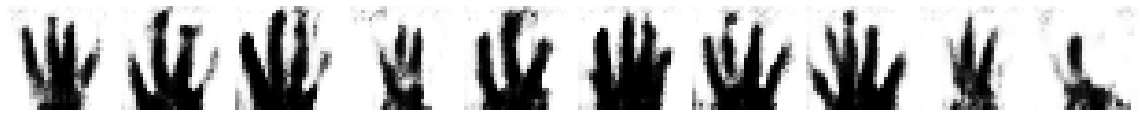

 67%|██████▋   | 2000/3000 [05:19<04:44,  3.51it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2001/3000 [05:20<04:08,  4.02it/s]

>2001, dr[0.407,0.041], df[0.271,0.032], g[1.933,0.011]
1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 2002/3000 [05:20<03:36,  4.62it/s]

>2002, dr[0.306,0.018], df[0.523,0.013], g[1.948,0.021]
1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 2003/3000 [05:20<03:17,  5.05it/s]

>2003, dr[0.288,0.004], df[0.353,0.039], g[2.547,0.019]
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2004/3000 [05:20<03:05,  5.38it/s]

>2004, dr[0.298,0.026], df[0.286,0.059], g[2.165,0.015]
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2005/3000 [05:20<02:59,  5.56it/s]

>2005, dr[0.300,0.020], df[0.500,0.067], g[3.067,0.024]
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2006/3000 [05:20<02:53,  5.72it/s]

>2006, dr[0.264,0.011], df[0.402,0.006], g[2.419,0.123]
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2007/3000 [05:21<02:49,  5.87it/s]

>2007, dr[0.613,0.020], df[0.357,0.047], g[2.442,0.014]
1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 2008/3000 [05:21<02:46,  5.95it/s]

>2008, dr[0.487,0.027], df[0.464,0.009], g[1.969,0.062]
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2009/3000 [05:21<02:44,  6.01it/s]

>2009, dr[0.716,0.015], df[0.536,0.175], g[1.830,0.054]
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2010/3000 [05:21<02:42,  6.10it/s]

>2010, dr[0.293,0.008], df[0.432,0.047], g[2.195,0.020]
1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 2011/3000 [05:21<02:39,  6.20it/s]

>2011, dr[0.363,0.008], df[0.451,0.210], g[2.144,0.014]
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2012/3000 [05:21<02:43,  6.05it/s]

>2012, dr[0.289,0.024], df[0.307,0.028], g[2.030,0.045]
1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 2013/3000 [05:21<02:40,  6.15it/s]

>2013, dr[0.499,0.011], df[0.402,0.108], g[2.036,0.078]
1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 2014/3000 [05:22<02:40,  6.16it/s]

>2014, dr[0.239,0.011], df[0.416,0.058], g[2.038,0.013]
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 2015/3000 [05:22<02:38,  6.21it/s]

>2015, dr[0.409,0.045], df[0.293,0.137], g[2.138,0.022]
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2016/3000 [05:22<02:37,  6.23it/s]

>2016, dr[0.416,0.026], df[0.694,0.013], g[2.548,0.012]
1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 2017/3000 [05:22<02:37,  6.25it/s]

>2017, dr[0.353,0.039], df[0.339,0.079], g[2.746,0.010]
1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 2018/3000 [05:22<02:41,  6.09it/s]

>2018, dr[0.316,0.022], df[0.387,0.032], g[2.468,0.189]
1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 2019/3000 [05:22<02:44,  5.98it/s]

>2019, dr[0.251,0.033], df[0.229,0.015], g[2.849,0.101]
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 2020/3000 [05:23<02:45,  5.92it/s]

>2020, dr[0.425,0.011], df[0.473,0.108], g[2.366,0.042]
1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 2021/3000 [05:23<02:45,  5.91it/s]

>2021, dr[0.447,0.031], df[0.396,0.029], g[2.346,0.020]
1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 2022/3000 [05:23<02:43,  5.99it/s]

>2022, dr[0.291,0.005], df[0.341,0.147], g[2.287,0.025]
1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 2023/3000 [05:23<02:43,  5.96it/s]

>2023, dr[0.438,0.009], df[0.312,0.024], g[1.960,0.034]
1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 2024/3000 [05:23<02:43,  5.95it/s]

>2024, dr[0.338,0.013], df[0.494,0.057], g[2.246,0.044]
1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 2025/3000 [05:23<02:41,  6.04it/s]

>2025, dr[0.399,0.010], df[0.479,0.063], g[3.011,0.013]
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2026/3000 [05:24<02:42,  6.01it/s]

>2026, dr[0.506,0.010], df[0.362,0.014], g[2.171,0.013]
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 2027/3000 [05:24<02:43,  5.93it/s]

>2027, dr[0.316,0.044], df[0.422,0.088], g[2.459,0.049]
1/1 [==============================] - 0s 14ms/step


 68%|██████▊   | 2028/3000 [05:24<02:44,  5.92it/s]

>2028, dr[0.475,0.021], df[0.606,0.017], g[2.153,0.037]
1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 2029/3000 [05:24<02:41,  6.00it/s]

>2029, dr[0.674,0.048], df[0.420,0.016], g[2.462,0.013]
1/1 [==============================] - 0s 14ms/step


 68%|██████▊   | 2030/3000 [05:24<02:38,  6.10it/s]

>2030, dr[0.339,0.024], df[0.275,0.014], g[1.796,0.035]
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2031/3000 [05:24<02:38,  6.12it/s]

>2031, dr[0.225,0.005], df[0.341,0.110], g[2.115,0.032]
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2032/3000 [05:25<02:41,  5.99it/s]

>2032, dr[0.181,0.064], df[0.513,0.071], g[2.909,0.061]
1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 2033/3000 [05:25<02:42,  5.96it/s]

>2033, dr[0.438,0.006], df[0.233,0.026], g[2.270,0.040]
1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 2034/3000 [05:25<02:40,  6.02it/s]

>2034, dr[0.530,0.051], df[0.345,0.062], g[2.514,0.023]
1/1 [==============================] - 0s 14ms/step


 68%|██████▊   | 2035/3000 [05:25<02:40,  6.03it/s]

>2035, dr[0.256,0.025], df[0.390,0.068], g[1.953,0.033]
1/1 [==============================] - 0s 23ms/step
>2036, dr[0.251,0.033], df[0.355,0.016], g[2.550,0.050]


 68%|██████▊   | 2036/3000 [05:25<02:50,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2037/3000 [05:26<02:48,  5.71it/s]

>2037, dr[0.394,0.023], df[0.337,0.012], g[2.110,0.049]
1/1 [==============================] - 0s 14ms/step


 68%|██████▊   | 2038/3000 [05:26<02:46,  5.78it/s]

>2038, dr[0.459,0.009], df[0.671,0.004], g[2.674,0.045]
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 2039/3000 [05:26<02:41,  5.94it/s]

>2039, dr[0.502,0.022], df[0.370,0.013], g[2.350,0.070]
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2040/3000 [05:26<02:39,  6.03it/s]

>2040, dr[0.356,0.005], df[0.468,0.012], g[2.522,0.010]
1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 2041/3000 [05:26<02:37,  6.09it/s]

>2041, dr[0.549,0.023], df[0.291,0.004], g[2.187,0.029]
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2042/3000 [05:26<02:39,  6.00it/s]

>2042, dr[0.315,0.011], df[0.507,0.029], g[2.334,0.099]
1/1 [==============================] - 0s 14ms/step


 68%|██████▊   | 2043/3000 [05:26<02:39,  6.00it/s]

>2043, dr[0.312,0.011], df[0.512,0.047], g[2.813,0.016]
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 2044/3000 [05:27<02:45,  5.79it/s]

>2044, dr[0.479,0.042], df[0.391,0.033], g[2.494,0.011]
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 2045/3000 [05:27<02:42,  5.87it/s]

>2045, dr[0.369,0.003], df[0.236,0.026], g[2.409,0.036]
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2046/3000 [05:27<02:40,  5.95it/s]

>2046, dr[0.354,0.004], df[0.241,0.102], g[2.237,0.129]
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2047/3000 [05:27<02:37,  6.04it/s]

>2047, dr[0.473,0.023], df[0.448,0.037], g[1.832,0.044]
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 2048/3000 [05:27<02:36,  6.07it/s]

>2048, dr[0.466,0.023], df[0.833,0.003], g[2.344,0.068]
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2049/3000 [05:27<02:37,  6.05it/s]

>2049, dr[0.316,0.005], df[0.175,0.019], g[2.428,0.031]
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2050/3000 [05:28<02:40,  5.93it/s]

>2050, dr[0.538,0.016], df[0.328,0.010], g[2.160,0.010]
1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 2051/3000 [05:28<02:37,  6.01it/s]

>2051, dr[0.267,0.007], df[0.453,0.009], g[2.037,0.037]
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 2052/3000 [05:28<02:37,  6.00it/s]

>2052, dr[0.430,0.019], df[0.555,0.031], g[2.047,0.021]
1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 2053/3000 [05:28<02:37,  6.00it/s]

>2053, dr[0.474,0.009], df[0.305,0.056], g[1.922,0.028]
1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 2054/3000 [05:28<02:40,  5.91it/s]

>2054, dr[0.384,0.029], df[0.473,0.048], g[2.123,0.020]
1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 2055/3000 [05:29<02:39,  5.91it/s]

>2055, dr[0.318,0.012], df[0.303,0.008], g[1.985,0.035]
1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 2056/3000 [05:29<02:37,  6.00it/s]

>2056, dr[0.341,0.006], df[0.174,0.100], g[2.050,0.028]
1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 2057/3000 [05:29<02:36,  6.01it/s]

>2057, dr[0.229,0.029], df[0.333,0.069], g[2.216,0.006]
1/1 [==============================] - 0s 20ms/step
>2058, dr[0.454,0.010], df[0.329,0.024], g[1.809,0.027]


 69%|██████▊   | 2058/3000 [05:29<02:47,  5.62it/s]

1/1 [==============================] - 0s 14ms/step


 69%|██████▊   | 2059/3000 [05:29<02:39,  5.91it/s]

>2059, dr[0.235,0.016], df[0.508,0.036], g[2.595,0.060]
1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 2060/3000 [05:29<02:37,  5.98it/s]

>2060, dr[0.353,0.013], df[0.342,0.017], g[2.303,0.042]
1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 2061/3000 [05:30<02:44,  5.72it/s]

>2061, dr[0.348,0.001], df[0.345,0.038], g[2.485,0.010]
1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 2062/3000 [05:30<02:42,  5.79it/s]

>2062, dr[0.451,0.006], df[0.264,0.067], g[1.669,0.106]
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 2063/3000 [05:30<02:40,  5.83it/s]

>2063, dr[0.126,0.004], df[0.334,0.033], g[1.973,0.014]
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2064/3000 [05:30<02:36,  5.98it/s]

>2064, dr[0.296,0.011], df[0.286,0.045], g[2.206,0.022]
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2065/3000 [05:30<02:33,  6.09it/s]

>2065, dr[0.253,0.056], df[0.380,0.023], g[2.137,0.021]
1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2066/3000 [05:30<02:32,  6.12it/s]

>2066, dr[0.406,0.043], df[0.225,0.115], g[2.125,0.032]
1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 2067/3000 [05:31<02:34,  6.03it/s]

>2067, dr[0.280,0.003], df[0.220,0.026], g[1.463,0.022]
1/1 [==============================] - 0s 14ms/step


 69%|██████▉   | 2068/3000 [05:31<02:34,  6.03it/s]

>2068, dr[0.210,0.003], df[0.268,0.078], g[1.873,0.016]
1/1 [==============================] - 0s 14ms/step


 69%|██████▉   | 2069/3000 [05:31<02:37,  5.92it/s]

>2069, dr[0.264,0.014], df[0.271,0.074], g[1.768,0.049]
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2070/3000 [05:31<02:35,  5.97it/s]

>2070, dr[0.356,0.006], df[0.294,0.037], g[1.740,0.089]
1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2071/3000 [05:31<02:33,  6.04it/s]

>2071, dr[0.302,0.013], df[0.338,0.004], g[1.984,0.023]
1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 2072/3000 [05:31<02:33,  6.05it/s]

>2072, dr[0.403,0.016], df[0.341,0.052], g[2.087,0.023]
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2073/3000 [05:32<02:36,  5.92it/s]

>2073, dr[0.312,0.009], df[0.342,0.202], g[1.894,0.023]
1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 2074/3000 [05:32<02:33,  6.03it/s]

>2074, dr[0.219,0.060], df[0.336,0.050], g[2.684,0.032]
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2075/3000 [05:32<02:32,  6.06it/s]

>2075, dr[0.502,0.039], df[0.314,0.020], g[2.045,0.025]
1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 2076/3000 [05:32<02:35,  5.95it/s]

>2076, dr[0.256,0.004], df[0.394,0.007], g[2.226,0.017]
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2077/3000 [05:32<02:31,  6.08it/s]

>2077, dr[0.333,0.006], df[0.209,0.018], g[2.178,0.016]
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 2078/3000 [05:32<02:30,  6.13it/s]

>2078, dr[0.143,0.006], df[0.288,0.171], g[2.105,0.075]
1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 2079/3000 [05:33<02:28,  6.20it/s]

>2079, dr[0.402,0.018], df[0.215,0.081], g[1.783,0.069]
1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 2080/3000 [05:33<02:30,  6.13it/s]

>2080, dr[0.218,0.049], df[0.535,0.056], g[2.242,0.033]
1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 2081/3000 [05:33<02:31,  6.07it/s]

>2081, dr[0.437,0.019], df[0.395,0.140], g[2.186,0.045]
1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 2082/3000 [05:33<02:29,  6.13it/s]

>2082, dr[0.549,0.049], df[0.223,0.004], g[2.183,0.060]
1/1 [==============================] - 0s 14ms/step


 69%|██████▉   | 2083/3000 [05:33<02:31,  6.06it/s]

>2083, dr[0.262,0.038], df[0.427,0.041], g[2.029,0.019]
1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 2084/3000 [05:33<02:33,  5.95it/s]

>2084, dr[0.258,0.023], df[0.301,0.040], g[1.736,0.140]
1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 2085/3000 [05:34<02:32,  6.00it/s]

>2085, dr[0.276,0.015], df[0.344,0.014], g[1.770,0.079]
1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2086/3000 [05:34<02:35,  5.90it/s]

>2086, dr[0.359,0.074], df[0.305,0.002], g[2.381,0.058]
1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 2087/3000 [05:34<02:31,  6.01it/s]

>2087, dr[0.302,0.034], df[0.439,0.024], g[2.074,0.081]
1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 2088/3000 [05:34<02:31,  6.02it/s]

>2088, dr[0.246,0.009], df[0.331,0.049], g[2.343,0.099]
1/1 [==============================] - 0s 15ms/step


 70%|██████▉   | 2089/3000 [05:34<02:29,  6.10it/s]

>2089, dr[0.303,0.017], df[0.292,0.065], g[2.263,0.044]
1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2090/3000 [05:34<02:31,  6.01it/s]

>2090, dr[0.408,0.044], df[0.283,0.047], g[1.554,0.028]
1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 2091/3000 [05:35<02:33,  5.93it/s]

>2091, dr[0.358,0.004], df[0.522,0.024], g[1.737,0.046]
1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 2092/3000 [05:35<02:37,  5.75it/s]

>2092, dr[0.237,0.019], df[0.243,0.028], g[1.748,0.052]
1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 2093/3000 [05:35<02:36,  5.80it/s]

>2093, dr[0.423,0.004], df[0.472,0.011], g[2.066,0.029]
1/1 [==============================] - 0s 14ms/step


 70%|██████▉   | 2094/3000 [05:35<02:31,  5.98it/s]

>2094, dr[0.347,0.005], df[0.469,0.043], g[2.333,0.028]
1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 2095/3000 [05:35<02:30,  6.01it/s]

>2095, dr[0.352,0.005], df[0.308,0.018], g[2.598,0.037]
1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 2096/3000 [05:35<02:31,  5.97it/s]

>2096, dr[0.277,0.008], df[0.264,0.024], g[2.444,0.073]
1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 2097/3000 [05:36<02:30,  6.01it/s]

>2097, dr[0.391,0.037], df[0.502,0.120], g[2.224,0.032]
1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 2098/3000 [05:36<02:33,  5.86it/s]

>2098, dr[0.335,0.005], df[0.274,0.037], g[2.020,0.062]
1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 2099/3000 [05:36<02:33,  5.85it/s]

>2099, dr[0.322,0.012], df[0.423,0.008], g[1.925,0.072]
1/1 [==============================] - 0s 18ms/step
>2100, dr[0.279,0.104], df[0.596,0.083], g[2.532,0.019]
1/1 [==============================] - 0s 23ms/step


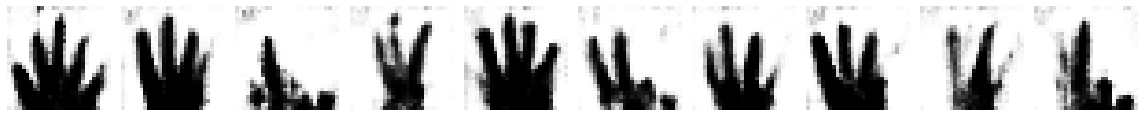

 70%|███████   | 2100/3000 [05:36<04:18,  3.48it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2101/3000 [05:37<03:46,  3.97it/s]

>2101, dr[0.597,0.020], df[0.397,0.044], g[2.195,0.043]
1/1 [==============================] - 0s 15ms/step


 70%|███████   | 2102/3000 [05:37<03:20,  4.47it/s]

>2102, dr[0.631,0.008], df[0.431,0.007], g[2.155,0.143]
1/1 [==============================] - 0s 21ms/step


 70%|███████   | 2103/3000 [05:37<03:03,  4.88it/s]

>2103, dr[0.421,0.002], df[0.618,0.183], g[2.173,0.077]
1/1 [==============================] - 0s 22ms/step


 70%|███████   | 2104/3000 [05:37<02:54,  5.13it/s]

>2104, dr[0.234,0.023], df[0.149,0.038], g[2.535,0.013]
1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2105/3000 [05:37<02:44,  5.43it/s]

>2105, dr[0.217,0.006], df[0.378,0.021], g[2.180,0.020]
1/1 [==============================] - 0s 20ms/step


 70%|███████   | 2106/3000 [05:37<02:37,  5.67it/s]

>2106, dr[0.423,0.022], df[0.583,0.032], g[2.629,0.023]
1/1 [==============================] - 0s 18ms/step


 70%|███████   | 2107/3000 [05:38<02:32,  5.86it/s]

>2107, dr[0.503,0.109], df[0.292,0.045], g[2.022,0.032]
1/1 [==============================] - 0s 25ms/step


 70%|███████   | 2108/3000 [05:38<02:35,  5.74it/s]

>2108, dr[0.225,0.009], df[0.412,0.034], g[2.405,0.078]
1/1 [==============================] - 0s 23ms/step


 70%|███████   | 2109/3000 [05:38<02:31,  5.87it/s]

>2109, dr[0.366,0.006], df[0.501,0.105], g[2.496,0.066]
1/1 [==============================] - 0s 16ms/step


 70%|███████   | 2110/3000 [05:38<02:30,  5.92it/s]

>2110, dr[0.487,0.004], df[0.205,0.098], g[2.655,0.022]
1/1 [==============================] - 0s 17ms/step


 70%|███████   | 2111/3000 [05:38<02:27,  6.01it/s]

>2111, dr[0.300,0.015], df[0.395,0.110], g[2.158,0.015]
1/1 [==============================] - 0s 21ms/step


 70%|███████   | 2112/3000 [05:38<02:25,  6.09it/s]

>2112, dr[0.560,0.006], df[0.394,0.053], g[2.085,0.029]
1/1 [==============================] - 0s 24ms/step


 70%|███████   | 2113/3000 [05:39<02:26,  6.07it/s]

>2113, dr[0.360,0.022], df[0.438,0.154], g[2.927,0.103]
1/1 [==============================] - 0s 19ms/step


 70%|███████   | 2114/3000 [05:39<02:27,  6.00it/s]

>2114, dr[0.297,0.015], df[0.337,0.086], g[2.264,0.059]
1/1 [==============================] - 0s 26ms/step


 70%|███████   | 2115/3000 [05:39<02:29,  5.92it/s]

>2115, dr[0.275,0.007], df[0.237,0.016], g[2.447,0.038]
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2116/3000 [05:39<02:27,  5.99it/s]

>2116, dr[0.460,0.013], df[0.299,0.068], g[1.802,0.007]
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2117/3000 [05:39<02:25,  6.09it/s]

>2117, dr[0.249,0.021], df[0.518,0.037], g[2.177,0.038]
1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2118/3000 [05:39<02:26,  6.02it/s]

>2118, dr[0.283,0.040], df[0.362,0.052], g[2.434,0.027]
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2119/3000 [05:40<02:26,  6.03it/s]

>2119, dr[0.398,0.005], df[0.389,0.010], g[2.608,0.011]
1/1 [==============================] - 0s 15ms/step


 71%|███████   | 2120/3000 [05:40<02:28,  5.94it/s]

>2120, dr[0.456,0.015], df[0.248,0.015], g[2.032,0.048]
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2121/3000 [05:40<02:26,  5.99it/s]

>2121, dr[0.359,0.017], df[0.424,0.014], g[1.851,0.032]
1/1 [==============================] - 0s 17ms/step


 71%|███████   | 2122/3000 [05:40<02:28,  5.92it/s]

>2122, dr[0.522,0.012], df[0.411,0.157], g[1.920,0.043]
1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2123/3000 [05:40<02:31,  5.81it/s]

>2123, dr[0.184,0.017], df[0.153,0.040], g[1.931,0.043]
1/1 [==============================] - 0s 22ms/step


 71%|███████   | 2124/3000 [05:40<02:28,  5.89it/s]

>2124, dr[0.304,0.009], df[0.360,0.042], g[1.846,0.031]
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 2125/3000 [05:41<02:28,  5.90it/s]

>2125, dr[0.306,0.011], df[0.365,0.030], g[2.379,0.061]
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2126/3000 [05:41<02:29,  5.84it/s]

>2126, dr[0.275,0.024], df[0.334,0.103], g[2.353,0.006]
1/1 [==============================] - 0s 21ms/step


 71%|███████   | 2127/3000 [05:41<02:25,  6.02it/s]

>2127, dr[0.394,0.011], df[0.366,0.070], g[2.005,0.067]
1/1 [==============================] - 0s 25ms/step


 71%|███████   | 2128/3000 [05:41<02:22,  6.11it/s]

>2128, dr[0.386,0.006], df[0.470,0.036], g[2.176,0.025]
1/1 [==============================] - 0s 20ms/step


 71%|███████   | 2129/3000 [05:41<02:21,  6.15it/s]

>2129, dr[0.379,0.007], df[0.267,0.012], g[1.707,0.029]
1/1 [==============================] - 0s 15ms/step


 71%|███████   | 2130/3000 [05:41<02:22,  6.10it/s]

>2130, dr[0.332,0.014], df[0.352,0.018], g[2.333,0.055]
1/1 [==============================] - 0s 14ms/step


 71%|███████   | 2131/3000 [05:42<02:21,  6.14it/s]

>2131, dr[0.238,0.015], df[0.415,0.022], g[2.323,0.019]
1/1 [==============================] - 0s 14ms/step


 71%|███████   | 2132/3000 [05:42<02:23,  6.03it/s]

>2132, dr[0.355,0.021], df[0.365,0.039], g[2.549,0.086]
1/1 [==============================] - 0s 24ms/step


 71%|███████   | 2133/3000 [05:42<02:28,  5.83it/s]

>2133, dr[0.280,0.006], df[0.178,0.102], g[2.377,0.018]
1/1 [==============================] - 0s 18ms/step


 71%|███████   | 2134/3000 [05:42<02:29,  5.81it/s]

>2134, dr[0.399,0.075], df[0.553,0.017], g[1.965,0.021]
1/1 [==============================] - 0s 16ms/step


 71%|███████   | 2135/3000 [05:42<02:30,  5.73it/s]

>2135, dr[0.303,0.004], df[0.414,0.090], g[2.137,0.046]
1/1 [==============================] - 0s 14ms/step


 71%|███████   | 2136/3000 [05:42<02:27,  5.84it/s]

>2136, dr[0.408,0.013], df[0.249,0.013], g[2.204,0.041]
1/1 [==============================] - 0s 19ms/step


 71%|███████   | 2137/3000 [05:43<02:28,  5.81it/s]

>2137, dr[0.338,0.013], df[0.512,0.014], g[2.198,0.018]
1/1 [==============================] - 0s 15ms/step


 71%|███████▏  | 2138/3000 [05:43<02:23,  6.00it/s]

>2138, dr[0.415,0.007], df[0.428,0.018], g[2.365,0.037]
1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 2139/3000 [05:43<02:29,  5.75it/s]

>2139, dr[0.436,0.032], df[0.269,0.048], g[1.860,0.052]
1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 2140/3000 [05:43<02:32,  5.62it/s]

>2140, dr[0.455,0.018], df[0.642,0.009], g[1.831,0.031]
1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 2141/3000 [05:43<02:28,  5.77it/s]

>2141, dr[0.204,0.006], df[0.458,0.188], g[2.287,0.023]
1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 2142/3000 [05:43<02:25,  5.89it/s]

>2142, dr[0.630,0.077], df[0.480,0.007], g[2.434,0.033]
1/1 [==============================] - 0s 14ms/step


 71%|███████▏  | 2143/3000 [05:44<02:23,  5.99it/s]

>2143, dr[0.583,0.011], df[0.360,0.055], g[1.958,0.026]
1/1 [==============================] - 0s 21ms/step


 71%|███████▏  | 2144/3000 [05:44<02:21,  6.05it/s]

>2144, dr[0.270,0.008], df[0.476,0.089], g[2.130,0.018]
1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 2145/3000 [05:44<02:25,  5.89it/s]

>2145, dr[0.345,0.008], df[0.146,0.100], g[1.740,0.042]
1/1 [==============================] - 0s 14ms/step


 72%|███████▏  | 2146/3000 [05:44<02:24,  5.90it/s]

>2146, dr[0.270,0.059], df[0.511,0.009], g[1.748,0.033]
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2147/3000 [05:44<02:25,  5.85it/s]

>2147, dr[0.239,0.021], df[0.332,0.020], g[2.206,0.070]
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2148/3000 [05:44<02:26,  5.81it/s]

>2148, dr[0.467,0.010], df[0.355,0.045], g[1.906,0.029]
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2149/3000 [05:45<02:26,  5.79it/s]

>2149, dr[0.235,0.070], df[0.335,0.147], g[1.860,0.097]
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2150/3000 [05:45<02:24,  5.87it/s]

>2150, dr[0.381,0.020], df[0.184,0.060], g[1.854,0.069]
1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2151/3000 [05:45<02:25,  5.82it/s]

>2151, dr[0.401,0.053], df[0.453,0.210], g[1.518,0.109]
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2152/3000 [05:45<02:23,  5.91it/s]

>2152, dr[0.356,0.004], df[0.502,0.092], g[1.903,0.006]
1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2153/3000 [05:45<02:24,  5.88it/s]

>2153, dr[0.338,0.003], df[0.421,0.049], g[1.923,0.064]
1/1 [==============================] - 0s 15ms/step


 72%|███████▏  | 2154/3000 [05:46<02:25,  5.82it/s]

>2154, dr[0.271,0.115], df[0.273,0.081], g[2.059,0.066]
1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 2155/3000 [05:46<02:27,  5.73it/s]

>2155, dr[0.360,0.007], df[0.279,0.041], g[2.004,0.033]
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2156/3000 [05:46<02:28,  5.69it/s]

>2156, dr[0.361,0.014], df[0.320,0.060], g[1.769,0.024]
1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 2157/3000 [05:46<02:27,  5.72it/s]

>2157, dr[0.290,0.013], df[0.598,0.088], g[2.179,0.134]
1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 2158/3000 [05:46<02:28,  5.67it/s]

>2158, dr[0.480,0.008], df[0.290,0.083], g[2.328,0.044]
1/1 [==============================] - 0s 14ms/step


 72%|███████▏  | 2159/3000 [05:46<02:25,  5.79it/s]

>2159, dr[0.268,0.025], df[0.425,0.029], g[2.048,0.054]
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2160/3000 [05:47<02:20,  5.97it/s]

>2160, dr[0.399,0.168], df[0.366,0.055], g[2.252,0.026]
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2161/3000 [05:47<02:21,  5.94it/s]

>2161, dr[0.407,0.059], df[0.524,0.081], g[2.461,0.020]
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2162/3000 [05:47<02:23,  5.84it/s]

>2162, dr[0.385,0.012], df[0.259,0.036], g[2.360,0.022]
1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 2163/3000 [05:47<02:26,  5.72it/s]

>2163, dr[0.252,0.030], df[0.346,0.006], g[2.085,0.010]
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2164/3000 [05:47<02:23,  5.81it/s]

>2164, dr[0.300,0.030], df[0.262,0.019], g[2.544,0.036]
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 2165/3000 [05:47<02:24,  5.77it/s]

>2165, dr[0.434,0.007], df[0.425,0.031], g[2.047,0.059]
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2166/3000 [05:48<02:23,  5.83it/s]

>2166, dr[0.361,0.008], df[0.382,0.068], g[2.107,0.069]
1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 2167/3000 [05:48<02:20,  5.93it/s]

>2167, dr[0.459,0.017], df[0.456,0.028], g[2.078,0.112]
1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 2168/3000 [05:48<02:17,  6.04it/s]

>2168, dr[0.428,0.015], df[0.523,0.006], g[1.883,0.054]
1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 2169/3000 [05:48<02:21,  5.88it/s]

>2169, dr[0.221,0.013], df[0.349,0.030], g[2.415,0.072]
1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 2170/3000 [05:48<02:17,  6.02it/s]

>2170, dr[0.403,0.012], df[0.241,0.016], g[2.308,0.008]
1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 2171/3000 [05:48<02:18,  6.01it/s]

>2171, dr[0.415,0.014], df[0.288,0.047], g[1.839,0.055]
1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 2172/3000 [05:49<02:17,  6.01it/s]

>2172, dr[0.232,0.009], df[0.374,0.012], g[1.956,0.038]
1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 2173/3000 [05:49<02:20,  5.90it/s]

>2173, dr[0.253,0.020], df[0.461,0.063], g[2.357,0.015]
1/1 [==============================] - 0s 14ms/step


 72%|███████▏  | 2174/3000 [05:49<02:17,  5.99it/s]

>2174, dr[0.325,0.017], df[0.295,0.016], g[2.484,0.049]
1/1 [==============================] - 0s 14ms/step


 72%|███████▎  | 2175/3000 [05:49<02:20,  5.87it/s]

>2175, dr[0.422,0.012], df[0.367,0.108], g[2.377,0.092]
1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2176/3000 [05:49<02:18,  5.96it/s]

>2176, dr[0.349,0.005], df[0.362,0.056], g[2.012,0.021]
1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 2177/3000 [05:49<02:20,  5.85it/s]

>2177, dr[0.293,0.019], df[0.318,0.260], g[2.163,0.035]
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2178/3000 [05:50<02:19,  5.90it/s]

>2178, dr[0.371,0.018], df[0.357,0.025], g[2.523,0.066]
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2179/3000 [05:50<02:18,  5.93it/s]

>2179, dr[0.343,0.028], df[0.278,0.213], g[2.059,0.046]
1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2180/3000 [05:50<02:16,  6.00it/s]

>2180, dr[0.202,0.003], df[0.406,0.062], g[2.847,0.011]
1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2181/3000 [05:50<02:18,  5.92it/s]

>2181, dr[0.337,0.008], df[0.411,0.097], g[2.613,0.114]
1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2182/3000 [05:50<02:18,  5.92it/s]

>2182, dr[0.740,0.016], df[0.216,0.006], g[1.757,0.021]
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2183/3000 [05:50<02:17,  5.95it/s]

>2183, dr[0.298,0.046], df[0.407,0.079], g[1.946,0.054]
1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 2184/3000 [05:51<02:15,  6.02it/s]

>2184, dr[0.277,0.017], df[0.613,0.052], g[2.085,0.044]
1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2185/3000 [05:51<02:17,  5.93it/s]

>2185, dr[0.599,0.021], df[0.345,0.196], g[1.687,0.054]
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2186/3000 [05:51<02:14,  6.06it/s]

>2186, dr[0.281,0.010], df[0.295,0.011], g[1.919,0.047]
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2187/3000 [05:51<02:16,  5.98it/s]

>2187, dr[0.367,0.011], df[0.531,0.066], g[2.092,0.082]
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2188/3000 [05:51<02:14,  6.06it/s]

>2188, dr[0.390,0.008], df[0.317,0.016], g[2.192,0.017]
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2189/3000 [05:51<02:18,  5.86it/s]

>2189, dr[0.325,0.007], df[0.462,0.091], g[2.176,0.046]
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2190/3000 [05:52<02:15,  5.96it/s]

>2190, dr[0.414,0.018], df[0.286,0.007], g[2.216,0.042]
1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 2191/3000 [05:52<02:16,  5.95it/s]

>2191, dr[0.280,0.008], df[0.278,0.055], g[2.082,0.077]
1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 2192/3000 [05:52<02:14,  6.00it/s]

>2192, dr[0.239,0.053], df[0.486,0.057], g[2.222,0.013]
1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 2193/3000 [05:52<02:16,  5.93it/s]

>2193, dr[0.251,0.025], df[0.245,0.036], g[2.315,0.037]
1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 2194/3000 [05:52<02:14,  5.97it/s]

>2194, dr[0.534,0.012], df[0.321,0.013], g[2.031,0.050]
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2195/3000 [05:52<02:10,  6.17it/s]

>2195, dr[0.263,0.017], df[0.668,0.054], g[2.612,0.048]
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2196/3000 [05:53<02:08,  6.28it/s]

>2196, dr[0.444,0.020], df[0.387,0.013], g[2.354,0.085]
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2197/3000 [05:53<02:10,  6.17it/s]

>2197, dr[0.598,0.013], df[0.359,0.053], g[2.134,0.009]
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2198/3000 [05:53<02:10,  6.13it/s]

>2198, dr[0.197,0.035], df[0.269,0.034], g[1.926,0.114]
1/1 [==============================] - 0s 14ms/step


 73%|███████▎  | 2199/3000 [05:53<02:11,  6.10it/s]

>2199, dr[0.294,0.009], df[0.468,0.115], g[2.010,0.043]
1/1 [==============================] - 0s 15ms/step
>2200, dr[0.234,0.009], df[0.482,0.011], g[2.202,0.016]
1/1 [==============================] - 0s 24ms/step


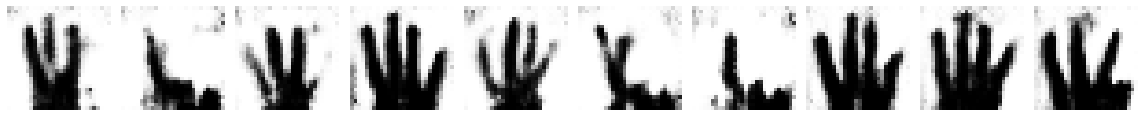

 73%|███████▎  | 2200/3000 [05:54<03:49,  3.48it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2201/3000 [05:54<03:21,  3.97it/s]

>2201, dr[0.553,0.014], df[0.224,0.020], g[2.247,0.050]
1/1 [==============================] - 0s 14ms/step


 73%|███████▎  | 2202/3000 [05:54<02:55,  4.54it/s]

>2202, dr[0.307,0.032], df[0.330,0.017], g[1.988,0.011]
1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 2203/3000 [05:54<02:44,  4.85it/s]

>2203, dr[0.347,0.013], df[0.407,0.018], g[1.987,0.109]
1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 2204/3000 [05:54<02:36,  5.10it/s]

>2204, dr[0.231,0.015], df[0.455,0.007], g[2.255,0.140]
1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 2205/3000 [05:54<02:28,  5.36it/s]

>2205, dr[0.597,0.010], df[0.384,0.012], g[2.104,0.013]
1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 2206/3000 [05:55<02:21,  5.63it/s]

>2206, dr[0.308,0.029], df[0.564,0.019], g[2.017,0.051]
1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 2207/3000 [05:55<02:17,  5.77it/s]

>2207, dr[0.368,0.007], df[0.278,0.026], g[1.887,0.024]
1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 2208/3000 [05:55<02:13,  5.94it/s]

>2208, dr[0.398,0.087], df[0.327,0.007], g[2.678,0.076]
1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 2209/3000 [05:55<02:11,  6.02it/s]

>2209, dr[0.289,0.003], df[0.338,0.003], g[2.286,0.051]
1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 2210/3000 [05:55<02:13,  5.93it/s]

>2210, dr[0.281,0.113], df[0.337,0.043], g[2.181,0.113]
1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 2211/3000 [05:55<02:13,  5.91it/s]

>2211, dr[0.384,0.023], df[0.443,0.082], g[1.918,0.021]
1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 2212/3000 [05:56<02:15,  5.82it/s]

>2212, dr[0.413,0.042], df[0.362,0.083], g[2.307,0.039]
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2213/3000 [05:56<02:13,  5.89it/s]

>2213, dr[0.357,0.005], df[0.260,0.003], g[2.049,0.034]
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2214/3000 [05:56<02:11,  6.00it/s]

>2214, dr[0.354,0.006], df[0.236,0.027], g[1.692,0.035]
1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 2215/3000 [05:56<02:09,  6.04it/s]

>2215, dr[0.298,0.007], df[0.311,0.007], g[1.438,0.031]
1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2216/3000 [05:56<02:13,  5.86it/s]

>2216, dr[0.248,0.005], df[0.327,0.210], g[2.006,0.053]
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2217/3000 [05:57<02:17,  5.70it/s]

>2217, dr[0.251,0.020], df[0.886,0.050], g[2.324,0.027]
1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 2218/3000 [05:57<02:15,  5.78it/s]

>2218, dr[0.281,0.012], df[0.344,0.089], g[2.389,0.010]
1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 2219/3000 [05:57<02:15,  5.78it/s]

>2219, dr[0.505,0.030], df[0.173,0.020], g[2.168,0.014]
1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 2220/3000 [05:57<02:17,  5.68it/s]

>2220, dr[0.413,0.037], df[0.264,0.072], g[1.870,0.049]
1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 2221/3000 [05:57<02:15,  5.76it/s]

>2221, dr[0.326,0.041], df[0.408,0.012], g[1.946,0.049]
1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 2222/3000 [05:57<02:15,  5.74it/s]

>2222, dr[0.382,0.008], df[0.522,0.021], g[1.754,0.046]
1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 2223/3000 [05:58<02:14,  5.78it/s]

>2223, dr[0.488,0.032], df[0.323,0.048], g[1.972,0.035]
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2224/3000 [05:58<02:13,  5.79it/s]

>2224, dr[0.301,0.010], df[0.312,0.075], g[2.038,0.027]
1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 2225/3000 [05:58<02:12,  5.86it/s]

>2225, dr[0.414,0.039], df[0.457,0.015], g[2.026,0.056]
1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 2226/3000 [05:58<02:12,  5.86it/s]

>2226, dr[0.362,0.003], df[0.527,0.033], g[1.805,0.017]
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2227/3000 [05:58<02:11,  5.88it/s]

>2227, dr[0.344,0.029], df[0.470,0.119], g[1.885,0.006]
1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 2228/3000 [05:58<02:13,  5.77it/s]

>2228, dr[0.248,0.008], df[0.451,0.021], g[2.352,0.013]
1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 2229/3000 [05:59<02:08,  6.00it/s]

>2229, dr[0.553,0.031], df[0.434,0.025], g[2.031,0.022]
1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 2230/3000 [05:59<02:06,  6.11it/s]

>2230, dr[0.421,0.018], df[0.384,0.010], g[2.390,0.015]
1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 2231/3000 [05:59<02:12,  5.82it/s]

>2231, dr[0.391,0.015], df[0.359,0.059], g[2.426,0.040]
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2232/3000 [05:59<02:09,  5.95it/s]

>2232, dr[0.480,0.017], df[0.528,0.044], g[2.323,0.021]
1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 2233/3000 [05:59<02:09,  5.90it/s]

>2233, dr[0.413,0.040], df[0.207,0.015], g[1.805,0.053]
1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 2234/3000 [05:59<02:12,  5.79it/s]

>2234, dr[0.392,0.029], df[0.601,0.041], g[2.153,0.082]
1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 2235/3000 [06:00<02:12,  5.78it/s]

>2235, dr[0.371,0.025], df[0.474,0.063], g[2.168,0.038]
1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2236/3000 [06:00<02:09,  5.88it/s]

>2236, dr[0.388,0.009], df[0.356,0.114], g[2.417,0.010]
1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 2237/3000 [06:00<02:07,  5.97it/s]

>2237, dr[0.339,0.024], df[0.348,0.091], g[2.333,0.019]
1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 2238/3000 [06:00<02:08,  5.95it/s]

>2238, dr[0.379,0.004], df[0.210,0.209], g[2.159,0.041]
1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 2239/3000 [06:00<02:05,  6.07it/s]

>2239, dr[0.335,0.007], df[0.382,0.035], g[1.964,0.024]
1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 2240/3000 [06:00<02:07,  5.98it/s]

>2240, dr[0.304,0.080], df[0.358,0.061], g[1.914,0.021]
1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 2241/3000 [06:01<02:05,  6.03it/s]

>2241, dr[0.348,0.066], df[0.496,0.163], g[2.185,0.014]
1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 2242/3000 [06:01<02:04,  6.06it/s]

>2242, dr[0.361,0.006], df[0.332,0.031], g[2.418,0.074]
1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2243/3000 [06:01<02:07,  5.94it/s]

>2243, dr[0.464,0.054], df[0.345,0.020], g[2.016,0.103]
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2244/3000 [06:01<02:08,  5.90it/s]

>2244, dr[0.312,0.005], df[0.485,0.013], g[1.742,0.010]
1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 2245/3000 [06:01<02:07,  5.90it/s]

>2245, dr[0.313,0.017], df[0.407,0.035], g[2.458,0.037]
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2246/3000 [06:01<02:08,  5.86it/s]

>2246, dr[0.329,0.031], df[0.214,0.042], g[1.954,0.049]
1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 2247/3000 [06:02<02:06,  5.95it/s]

>2247, dr[0.451,0.019], df[0.411,0.011], g[1.731,0.111]
1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 2248/3000 [06:02<02:07,  5.89it/s]

>2248, dr[0.162,0.006], df[0.611,0.040], g[1.959,0.006]
1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 2249/3000 [06:02<02:09,  5.81it/s]

>2249, dr[0.444,0.064], df[0.249,0.005], g[2.224,0.023]
1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 2250/3000 [06:02<02:08,  5.85it/s]

>2250, dr[0.539,0.011], df[0.384,0.031], g[1.927,0.007]
1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2251/3000 [06:02<02:06,  5.93it/s]

>2251, dr[0.385,0.013], df[0.769,0.068], g[1.811,0.018]
1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 2252/3000 [06:02<02:07,  5.87it/s]

>2252, dr[0.287,0.024], df[0.329,0.174], g[2.039,0.031]
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2253/3000 [06:03<02:08,  5.79it/s]

>2253, dr[0.337,0.028], df[0.336,0.029], g[2.196,0.049]
1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2254/3000 [06:03<02:10,  5.70it/s]

>2254, dr[0.311,0.009], df[0.316,0.057], g[2.167,0.028]
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2255/3000 [06:03<02:10,  5.73it/s]

>2255, dr[0.352,0.040], df[0.532,0.076], g[2.473,0.038]
1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 2256/3000 [06:03<02:08,  5.81it/s]

>2256, dr[0.469,0.003], df[0.251,0.013], g[2.202,0.092]
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2257/3000 [06:03<02:03,  6.00it/s]

>2257, dr[0.374,0.008], df[0.299,0.028], g[1.787,0.109]
1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 2258/3000 [06:03<02:05,  5.91it/s]

>2258, dr[0.298,0.015], df[0.567,0.035], g[2.349,0.053]
1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 2259/3000 [06:04<02:04,  5.93it/s]

>2259, dr[0.394,0.043], df[0.357,0.011], g[2.116,0.023]
1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 2260/3000 [06:04<02:04,  5.97it/s]

>2260, dr[0.369,0.008], df[0.410,0.010], g[2.030,0.008]
1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2261/3000 [06:04<02:06,  5.83it/s]

>2261, dr[0.347,0.055], df[0.336,0.044], g[2.511,0.013]
1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 2262/3000 [06:04<02:05,  5.89it/s]

>2262, dr[0.541,0.007], df[0.451,0.068], g[2.201,0.035]
1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 2263/3000 [06:04<02:05,  5.85it/s]

>2263, dr[0.472,0.012], df[0.482,0.088], g[2.000,0.039]
1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 2264/3000 [06:04<02:04,  5.91it/s]

>2264, dr[0.273,0.016], df[0.431,0.020], g[1.930,0.031]
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2265/3000 [06:05<02:01,  6.05it/s]

>2265, dr[0.520,0.007], df[0.426,0.031], g[1.885,0.138]
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2266/3000 [06:05<01:59,  6.12it/s]

>2266, dr[0.333,0.003], df[0.381,0.035], g[2.131,0.057]
1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 2267/3000 [06:05<02:00,  6.08it/s]

>2267, dr[0.327,0.008], df[0.317,0.093], g[1.964,0.066]
1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 2268/3000 [06:05<02:02,  5.97it/s]

>2268, dr[0.426,0.003], df[0.566,0.009], g[2.136,0.123]
1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 2269/3000 [06:05<02:07,  5.74it/s]

>2269, dr[0.402,0.004], df[0.531,0.104], g[2.390,0.017]
1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2270/3000 [06:06<02:05,  5.79it/s]

>2270, dr[0.463,0.039], df[0.266,0.020], g[2.250,0.015]
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2271/3000 [06:06<02:03,  5.90it/s]

>2271, dr[0.351,0.009], df[0.213,0.007], g[1.777,0.017]
1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 2272/3000 [06:06<02:04,  5.85it/s]

>2272, dr[0.318,0.024], df[0.305,0.052], g[1.662,0.013]
1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 2273/3000 [06:06<02:03,  5.90it/s]

>2273, dr[0.343,0.015], df[0.527,0.064], g[1.749,0.021]
1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 2274/3000 [06:06<02:02,  5.91it/s]

>2274, dr[0.368,0.067], df[0.545,0.088], g[1.816,0.042]
1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 2275/3000 [06:06<02:04,  5.84it/s]

>2275, dr[0.414,0.006], df[0.255,0.072], g[1.916,0.025]
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2276/3000 [06:07<02:01,  5.96it/s]

>2276, dr[0.313,0.059], df[0.235,0.007], g[1.720,0.024]
1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2277/3000 [06:07<02:03,  5.84it/s]

>2277, dr[0.257,0.014], df[0.340,0.095], g[1.864,0.031]
1/1 [==============================] - 0s 14ms/step


 76%|███████▌  | 2278/3000 [06:07<02:03,  5.84it/s]

>2278, dr[0.299,0.031], df[0.426,0.068], g[2.010,0.036]
1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 2279/3000 [06:07<02:01,  5.95it/s]

>2279, dr[0.467,0.070], df[0.279,0.045], g[2.093,0.062]
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2280/3000 [06:07<01:59,  6.02it/s]

>2280, dr[0.271,0.004], df[0.314,0.096], g[1.880,0.015]
1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2281/3000 [06:07<02:02,  5.86it/s]

>2281, dr[0.256,0.012], df[0.555,0.021], g[1.745,0.054]
1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 2282/3000 [06:08<01:58,  6.04it/s]

>2282, dr[0.341,0.002], df[0.226,0.070], g[2.318,0.032]
1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 2283/3000 [06:08<02:02,  5.85it/s]

>2283, dr[0.364,0.005], df[0.349,0.011], g[1.856,0.025]
1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 2284/3000 [06:08<02:02,  5.86it/s]

>2284, dr[0.537,0.007], df[0.325,0.014], g[1.972,0.035]
1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 2285/3000 [06:08<02:02,  5.83it/s]

>2285, dr[0.228,0.010], df[0.472,0.074], g[2.034,0.066]
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2286/3000 [06:08<02:02,  5.83it/s]

>2286, dr[0.517,0.006], df[0.407,0.115], g[2.411,0.031]
1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 2287/3000 [06:08<02:00,  5.90it/s]

>2287, dr[0.348,0.032], df[0.422,0.009], g[2.506,0.036]
1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 2288/3000 [06:09<02:00,  5.93it/s]

>2288, dr[0.268,0.023], df[0.223,0.028], g[2.002,0.122]
1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 2289/3000 [06:09<02:00,  5.88it/s]

>2289, dr[0.339,0.014], df[0.323,0.027], g[2.087,0.022]
1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 2290/3000 [06:09<02:01,  5.82it/s]

>2290, dr[0.458,0.002], df[0.357,0.035], g[1.587,0.056]
1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 2291/3000 [06:09<02:01,  5.83it/s]

>2291, dr[0.305,0.016], df[0.472,0.010], g[1.467,0.140]
1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 2292/3000 [06:09<02:01,  5.82it/s]

>2292, dr[0.286,0.020], df[0.522,0.042], g[2.221,0.091]
1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 2293/3000 [06:09<02:01,  5.83it/s]

>2293, dr[0.299,0.013], df[0.363,0.118], g[2.620,0.020]
1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 2294/3000 [06:10<01:59,  5.90it/s]

>2294, dr[0.306,0.017], df[0.416,0.016], g[2.620,0.039]
1/1 [==============================] - 0s 18ms/step


 76%|███████▋  | 2295/3000 [06:10<02:02,  5.77it/s]

>2295, dr[0.492,0.011], df[0.149,0.026], g[2.106,0.043]
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2296/3000 [06:10<01:58,  5.94it/s]

>2296, dr[0.253,0.004], df[0.396,0.088], g[2.021,0.032]
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2297/3000 [06:10<01:56,  6.02it/s]

>2297, dr[0.256,0.017], df[0.499,0.038], g[2.063,0.012]
1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2298/3000 [06:10<01:55,  6.08it/s]

>2298, dr[0.430,0.040], df[0.434,0.024], g[1.899,0.026]
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2299/3000 [06:10<01:55,  6.07it/s]

>2299, dr[0.408,0.007], df[0.400,0.030], g[2.120,0.080]
1/1 [==============================] - 0s 21ms/step
>2300, dr[0.363,0.003], df[0.347,0.047], g[1.999,0.049]
1/1 [==============================] - 0s 23ms/step


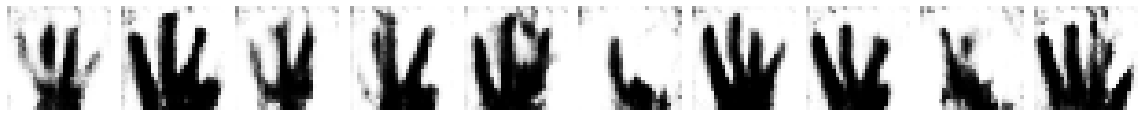

 77%|███████▋  | 2300/3000 [06:11<03:24,  3.43it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 2301/3000 [06:11<02:59,  3.90it/s]

>2301, dr[0.333,0.024], df[0.693,0.005], g[2.281,0.031]
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2302/3000 [06:11<02:39,  4.37it/s]

>2302, dr[0.502,0.010], df[0.368,0.022], g[2.078,0.071]
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2303/3000 [06:11<02:26,  4.76it/s]

>2303, dr[0.425,0.014], df[0.371,0.028], g[2.012,0.054]
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2304/3000 [06:12<02:14,  5.18it/s]

>2304, dr[0.468,0.004], df[0.403,0.027], g[2.328,0.023]
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2305/3000 [06:12<02:07,  5.46it/s]

>2305, dr[0.213,0.008], df[0.473,0.216], g[2.341,0.024]
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2306/3000 [06:12<02:01,  5.70it/s]

>2306, dr[0.331,0.018], df[0.277,0.008], g[2.420,0.013]
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2307/3000 [06:12<01:57,  5.89it/s]

>2307, dr[0.472,0.003], df[0.379,0.010], g[1.876,0.048]
1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 2308/3000 [06:12<01:57,  5.91it/s]

>2308, dr[0.455,0.012], df[0.286,0.028], g[1.855,0.125]
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2309/3000 [06:12<01:56,  5.91it/s]

>2309, dr[0.352,0.021], df[0.434,0.087], g[2.417,0.027]
1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 2310/3000 [06:13<01:56,  5.93it/s]

>2310, dr[0.331,0.008], df[0.294,0.010], g[2.128,0.102]
1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 2311/3000 [06:13<01:56,  5.92it/s]

>2311, dr[0.325,0.017], df[0.280,0.038], g[1.965,0.039]
1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2312/3000 [06:13<01:54,  6.00it/s]

>2312, dr[0.333,0.037], df[0.426,0.009], g[2.229,0.018]
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2313/3000 [06:13<01:53,  6.08it/s]

>2313, dr[0.485,0.005], df[0.308,0.021], g[1.820,0.023]
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2314/3000 [06:13<01:51,  6.15it/s]

>2314, dr[0.355,0.012], df[0.489,0.019], g[2.184,0.089]
1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 2315/3000 [06:13<01:50,  6.19it/s]

>2315, dr[0.346,0.014], df[0.289,0.009], g[1.875,0.048]
1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 2316/3000 [06:14<01:54,  5.98it/s]

>2316, dr[0.387,0.014], df[0.394,0.047], g[2.137,0.021]
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2317/3000 [06:14<01:56,  5.86it/s]

>2317, dr[0.365,0.026], df[0.422,0.126], g[1.700,0.032]
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2318/3000 [06:14<01:55,  5.91it/s]

>2318, dr[0.208,0.020], df[0.535,0.016], g[2.703,0.042]
1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 2319/3000 [06:14<01:57,  5.80it/s]

>2319, dr[0.498,0.009], df[0.303,0.050], g[2.000,0.011]
1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 2320/3000 [06:14<01:57,  5.80it/s]

>2320, dr[0.330,0.045], df[0.223,0.051], g[2.090,0.015]
1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 2321/3000 [06:14<01:56,  5.84it/s]

>2321, dr[0.519,0.056], df[0.752,0.042], g[1.840,0.015]
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2322/3000 [06:15<01:57,  5.78it/s]

>2322, dr[0.361,0.010], df[0.358,0.007], g[2.123,0.068]
1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 2323/3000 [06:15<01:55,  5.88it/s]

>2323, dr[0.249,0.022], df[0.366,0.049], g[2.660,0.055]
1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 2324/3000 [06:15<01:57,  5.75it/s]

>2324, dr[0.371,0.110], df[0.291,0.118], g[2.294,0.052]
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2325/3000 [06:15<01:54,  5.89it/s]

>2325, dr[0.532,0.014], df[0.334,0.154], g[2.369,0.042]
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2326/3000 [06:15<01:53,  5.92it/s]

>2326, dr[0.316,0.008], df[0.323,0.027], g[2.019,0.024]
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2327/3000 [06:16<01:54,  5.89it/s]

>2327, dr[0.173,0.056], df[0.452,0.028], g[1.844,0.071]
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2328/3000 [06:16<01:56,  5.78it/s]

>2328, dr[0.249,0.059], df[0.326,0.022], g[2.289,0.106]
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2329/3000 [06:16<01:54,  5.85it/s]

>2329, dr[0.517,0.015], df[0.352,0.104], g[2.194,0.014]
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2330/3000 [06:16<01:51,  6.03it/s]

>2330, dr[0.381,0.013], df[0.532,0.003], g[2.523,0.030]
1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 2331/3000 [06:16<01:49,  6.13it/s]

>2331, dr[0.475,0.006], df[0.382,0.014], g[2.477,0.012]
1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 2332/3000 [06:16<01:53,  5.89it/s]

>2332, dr[0.453,0.016], df[0.365,0.035], g[1.754,0.039]
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2333/3000 [06:17<01:50,  6.02it/s]

>2333, dr[0.227,0.013], df[0.520,0.119], g[1.993,0.011]
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2334/3000 [06:17<01:51,  5.99it/s]

>2334, dr[0.321,0.002], df[0.177,0.008], g[1.955,0.053]
1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 2335/3000 [06:17<01:52,  5.92it/s]

>2335, dr[0.301,0.011], df[0.507,0.025], g[1.941,0.042]
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2336/3000 [06:17<01:53,  5.84it/s]

>2336, dr[0.314,0.030], df[0.225,0.017], g[1.925,0.051]
1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2337/3000 [06:17<01:51,  5.94it/s]

>2337, dr[0.353,0.007], df[0.384,0.011], g[2.092,0.025]
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2338/3000 [06:17<01:48,  6.09it/s]

>2338, dr[0.333,0.015], df[0.411,0.040], g[2.047,0.128]
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2339/3000 [06:18<01:50,  6.01it/s]

>2339, dr[0.265,0.008], df[0.428,0.009], g[2.366,0.065]
1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2340/3000 [06:18<01:50,  5.97it/s]

>2340, dr[0.638,0.005], df[0.279,0.067], g[2.167,0.095]
1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 2341/3000 [06:18<01:51,  5.93it/s]

>2341, dr[0.306,0.019], df[0.403,0.028], g[1.747,0.018]
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2342/3000 [06:18<01:51,  5.88it/s]

>2342, dr[0.190,0.024], df[0.268,0.037], g[2.222,0.018]
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2343/3000 [06:18<01:49,  5.99it/s]

>2343, dr[0.299,0.041], df[0.342,0.078], g[2.068,0.077]
1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 2344/3000 [06:18<01:48,  6.03it/s]

>2344, dr[0.525,0.005], df[0.271,0.016], g[1.628,0.091]
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2345/3000 [06:19<01:48,  6.05it/s]

>2345, dr[0.440,0.024], df[0.599,0.052], g[1.758,0.068]
1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 2346/3000 [06:19<01:49,  5.97it/s]

>2346, dr[0.231,0.068], df[0.412,0.042], g[1.877,0.054]
1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 2347/3000 [06:19<01:50,  5.90it/s]

>2347, dr[0.454,0.012], df[0.365,0.032], g[2.066,0.029]
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2348/3000 [06:19<01:51,  5.85it/s]

>2348, dr[0.469,0.025], df[0.378,0.155], g[1.538,0.164]
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2349/3000 [06:19<01:47,  6.06it/s]

>2349, dr[0.306,0.006], df[0.617,0.077], g[2.144,0.151]
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2350/3000 [06:19<01:45,  6.15it/s]

>2350, dr[0.303,0.006], df[0.390,0.013], g[2.345,0.065]
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2351/3000 [06:20<01:44,  6.18it/s]

>2351, dr[0.396,0.005], df[0.292,0.247], g[2.122,0.047]
1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 2352/3000 [06:20<01:47,  6.00it/s]

>2352, dr[0.401,0.025], df[0.488,0.039], g[2.218,0.039]
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2353/3000 [06:20<01:44,  6.20it/s]

>2353, dr[0.442,0.017], df[0.336,0.009], g[1.835,0.015]
1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 2354/3000 [06:20<01:44,  6.18it/s]

>2354, dr[0.293,0.005], df[0.427,0.057], g[2.240,0.033]
1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 2355/3000 [06:20<01:45,  6.09it/s]

>2355, dr[0.374,0.009], df[0.457,0.038], g[2.217,0.146]
1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 2356/3000 [06:20<01:45,  6.09it/s]

>2356, dr[0.501,0.010], df[0.232,0.015], g[2.055,0.013]
1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 2357/3000 [06:20<01:46,  6.05it/s]

>2357, dr[0.376,0.024], df[0.418,0.009], g[1.918,0.013]
1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 2358/3000 [06:21<01:44,  6.12it/s]

>2358, dr[0.282,0.007], df[0.524,0.022], g[2.030,0.031]
1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 2359/3000 [06:21<01:47,  5.98it/s]

>2359, dr[0.287,0.010], df[0.324,0.015], g[2.414,0.034]
1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 2360/3000 [06:21<01:47,  5.96it/s]

>2360, dr[0.392,0.005], df[0.249,0.008], g[2.037,0.041]
1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 2361/3000 [06:21<01:46,  5.98it/s]

>2361, dr[0.621,0.064], df[0.415,0.069], g[1.738,0.055]
1/1 [==============================] - 0s 13ms/step


 79%|███████▊  | 2362/3000 [06:21<01:49,  5.83it/s]

>2362, dr[0.261,0.023], df[0.462,0.063], g[2.066,0.037]
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2363/3000 [06:22<01:48,  5.85it/s]

>2363, dr[0.466,0.018], df[0.553,0.022], g[2.077,0.070]
1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2364/3000 [06:22<01:46,  5.95it/s]

>2364, dr[0.193,0.042], df[0.268,0.103], g[2.191,0.032]
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2365/3000 [06:22<01:49,  5.79it/s]

>2365, dr[0.397,0.019], df[0.495,0.020], g[2.141,0.080]
1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 2366/3000 [06:22<01:48,  5.83it/s]

>2366, dr[0.460,0.012], df[0.326,0.050], g[2.143,0.043]
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2367/3000 [06:22<01:46,  5.93it/s]

>2367, dr[0.329,0.019], df[0.384,0.035], g[1.926,0.015]
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2368/3000 [06:22<01:46,  5.93it/s]

>2368, dr[0.274,0.013], df[0.315,0.008], g[2.607,0.021]
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2369/3000 [06:23<01:46,  5.92it/s]

>2369, dr[0.413,0.014], df[0.399,0.012], g[2.064,0.018]
1/1 [==============================] - 0s 17ms/step
>2370, dr[0.181,0.023], df[0.480,0.023], g[2.605,0.083]


 79%|███████▉  | 2370/3000 [06:23<01:52,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 2371/3000 [06:23<01:48,  5.78it/s]

>2371, dr[0.511,0.018], df[0.232,0.046], g[1.528,0.026]
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2372/3000 [06:23<01:47,  5.84it/s]

>2372, dr[0.369,0.006], df[0.290,0.007], g[2.258,0.020]
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2373/3000 [06:23<01:43,  6.03it/s]

>2373, dr[0.426,0.006], df[0.471,0.132], g[1.935,0.019]
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2374/3000 [06:23<01:44,  5.99it/s]

>2374, dr[0.279,0.004], df[0.429,0.057], g[2.192,0.019]
1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2375/3000 [06:24<01:43,  6.03it/s]

>2375, dr[0.299,0.010], df[0.206,0.013], g[2.273,0.027]
1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2376/3000 [06:24<01:44,  5.96it/s]

>2376, dr[0.467,0.008], df[0.323,0.020], g[2.365,0.059]
1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 2377/3000 [06:24<01:42,  6.06it/s]

>2377, dr[0.266,0.035], df[0.448,0.050], g[2.220,0.027]
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2378/3000 [06:24<01:41,  6.11it/s]

>2378, dr[0.525,0.085], df[0.235,0.042], g[2.029,0.052]
1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 2379/3000 [06:24<01:42,  6.04it/s]

>2379, dr[0.245,0.048], df[0.314,0.082], g[2.241,0.040]
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2380/3000 [06:24<01:43,  6.01it/s]

>2380, dr[0.304,0.029], df[0.271,0.037], g[1.718,0.019]
1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 2381/3000 [06:25<01:42,  6.04it/s]

>2381, dr[0.219,0.014], df[0.528,0.013], g[2.210,0.056]
1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 2382/3000 [06:25<01:42,  6.02it/s]

>2382, dr[0.367,0.009], df[0.289,0.092], g[1.835,0.037]
1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 2383/3000 [06:25<01:42,  6.04it/s]

>2383, dr[0.353,0.021], df[0.412,0.042], g[2.028,0.041]
1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 2384/3000 [06:25<01:40,  6.13it/s]

>2384, dr[0.220,0.008], df[0.325,0.010], g[2.295,0.033]
1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 2385/3000 [06:25<01:41,  6.05it/s]

>2385, dr[0.527,0.043], df[0.163,0.015], g[1.513,0.031]
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2386/3000 [06:25<01:39,  6.18it/s]

>2386, dr[0.296,0.026], df[0.675,0.020], g[1.736,0.094]
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2387/3000 [06:26<01:40,  6.12it/s]

>2387, dr[0.296,0.014], df[0.474,0.035], g[2.345,0.059]
1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 2388/3000 [06:26<01:38,  6.22it/s]

>2388, dr[0.394,0.014], df[0.332,0.017], g[2.240,0.029]
1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2389/3000 [06:26<01:41,  6.03it/s]

>2389, dr[0.311,0.007], df[0.362,0.044], g[2.532,0.028]
1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2390/3000 [06:26<01:49,  5.56it/s]

>2390, dr[0.339,0.019], df[0.269,0.017], g[2.222,0.101]
1/1 [==============================] - 0s 14ms/step


 80%|███████▉  | 2391/3000 [06:26<01:46,  5.75it/s]

>2391, dr[0.411,0.011], df[0.277,0.026], g[1.801,0.082]
1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 2392/3000 [06:26<01:44,  5.82it/s]

>2392, dr[0.292,0.005], df[0.424,0.052], g[1.985,0.132]
1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 2393/3000 [06:27<01:42,  5.92it/s]

>2393, dr[0.496,0.003], df[0.161,0.006], g[1.689,0.026]
1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 2394/3000 [06:27<01:42,  5.89it/s]

>2394, dr[0.157,0.012], df[0.481,0.170], g[2.104,0.009]
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2395/3000 [06:27<01:41,  5.96it/s]

>2395, dr[0.371,0.013], df[0.308,0.018], g[2.053,0.058]
1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 2396/3000 [06:27<01:40,  5.99it/s]

>2396, dr[0.492,0.004], df[0.545,0.016], g[2.026,0.204]
1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 2397/3000 [06:27<01:41,  5.91it/s]

>2397, dr[0.481,0.018], df[0.316,0.071], g[1.919,0.047]
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2398/3000 [06:27<01:38,  6.09it/s]

>2398, dr[0.416,0.010], df[0.444,0.003], g[1.400,0.064]
1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 2399/3000 [06:28<01:37,  6.19it/s]

>2399, dr[0.139,0.010], df[0.394,0.019], g[2.283,0.061]
1/1 [==============================] - 0s 23ms/step
>2400, dr[0.405,0.012], df[0.336,0.235], g[2.446,0.047]
1/1 [==============================] - 0s 29ms/step


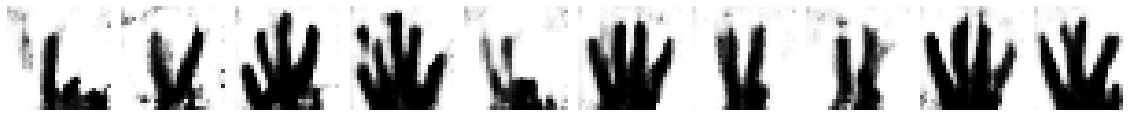

 80%|████████  | 2400/3000 [06:28<02:52,  3.47it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 2401/3000 [06:29<04:11,  2.39it/s]

>2401, dr[0.506,0.013], df[0.425,0.022], g[1.942,0.023]
1/1 [==============================] - 0s 14ms/step


 80%|████████  | 2402/3000 [06:29<03:23,  2.93it/s]

>2402, dr[0.341,0.022], df[0.488,0.009], g[2.156,0.038]
1/1 [==============================] - 0s 22ms/step


 80%|████████  | 2403/3000 [06:29<02:52,  3.45it/s]

>2403, dr[0.261,0.016], df[0.193,0.047], g[2.372,0.010]
1/1 [==============================] - 0s 24ms/step


 80%|████████  | 2404/3000 [06:29<02:32,  3.92it/s]

>2404, dr[0.326,0.009], df[0.274,0.016], g[2.008,0.014]
1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2405/3000 [06:30<02:16,  4.37it/s]

>2405, dr[0.227,0.017], df[0.362,0.005], g[2.035,0.019]
1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2406/3000 [06:30<02:05,  4.75it/s]

>2406, dr[0.372,0.019], df[0.309,0.047], g[2.033,0.010]
1/1 [==============================] - 0s 23ms/step


 80%|████████  | 2407/3000 [06:30<01:56,  5.09it/s]

>2407, dr[0.472,0.044], df[0.357,0.021], g[1.665,0.051]
1/1 [==============================] - 0s 18ms/step


 80%|████████  | 2408/3000 [06:30<01:51,  5.31it/s]

>2408, dr[0.142,0.083], df[0.351,0.023], g[2.076,0.106]
1/1 [==============================] - 0s 21ms/step


 80%|████████  | 2409/3000 [06:30<01:47,  5.49it/s]

>2409, dr[0.455,0.003], df[0.310,0.032], g[2.189,0.020]
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2410/3000 [06:30<01:46,  5.54it/s]

>2410, dr[0.303,0.018], df[0.484,0.070], g[2.170,0.060]
1/1 [==============================] - 0s 28ms/step


 80%|████████  | 2411/3000 [06:31<01:45,  5.59it/s]

>2411, dr[0.235,0.011], df[0.325,0.022], g[2.358,0.091]
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2412/3000 [06:31<01:41,  5.78it/s]

>2412, dr[0.686,0.136], df[0.268,0.022], g[2.340,0.041]
1/1 [==============================] - 0s 20ms/step


 80%|████████  | 2413/3000 [06:31<01:39,  5.92it/s]

>2413, dr[0.317,0.045], df[0.299,0.027], g[1.844,0.109]
1/1 [==============================] - 0s 19ms/step


 80%|████████  | 2414/3000 [06:31<01:39,  5.91it/s]

>2414, dr[0.286,0.011], df[0.532,0.016], g[2.216,0.039]
1/1 [==============================] - 0s 15ms/step


 80%|████████  | 2415/3000 [06:31<01:40,  5.83it/s]

>2415, dr[0.496,0.055], df[0.402,0.043], g[1.698,0.040]
1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2416/3000 [06:31<01:42,  5.68it/s]

>2416, dr[0.181,0.022], df[0.454,0.026], g[2.049,0.076]
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2417/3000 [06:32<01:39,  5.86it/s]

>2417, dr[0.465,0.006], df[0.503,0.036], g[2.187,0.132]
1/1 [==============================] - 0s 22ms/step


 81%|████████  | 2418/3000 [06:32<01:39,  5.86it/s]

>2418, dr[0.421,0.001], df[0.554,0.092], g[2.473,0.011]
1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2419/3000 [06:32<01:39,  5.84it/s]

>2419, dr[0.512,0.017], df[0.222,0.019], g[2.415,0.021]
1/1 [==============================] - 0s 18ms/step


 81%|████████  | 2420/3000 [06:32<01:38,  5.89it/s]

>2420, dr[0.413,0.020], df[0.426,0.014], g[1.755,0.025]
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 2421/3000 [06:32<01:36,  6.01it/s]

>2421, dr[0.218,0.003], df[0.304,0.051], g[1.808,0.027]
1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2422/3000 [06:32<01:37,  5.96it/s]

>2422, dr[0.423,0.007], df[0.500,0.020], g[1.946,0.046]
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2423/3000 [06:33<01:35,  6.06it/s]

>2423, dr[0.419,0.092], df[0.328,0.049], g[1.943,0.053]
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2424/3000 [06:33<01:37,  5.93it/s]

>2424, dr[0.293,0.020], df[0.396,0.011], g[2.052,0.043]
1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2425/3000 [06:33<01:35,  6.02it/s]

>2425, dr[0.378,0.012], df[0.460,0.124], g[2.122,0.034]
1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2426/3000 [06:33<01:35,  6.02it/s]

>2426, dr[0.319,0.032], df[0.260,0.019], g[2.275,0.057]
1/1 [==============================] - 0s 23ms/step


 81%|████████  | 2427/3000 [06:33<01:34,  6.08it/s]

>2427, dr[0.335,0.009], df[0.317,0.023], g[1.639,0.023]
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2428/3000 [06:33<01:32,  6.19it/s]

>2428, dr[0.265,0.011], df[0.415,0.064], g[2.462,0.086]
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 2429/3000 [06:34<01:31,  6.23it/s]

>2429, dr[0.369,0.017], df[0.344,0.055], g[1.940,0.032]
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2430/3000 [06:34<01:31,  6.23it/s]

>2430, dr[0.309,0.006], df[0.353,0.036], g[2.037,0.025]
1/1 [==============================] - 0s 24ms/step


 81%|████████  | 2431/3000 [06:34<01:33,  6.11it/s]

>2431, dr[0.475,0.012], df[0.355,0.006], g[1.911,0.017]
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 2432/3000 [06:34<01:34,  6.03it/s]

>2432, dr[0.288,0.003], df[0.329,0.022], g[1.981,0.064]
1/1 [==============================] - 0s 19ms/step


 81%|████████  | 2433/3000 [06:34<01:32,  6.16it/s]

>2433, dr[0.286,0.010], df[0.394,0.077], g[2.156,0.019]
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 2434/3000 [06:34<01:36,  5.89it/s]

>2434, dr[0.392,0.013], df[0.417,0.012], g[1.906,0.013]
1/1 [==============================] - 0s 25ms/step


 81%|████████  | 2435/3000 [06:35<01:34,  5.96it/s]

>2435, dr[0.420,0.041], df[0.390,0.169], g[2.515,0.020]
1/1 [==============================] - 0s 20ms/step


 81%|████████  | 2436/3000 [06:35<01:31,  6.19it/s]

>2436, dr[0.341,0.003], df[0.334,0.043], g[2.242,0.045]
1/1 [==============================] - 0s 21ms/step


 81%|████████  | 2437/3000 [06:35<01:33,  6.05it/s]

>2437, dr[0.400,0.053], df[0.402,0.039], g[2.043,0.041]
1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 2438/3000 [06:35<01:32,  6.07it/s]

>2438, dr[0.255,0.009], df[0.386,0.062], g[2.131,0.022]
1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 2439/3000 [06:35<01:31,  6.14it/s]

>2439, dr[0.364,0.005], df[0.403,0.060], g[2.094,0.072]
1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 2440/3000 [06:35<01:31,  6.09it/s]

>2440, dr[0.562,0.006], df[0.524,0.023], g[1.849,0.009]
1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 2441/3000 [06:36<01:34,  5.91it/s]

>2441, dr[0.328,0.025], df[0.525,0.045], g[2.336,0.067]
1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 2442/3000 [06:36<01:35,  5.84it/s]

>2442, dr[0.453,0.013], df[0.283,0.097], g[2.302,0.078]
1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 2443/3000 [06:36<01:35,  5.84it/s]

>2443, dr[0.648,0.006], df[0.328,0.025], g[2.164,0.034]
1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 2444/3000 [06:36<01:36,  5.77it/s]

>2444, dr[0.282,0.017], df[0.660,0.017], g[2.231,0.040]
1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 2445/3000 [06:36<01:35,  5.82it/s]

>2445, dr[0.375,0.005], df[0.203,0.019], g[2.523,0.030]
1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2446/3000 [06:36<01:35,  5.81it/s]

>2446, dr[0.564,0.056], df[0.250,0.136], g[1.691,0.021]
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2447/3000 [06:37<01:34,  5.85it/s]

>2447, dr[0.256,0.011], df[0.613,0.024], g[2.019,0.017]
1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2448/3000 [06:37<01:33,  5.89it/s]

>2448, dr[0.394,0.005], df[0.569,0.082], g[2.253,0.041]
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2449/3000 [06:37<01:32,  5.97it/s]

>2449, dr[0.395,0.068], df[0.302,0.026], g[2.068,0.119]
1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2450/3000 [06:37<01:32,  5.93it/s]

>2450, dr[0.325,0.006], df[0.426,0.006], g[2.305,0.116]
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2451/3000 [06:37<01:34,  5.84it/s]

>2451, dr[0.452,0.008], df[0.410,0.008], g[1.761,0.072]
1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 2452/3000 [06:37<01:33,  5.85it/s]

>2452, dr[0.263,0.033], df[0.441,0.045], g[1.917,0.045]
1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 2453/3000 [06:38<01:34,  5.78it/s]

>2453, dr[0.365,0.007], df[0.241,0.010], g[2.096,0.019]
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2454/3000 [06:38<01:31,  5.98it/s]

>2454, dr[0.417,0.013], df[0.819,0.014], g[2.324,0.013]
1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2455/3000 [06:38<01:32,  5.89it/s]

>2455, dr[0.410,0.028], df[0.307,0.028], g[2.464,0.028]
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2456/3000 [06:38<01:32,  5.87it/s]

>2456, dr[0.578,0.041], df[0.536,0.019], g[1.974,0.019]
1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 2457/3000 [06:38<01:30,  6.01it/s]

>2457, dr[0.388,0.010], df[0.362,0.006], g[1.818,0.020]
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2458/3000 [06:38<01:28,  6.13it/s]

>2458, dr[0.331,0.041], df[0.361,0.124], g[2.082,0.022]
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2459/3000 [06:39<01:30,  6.00it/s]

>2459, dr[0.505,0.010], df[0.553,0.087], g[2.152,0.051]
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2460/3000 [06:39<01:29,  6.01it/s]

>2460, dr[0.334,0.032], df[0.465,0.039], g[2.153,0.048]
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2461/3000 [06:39<01:30,  5.98it/s]

>2461, dr[0.433,0.024], df[0.291,0.079], g[2.096,0.037]
1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2462/3000 [06:39<01:32,  5.82it/s]

>2462, dr[0.294,0.047], df[0.270,0.021], g[2.223,0.035]
1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2463/3000 [06:39<01:31,  5.86it/s]

>2463, dr[0.223,0.008], df[0.259,0.102], g[2.142,0.049]
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2464/3000 [06:39<01:31,  5.87it/s]

>2464, dr[0.388,0.043], df[0.350,0.079], g[1.782,0.006]
1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 2465/3000 [06:40<01:29,  5.97it/s]

>2465, dr[0.548,0.011], df[0.399,0.065], g[1.753,0.070]
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2466/3000 [06:40<01:27,  6.08it/s]

>2466, dr[0.325,0.023], df[0.335,0.135], g[1.741,0.022]
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2467/3000 [06:40<01:25,  6.20it/s]

>2467, dr[0.311,0.011], df[0.458,0.065], g[2.098,0.026]
1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 2468/3000 [06:40<01:26,  6.14it/s]

>2468, dr[0.569,0.006], df[0.443,0.023], g[2.160,0.033]
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2469/3000 [06:40<01:26,  6.11it/s]

>2469, dr[0.279,0.017], df[0.288,0.026], g[1.993,0.029]
1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 2470/3000 [06:40<01:26,  6.16it/s]

>2470, dr[0.375,0.012], df[0.332,0.011], g[1.624,0.065]
1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 2471/3000 [06:41<01:28,  6.01it/s]

>2471, dr[0.299,0.007], df[0.693,0.068], g[2.027,0.030]
1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 2472/3000 [06:41<01:29,  5.88it/s]

>2472, dr[0.367,0.011], df[0.263,0.047], g[2.066,0.063]
1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 2473/3000 [06:41<01:27,  6.01it/s]

>2473, dr[0.320,0.016], df[0.257,0.026], g[2.176,0.031]
1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 2474/3000 [06:41<01:25,  6.16it/s]

>2474, dr[0.268,0.014], df[0.367,0.007], g[2.075,0.021]
1/1 [==============================] - 0s 19ms/step


 82%|████████▎ | 2475/3000 [06:41<01:23,  6.31it/s]

>2475, dr[0.476,0.005], df[0.667,0.012], g[2.603,0.042]
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2476/3000 [06:41<01:23,  6.27it/s]

>2476, dr[0.429,0.007], df[0.320,0.025], g[2.469,0.067]
1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2477/3000 [06:42<01:25,  6.11it/s]

>2477, dr[0.418,0.007], df[0.419,0.049], g[1.984,0.028]
1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 2478/3000 [06:42<01:26,  6.03it/s]

>2478, dr[0.439,0.006], df[0.374,0.012], g[1.660,0.031]
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2479/3000 [06:42<01:25,  6.06it/s]

>2479, dr[0.519,0.020], df[0.351,0.006], g[2.184,0.059]
1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2480/3000 [06:42<01:26,  6.04it/s]

>2480, dr[0.197,0.026], df[0.493,0.016], g[2.131,0.016]
1/1 [==============================] - 0s 21ms/step
>2481, dr[0.266,0.014], df[0.187,0.071], g[2.221,0.023]


 83%|████████▎ | 2481/3000 [06:42<01:29,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2482/3000 [06:42<01:28,  5.84it/s]

>2482, dr[0.442,0.004], df[0.239,0.022], g[2.174,0.053]
1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2483/3000 [06:43<01:28,  5.87it/s]

>2483, dr[0.431,0.016], df[0.402,0.023], g[2.317,0.018]
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2484/3000 [06:43<01:27,  5.91it/s]

>2484, dr[0.249,0.006], df[0.435,0.029], g[2.120,0.029]
1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 2485/3000 [06:43<01:27,  5.90it/s]

>2485, dr[0.478,0.018], df[0.347,0.124], g[2.035,0.057]
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2486/3000 [06:43<01:25,  6.04it/s]

>2486, dr[0.414,0.004], df[0.432,0.005], g[2.023,0.043]
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2487/3000 [06:43<01:26,  5.95it/s]

>2487, dr[0.341,0.023], df[0.441,0.022], g[2.299,0.024]
1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2488/3000 [06:43<01:25,  5.97it/s]

>2488, dr[0.422,0.010], df[0.427,0.021], g[2.003,0.027]
1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 2489/3000 [06:44<01:27,  5.87it/s]

>2489, dr[0.480,0.010], df[0.588,0.014], g[2.024,0.044]
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2490/3000 [06:44<01:25,  5.95it/s]

>2490, dr[0.745,0.003], df[0.337,0.022], g[1.795,0.027]
1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 2491/3000 [06:44<01:26,  5.89it/s]

>2491, dr[0.363,0.021], df[0.760,0.045], g[1.955,0.029]
1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 2492/3000 [06:44<01:25,  5.97it/s]

>2492, dr[0.161,0.046], df[0.405,0.127], g[2.406,0.025]
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2493/3000 [06:44<01:23,  6.04it/s]

>2493, dr[0.619,0.016], df[0.338,0.044], g[2.185,0.025]
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2494/3000 [06:44<01:23,  6.06it/s]

>2494, dr[0.431,0.020], df[0.455,0.029], g[2.306,0.060]
1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 2495/3000 [06:45<01:22,  6.13it/s]

>2495, dr[0.308,0.028], df[0.269,0.018], g[2.225,0.076]
1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 2496/3000 [06:45<01:21,  6.16it/s]

>2496, dr[0.461,0.035], df[0.418,0.025], g[1.986,0.010]
1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2497/3000 [06:45<01:21,  6.14it/s]

>2497, dr[0.398,0.024], df[0.448,0.012], g[2.251,0.043]
1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 2498/3000 [06:45<01:21,  6.17it/s]

>2498, dr[0.437,0.025], df[0.413,0.025], g[1.712,0.030]
1/1 [==============================] - 0s 28ms/step
>2499, dr[0.454,0.010], df[0.406,0.012], g[1.984,0.026]


 83%|████████▎ | 2499/3000 [06:45<01:25,  5.88it/s]

1/1 [==============================] - 0s 22ms/step
>2500, dr[0.232,0.090], df[0.400,0.015], g[2.111,0.044]
1/1 [==============================] - 0s 25ms/step


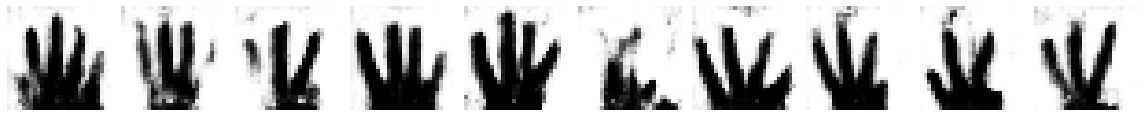

 83%|████████▎ | 2500/3000 [06:46<02:36,  3.19it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 2501/3000 [06:46<02:15,  3.69it/s]

>2501, dr[0.447,0.020], df[0.364,0.051], g[1.993,0.048]
1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 2502/3000 [06:46<01:58,  4.21it/s]

>2502, dr[0.312,0.006], df[0.366,0.098], g[2.192,0.020]
1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 2503/3000 [06:46<01:47,  4.61it/s]

>2503, dr[0.316,0.022], df[0.504,0.061], g[2.611,0.031]
1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 2504/3000 [06:47<01:42,  4.86it/s]

>2504, dr[0.696,0.011], df[0.216,0.007], g[2.050,0.015]
1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2505/3000 [06:47<01:34,  5.21it/s]

>2505, dr[0.235,0.016], df[0.454,0.032], g[1.779,0.023]
1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 2506/3000 [06:47<01:31,  5.37it/s]

>2506, dr[0.282,0.012], df[0.320,0.005], g[2.075,0.087]
1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 2507/3000 [06:47<01:31,  5.37it/s]

>2507, dr[0.376,0.070], df[0.247,0.080], g[2.094,0.014]
1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 2508/3000 [06:47<01:29,  5.51it/s]

>2508, dr[0.411,0.038], df[0.474,0.030], g[1.901,0.033]
1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 2509/3000 [06:47<01:26,  5.69it/s]

>2509, dr[0.324,0.032], df[0.411,0.249], g[2.283,0.010]
1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2510/3000 [06:48<01:25,  5.74it/s]

>2510, dr[0.259,0.014], df[0.315,0.047], g[1.825,0.069]
1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 2511/3000 [06:48<01:26,  5.68it/s]

>2511, dr[0.383,0.045], df[0.299,0.022], g[1.727,0.057]
1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 2512/3000 [06:48<01:24,  5.76it/s]

>2512, dr[0.370,0.118], df[0.555,0.028], g[2.029,0.017]
1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 2513/3000 [06:48<01:23,  5.82it/s]

>2513, dr[0.316,0.029], df[0.301,0.009], g[2.461,0.087]
1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 2514/3000 [06:48<01:23,  5.84it/s]

>2514, dr[0.407,0.027], df[0.297,0.012], g[1.714,0.080]
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2515/3000 [06:48<01:22,  5.90it/s]

>2515, dr[0.303,0.010], df[0.374,0.010], g[1.985,0.050]
1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2516/3000 [06:49<01:23,  5.81it/s]

>2516, dr[0.284,0.009], df[0.358,0.045], g[2.016,0.093]
1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 2517/3000 [06:49<01:20,  5.99it/s]

>2517, dr[0.535,0.009], df[0.422,0.008], g[1.999,0.015]
1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2518/3000 [06:49<01:20,  5.98it/s]

>2518, dr[0.269,0.032], df[0.363,0.015], g[2.263,0.080]
1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 2519/3000 [06:49<01:19,  6.01it/s]

>2519, dr[0.430,0.052], df[0.418,0.025], g[1.672,0.024]
1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 2520/3000 [06:49<01:19,  6.03it/s]

>2520, dr[0.294,0.009], df[0.450,0.048], g[1.693,0.040]
1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2521/3000 [06:49<01:22,  5.79it/s]

>2521, dr[0.421,0.004], df[0.264,0.071], g[2.186,0.037]
1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2522/3000 [06:50<01:22,  5.83it/s]

>2522, dr[0.354,0.009], df[0.437,0.011], g[1.764,0.069]
1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2523/3000 [06:50<01:21,  5.85it/s]

>2523, dr[0.445,0.016], df[0.510,0.062], g[1.976,0.030]
1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 2524/3000 [06:50<01:23,  5.67it/s]

>2524, dr[0.173,0.006], df[0.315,0.007], g[2.121,0.070]
1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 2525/3000 [06:50<01:23,  5.68it/s]

>2525, dr[0.500,0.003], df[0.573,0.030], g[1.872,0.122]
1/1 [==============================] - 0s 26ms/step
>2526, dr[0.525,0.017], df[0.406,0.084], g[1.721,0.054]


 84%|████████▍ | 2526/3000 [06:50<01:25,  5.53it/s]

1/1 [==============================] - 0s 29ms/step
>2527, dr[0.481,0.008], df[0.572,0.130], g[1.872,0.011]


 84%|████████▍ | 2527/3000 [06:51<01:28,  5.36it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 2528/3000 [06:51<01:34,  5.01it/s]

>2528, dr[0.311,0.025], df[0.442,0.047], g[2.337,0.034]
1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 2529/3000 [06:51<01:36,  4.88it/s]

>2529, dr[0.237,0.032], df[0.378,0.009], g[1.877,0.073]
1/1 [==============================] - 0s 32ms/step
>2530, dr[0.434,0.016], df[0.356,0.008], g[2.428,0.097]

 84%|████████▍ | 2530/3000 [06:51<01:36,  4.89it/s]


1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 2531/3000 [06:51<01:37,  4.82it/s]

>2531, dr[0.332,0.024], df[0.506,0.049], g[1.930,0.040]
1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 2532/3000 [06:52<01:37,  4.79it/s]

>2532, dr[0.472,0.006], df[0.419,0.084], g[1.895,0.026]
1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 2533/3000 [06:52<01:38,  4.72it/s]

>2533, dr[0.327,0.012], df[0.254,0.050], g[1.891,0.015]
1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 2534/3000 [06:52<01:38,  4.72it/s]

>2534, dr[0.407,0.098], df[0.504,0.004], g[1.684,0.024]
1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 2535/3000 [06:52<01:41,  4.59it/s]

>2535, dr[0.494,0.036], df[0.391,0.006], g[1.911,0.082]
1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 2536/3000 [06:53<01:42,  4.54it/s]

>2536, dr[0.302,0.012], df[0.401,0.092], g[2.165,0.016]
1/1 [==============================] - 0s 30ms/step
>2537, dr[0.181,0.017], df[0.355,0.039], g[2.343,0.054]


 85%|████████▍ | 2537/3000 [06:53<01:38,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 2538/3000 [06:53<01:37,  4.74it/s]

>2538, dr[0.509,0.007], df[0.298,0.100], g[2.257,0.035]
1/1 [==============================] - 0s 33ms/step
>2539, dr[0.489,0.013], df[0.288,0.039], g[2.196,0.027]


 85%|████████▍ | 2539/3000 [06:53<01:36,  4.77it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 2540/3000 [06:53<01:35,  4.84it/s]

>2540, dr[0.276,0.015], df[0.489,0.045], g[2.273,0.054]
1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 2541/3000 [06:54<01:36,  4.78it/s]

>2541, dr[0.619,0.003], df[0.358,0.023], g[2.250,0.023]
1/1 [==============================] - 0s 28ms/step
>2542, dr[0.325,0.027], df[0.188,0.086], g[1.671,0.013]


 85%|████████▍ | 2542/3000 [06:54<01:32,  4.95it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 2543/3000 [06:54<01:34,  4.86it/s]

>2543, dr[0.341,0.015], df[0.344,0.039], g[1.683,0.039]
1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 2544/3000 [06:54<01:33,  4.87it/s]

>2544, dr[0.310,0.003], df[0.504,0.031], g[2.065,0.020]
1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 2545/3000 [06:54<01:38,  4.60it/s]

>2545, dr[0.352,0.027], df[0.257,0.011], g[1.873,0.018]
1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 2546/3000 [06:55<01:32,  4.88it/s]

>2546, dr[0.290,0.021], df[0.416,0.024], g[1.977,0.015]
1/1 [==============================] - 0s 22ms/step
>2547, dr[0.361,0.071], df[0.274,0.026], g[1.894,0.029]


 85%|████████▍ | 2547/3000 [06:55<01:31,  4.97it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 2548/3000 [06:55<01:32,  4.89it/s]

>2548, dr[0.334,0.009], df[0.476,0.029], g[1.892,0.011]
1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 2549/3000 [06:55<01:33,  4.81it/s]

>2549, dr[0.310,0.004], df[0.369,0.017], g[2.061,0.034]
1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 2550/3000 [06:55<01:32,  4.87it/s]

>2550, dr[0.379,0.010], df[0.475,0.045], g[1.846,0.018]
1/1 [==============================] - 0s 39ms/step
>2551, dr[0.286,0.004], df[0.289,0.007], g[2.371,0.061]

 85%|████████▌ | 2551/3000 [06:56<01:32,  4.87it/s]


1/1 [==============================] - 0s 31ms/step
>2552, dr[0.500,0.020], df[0.392,0.014], g[1.821,0.022]


 85%|████████▌ | 2552/3000 [06:56<01:31,  4.92it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 2553/3000 [06:56<01:33,  4.79it/s]

>2553, dr[0.635,0.005], df[0.267,0.020], g[1.759,0.034]
1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 2554/3000 [06:56<01:35,  4.69it/s]

>2554, dr[0.185,0.120], df[0.423,0.045], g[1.767,0.060]
1/1 [==============================] - 0s 29ms/step
>2555, dr[0.465,0.021], df[0.526,0.019], g[2.225,0.015]


 85%|████████▌ | 2555/3000 [06:56<01:32,  4.80it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 2556/3000 [06:57<01:32,  4.77it/s]

>2556, dr[0.355,0.008], df[0.268,0.044], g[1.973,0.029]
1/1 [==============================] - 0s 27ms/step
>2557, dr[0.262,0.011], df[0.376,0.009], g[1.948,0.026]


 85%|████████▌ | 2557/3000 [06:57<01:31,  4.86it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 2558/3000 [06:57<01:32,  4.79it/s]

>2558, dr[0.262,0.009], df[0.327,0.007], g[2.223,0.009]
1/1 [==============================] - 0s 31ms/step
>2559, dr[0.354,0.017], df[0.361,0.029], g[1.913,0.063]


 85%|████████▌ | 2559/3000 [06:57<01:30,  4.86it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 2560/3000 [06:57<01:30,  4.88it/s]

>2560, dr[0.341,0.004], df[0.414,0.018], g[1.991,0.079]
1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 2561/3000 [06:58<01:32,  4.76it/s]

>2561, dr[0.301,0.012], df[0.347,0.084], g[1.864,0.025]
1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 2562/3000 [06:58<01:34,  4.63it/s]

>2562, dr[0.392,0.005], df[0.294,0.055], g[1.941,0.070]
1/1 [==============================] - 0s 22ms/step
>2563, dr[0.405,0.039], df[0.512,0.004], g[1.826,0.047]


 85%|████████▌ | 2563/3000 [06:58<01:31,  4.77it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 2564/3000 [06:58<01:31,  4.75it/s]

>2564, dr[0.213,0.002], df[0.295,0.016], g[2.133,0.021]
1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 2565/3000 [06:59<01:31,  4.77it/s]

>2565, dr[0.386,0.048], df[0.423,0.085], g[2.134,0.037]
1/1 [==============================] - 0s 26ms/step
>2566, dr[0.488,0.005], df[0.448,0.012], g[1.964,0.026]


 86%|████████▌ | 2566/3000 [06:59<01:29,  4.87it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 2567/3000 [06:59<01:30,  4.81it/s]

>2567, dr[0.340,0.019], df[0.304,0.083], g[1.572,0.017]
1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2568/3000 [06:59<01:26,  4.99it/s]

>2568, dr[0.386,0.009], df[0.468,0.025], g[2.193,0.020]
1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 2569/3000 [06:59<01:29,  4.84it/s]

>2569, dr[0.480,0.025], df[0.339,0.040], g[1.647,0.025]
1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 2570/3000 [07:00<01:29,  4.80it/s]

>2570, dr[0.353,0.005], df[0.487,0.043], g[2.134,0.003]
1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 2571/3000 [07:00<01:28,  4.84it/s]

>2571, dr[0.345,0.032], df[0.551,0.070], g[2.256,0.055]
1/1 [==============================] - 0s 22ms/step
>2572, dr[0.478,0.014], df[0.327,0.023], g[2.175,0.053]


 86%|████████▌ | 2572/3000 [07:00<01:26,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2573/3000 [07:00<01:20,  5.30it/s]

>2573, dr[0.415,0.005], df[0.318,0.020], g[1.841,0.026]
1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 2574/3000 [07:00<01:16,  5.56it/s]

>2574, dr[0.367,0.031], df[0.379,0.023], g[1.932,0.010]
1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2575/3000 [07:00<01:15,  5.66it/s]

>2575, dr[0.308,0.011], df[0.431,0.055], g[2.092,0.016]
1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2576/3000 [07:01<01:14,  5.65it/s]

>2576, dr[0.370,0.008], df[0.403,0.006], g[1.843,0.058]
1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2577/3000 [07:01<01:21,  5.19it/s]

>2577, dr[0.571,0.007], df[0.437,0.119], g[1.799,0.017]
1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2578/3000 [07:01<01:17,  5.42it/s]

>2578, dr[0.272,0.017], df[0.472,0.056], g[2.474,0.044]
1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 2579/3000 [07:01<01:13,  5.72it/s]

>2579, dr[0.430,0.019], df[0.289,0.081], g[2.397,0.015]
1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 2580/3000 [07:01<01:11,  5.89it/s]

>2580, dr[0.259,0.023], df[0.288,0.006], g[2.049,0.036]
1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 2581/3000 [07:01<01:08,  6.11it/s]

>2581, dr[0.540,0.011], df[0.344,0.027], g[2.355,0.036]
1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 2582/3000 [07:02<01:09,  6.06it/s]

>2582, dr[0.473,0.011], df[0.556,0.033], g[1.932,0.076]
1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 2583/3000 [07:02<01:08,  6.07it/s]

>2583, dr[0.391,0.030], df[0.291,0.150], g[2.169,0.028]
1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 2584/3000 [07:02<01:09,  5.97it/s]

>2584, dr[0.429,0.004], df[0.460,0.029], g[1.917,0.071]
1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 2585/3000 [07:02<01:08,  6.07it/s]

>2585, dr[0.252,0.003], df[0.544,0.012], g[1.918,0.063]
1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 2586/3000 [07:02<01:07,  6.10it/s]

>2586, dr[0.357,0.018], df[0.261,0.020], g[1.812,0.015]
1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 2587/3000 [07:02<01:08,  6.04it/s]

>2587, dr[0.436,0.045], df[0.255,0.006], g[1.731,0.016]
1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 2588/3000 [07:03<01:09,  5.92it/s]

>2588, dr[0.334,0.010], df[0.331,0.015], g[1.548,0.121]
1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 2589/3000 [07:03<01:09,  5.88it/s]

>2589, dr[0.316,0.002], df[0.383,0.015], g[1.588,0.037]
1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 2590/3000 [07:03<01:10,  5.79it/s]

>2590, dr[0.350,0.012], df[0.516,0.046], g[1.744,0.033]
1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 2591/3000 [07:03<01:08,  5.97it/s]

>2591, dr[0.332,0.049], df[0.368,0.010], g[1.751,0.047]
1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 2592/3000 [07:03<01:07,  6.07it/s]

>2592, dr[0.335,0.009], df[0.334,0.021], g[1.830,0.039]
1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 2593/3000 [07:03<01:06,  6.12it/s]

>2593, dr[0.426,0.063], df[0.406,0.016], g[1.786,0.046]
1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 2594/3000 [07:04<01:07,  6.03it/s]

>2594, dr[0.346,0.017], df[0.372,0.027], g[1.997,0.082]
1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 2595/3000 [07:04<01:05,  6.17it/s]

>2595, dr[0.536,0.053], df[0.377,0.017], g[1.850,0.041]
1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 2596/3000 [07:04<01:07,  5.95it/s]

>2596, dr[0.246,0.024], df[0.380,0.025], g[1.870,0.059]
1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 2597/3000 [07:04<01:08,  5.91it/s]

>2597, dr[0.297,0.015], df[0.419,0.014], g[2.023,0.007]
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2598/3000 [07:04<01:06,  6.05it/s]

>2598, dr[0.421,0.016], df[0.247,0.005], g[1.862,0.008]
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2599/3000 [07:04<01:06,  6.04it/s]

>2599, dr[0.250,0.005], df[0.266,0.019], g[2.121,0.014]
1/1 [==============================] - 0s 25ms/step
>2600, dr[0.367,0.005], df[0.526,0.085], g[2.109,0.013]
1/1 [==============================] - 0s 22ms/step


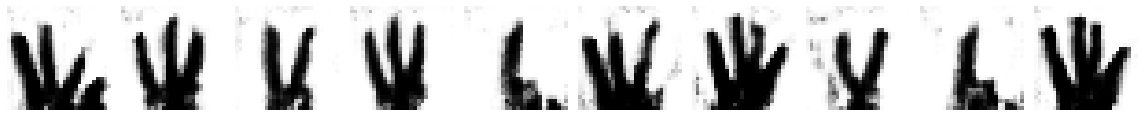

 87%|████████▋ | 2600/3000 [07:05<02:10,  3.06it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2601/3000 [07:05<01:50,  3.62it/s]

>2601, dr[0.573,0.012], df[0.396,0.022], g[1.837,0.012]
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2602/3000 [07:05<01:36,  4.11it/s]

>2602, dr[0.257,0.003], df[0.463,0.170], g[2.165,0.026]
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2603/3000 [07:06<01:28,  4.51it/s]

>2603, dr[0.449,0.007], df[0.492,0.042], g[2.145,0.028]
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2604/3000 [07:06<01:21,  4.87it/s]

>2604, dr[0.471,0.061], df[0.283,0.011], g[2.119,0.021]
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2605/3000 [07:06<01:19,  4.98it/s]

>2605, dr[0.259,0.012], df[0.519,0.041], g[2.046,0.102]
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2606/3000 [07:06<01:15,  5.24it/s]

>2606, dr[0.605,0.009], df[0.259,0.008], g[1.660,0.016]
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2607/3000 [07:06<01:11,  5.53it/s]

>2607, dr[0.195,0.007], df[0.357,0.007], g[1.986,0.051]
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2608/3000 [07:07<01:10,  5.60it/s]

>2608, dr[0.400,0.006], df[0.499,0.016], g[2.154,0.025]
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2609/3000 [07:07<01:07,  5.80it/s]

>2609, dr[0.410,0.014], df[0.353,0.009], g[1.877,0.015]
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2610/3000 [07:07<01:08,  5.72it/s]

>2610, dr[0.287,0.011], df[0.299,0.012], g[1.958,0.049]
1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 2611/3000 [07:07<01:09,  5.60it/s]

>2611, dr[0.297,0.013], df[0.229,0.016], g[2.080,0.043]
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2612/3000 [07:07<01:07,  5.75it/s]

>2612, dr[0.324,0.012], df[0.373,0.039], g[2.062,0.019]
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2613/3000 [07:07<01:08,  5.68it/s]

>2613, dr[0.407,0.049], df[0.661,0.011], g[1.964,0.039]
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2614/3000 [07:08<01:06,  5.82it/s]

>2614, dr[0.485,0.006], df[0.255,0.047], g[2.408,0.024]
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2615/3000 [07:08<01:07,  5.73it/s]

>2615, dr[0.298,0.062], df[0.535,0.039], g[2.279,0.100]
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2616/3000 [07:08<01:07,  5.66it/s]

>2616, dr[0.819,0.023], df[0.491,0.025], g[1.802,0.012]
1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 2617/3000 [07:08<01:05,  5.88it/s]

>2617, dr[0.502,0.029], df[0.584,0.032], g[1.642,0.037]
1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 2618/3000 [07:08<01:04,  5.91it/s]

>2618, dr[0.272,0.011], df[0.461,0.011], g[2.115,0.029]
1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 2619/3000 [07:08<01:04,  5.87it/s]

>2619, dr[0.544,0.009], df[0.324,0.004], g[2.462,0.018]
1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 2620/3000 [07:09<01:04,  5.93it/s]

>2620, dr[0.515,0.102], df[0.405,0.027], g[1.688,0.029]
1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 2621/3000 [07:09<01:02,  6.10it/s]

>2621, dr[0.358,0.010], df[0.301,0.047], g[1.800,0.049]
1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 2622/3000 [07:09<01:03,  5.91it/s]

>2622, dr[0.284,0.001], df[0.444,0.097], g[1.700,0.023]
1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 2623/3000 [07:09<01:04,  5.84it/s]

>2623, dr[0.354,0.046], df[0.612,0.049], g[2.465,0.038]
1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 2624/3000 [07:09<01:03,  5.90it/s]

>2624, dr[0.504,0.008], df[0.387,0.016], g[2.302,0.044]
1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 2625/3000 [07:09<01:03,  5.90it/s]

>2625, dr[0.351,0.006], df[0.328,0.042], g[2.140,0.031]
1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2626/3000 [07:10<01:03,  5.92it/s]

>2626, dr[0.532,0.018], df[0.509,0.034], g[1.738,0.027]
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2627/3000 [07:10<01:02,  6.00it/s]

>2627, dr[0.248,0.008], df[0.471,0.040], g[1.791,0.042]
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2628/3000 [07:10<01:00,  6.16it/s]

>2628, dr[0.370,0.012], df[0.340,0.031], g[1.976,0.012]
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2629/3000 [07:10<01:00,  6.18it/s]

>2629, dr[0.341,0.004], df[0.347,0.011], g[2.259,0.043]
1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2630/3000 [07:10<01:00,  6.13it/s]

>2630, dr[0.314,0.005], df[0.249,0.038], g[2.130,0.053]
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2631/3000 [07:10<00:59,  6.21it/s]

>2631, dr[0.374,0.019], df[0.365,0.028], g[1.377,0.006]
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2632/3000 [07:11<00:58,  6.27it/s]

>2632, dr[0.305,0.005], df[0.429,0.123], g[1.791,0.037]
1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2633/3000 [07:11<00:59,  6.16it/s]

>2633, dr[0.457,0.015], df[0.186,0.031], g[1.417,0.052]
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2634/3000 [07:11<00:59,  6.13it/s]

>2634, dr[0.204,0.006], df[0.394,0.009], g[1.379,0.017]
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2635/3000 [07:11<00:59,  6.10it/s]

>2635, dr[0.261,0.005], df[0.784,0.010], g[2.070,0.026]
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2636/3000 [07:11<01:00,  6.01it/s]

>2636, dr[0.407,0.006], df[0.458,0.023], g[2.045,0.077]
1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2637/3000 [07:11<01:01,  5.92it/s]

>2637, dr[0.533,0.010], df[0.270,0.045], g[2.030,0.044]
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2638/3000 [07:12<01:00,  5.97it/s]

>2638, dr[0.401,0.016], df[0.262,0.064], g[1.839,0.038]
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2639/3000 [07:12<01:00,  5.98it/s]

>2639, dr[0.265,0.020], df[0.455,0.003], g[1.837,0.043]
1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2640/3000 [07:12<01:00,  5.92it/s]

>2640, dr[0.254,0.052], df[0.309,0.034], g[2.099,0.026]
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2641/3000 [07:12<01:01,  5.86it/s]

>2641, dr[0.431,0.043], df[0.443,0.058], g[1.964,0.024]
1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2642/3000 [07:12<01:00,  5.96it/s]

>2642, dr[0.501,0.007], df[0.283,0.025], g[1.832,0.009]
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2643/3000 [07:12<00:59,  5.96it/s]

>2643, dr[0.319,0.004], df[0.380,0.082], g[2.110,0.010]
1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 2644/3000 [07:13<00:59,  5.98it/s]

>2644, dr[0.330,0.005], df[0.549,0.013], g[1.929,0.064]
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2645/3000 [07:13<00:58,  6.08it/s]

>2645, dr[0.370,0.049], df[0.300,0.024], g[1.899,0.042]
1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 2646/3000 [07:13<01:00,  5.81it/s]

>2646, dr[0.390,0.061], df[0.239,0.019], g[1.798,0.047]
1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 2647/3000 [07:13<01:00,  5.86it/s]

>2647, dr[0.354,0.004], df[0.530,0.016], g[2.181,0.072]
1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 2648/3000 [07:13<00:59,  5.95it/s]

>2648, dr[0.236,0.004], df[0.352,0.006], g[2.204,0.048]
1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 2649/3000 [07:13<00:59,  5.91it/s]

>2649, dr[0.345,0.007], df[0.220,0.015], g[1.973,0.079]
1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 2650/3000 [07:14<01:01,  5.72it/s]

>2650, dr[0.300,0.011], df[0.538,0.013], g[1.575,0.049]
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2651/3000 [07:14<01:00,  5.80it/s]

>2651, dr[0.287,0.018], df[0.275,0.048], g[2.023,0.026]
1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 2652/3000 [07:14<00:59,  5.84it/s]

>2652, dr[0.384,0.014], df[0.429,0.014], g[1.821,0.045]
1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 2653/3000 [07:14<00:59,  5.79it/s]

>2653, dr[0.656,0.020], df[0.609,0.011], g[1.953,0.038]
1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 2654/3000 [07:14<00:57,  5.97it/s]

>2654, dr[0.280,0.030], df[0.312,0.084], g[1.923,0.013]
1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 2655/3000 [07:14<00:57,  6.00it/s]

>2655, dr[0.249,0.084], df[0.384,0.039], g[1.881,0.056]
1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 2656/3000 [07:15<00:57,  5.97it/s]

>2656, dr[0.303,0.027], df[0.380,0.021], g[2.068,0.031]
1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 2657/3000 [07:15<00:56,  6.12it/s]

>2657, dr[0.379,0.031], df[0.329,0.027], g[2.202,0.041]
1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 2658/3000 [07:15<00:56,  6.03it/s]

>2658, dr[0.483,0.005], df[0.458,0.007], g[1.835,0.082]
1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 2659/3000 [07:15<00:54,  6.21it/s]

>2659, dr[0.429,0.013], df[0.380,0.013], g[1.923,0.030]
1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 2660/3000 [07:15<00:56,  5.99it/s]

>2660, dr[0.656,0.019], df[0.486,0.024], g[1.962,0.039]
1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 2661/3000 [07:15<00:55,  6.09it/s]

>2661, dr[0.197,0.008], df[0.417,0.017], g[2.098,0.082]
1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 2662/3000 [07:16<00:55,  6.08it/s]

>2662, dr[0.457,0.012], df[0.400,0.015], g[2.013,0.046]
1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 2663/3000 [07:16<00:55,  6.08it/s]

>2663, dr[0.199,0.005], df[0.288,0.018], g[2.168,0.051]
1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 2664/3000 [07:16<00:56,  5.97it/s]

>2664, dr[0.481,0.005], df[0.489,0.035], g[1.964,0.052]
1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2665/3000 [07:16<00:56,  5.90it/s]

>2665, dr[0.261,0.012], df[0.320,0.035], g[2.228,0.026]
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2666/3000 [07:16<00:56,  5.90it/s]

>2666, dr[0.588,0.005], df[0.328,0.008], g[1.854,0.065]
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2667/3000 [07:16<00:55,  6.00it/s]

>2667, dr[0.295,0.003], df[0.268,0.005], g[1.742,0.034]
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2668/3000 [07:17<00:55,  5.97it/s]

>2668, dr[0.333,0.008], df[0.418,0.003], g[1.733,0.058]
1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2669/3000 [07:17<00:57,  5.78it/s]

>2669, dr[0.320,0.005], df[0.394,0.009], g[1.936,0.031]
1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2670/3000 [07:17<00:56,  5.82it/s]

>2670, dr[0.608,0.002], df[0.508,0.042], g[1.859,0.039]
1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 2671/3000 [07:17<00:56,  5.78it/s]

>2671, dr[0.331,0.004], df[0.353,0.017], g[2.051,0.055]
1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 2672/3000 [07:17<00:57,  5.72it/s]

>2672, dr[0.403,0.010], df[0.767,0.007], g[2.042,0.063]
1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 2673/3000 [07:17<00:56,  5.77it/s]

>2673, dr[0.347,0.030], df[0.210,0.066], g[2.517,0.030]
1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2674/3000 [07:18<00:55,  5.83it/s]

>2674, dr[0.455,0.006], df[0.265,0.017], g[1.952,0.041]
1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2675/3000 [07:18<00:55,  5.80it/s]

>2675, dr[0.319,0.016], df[0.391,0.154], g[1.951,0.025]
1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 2676/3000 [07:18<00:55,  5.84it/s]

>2676, dr[0.346,0.003], df[0.402,0.051], g[2.148,0.070]
1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2677/3000 [07:18<00:56,  5.69it/s]

>2677, dr[0.386,0.046], df[0.478,0.009], g[2.282,0.038]
1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 2678/3000 [07:18<00:54,  5.91it/s]

>2678, dr[0.435,0.025], df[0.239,0.040], g[1.920,0.038]
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2679/3000 [07:18<00:53,  6.00it/s]

>2679, dr[0.277,0.004], df[0.444,0.044], g[2.204,0.017]
1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 2680/3000 [07:19<00:53,  5.98it/s]

>2680, dr[0.593,0.005], df[0.415,0.062], g[1.898,0.032]
1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 2681/3000 [07:19<00:52,  6.03it/s]

>2681, dr[0.348,0.013], df[0.490,0.018], g[1.730,0.049]
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2682/3000 [07:19<00:52,  6.00it/s]

>2682, dr[0.394,0.006], df[0.312,0.035], g[1.991,0.026]
1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 2683/3000 [07:19<00:53,  5.95it/s]

>2683, dr[0.473,0.003], df[0.539,0.032], g[1.684,0.041]
1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 2684/3000 [07:19<00:52,  6.01it/s]

>2684, dr[0.514,0.012], df[0.499,0.056], g[1.959,0.061]
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 2685/3000 [07:19<00:51,  6.06it/s]

>2685, dr[0.500,0.002], df[0.521,0.041], g[1.709,0.054]
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 2686/3000 [07:20<00:51,  6.13it/s]

>2686, dr[0.319,0.032], df[0.368,0.053], g[2.140,0.061]
1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 2687/3000 [07:20<00:50,  6.15it/s]

>2687, dr[0.521,0.041], df[0.445,0.018], g[1.645,0.026]
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 2688/3000 [07:20<00:49,  6.26it/s]

>2688, dr[0.289,0.014], df[0.334,0.010], g[1.672,0.061]
1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 2689/3000 [07:20<00:50,  6.20it/s]

>2689, dr[0.267,0.006], df[0.372,0.112], g[2.049,0.014]
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2690/3000 [07:20<00:49,  6.29it/s]

>2690, dr[0.386,0.009], df[0.513,0.012], g[1.797,0.057]
1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 2691/3000 [07:20<00:49,  6.30it/s]

>2691, dr[0.487,0.007], df[0.331,0.131], g[1.857,0.094]
1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 2692/3000 [07:21<00:49,  6.23it/s]

>2692, dr[0.393,0.009], df[0.552,0.007], g[2.014,0.033]
1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 2693/3000 [07:21<00:49,  6.16it/s]

>2693, dr[0.345,0.026], df[0.358,0.024], g[2.147,0.024]
1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 2694/3000 [07:21<00:50,  6.07it/s]

>2694, dr[0.337,0.008], df[0.341,0.033], g[1.939,0.053]
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2695/3000 [07:21<00:50,  6.05it/s]

>2695, dr[0.371,0.012], df[0.278,0.090], g[1.525,0.082]
1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 2696/3000 [07:21<00:51,  5.93it/s]

>2696, dr[0.448,0.006], df[0.765,0.066], g[1.991,0.022]
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2697/3000 [07:21<00:51,  5.92it/s]

>2697, dr[0.346,0.019], df[0.365,0.016], g[2.508,0.022]
1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 2698/3000 [07:22<00:50,  6.04it/s]

>2698, dr[0.304,0.052], df[0.287,0.016], g[2.451,0.030]
1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 2699/3000 [07:22<00:49,  6.06it/s]

>2699, dr[0.511,0.004], df[0.398,0.015], g[1.966,0.092]
1/1 [==============================] - 0s 23ms/step
>2700, dr[0.413,0.056], df[0.244,0.024], g[1.826,0.064]
1/1 [==============================] - 0s 24ms/step


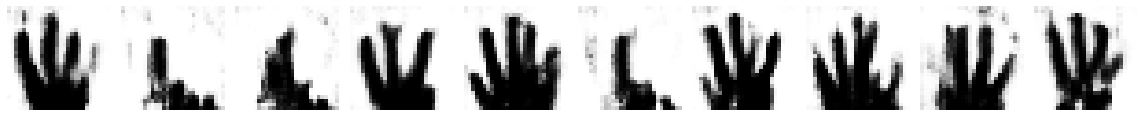

 90%|█████████ | 2700/3000 [07:22<01:36,  3.11it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2701/3000 [07:23<01:22,  3.64it/s]

>2701, dr[0.273,0.003], df[0.623,0.015], g[1.912,0.035]
1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 2702/3000 [07:23<01:12,  4.11it/s]

>2702, dr[0.237,0.042], df[0.331,0.195], g[2.082,0.034]
1/1 [==============================] - 0s 27ms/step
>2703, dr[0.662,0.005], df[0.272,0.037], g[2.057,0.018]


 90%|█████████ | 2703/3000 [07:23<01:07,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 2704/3000 [07:23<01:02,  4.70it/s]

>2704, dr[0.273,0.052], df[0.400,0.128], g[2.111,0.049]
1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 2705/3000 [07:23<00:58,  5.02it/s]

>2705, dr[0.269,0.004], df[0.259,0.029], g[1.803,0.022]
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2706/3000 [07:23<00:56,  5.19it/s]

>2706, dr[0.278,0.004], df[0.410,0.043], g[1.864,0.022]
1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 2707/3000 [07:24<00:54,  5.35it/s]

>2707, dr[0.532,0.079], df[0.416,0.022], g[1.796,0.016]
1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 2708/3000 [07:24<00:53,  5.51it/s]

>2708, dr[0.373,0.015], df[0.412,0.030], g[1.593,0.055]
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 2709/3000 [07:24<00:50,  5.73it/s]

>2709, dr[0.201,0.013], df[0.300,0.047], g[2.108,0.014]
1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 2710/3000 [07:24<00:50,  5.78it/s]

>2710, dr[0.310,0.014], df[0.296,0.043], g[2.316,0.037]
1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 2711/3000 [07:24<00:50,  5.77it/s]

>2711, dr[0.495,0.004], df[0.472,0.007], g[1.931,0.046]
1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 2712/3000 [07:24<00:49,  5.85it/s]

>2712, dr[0.395,0.019], df[0.373,0.043], g[1.718,0.035]
1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 2713/3000 [07:25<00:48,  5.86it/s]

>2713, dr[0.655,0.059], df[0.454,0.171], g[1.640,0.008]
1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 2714/3000 [07:25<00:47,  5.99it/s]

>2714, dr[0.295,0.097], df[0.479,0.017], g[1.909,0.057]
1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 2715/3000 [07:25<00:47,  6.02it/s]

>2715, dr[0.344,0.034], df[0.496,0.032], g[1.935,0.035]
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2716/3000 [07:25<00:47,  5.95it/s]

>2716, dr[0.403,0.008], df[0.391,0.025], g[2.024,0.013]
1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 2717/3000 [07:25<00:46,  6.04it/s]

>2717, dr[0.177,0.004], df[0.343,0.078], g[2.149,0.045]
1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2718/3000 [07:25<00:46,  6.05it/s]

>2718, dr[0.586,0.076], df[0.310,0.050], g[2.126,0.021]
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2719/3000 [07:26<00:46,  6.00it/s]

>2719, dr[0.473,0.005], df[0.425,0.024], g[1.978,0.013]
1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 2720/3000 [07:26<00:46,  5.97it/s]

>2720, dr[0.406,0.021], df[0.494,0.078], g[2.021,0.086]
1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2721/3000 [07:26<00:45,  6.07it/s]

>2721, dr[0.248,0.006], df[0.270,0.094], g[2.236,0.015]
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2722/3000 [07:26<00:46,  6.04it/s]

>2722, dr[0.587,0.085], df[0.368,0.024], g[1.766,0.148]
1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2723/3000 [07:26<00:47,  5.81it/s]

>2723, dr[0.374,0.005], df[0.416,0.018], g[1.530,0.092]
1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2724/3000 [07:26<00:46,  5.89it/s]

>2724, dr[0.268,0.009], df[0.434,0.138], g[2.121,0.029]
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2725/3000 [07:27<00:45,  6.01it/s]

>2725, dr[0.326,0.138], df[0.270,0.048], g[2.019,0.021]
1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 2726/3000 [07:27<00:46,  5.89it/s]

>2726, dr[0.319,0.085], df[0.458,0.066], g[1.987,0.043]
1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2727/3000 [07:27<00:46,  5.93it/s]

>2727, dr[0.456,0.011], df[0.237,0.021], g[1.931,0.056]
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2728/3000 [07:27<00:46,  5.86it/s]

>2728, dr[0.374,0.015], df[0.367,0.026], g[1.887,0.089]
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2729/3000 [07:27<00:46,  5.81it/s]

>2729, dr[0.265,0.019], df[0.393,0.178], g[1.672,0.052]
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2730/3000 [07:28<00:45,  5.89it/s]

>2730, dr[0.370,0.005], df[0.412,0.092], g[2.233,0.065]
1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 2731/3000 [07:28<00:45,  5.95it/s]

>2731, dr[0.579,0.009], df[0.488,0.017], g[2.002,0.047]
1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 2732/3000 [07:28<00:46,  5.77it/s]

>2732, dr[0.289,0.005], df[0.383,0.049], g[1.792,0.023]
1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 2733/3000 [07:28<00:47,  5.62it/s]

>2733, dr[0.572,0.015], df[0.360,0.020], g[1.956,0.073]
1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 2734/3000 [07:28<00:47,  5.65it/s]

>2734, dr[0.375,0.017], df[0.478,0.026], g[1.604,0.062]
1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 2735/3000 [07:28<00:45,  5.88it/s]

>2735, dr[0.275,0.032], df[0.457,0.028], g[1.807,0.044]
1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 2736/3000 [07:29<00:43,  6.05it/s]

>2736, dr[0.473,0.008], df[0.459,0.059], g[2.138,0.064]
1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 2737/3000 [07:29<00:43,  6.00it/s]

>2737, dr[0.762,0.028], df[0.515,0.028], g[1.934,0.105]
1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 2738/3000 [07:29<00:43,  6.08it/s]

>2738, dr[0.275,0.027], df[0.263,0.052], g[2.064,0.065]
1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 2739/3000 [07:29<00:43,  5.96it/s]

>2739, dr[0.528,0.026], df[0.478,0.032], g[1.655,0.145]
1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 2740/3000 [07:29<00:44,  5.88it/s]

>2740, dr[0.471,0.009], df[0.506,0.005], g[1.603,0.069]
1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 2741/3000 [07:29<00:43,  6.01it/s]

>2741, dr[0.283,0.024], df[0.498,0.092], g[2.019,0.026]
1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 2742/3000 [07:30<00:44,  5.83it/s]

>2742, dr[0.325,0.010], df[0.305,0.131], g[2.302,0.015]
1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 2743/3000 [07:30<00:43,  5.89it/s]

>2743, dr[0.487,0.020], df[0.407,0.093], g[1.409,0.018]
1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 2744/3000 [07:30<00:42,  6.06it/s]

>2744, dr[0.334,0.007], df[0.366,0.080], g[1.977,0.083]
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2745/3000 [07:30<00:41,  6.16it/s]

>2745, dr[0.297,0.009], df[0.362,0.007], g[2.030,0.032]
1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 2746/3000 [07:30<00:40,  6.23it/s]

>2746, dr[0.503,0.074], df[0.338,0.043], g[2.104,0.019]
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2747/3000 [07:30<00:41,  6.04it/s]

>2747, dr[0.356,0.004], df[0.346,0.013], g[1.847,0.053]
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2748/3000 [07:31<00:41,  6.01it/s]

>2748, dr[0.343,0.008], df[0.480,0.088], g[1.897,0.040]
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2749/3000 [07:31<00:41,  6.05it/s]

>2749, dr[0.388,0.027], df[0.308,0.030], g[1.606,0.039]
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2750/3000 [07:31<00:42,  5.90it/s]

>2750, dr[0.433,0.030], df[0.433,0.061], g[1.782,0.049]
1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2751/3000 [07:31<00:41,  6.01it/s]

>2751, dr[0.395,0.003], df[0.505,0.085], g[2.077,0.055]
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2752/3000 [07:31<00:40,  6.11it/s]

>2752, dr[0.358,0.020], df[0.353,0.020], g[1.815,0.061]
1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 2753/3000 [07:31<00:39,  6.26it/s]

>2753, dr[0.581,0.023], df[0.370,0.047], g[1.944,0.035]
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2754/3000 [07:32<00:40,  6.02it/s]

>2754, dr[0.418,0.009], df[0.615,0.012], g[1.544,0.018]
1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2755/3000 [07:32<00:42,  5.83it/s]

>2755, dr[0.535,0.005], df[0.582,0.015], g[1.696,0.011]
1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2756/3000 [07:32<00:40,  5.96it/s]

>2756, dr[0.301,0.019], df[0.500,0.018], g[2.181,0.085]
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2757/3000 [07:32<00:40,  6.01it/s]

>2757, dr[0.450,0.031], df[0.479,0.022], g[2.556,0.062]
1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2758/3000 [07:32<00:40,  5.98it/s]

>2758, dr[0.553,0.017], df[0.432,0.032], g[2.203,0.010]
1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 2759/3000 [07:32<00:40,  6.02it/s]

>2759, dr[0.306,0.003], df[0.279,0.061], g[2.104,0.032]
1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2760/3000 [07:33<00:40,  5.88it/s]

>2760, dr[0.517,0.014], df[0.382,0.009], g[1.696,0.030]
1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2761/3000 [07:33<00:40,  5.84it/s]

>2761, dr[0.295,0.030], df[0.355,0.171], g[2.237,0.028]
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2762/3000 [07:33<00:41,  5.80it/s]

>2762, dr[0.220,0.007], df[0.503,0.024], g[2.443,0.036]
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2763/3000 [07:33<00:39,  5.98it/s]

>2763, dr[0.630,0.010], df[0.300,0.016], g[2.128,0.066]
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2764/3000 [07:33<00:40,  5.77it/s]

>2764, dr[0.387,0.017], df[0.424,0.028], g[1.827,0.016]
1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 2765/3000 [07:33<00:39,  5.97it/s]

>2765, dr[0.408,0.024], df[0.788,0.062], g[2.078,0.008]
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2766/3000 [07:34<00:40,  5.77it/s]

>2766, dr[0.312,0.026], df[0.282,0.007], g[2.074,0.019]
1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 2767/3000 [07:34<00:40,  5.73it/s]

>2767, dr[0.540,0.007], df[0.250,0.055], g[1.864,0.013]
1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 2768/3000 [07:34<00:39,  5.80it/s]

>2768, dr[0.405,0.004], df[0.269,0.010], g[1.707,0.013]
1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2769/3000 [07:34<00:40,  5.76it/s]

>2769, dr[0.337,0.007], df[0.552,0.010], g[1.616,0.022]
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2770/3000 [07:34<00:38,  5.91it/s]

>2770, dr[0.300,0.004], df[0.652,0.100], g[1.983,0.004]
1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 2771/3000 [07:34<00:38,  5.97it/s]

>2771, dr[0.432,0.003], df[0.292,0.061], g[2.499,0.031]
1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 2772/3000 [07:35<00:39,  5.79it/s]

>2772, dr[0.294,0.011], df[0.351,0.017], g[2.334,0.063]
1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 2773/3000 [07:35<00:39,  5.80it/s]

>2773, dr[0.468,0.006], df[0.410,0.080], g[2.253,0.034]
1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 2774/3000 [07:35<00:39,  5.78it/s]

>2774, dr[0.539,0.031], df[0.345,0.018], g[2.044,0.009]
1/1 [==============================] - 0s 23ms/step


 92%|█████████▎| 2775/3000 [07:35<00:37,  5.98it/s]

>2775, dr[0.294,0.003], df[0.457,0.026], g[2.288,0.011]
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2776/3000 [07:35<00:37,  6.04it/s]

>2776, dr[0.467,0.003], df[0.548,0.009], g[1.919,0.045]
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2777/3000 [07:35<00:36,  6.04it/s]

>2777, dr[0.262,0.017], df[0.529,0.066], g[2.100,0.031]
1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2778/3000 [07:36<00:37,  5.98it/s]

>2778, dr[0.510,0.018], df[0.273,0.064], g[2.104,0.014]
1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 2779/3000 [07:36<00:36,  6.02it/s]

>2779, dr[0.394,0.014], df[0.204,0.047], g[1.883,0.046]
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2780/3000 [07:36<00:35,  6.18it/s]

>2780, dr[0.304,0.016], df[0.481,0.027], g[1.876,0.080]
1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 2781/3000 [07:36<00:35,  6.12it/s]

>2781, dr[0.340,0.017], df[0.474,0.085], g[2.201,0.018]
1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 2782/3000 [07:36<00:35,  6.13it/s]

>2782, dr[0.428,0.031], df[0.487,0.014], g[1.907,0.017]
1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2783/3000 [07:36<00:35,  6.08it/s]

>2783, dr[0.823,0.045], df[0.535,0.026], g[1.781,0.079]
1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 2784/3000 [07:37<00:35,  6.04it/s]

>2784, dr[0.453,0.006], df[0.361,0.158], g[2.139,0.035]
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2785/3000 [07:37<00:36,  5.92it/s]

>2785, dr[0.301,0.015], df[0.505,0.040], g[2.133,0.037]
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2786/3000 [07:37<00:35,  6.03it/s]

>2786, dr[0.473,0.019], df[0.436,0.010], g[2.262,0.017]
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2787/3000 [07:37<00:35,  5.92it/s]

>2787, dr[0.465,0.013], df[0.399,0.065], g[1.720,0.023]
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2788/3000 [07:37<00:35,  6.03it/s]

>2788, dr[0.386,0.028], df[0.511,0.009], g[2.532,0.023]
1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 2789/3000 [07:37<00:34,  6.07it/s]

>2789, dr[0.293,0.012], df[0.297,0.027], g[2.088,0.172]
1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 2790/3000 [07:38<00:34,  6.14it/s]

>2790, dr[0.634,0.030], df[0.420,0.032], g[2.079,0.039]
1/1 [==============================] - 0s 39ms/step
>2791, dr[0.325,0.005], df[0.454,0.012], g[1.997,0.038]


 93%|█████████▎| 2791/3000 [07:38<00:36,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2792/3000 [07:38<00:35,  5.84it/s]

>2792, dr[0.300,0.004], df[0.370,0.010], g[2.074,0.032]
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2793/3000 [07:38<00:35,  5.88it/s]

>2793, dr[0.445,0.023], df[0.329,0.019], g[2.061,0.072]
1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 2794/3000 [07:38<00:35,  5.86it/s]

>2794, dr[0.618,0.036], df[0.474,0.003], g[2.049,0.031]
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2795/3000 [07:38<00:34,  5.97it/s]

>2795, dr[0.333,0.002], df[0.457,0.071], g[1.898,0.041]
1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 2796/3000 [07:39<00:34,  5.89it/s]

>2796, dr[0.438,0.017], df[0.452,0.014], g[2.026,0.016]
1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 2797/3000 [07:39<00:35,  5.73it/s]

>2797, dr[0.275,0.009], df[0.292,0.030], g[1.982,0.033]
1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 2798/3000 [07:39<00:34,  5.82it/s]

>2798, dr[0.249,0.010], df[0.576,0.012], g[2.367,0.038]
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2799/3000 [07:39<00:34,  5.85it/s]

>2799, dr[0.520,0.005], df[0.300,0.052], g[2.255,0.011]
1/1 [==============================] - 0s 28ms/step
>2800, dr[0.376,0.014], df[0.372,0.021], g[1.812,0.053]
1/1 [==============================] - 0s 28ms/step


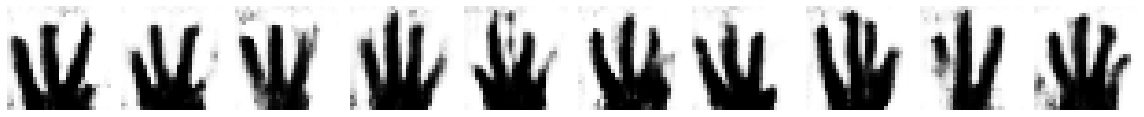

 93%|█████████▎| 2800/3000 [07:40<01:08,  2.92it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2801/3000 [07:40<00:57,  3.43it/s]

>2801, dr[0.384,0.005], df[0.374,0.022], g[1.541,0.040]
1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 2802/3000 [07:40<00:49,  3.98it/s]

>2802, dr[0.351,0.006], df[0.564,0.030], g[1.967,0.006]
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2803/3000 [07:40<00:44,  4.43it/s]

>2803, dr[0.474,0.014], df[0.270,0.021], g[1.852,0.035]
1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 2804/3000 [07:41<00:41,  4.75it/s]

>2804, dr[0.418,0.017], df[0.304,0.052], g[2.075,0.018]
1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 2805/3000 [07:41<00:38,  5.01it/s]

>2805, dr[0.274,0.012], df[0.578,0.022], g[2.080,0.024]
1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 2806/3000 [07:41<00:37,  5.24it/s]

>2806, dr[0.473,0.007], df[0.343,0.044], g[1.999,0.135]
1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 2807/3000 [07:41<00:36,  5.36it/s]

>2807, dr[0.606,0.041], df[0.379,0.043], g[1.630,0.036]
1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 2808/3000 [07:41<00:35,  5.48it/s]

>2808, dr[0.424,0.009], df[0.616,0.007], g[1.861,0.022]
1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 2809/3000 [07:41<00:34,  5.57it/s]

>2809, dr[0.307,0.011], df[0.417,0.053], g[1.950,0.038]
1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 2810/3000 [07:42<00:33,  5.66it/s]

>2810, dr[0.372,0.010], df[0.262,0.028], g[1.957,0.028]
1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 2811/3000 [07:42<00:32,  5.80it/s]

>2811, dr[0.296,0.006], df[0.189,0.052], g[1.756,0.005]
1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 2812/3000 [07:42<00:32,  5.80it/s]

>2812, dr[0.298,0.005], df[0.346,0.014], g[1.863,0.084]
1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 2813/3000 [07:42<00:31,  5.86it/s]

>2813, dr[0.287,0.001], df[0.329,0.013], g[2.138,0.048]
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2814/3000 [07:42<00:31,  5.86it/s]

>2814, dr[0.353,0.027], df[0.324,0.057], g[1.735,0.085]
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2815/3000 [07:42<00:32,  5.75it/s]

>2815, dr[0.393,0.008], df[0.284,0.057], g[1.707,0.034]
1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 2816/3000 [07:43<00:32,  5.74it/s]

>2816, dr[0.536,0.038], df[0.400,0.134], g[1.857,0.018]
1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 2817/3000 [07:43<00:32,  5.68it/s]

>2817, dr[0.281,0.003], df[0.513,0.098], g[2.014,0.035]
1/1 [==============================] - 0s 27ms/step
>2818, dr[0.394,0.009], df[0.322,0.059], g[1.974,0.025]


 94%|█████████▍| 2818/3000 [07:43<00:32,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2819/3000 [07:43<00:31,  5.72it/s]

>2819, dr[0.486,0.010], df[0.525,0.017], g[1.899,0.033]
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2820/3000 [07:43<00:30,  5.88it/s]

>2820, dr[0.282,0.003], df[0.376,0.032], g[1.977,0.048]
1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 2821/3000 [07:43<00:29,  5.98it/s]

>2821, dr[0.589,0.013], df[0.332,0.014], g[2.045,0.020]
1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 2822/3000 [07:44<00:29,  5.94it/s]

>2822, dr[0.356,0.003], df[0.619,0.028], g[1.842,0.010]
1/1 [==============================] - 0s 21ms/step
>2823, dr[0.202,0.020], df[0.200,0.006], g[1.988,0.016]


 94%|█████████▍| 2823/3000 [07:44<00:31,  5.59it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 2824/3000 [07:44<00:30,  5.76it/s]

>2824, dr[0.499,0.028], df[0.392,0.061], g[1.894,0.018]
1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 2825/3000 [07:44<00:30,  5.81it/s]

>2825, dr[0.306,0.029], df[0.667,0.022], g[2.166,0.030]
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 2826/3000 [07:44<00:29,  5.92it/s]

>2826, dr[0.475,0.013], df[0.304,0.015], g[2.176,0.048]
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2827/3000 [07:45<00:29,  5.78it/s]

>2827, dr[0.296,0.023], df[0.259,0.036], g[1.941,0.072]
1/1 [==============================] - 0s 26ms/step
>2828, dr[0.528,0.022], df[0.257,0.046], g[1.882,0.010]


 94%|█████████▍| 2828/3000 [07:45<00:30,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 2829/3000 [07:45<00:29,  5.85it/s]

>2829, dr[0.271,0.020], df[0.596,0.072], g[1.542,0.074]
1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 2830/3000 [07:45<00:29,  5.67it/s]

>2830, dr[0.532,0.023], df[0.532,0.036], g[1.641,0.018]
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2831/3000 [07:45<00:28,  5.87it/s]

>2831, dr[0.657,0.007], df[0.451,0.046], g[1.650,0.029]
1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 2832/3000 [07:45<00:28,  5.88it/s]

>2832, dr[0.295,0.006], df[0.498,0.032], g[1.771,0.014]
1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 2833/3000 [07:46<00:28,  5.82it/s]

>2833, dr[0.632,0.020], df[0.400,0.014], g[2.082,0.013]
1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 2834/3000 [07:46<00:28,  5.86it/s]

>2834, dr[0.503,0.031], df[0.527,0.063], g[1.847,0.031]
1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 2835/3000 [07:46<00:27,  5.97it/s]

>2835, dr[0.376,0.018], df[0.426,0.085], g[1.841,0.031]
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 2836/3000 [07:46<00:28,  5.82it/s]

>2836, dr[0.322,0.042], df[0.572,0.018], g[1.973,0.026]
1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 2837/3000 [07:46<00:28,  5.80it/s]

>2837, dr[0.360,0.039], df[0.559,0.005], g[2.332,0.079]
1/1 [==============================] - 0s 25ms/step
>2838, dr[0.525,0.030], df[0.377,0.028], g[2.336,0.042]


 95%|█████████▍| 2838/3000 [07:46<00:28,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 2839/3000 [07:47<00:28,  5.71it/s]

>2839, dr[0.374,0.005], df[0.385,0.012], g[2.524,0.048]
1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 2840/3000 [07:47<00:27,  5.82it/s]

>2840, dr[0.558,0.004], df[0.322,0.008], g[1.901,0.027]
1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 2841/3000 [07:47<00:27,  5.78it/s]

>2841, dr[0.492,0.022], df[0.560,0.028], g[1.906,0.033]
1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 2842/3000 [07:47<00:27,  5.65it/s]

>2842, dr[0.270,0.037], df[0.378,0.094], g[1.738,0.020]
1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 2843/3000 [07:47<00:27,  5.76it/s]

>2843, dr[0.472,0.029], df[0.281,0.013], g[1.590,0.034]
1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 2844/3000 [07:47<00:26,  5.92it/s]

>2844, dr[0.260,0.008], df[0.487,0.052], g[1.495,0.022]
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 2845/3000 [07:48<00:26,  5.87it/s]

>2845, dr[0.493,0.014], df[0.377,0.031], g[1.792,0.045]
1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 2846/3000 [07:48<00:26,  5.75it/s]

>2846, dr[0.216,0.079], df[0.358,0.042], g[1.886,0.036]
1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 2847/3000 [07:48<00:26,  5.77it/s]

>2847, dr[0.569,0.080], df[0.437,0.078], g[1.622,0.041]
1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 2848/3000 [07:48<00:26,  5.70it/s]

>2848, dr[0.282,0.005], df[0.438,0.016], g[1.850,0.063]
1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 2849/3000 [07:48<00:26,  5.79it/s]

>2849, dr[0.665,0.007], df[0.402,0.037], g[1.966,0.036]
1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 2850/3000 [07:48<00:25,  5.90it/s]

>2850, dr[0.438,0.034], df[0.414,0.023], g[1.618,0.032]
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2851/3000 [07:49<00:25,  5.89it/s]

>2851, dr[0.314,0.022], df[0.743,0.036], g[2.001,0.029]
1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 2852/3000 [07:49<00:24,  6.00it/s]

>2852, dr[0.420,0.007], df[0.485,0.032], g[1.785,0.062]
1/1 [==============================] - 0s 26ms/step
>2853, dr[0.462,0.007], df[0.356,0.023], g[1.958,0.027]


 95%|█████████▌| 2853/3000 [07:49<00:25,  5.69it/s]

1/1 [==============================] - 0s 21ms/step
>2854, dr[0.455,0.006], df[0.329,0.021], g[1.855,0.043]


 95%|█████████▌| 2854/3000 [07:49<00:26,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2855/3000 [07:49<00:25,  5.66it/s]

>2855, dr[0.390,0.010], df[0.522,0.016], g[1.949,0.071]
1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 2856/3000 [07:50<00:24,  5.82it/s]

>2856, dr[0.383,0.018], df[0.490,0.015], g[1.999,0.028]
1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 2857/3000 [07:50<00:24,  5.77it/s]

>2857, dr[0.522,0.006], df[0.367,0.061], g[1.857,0.015]
1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 2858/3000 [07:50<00:24,  5.77it/s]

>2858, dr[0.258,0.002], df[0.513,0.013], g[1.879,0.027]
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2859/3000 [07:50<00:25,  5.62it/s]

>2859, dr[0.641,0.007], df[0.263,0.032], g[1.490,0.054]
1/1 [==============================] - 0s 21ms/step
>2860, dr[0.236,0.044], df[0.462,0.007], g[1.786,0.043]


 95%|█████████▌| 2860/3000 [07:50<00:25,  5.54it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 2861/3000 [07:51<00:27,  5.02it/s]

>2861, dr[0.280,0.024], df[0.559,0.100], g[1.881,0.017]
1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 2862/3000 [07:51<00:26,  5.25it/s]

>2862, dr[0.433,0.016], df[0.293,0.014], g[1.975,0.052]
1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 2863/3000 [07:51<00:25,  5.43it/s]

>2863, dr[0.461,0.004], df[0.297,0.026], g[2.249,0.086]
1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 2864/3000 [07:51<00:24,  5.65it/s]

>2864, dr[0.335,0.007], df[0.241,0.006], g[1.982,0.097]
1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 2865/3000 [07:51<00:23,  5.80it/s]

>2865, dr[0.364,0.006], df[0.527,0.028], g[2.020,0.085]
1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 2866/3000 [07:51<00:23,  5.72it/s]

>2866, dr[0.400,0.014], df[0.412,0.059], g[1.891,0.035]
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2867/3000 [07:52<00:23,  5.72it/s]

>2867, dr[0.211,0.017], df[0.340,0.003], g[2.170,0.042]
1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 2868/3000 [07:52<00:23,  5.64it/s]

>2868, dr[0.212,0.030], df[0.273,0.123], g[2.169,0.045]
1/1 [==============================] - 0s 27ms/step
>2869, dr[0.627,0.019], df[0.478,0.023], g[2.049,0.044]


 96%|█████████▌| 2869/3000 [07:52<00:23,  5.48it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 2870/3000 [07:52<00:22,  5.66it/s]

>2870, dr[0.351,0.038], df[0.338,0.036], g[1.580,0.043]
1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 2871/3000 [07:52<00:23,  5.60it/s]

>2871, dr[0.397,0.007], df[0.479,0.030], g[1.940,0.094]
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2872/3000 [07:52<00:22,  5.70it/s]

>2872, dr[0.299,0.002], df[0.330,0.064], g[2.170,0.019]
1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 2873/3000 [07:53<00:21,  5.79it/s]

>2873, dr[0.386,0.033], df[0.341,0.020], g[1.937,0.019]
1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 2874/3000 [07:53<00:21,  5.90it/s]

>2874, dr[0.431,0.008], df[0.388,0.050], g[1.765,0.014]
1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 2875/3000 [07:53<00:22,  5.49it/s]

>2875, dr[0.337,0.036], df[0.461,0.054], g[1.700,0.013]
1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 2876/3000 [07:53<00:21,  5.67it/s]

>2876, dr[0.348,0.002], df[0.297,0.068], g[1.924,0.077]
1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 2877/3000 [07:53<00:21,  5.60it/s]

>2877, dr[0.502,0.057], df[0.459,0.071], g[1.711,0.020]
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2878/3000 [07:53<00:21,  5.77it/s]

>2878, dr[0.556,0.004], df[0.673,0.019], g[1.718,0.024]
1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 2879/3000 [07:54<00:20,  5.84it/s]

>2879, dr[0.485,0.020], df[0.506,0.181], g[1.754,0.024]
1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 2880/3000 [07:54<00:20,  5.76it/s]

>2880, dr[0.252,0.003], df[0.283,0.014], g[1.883,0.138]
1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2881/3000 [07:54<00:20,  5.86it/s]

>2881, dr[0.415,0.020], df[0.468,0.006], g[1.920,0.057]
1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 2882/3000 [07:54<00:20,  5.73it/s]

>2882, dr[0.353,0.014], df[0.480,0.058], g[1.680,0.047]
1/1 [==============================] - 0s 33ms/step
>2883, dr[0.268,0.007], df[0.371,0.043], g[1.977,0.045]


 96%|█████████▌| 2883/3000 [07:54<00:21,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 2884/3000 [07:55<00:20,  5.63it/s]

>2884, dr[0.573,0.008], df[0.207,0.008], g[1.859,0.048]
1/1 [==============================] - 0s 22ms/step
>2885, dr[0.404,0.029], df[0.316,0.010], g[1.425,0.046]

 96%|█████████▌| 2885/3000 [07:55<00:21,  5.34it/s]


1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 2886/3000 [07:55<00:20,  5.49it/s]

>2886, dr[0.206,0.011], df[0.459,0.010], g[1.675,0.035]
1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 2887/3000 [07:55<00:20,  5.57it/s]

>2887, dr[0.322,0.054], df[0.407,0.041], g[1.794,0.058]
1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 2888/3000 [07:55<00:19,  5.60it/s]

>2888, dr[0.408,0.010], df[0.304,0.013], g[1.740,0.046]
1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 2889/3000 [07:55<00:19,  5.62it/s]

>2889, dr[0.519,0.002], df[0.516,0.039], g[2.263,0.015]
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 2890/3000 [07:56<00:18,  5.80it/s]

>2890, dr[0.289,0.006], df[0.371,0.006], g[1.947,0.012]
1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 2891/3000 [07:56<00:18,  5.86it/s]

>2891, dr[0.407,0.006], df[0.433,0.029], g[2.102,0.053]
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 2892/3000 [07:56<00:18,  5.78it/s]

>2892, dr[0.435,0.009], df[0.371,0.012], g[1.826,0.027]
1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 2893/3000 [07:56<00:18,  5.77it/s]

>2893, dr[0.388,0.019], df[0.382,0.015], g[1.868,0.040]
1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 2894/3000 [07:56<00:18,  5.78it/s]

>2894, dr[0.342,0.006], df[0.396,0.057], g[1.767,0.023]
1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 2895/3000 [07:56<00:18,  5.63it/s]

>2895, dr[0.241,0.011], df[0.271,0.008], g[2.162,0.012]
1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 2896/3000 [07:57<00:18,  5.62it/s]

>2896, dr[0.668,0.009], df[0.378,0.018], g[1.770,0.025]
1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 2897/3000 [07:57<00:18,  5.68it/s]

>2897, dr[0.470,0.004], df[0.444,0.057], g[1.324,0.034]
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 2898/3000 [07:57<00:17,  5.78it/s]

>2898, dr[0.249,0.025], df[0.498,0.010], g[1.454,0.027]
1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 2899/3000 [07:57<00:17,  5.66it/s]

>2899, dr[0.269,0.025], df[0.390,0.005], g[2.040,0.017]
1/1 [==============================] - 0s 21ms/step
>2900, dr[0.322,0.006], df[0.262,0.009], g[1.808,0.028]
1/1 [==============================] - 0s 34ms/step


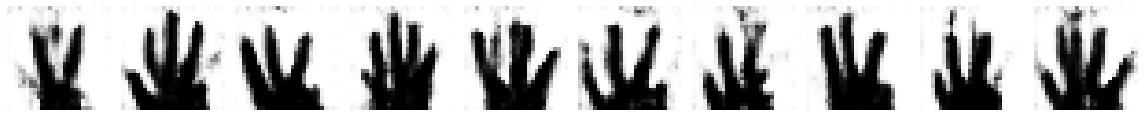

 97%|█████████▋| 2900/3000 [07:58<00:34,  2.93it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 2901/3000 [07:59<00:52,  1.88it/s]

>2901, dr[0.629,0.010], df[0.594,0.055], g[1.850,0.016]
1/1 [==============================] - 0s 24ms/step
>2902, dr[0.536,0.017], df[0.408,0.014], g[1.792,0.053]


 97%|█████████▋| 2902/3000 [07:59<00:42,  2.31it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 2903/3000 [07:59<00:34,  2.85it/s]

>2903, dr[0.317,0.010], df[0.242,0.028], g[1.688,0.019]
1/1 [==============================] - 0s 41ms/step
>2904, dr[0.275,0.010], df[0.461,0.038], g[1.897,0.075]


 97%|█████████▋| 2904/3000 [07:59<00:29,  3.30it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 2905/3000 [08:00<00:25,  3.77it/s]

>2905, dr[0.415,0.012], df[0.382,0.022], g[1.733,0.043]
1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 2906/3000 [08:00<00:22,  4.22it/s]

>2906, dr[0.391,0.003], df[0.330,0.059], g[1.652,0.043]
1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2907/3000 [08:00<00:20,  4.60it/s]

>2907, dr[0.331,0.016], df[0.365,0.008], g[1.689,0.021]
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 2908/3000 [08:00<00:18,  4.90it/s]

>2908, dr[0.298,0.017], df[0.430,0.143], g[1.707,0.097]
1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 2909/3000 [08:00<00:17,  5.22it/s]

>2909, dr[0.507,0.002], df[0.293,0.148], g[1.551,0.018]
1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2910/3000 [08:00<00:16,  5.30it/s]

>2910, dr[0.447,0.006], df[0.413,0.036], g[1.890,0.018]
1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 2911/3000 [08:01<00:16,  5.47it/s]

>2911, dr[0.388,0.007], df[0.509,0.013], g[1.972,0.047]
1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 2912/3000 [08:01<00:16,  5.49it/s]

>2912, dr[0.218,0.049], df[0.296,0.016], g[1.858,0.068]
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 2913/3000 [08:01<00:15,  5.62it/s]

>2913, dr[0.243,0.023], df[0.390,0.035], g[1.924,0.040]
1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 2914/3000 [08:01<00:15,  5.67it/s]

>2914, dr[0.260,0.006], df[0.253,0.055], g[2.101,0.013]
1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 2915/3000 [08:01<00:14,  5.72it/s]

>2915, dr[0.513,0.066], df[0.551,0.005], g[2.447,0.079]
1/1 [==============================] - 0s 22ms/step
>2916, dr[0.423,0.032], df[0.410,0.061], g[2.069,0.049]


 97%|█████████▋| 2916/3000 [08:02<00:15,  5.56it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 2917/3000 [08:02<00:14,  5.63it/s]

>2917, dr[0.535,0.010], df[0.364,0.044], g[1.735,0.035]
1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 2918/3000 [08:02<00:14,  5.66it/s]

>2918, dr[0.471,0.033], df[0.436,0.017], g[1.722,0.019]
1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 2919/3000 [08:02<00:14,  5.61it/s]

>2919, dr[0.331,0.009], df[0.294,0.008], g[1.702,0.027]
1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 2920/3000 [08:02<00:14,  5.64it/s]

>2920, dr[0.254,0.011], df[0.385,0.026], g[1.863,0.035]
1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 2921/3000 [08:02<00:13,  5.67it/s]

>2921, dr[0.428,0.010], df[0.453,0.094], g[1.616,0.058]
1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 2922/3000 [08:03<00:13,  5.70it/s]

>2922, dr[0.303,0.016], df[0.518,0.037], g[1.906,0.167]
1/1 [==============================] - 0s 22ms/step
>2923, dr[0.417,0.048], df[0.334,0.145], g[1.770,0.057]


 97%|█████████▋| 2923/3000 [08:03<00:13,  5.58it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 2924/3000 [08:03<00:13,  5.63it/s]

>2924, dr[0.615,0.007], df[0.357,0.016], g[1.590,0.044]
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 2925/3000 [08:03<00:13,  5.57it/s]

>2925, dr[0.338,0.014], df[0.444,0.010], g[1.946,0.033]
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 2926/3000 [08:03<00:12,  5.71it/s]

>2926, dr[0.328,0.028], df[0.419,0.016], g[1.687,0.014]
1/1 [==============================] - 0s 22ms/step
>2927, dr[0.414,0.015], df[0.473,0.046], g[2.394,0.015]


 98%|█████████▊| 2927/3000 [08:03<00:13,  5.44it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2928/3000 [08:04<00:13,  5.51it/s]

>2928, dr[0.459,0.007], df[0.343,0.041], g[1.990,0.041]
1/1 [==============================] - 0s 23ms/step
>2929, dr[0.442,0.006], df[0.551,0.050], g[1.932,0.017]


 98%|█████████▊| 2929/3000 [08:04<00:13,  5.39it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2930/3000 [08:04<00:12,  5.45it/s]

>2930, dr[0.517,0.014], df[0.479,0.083], g[2.029,0.025]
1/1 [==============================] - 0s 20ms/step
>2931, dr[0.543,0.009], df[0.464,0.094], g[1.783,0.037]


 98%|█████████▊| 2931/3000 [08:04<00:12,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 2932/3000 [08:04<00:12,  5.53it/s]

>2932, dr[0.298,0.012], df[0.299,0.047], g[1.822,0.040]
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 2933/3000 [08:05<00:12,  5.50it/s]

>2933, dr[0.446,0.009], df[0.352,0.089], g[1.808,0.036]
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 2934/3000 [08:05<00:11,  5.52it/s]

>2934, dr[0.494,0.010], df[0.553,0.042], g[1.597,0.047]
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 2935/3000 [08:05<00:11,  5.68it/s]

>2935, dr[0.431,0.024], df[0.561,0.013], g[1.780,0.088]
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2936/3000 [08:05<00:11,  5.71it/s]

>2936, dr[0.303,0.004], df[0.380,0.109], g[1.642,0.035]
1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 2937/3000 [08:05<00:10,  5.74it/s]

>2937, dr[0.417,0.026], df[0.455,0.010], g[1.644,0.040]
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2938/3000 [08:05<00:10,  5.66it/s]

>2938, dr[0.533,0.009], df[0.430,0.007], g[1.623,0.017]
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 2939/3000 [08:06<00:10,  5.64it/s]

>2939, dr[0.303,0.005], df[0.436,0.109], g[2.409,0.020]
1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 2940/3000 [08:06<00:10,  5.71it/s]

>2940, dr[0.406,0.009], df[0.381,0.008], g[1.812,0.046]
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 2941/3000 [08:06<00:10,  5.60it/s]

>2941, dr[0.397,0.007], df[0.346,0.066], g[2.160,0.018]
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 2942/3000 [08:06<00:10,  5.70it/s]

>2942, dr[0.465,0.028], df[0.472,0.014], g[1.730,0.023]
1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 2943/3000 [08:06<00:09,  5.81it/s]

>2943, dr[0.414,0.011], df[0.288,0.023], g[1.720,0.019]
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 2944/3000 [08:06<00:09,  6.03it/s]

>2944, dr[0.556,0.007], df[0.465,0.022], g[1.562,0.085]
1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 2945/3000 [08:07<00:09,  6.07it/s]

>2945, dr[0.309,0.044], df[0.642,0.069], g[1.847,0.047]
1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 2946/3000 [08:07<00:09,  5.90it/s]

>2946, dr[0.455,0.021], df[0.394,0.029], g[1.862,0.013]
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 2947/3000 [08:07<00:08,  5.98it/s]

>2947, dr[0.261,0.030], df[0.384,0.068], g[1.705,0.037]
1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2948/3000 [08:07<00:08,  5.90it/s]

>2948, dr[0.431,0.007], df[0.371,0.006], g[1.829,0.034]
1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 2949/3000 [08:07<00:08,  5.73it/s]

>2949, dr[0.376,0.017], df[0.504,0.012], g[2.044,0.007]
1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 2950/3000 [08:07<00:08,  5.77it/s]

>2950, dr[0.337,0.010], df[0.287,0.078], g[1.758,0.083]
1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 2951/3000 [08:08<00:08,  5.74it/s]

>2951, dr[0.311,0.006], df[0.282,0.027], g[2.081,0.057]
1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 2952/3000 [08:08<00:08,  5.76it/s]

>2952, dr[0.428,0.016], df[0.362,0.016], g[2.036,0.006]
1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 2953/3000 [08:08<00:08,  5.83it/s]

>2953, dr[0.328,0.019], df[0.431,0.069], g[1.669,0.025]
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 2954/3000 [08:08<00:07,  5.83it/s]

>2954, dr[0.304,0.012], df[0.409,0.011], g[1.755,0.030]
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 2955/3000 [08:08<00:07,  5.90it/s]

>2955, dr[0.450,0.001], df[0.418,0.069], g[2.102,0.073]
1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 2956/3000 [08:09<00:07,  5.59it/s]

>2956, dr[0.375,0.009], df[0.590,0.089], g[2.421,0.019]
1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 2957/3000 [08:09<00:07,  5.75it/s]

>2957, dr[0.504,0.002], df[0.608,0.035], g[2.217,0.149]
1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 2958/3000 [08:09<00:07,  5.82it/s]

>2958, dr[0.557,0.019], df[0.491,0.050], g[2.066,0.006]
1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 2959/3000 [08:09<00:07,  5.73it/s]

>2959, dr[0.456,0.059], df[0.363,0.024], g[2.019,0.013]
1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 2960/3000 [08:09<00:06,  5.93it/s]

>2960, dr[0.363,0.005], df[0.350,0.073], g[1.982,0.019]
1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 2961/3000 [08:09<00:06,  5.76it/s]

>2961, dr[0.384,0.019], df[0.320,0.074], g[2.018,0.049]
1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 2962/3000 [08:10<00:06,  5.93it/s]

>2962, dr[0.284,0.008], df[0.263,0.141], g[1.760,0.008]
1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 2963/3000 [08:10<00:06,  6.02it/s]

>2963, dr[0.426,0.006], df[0.558,0.049], g[1.950,0.048]
1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 2964/3000 [08:10<00:05,  6.05it/s]

>2964, dr[0.361,0.011], df[0.406,0.058], g[2.049,0.025]
1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 2965/3000 [08:10<00:05,  6.11it/s]

>2965, dr[0.424,0.033], df[0.472,0.068], g[2.331,0.026]
1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 2966/3000 [08:10<00:05,  6.10it/s]

>2966, dr[0.687,0.055], df[0.312,0.012], g[1.959,0.135]
1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 2967/3000 [08:10<00:05,  6.12it/s]

>2967, dr[0.329,0.011], df[0.337,0.048], g[1.888,0.043]
1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 2968/3000 [08:11<00:05,  5.91it/s]

>2968, dr[0.526,0.176], df[0.331,0.053], g[1.673,0.057]
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 2969/3000 [08:11<00:05,  5.96it/s]

>2969, dr[0.563,0.005], df[0.583,0.060], g[1.509,0.062]
1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 2970/3000 [08:11<00:05,  5.90it/s]

>2970, dr[0.305,0.030], df[0.550,0.021], g[1.715,0.037]
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 2971/3000 [08:11<00:04,  5.99it/s]

>2971, dr[0.468,0.035], df[0.334,0.021], g[1.700,0.049]
1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 2972/3000 [08:11<00:04,  6.02it/s]

>2972, dr[0.501,0.025], df[0.372,0.018], g[1.909,0.040]
1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 2973/3000 [08:11<00:04,  6.01it/s]

>2973, dr[0.510,0.005], df[0.593,0.128], g[2.067,0.025]
1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 2974/3000 [08:12<00:04,  6.03it/s]

>2974, dr[0.227,0.005], df[0.343,0.029], g[1.770,0.066]
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 2975/3000 [08:12<00:04,  5.88it/s]

>2975, dr[0.424,0.029], df[0.390,0.024], g[1.833,0.016]
1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 2976/3000 [08:12<00:04,  5.84it/s]

>2976, dr[0.368,0.042], df[0.581,0.074], g[2.125,0.036]
1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 2977/3000 [08:12<00:03,  5.89it/s]

>2977, dr[0.502,0.008], df[0.402,0.019], g[2.035,0.054]
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 2978/3000 [08:12<00:03,  5.83it/s]

>2978, dr[0.499,0.017], df[0.598,0.014], g[1.955,0.052]
1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 2979/3000 [08:12<00:03,  5.89it/s]

>2979, dr[0.326,0.009], df[0.332,0.042], g[1.976,0.083]
1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 2980/3000 [08:13<00:03,  5.96it/s]

>2980, dr[0.373,0.020], df[0.332,0.016], g[1.956,0.109]
1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 2981/3000 [08:13<00:03,  5.94it/s]

>2981, dr[0.361,0.024], df[0.350,0.024], g[1.977,0.058]
1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 2982/3000 [08:13<00:03,  5.94it/s]

>2982, dr[0.445,0.011], df[0.513,0.028], g[2.046,0.012]
1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 2983/3000 [08:13<00:02,  5.98it/s]

>2983, dr[0.433,0.005], df[0.491,0.061], g[2.226,0.076]
1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 2984/3000 [08:13<00:02,  6.03it/s]

>2984, dr[0.378,0.010], df[0.319,0.020], g[1.903,0.089]
1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 2985/3000 [08:13<00:02,  6.00it/s]

>2985, dr[0.492,0.006], df[0.460,0.012], g[1.686,0.015]
1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 2986/3000 [08:14<00:02,  6.10it/s]

>2986, dr[0.385,0.010], df[0.462,0.003], g[1.972,0.038]
1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 2987/3000 [08:14<00:02,  6.11it/s]

>2987, dr[0.406,0.013], df[0.327,0.027], g[2.012,0.031]
1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 2988/3000 [08:14<00:01,  6.03it/s]

>2988, dr[0.497,0.143], df[0.536,0.010], g[1.999,0.096]
1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 2989/3000 [08:14<00:01,  5.86it/s]

>2989, dr[0.514,0.006], df[0.361,0.066], g[1.684,0.043]
1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 2990/3000 [08:14<00:01,  5.76it/s]

>2990, dr[0.185,0.024], df[0.292,0.008], g[1.991,0.159]
1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 2991/3000 [08:14<00:01,  5.83it/s]

>2991, dr[0.394,0.002], df[0.359,0.094], g[1.868,0.012]
1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 2992/3000 [08:15<00:01,  5.83it/s]

>2992, dr[0.341,0.006], df[0.516,0.041], g[1.934,0.010]
1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 2993/3000 [08:15<00:01,  5.83it/s]

>2993, dr[0.347,0.033], df[0.356,0.015], g[1.978,0.061]
1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 2994/3000 [08:15<00:01,  5.83it/s]

>2994, dr[0.418,0.014], df[0.382,0.024], g[1.731,0.016]
1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 2995/3000 [08:15<00:00,  5.78it/s]

>2995, dr[0.469,0.005], df[0.404,0.013], g[1.841,0.065]
1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 2996/3000 [08:15<00:00,  5.76it/s]

>2996, dr[0.339,0.006], df[0.536,0.006], g[1.624,0.074]
1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 2997/3000 [08:15<00:00,  5.80it/s]

>2997, dr[0.422,0.009], df[0.408,0.013], g[1.852,0.048]
1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 2998/3000 [08:16<00:00,  5.79it/s]

>2998, dr[0.384,0.003], df[0.356,0.069], g[2.119,0.021]
1/1 [==============================] - 0s 30ms/step
>2999, dr[0.381,0.021], df[0.469,0.029], g[1.916,0.005]


100%|█████████▉| 2999/3000 [08:16<00:00,  5.59it/s]

1/1 [==============================] - 0s 25ms/step
>3000, dr[0.395,0.009], df[0.415,0.011], g[2.084,0.014]
1/1 [==============================] - 0s 28ms/step


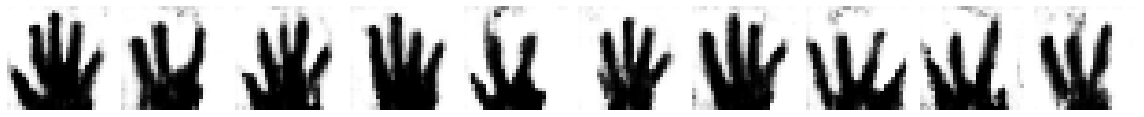

100%|██████████| 3000/3000 [08:17<00:00,  6.04it/s]


In [30]:
latent_dim = 100

discriminator = define_discriminator()                                  # create the discriminator
generator     = define_generator(latent_dim)                            # create the generator

gan_model = define_acgan(generator, discriminator)                      # create the gan

train(generator, discriminator, gan_model, images, labels, latent_dim)  # Train model  

# The loss is reported each training iteration, including the real/fake and class loss 
# for the discriminator on real examples (dr), the discriminator on fake examples (df),
# and the generator updated via the composite model when generating images (g).

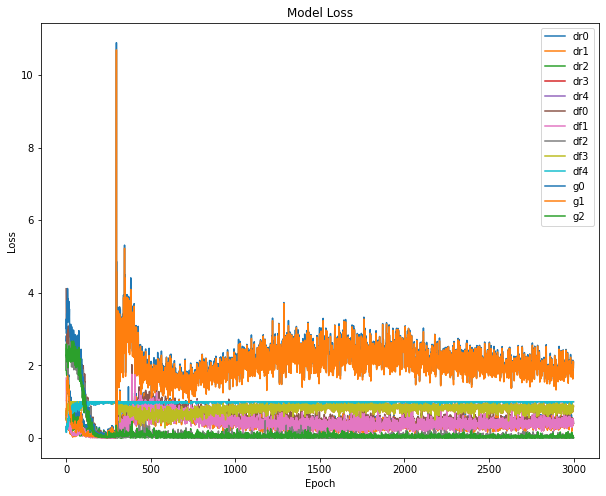

In [31]:
fig , ax = plt.subplots(figsize = (10,8))
ax.plot( [row[0] for row in discriminator_on_real_samples_loss_history] )
ax.plot( [row[1] for row in discriminator_on_real_samples_loss_history] )
ax.plot( [row[2] for row in discriminator_on_real_samples_loss_history] )
ax.plot( [row[3] for row in discriminator_on_real_samples_loss_history] )
ax.plot( [row[4] for row in discriminator_on_real_samples_loss_history] )

ax.plot( [row[0] for row in discriminator_on_fake_samples_loss_history] )
ax.plot( [row[1] for row in discriminator_on_fake_samples_loss_history] )
ax.plot( [row[2] for row in discriminator_on_fake_samples_loss_history] )
ax.plot( [row[3] for row in discriminator_on_real_samples_loss_history] )
ax.plot( [row[4] for row in discriminator_on_real_samples_loss_history] )


ax.plot( [row[0] for row in generator_loss_history] )
ax.plot( [row[1] for row in generator_loss_history] )
ax.plot( [row[2] for row in generator_loss_history] )

ax.legend(['dr0', 'dr1', 'dr2', 'dr3', 'dr4', 'df0', 'df1', 'df2', 'df3', 'df4', 'g0', 'g1', 'g2'])

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Model Loss')

plt.show()

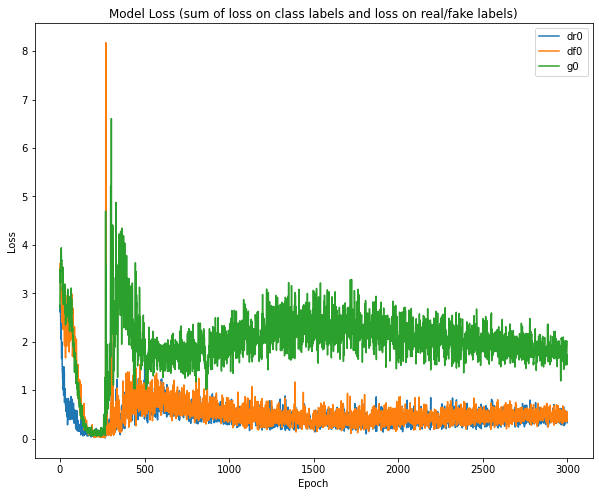

In [ ]:
# dr0 = dr1 + dr2  (dr1 is for class lables loss and dr2 is for real or fake label loss)
# df0 = df1 + df2
# g0  = g1  + g2

fig , ax = plt.subplots(figsize = (10,8))
ax.plot( [row[0] for row in discriminator_on_real_samples_loss_history] )

ax.plot( [row[0] for row in discriminator_on_fake_samples_loss_history] )

ax.plot( [row[0] for row in generator_loss_history] )

ax.legend(['dr0', 'df0', 'g0'])

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Model Loss (sum of loss on class labels and loss on real/fake labels)')

plt.show()

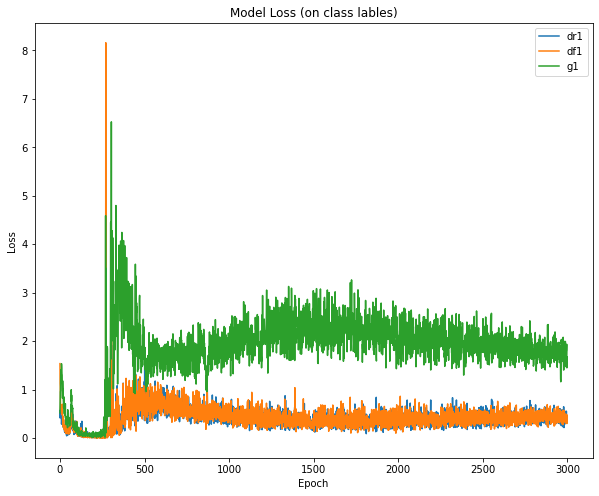

In [ ]:
fig , ax = plt.subplots(figsize = (10,8))
ax.plot( [row[1] for row in discriminator_on_real_samples_loss_history] )

ax.plot( [row[1] for row in discriminator_on_fake_samples_loss_history] )

ax.plot( [row[1] for row in generator_loss_history] )

ax.legend(['dr1', 'df1', 'g1'])

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Model Loss (on class lables)')

plt.show()

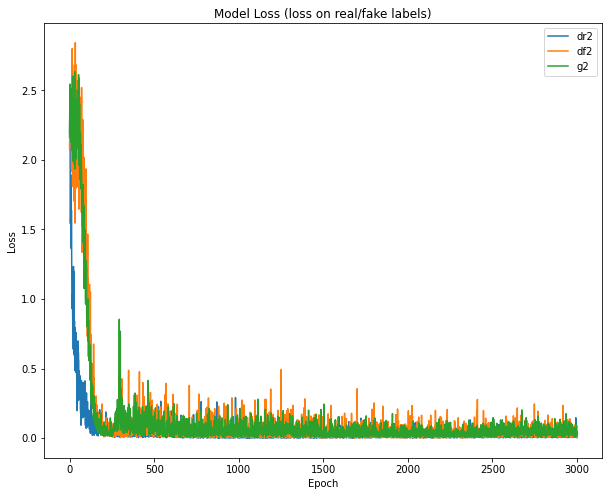

In [ ]:
fig , ax = plt.subplots(figsize = (10,8))

ax.plot( [row[2] for row in discriminator_on_real_samples_loss_history] )

ax.plot( [row[2] for row in discriminator_on_fake_samples_loss_history] )

ax.plot( [row[2] for row in generator_loss_history] )

ax.legend(['dr2', 'df2', 'g2'])

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Model Loss (loss on real/fake labels)')

plt.show()

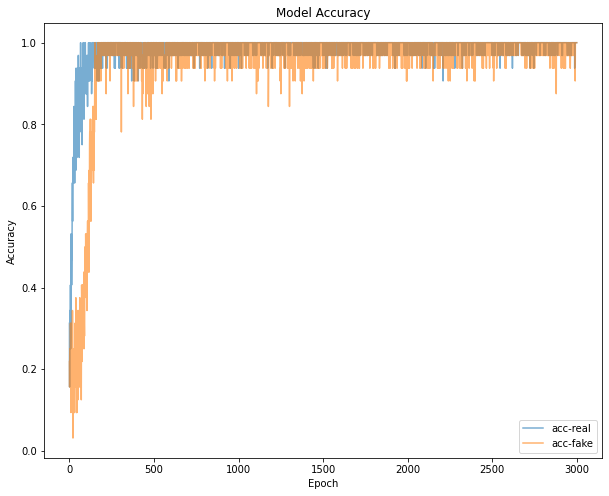

In [38]:
fig , ax = plt.subplots(figsize = (10,8))

ax.plot( [row[4] for row in discriminator_on_real_samples_loss_history], alpha=0.6 )
ax.plot( [row[4] for row in discriminator_on_fake_samples_loss_history], alpha=0.6 )

ax.legend(['acc-real', 'acc-fake']) 
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy')
plt.show()

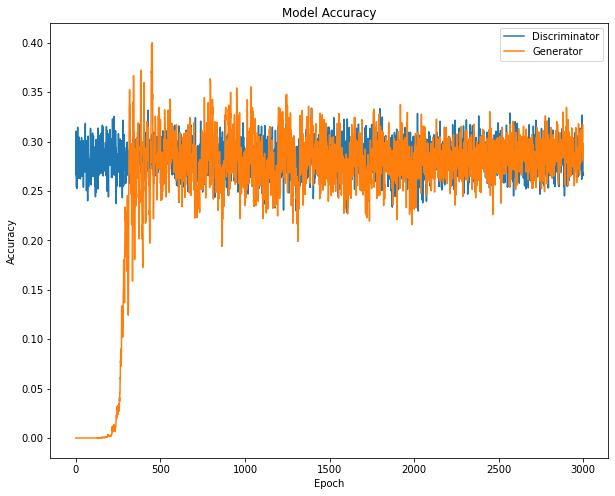

In [ ]:
fig , ax = plt.subplots(figsize = (10,8))

ax.plot( discriminator_accuracy_history )
ax.plot( generator_accuracy_history )

ax.legend(['Discriminator', 'Generator']) 
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy')
plt.show()